## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* My software pipeline to identify the lane boundaries in a video from a front-facing camera on a car

---
## First, I'll compute the camera calibration using chessboard images

In [39]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
print(len(images))

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        print('./output_images/cali_' + str(fname).split('\\')[-1])
        cv2.imwrite('./output_images/cali_' + str(fname).split('\\')[-1] ,img)
    
wide_dist = {"objpoints": objpoints, "imgpoints": imgpoints}
pickle.dump(wide_dist, open("wide_dist_pickle.p", "wb"))
cv2.destroyAllWindows()

20
./output_images/cali_calibration10.jpg
./output_images/cali_calibration11.jpg
./output_images/cali_calibration12.jpg
./output_images/cali_calibration13.jpg
./output_images/cali_calibration14.jpg
./output_images/cali_calibration15.jpg
./output_images/cali_calibration16.jpg
./output_images/cali_calibration17.jpg
./output_images/cali_calibration18.jpg
./output_images/cali_calibration19.jpg
./output_images/cali_calibration2.jpg
./output_images/cali_calibration20.jpg
./output_images/cali_calibration3.jpg
./output_images/cali_calibration6.jpg
./output_images/cali_calibration7.jpg
./output_images/cali_calibration8.jpg
./output_images/cali_calibration9.jpg


## Apply a distortion correction to raw images

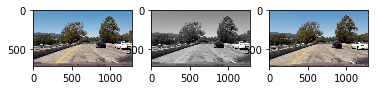

True

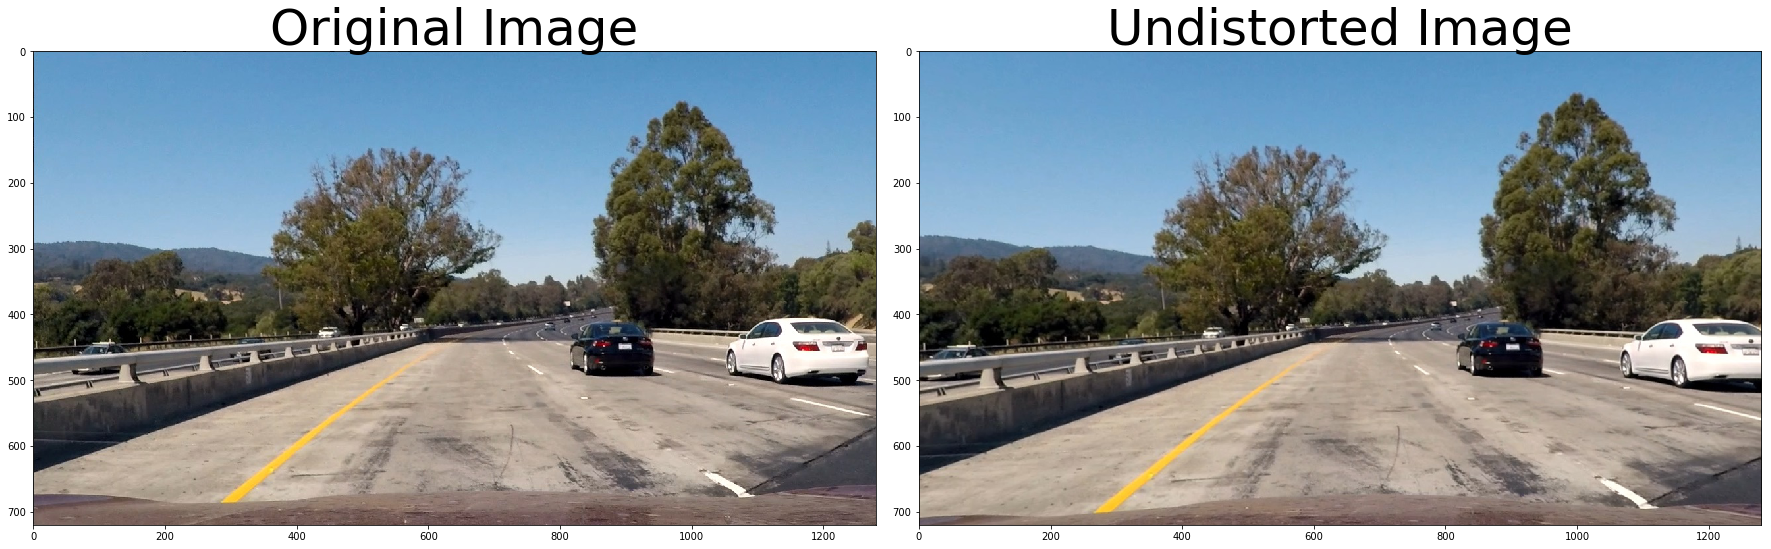

In [41]:
%matplotlib inline

# Read in an image
img = mpimg.imread('D:\\xufq\\SD\\CarND-Advanced-Lane-Lines\\test_images\\test1.jpg')
#img = mpimg.imread('D:\\xufq\\SD\\CarND-Advanced-Lane-Lines\\camera_cal\\calibration1.jpg')

# performs the camera calibration, image distortion correction and returns the undistorted image
# Use cv2.calibrateCamera and cv2.undistort()
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(gray, cmap='gray')
plt.subplot(133)
plt.imshow(undist, cmap='gray')
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('./output_images/' + 'test1_original.jpg' ,img)
cv2.imwrite('./output_images/' + 'test1_undistorted.jpg' ,img)
#cv2.imwrite('./output_images/' + 'calibration1_original.jpg' ,img)
#cv2.imwrite('./output_images/' + 'calibration1_undistorted.jpg' ,img)

## Use color transforms, gradients, etc., to create a thresholded binary image

True

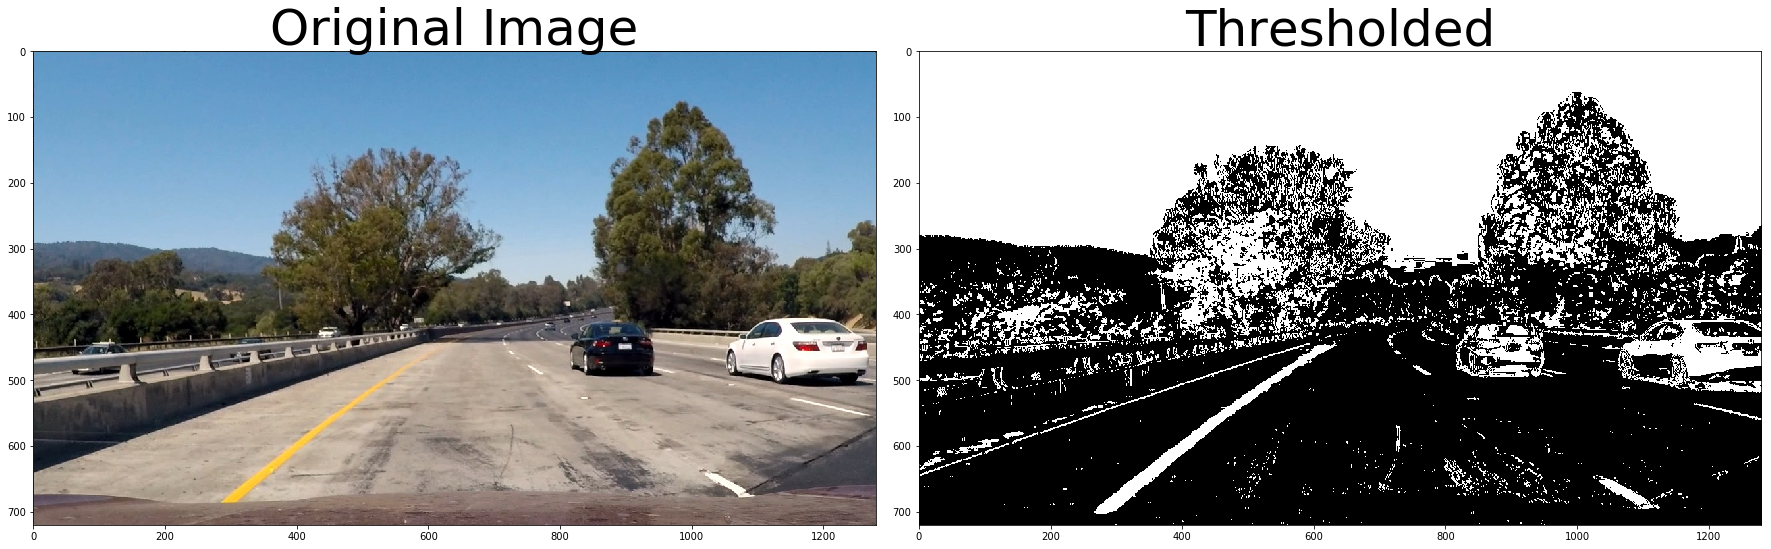

In [38]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    grab_output = sxbinary
    # 6) Return this mask as your binary_output image
    return grab_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_output = np.zeros_like(gradmag)
    mag_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_output =  np.zeros_like(absgraddir)
    dir_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_output
    
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_thresh(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output
    
hls_binary = hls_select(undist, thresh=(90, 255))

# Edit this function to create your own pipeline.
def binary_transf(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSL color space and separate the S channel
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsl[:,:,1]
    s_channel = hsl[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
threshold_img = binary_transf(undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(threshold_img, cmap='gray')
ax2.set_title('Thresholded', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('./output_images/' + 'test1_undistorted_thresholded.jpg' ,threshold_img)

## Apply a perspective transform to rectify binary image ("birds-eye view")

True

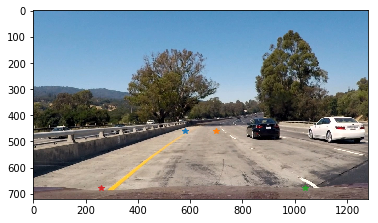

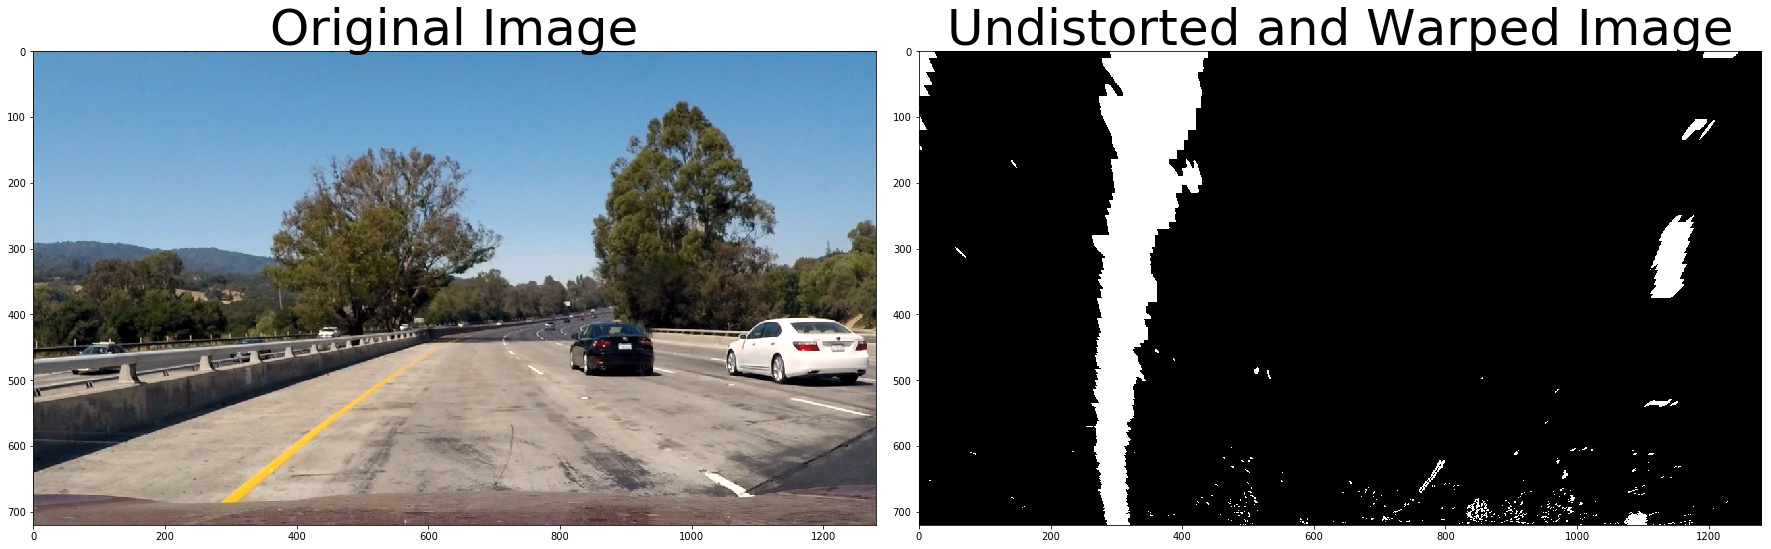

In [29]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


src = np.float32([
            [580, 460],
            [700, 460],
            [1040, 680],
            [260, 680],
        ])

dst = np.float32([
            [260, 0],
            [1040, 0],
            [1040, 720],
            [260, 720],
        ])

"""
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
"""

plt.imshow(img)
plt.plot(580,460,'*')
plt.plot(700,460,'*')
plt.plot(1040,680,'*')
plt.plot(260,680,'*')

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(threshold_img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('./output_images/' + 'test1_warped.jpg' ,top_down)

## Detect lane pixels and fit to find the lane boundary

True

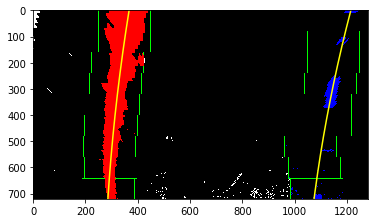

In [30]:
def detect_lane_slidingwindow(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fit, right_fit, out_img

left_fit, right_fit, out_img = detect_lane_slidingwindow(top_down)
cv2.imwrite('./output_images/' + 'test1_detect_slidingwindows.jpg' ,out_img)

True

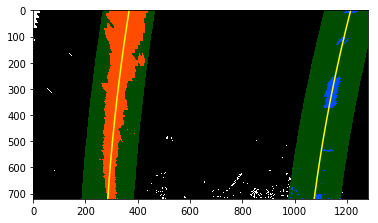

In [31]:
# Detect lane based on left_fit, right_fit which are provided by sliding windows methods 
def detect_lane(top_down, left_fit, right_fit):
    
    binary_warped = top_down
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fit, right_fit, result

left_fit, right_fit, out_img = detect_lane(top_down, left_fit, right_fit)
cv2.imwrite('./output_images/' + 'test1_detect.jpg' ,out_img)

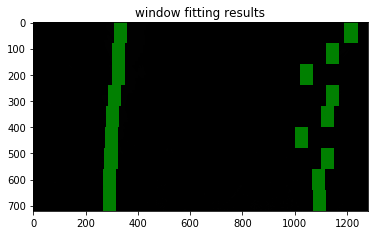

True

In [32]:
# Another way to approach the sliding window method is to apply a convolution, which will maximize the number of "hot" pixels in each window.
# Window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
warped = top_down

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 

    # If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
cv2.imwrite('./output_images/' + 'test1_detect_convolution.jpg' ,output)

## Determine the curvature of the lane and vehicle position with respect to center

In [33]:
def radius_position(binary_warped, left_fit, right_fit):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm', center, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad, center

left_curverad, right_curverad, center = radius_position(top_down, left_fit, right_fit)

2598.27409897 m 1890.3401319 m 0.21300762819 m


## Warp the detected lane boundaries back onto the original image

True

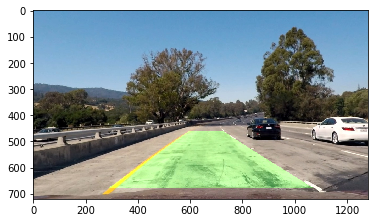

In [35]:
Minv = cv2.getPerspectiveTransform(dst, src)
binary_warped = top_down

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
cv2.imwrite('./output_images/' + 'test1_wraped_back.jpg' ,result)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

True

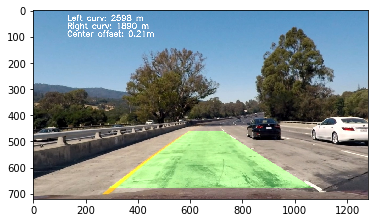

In [37]:
#Write curvature and center in image
TextL = "Left curv: " + str(int(left_curverad)) + " m"
TextR = "Right curv: " + str(int(right_curverad))+ " m"
TextC = "Center offset: " + str(round( center,2)) + "m"

fontScale=1
thickness=2
    
fontFace = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(result, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
cv2.putText(result, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
cv2.putText(result, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
plt.imshow(result)
cv2.imwrite('./output_images/' + 'test1_wraped_back_txt.jpg' ,result)

## My software pipeline to identify the lane boundaries in a video from a front-facing camera on a car

C:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


False
24892.2681218 m 3734.78521132 m 0.0853556968613 m
-6.59751521158e-06 4.39728716882e-05


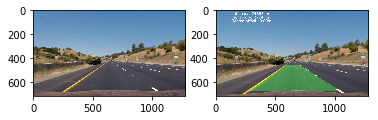

False
4291.43164354 m 30500.3651488 m 0.104698566352 m


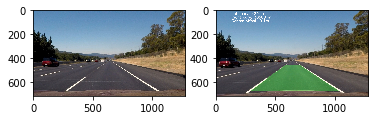

True
3463.65662477 m 1210.04692948 m 0.131258217318 m


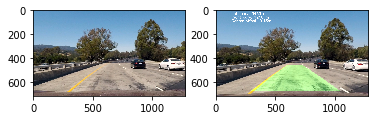

True
847.78542146 m 283.188192361 m 0.32019038374 m


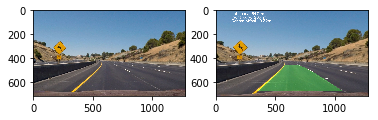

True
5102.68407918 m 615.301742359 m 0.230569716344 m
-3.2216431789e-05 0.000266918847295


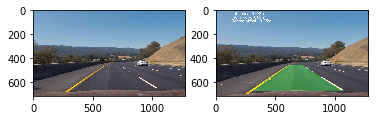

False
1490.47240969 m 79.4549592338 m 0.416672330328 m
0.000110184565311 -0.00207482478036


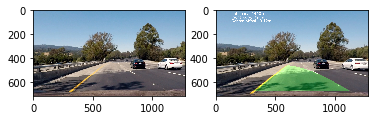

False
366.012098345 m 902.800837559 m 0.112632824001 m
0.000448953639737 -0.00018200878846


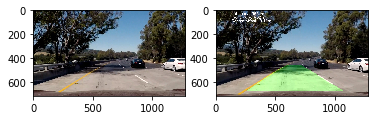

False
1119.29996058 m 800.067902682 m 0.368587576237 m


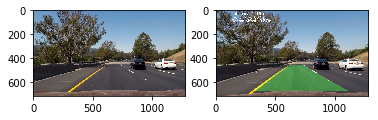

In [16]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]
    
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Given src and dst points, calculate the perspective transform matrix
src = np.float32([
            [580, 460],
            [700, 460],
            [1040, 680],
            [260, 680],
        ])

dst = np.float32([
            [260, 0],
            [1040, 0],
            [1040, 720],
            [260, 720],
        ])

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # lists of left_fit
        self.left_fits = []
        # lists of right_fit
        self.right_fits = []
    
    # To check left_fit and right_fit empty or possbile not parallel 
    # This sanity is very simple and limited 
    def sanity(self, left, right):
        if len(left) == 0 or len(right) == 0:
            return False
        elif left[0]*right[0] < 0:
            print(left[0], right[0])
            return False
        else:
            return True
     
    # Transform images with HSL and gradient threshold.
    def binary_transf(self, img, s_thresh=(90, 255), sx_thresh=(20, 100)):
        img = np.copy(img)
        # Convert to HSL color space and separate the S channel
        hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsl[:,:,1]
        s_channel = hsl[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
        # be beneficial to replace this channel with something else.
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        return combined_binary
    
    # To get curvature and center distance information 
    def radius_position(self, binary_warped, left_fit, right_fit):
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center, 'm')
        # Example values: 632.1 m    626.2 m
    
        return left_curverad, right_curverad, center
    
    # To detect lane by sliding window
    def detect_lane_slidingwindow(self, binary_warped):

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        return left_fit, right_fit, out_img
    
    # Detect lane based on left_fit, right_fit which are provided by sliding windows methods 
    def detect_lane(self, binary_warped, left_fit, right_fit):

        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        return left_fit, right_fit, result
    
    # This below pipeline code is integreated and process images
    # Some fuctions usded are from above and will be commented 
    def process_image(self, image):
        # NOTE: The output you return should be a color image (3 channel) for processing video below
        # TODO: put your pipeline here,
        # you should return the final output (image where lines are drawn on lanes)
   
        # performs the camera calibration, image distortion correction and returns the undistorted image
        # Use cv2.calibrateCamera and cv2.undistort()
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        img_size = (image.shape[1], image.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        undist = cv2.undistort(image, mtx, dist, None, mtx)
    
        # Color transforms, gradients, etc., to create a thresholded binary image
        # Fuction codes are above  
        threshold_image = self.binary_transf(undist)
    
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(threshold_image, M, img_size)
        binary_warped = warped
        
        # self.detected is used here to decicde to detect by slidingwindow or not 
        if self.detected == False:
            left_fit, right_fit, out_img = self.detect_lane_slidingwindow(warped)
            left_fit, right_fit, out_img = self.detect_lane(warped, left_fit, right_fit)
        else:
            # use last detect left_fit and right_fit to detect 
            left_fit, right_fit, out_img = self.detect_lane(warped, self.left_fits[-1], self.right_fits[-1])
         
        print(self.detected)
        # radius and center offset 
        left_curverad, right_curverad, center = self.radius_position(binary_warped, left_fit, right_fit)   
        
        # To Check detect
        if self.sanity(left_fit, right_fit):
            self.detected = True
            self.left_fits.append(left_fit)
            self.right_fits.append(right_fit)
        else:
            self.detected = False
        
        # To use last 5 average left_fit and right_fit to draw 
        if len(self.left_fits) <= 6:
            draw_left_fit = left_fit
            draw_right_fit = right_fit
        else:
            draw_left_fit = np.mean(np.array(self.left_fits[-5:]), axis=0)
            draw_right_fit = np.mean(np.array(self.right_fits[-5:]), axis=0)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = draw_left_fit[0]*ploty**2 + draw_left_fit[1]*ploty + draw_left_fit[2]
        right_fitx = draw_right_fit[0]*ploty**2 + draw_right_fit[1]*ploty + draw_right_fit[2]
    
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
        #Write curvature and center in image
        TextL = "Left curv: " + str(int(left_curverad)) + " m"
        TextR = "Right curv: " + str(int(right_curverad))+ " m"
        TextC = "Center offset: " + str(round( center,2)) + "m"

        fontScale=1
        thickness=2
    
        fontFace = cv2.FONT_HERSHEY_SIMPLEX

        cv2.putText(result, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
        cv2.putText(result, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
        cv2.putText(result, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
        return result

# To test these above codes with these images in test_images folders
images = glob.glob('test_images/*.jpg')
project = Line()
for img in images:
    
    # Read in an image
    img = mpimg.imread(img)
    img_out = project.process_image(img)
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(img_out, cmap='gray')
    plt.show()

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video1_output = './out_project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
p1 = Line()
video1_clip = clip1.fl_image(p1.process_image) #NOTE: this function expects color images!!
%time video1_clip.write_videofile(video1_output, audio=False)

False
546.885654446 m 845.020728969 m 0.450411649469 m
[MoviePy] >>>> Building video ./out_project_video.mp4
[MoviePy] Writing video ./out_project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

True
548.968271149 m 845.020728969 m 0.45064394585 m


  0%|                                                                                 | 1/1261 [00:00<18:44,  1.12it/s]

True
549.178745517 m 890.713927453 m 0.456912075572 m


  0%|▏                                                                                | 2/1261 [00:01<18:59,  1.11it/s]

True
549.787847836 m 531.117875159 m 0.442124414581 m


  0%|▏                                                                                | 3/1261 [00:02<18:53,  1.11it/s]

True
592.967018394 m 503.509775016 m 0.457004961669 m


  0%|▎                                                                                | 4/1261 [00:03<18:44,  1.12it/s]

True
579.305115907 m 577.882303351 m 0.465088377939 m


  0%|▎                                                                                | 5/1261 [00:04<18:59,  1.10it/s]

True
583.87190733 m 800.393431845 m 0.479023166013 m


  0%|▍                                                                                | 6/1261 [00:05<18:51,  1.11it/s]

True
597.585271134 m 868.981142917 m 0.489720165683 m


  1%|▍                                                                                | 7/1261 [00:06<18:48,  1.11it/s]

True
579.934292564 m 3888.59067486 m 0.580464899531 m
-0.000283181620628 4.23206845026e-05


  1%|▌                                                                                | 8/1261 [00:07<19:06,  1.09it/s]

False
609.297336553 m 2200.2185159 m 0.593714499756 m
-0.000269536799579 7.48209301378e-05


  1%|▌                                                                                | 9/1261 [00:08<19:07,  1.09it/s]

False
612.345813433 m 10063.9231409 m 0.556554038821 m
-0.000268195957357 1.63439864223e-05


  1%|▋                                                                               | 10/1261 [00:09<19:47,  1.05it/s]

False
650.88556729 m 1393.16354968 m 0.513214564514 m


  1%|▋                                                                               | 11/1261 [00:10<19:59,  1.04it/s]

True
681.5148157 m 2012.30014691 m 0.513622890064 m


  1%|▊                                                                               | 12/1261 [00:11<19:36,  1.06it/s]

True
745.498429053 m 1610.47390332 m 0.50906822748 m


  1%|▊                                                                               | 13/1261 [00:11<19:18,  1.08it/s]

True
811.818581502 m 3115.9218374 m 0.513756738681 m


  1%|▉                                                                               | 14/1261 [00:12<18:55,  1.10it/s]

True
892.097319453 m 654.941251726 m 0.474928773423 m


  1%|▉                                                                               | 15/1261 [00:13<18:49,  1.10it/s]

True
1117.32565712 m 565.282552273 m 0.468064570484 m


  1%|█                                                                               | 16/1261 [00:14<19:09,  1.08it/s]

True
950.310166404 m 787.939594217 m 0.467741588258 m


  1%|█                                                                               | 17/1261 [00:15<19:39,  1.05it/s]

True
1060.99281981 m 947.390940157 m 0.467507019085 m


  1%|█▏                                                                              | 18/1261 [00:16<19:51,  1.04it/s]

True
1045.81541393 m 1159.62664656 m 0.467782284271 m


  2%|█▏                                                                              | 19/1261 [00:17<19:21,  1.07it/s]

True
1112.73768137 m 1283.14632796 m 0.46808520941 m


  2%|█▎                                                                              | 20/1261 [00:18<19:23,  1.07it/s]

True
1180.43475405 m 2489.8846843 m 0.490759761873 m


  2%|█▎                                                                              | 21/1261 [00:19<19:01,  1.09it/s]

True
1122.1071826 m 7453.32222735 m 0.497979040503 m


  2%|█▍                                                                              | 22/1261 [00:20<19:45,  1.05it/s]

True
1096.66305679 m 4967.54957504 m 0.472422409151 m


  2%|█▍                                                                              | 23/1261 [00:21<20:24,  1.01it/s]

True
995.834233106 m 992.397719029 m 0.419400144244 m


  2%|█▌                                                                              | 24/1261 [00:22<20:11,  1.02it/s]

True
813.33995843 m 736.339869566 m 0.398997116874 m


  2%|█▌                                                                              | 25/1261 [00:23<20:10,  1.02it/s]

True
894.914307387 m 919.650702882 m 0.405520398689 m


  2%|█▋                                                                              | 26/1261 [00:24<20:24,  1.01it/s]

True
781.242701912 m 1126.04705213 m 0.403667792129 m


  2%|█▋                                                                              | 27/1261 [00:25<19:42,  1.04it/s]

True
802.976440213 m 1373.33491995 m 0.402932224879 m


  2%|█▊                                                                              | 28/1261 [00:26<19:14,  1.07it/s]

True
819.517313507 m 782.861928505 m 0.394198149539 m


  2%|█▊                                                                              | 29/1261 [00:27<18:44,  1.10it/s]

True
750.858301713 m 519.591770175 m 0.384884969666 m


  2%|█▉                                                                              | 30/1261 [00:27<18:22,  1.12it/s]

True
651.531729204 m 606.411646823 m 0.389361281212 m


  2%|█▉                                                                              | 31/1261 [00:28<18:28,  1.11it/s]

True
606.760691702 m 766.446171608 m 0.396151641461 m


  3%|██                                                                              | 32/1261 [00:30<20:40,  1.01s/it]

True
588.547642149 m 2159.17880362 m 0.456087324927 m


  3%|██                                                                              | 33/1261 [00:31<19:48,  1.03it/s]

True
540.463258297 m 12979.9066307 m 0.480303769502 m


  3%|██▏                                                                             | 34/1261 [00:31<19:25,  1.05it/s]

True
516.428914099 m 2329.50500927 m 0.449625146577 m


  3%|██▏                                                                             | 35/1261 [00:32<18:58,  1.08it/s]

True
502.221288099 m 616.575557258 m 0.388238929303 m


  3%|██▎                                                                             | 36/1261 [00:33<18:30,  1.10it/s]

True
479.20296651 m 762.663511321 m 0.402407328391 m


  3%|██▎                                                                             | 37/1261 [00:34<18:16,  1.12it/s]

True
448.591933009 m 1326.24122901 m 0.423737330119 m


  3%|██▍                                                                             | 38/1261 [00:35<18:06,  1.13it/s]

True
430.980674977 m 468.957163705 m 0.372595141288 m


  3%|██▍                                                                             | 39/1261 [00:36<17:53,  1.14it/s]

True
437.814966764 m 439.453098308 m 0.377041469675 m


  3%|██▌                                                                             | 40/1261 [00:37<17:54,  1.14it/s]

True
446.760134894 m 486.659167385 m 0.391194739369 m


  3%|██▌                                                                             | 41/1261 [00:38<19:13,  1.06it/s]

True
451.952444651 m 484.28179137 m 0.404842148465 m


  3%|██▋                                                                             | 42/1261 [00:39<19:52,  1.02it/s]

True
459.312648918 m 540.198242624 m 0.416344693666 m


  3%|██▋                                                                             | 43/1261 [00:40<21:33,  1.06s/it]

True
473.771476504 m 584.992161916 m 0.421157370076 m


  3%|██▊                                                                             | 44/1261 [00:41<20:54,  1.03s/it]

True
505.453052687 m 727.600175412 m 0.439162279463 m


  4%|██▊                                                                             | 45/1261 [00:42<20:30,  1.01s/it]

True
512.358691568 m 1344.84921184 m 0.479915524506 m


  4%|██▉                                                                             | 46/1261 [00:43<19:26,  1.04it/s]

True
543.205536159 m 2581.06022191 m 0.498174392367 m


  4%|██▉                                                                             | 47/1261 [00:44<18:47,  1.08it/s]

True
549.617067529 m 1333.98911634 m 0.470543177568 m


  4%|███                                                                             | 48/1261 [00:45<18:26,  1.10it/s]

True
578.39226154 m 936.989010706 m 0.453692320072 m


  4%|███                                                                             | 49/1261 [00:45<18:06,  1.12it/s]

True
610.567296558 m 665.235111933 m 0.437381767626 m


  4%|███▏                                                                            | 50/1261 [00:46<18:07,  1.11it/s]

True
658.168500072 m 917.646712472 m 0.454063264232 m


  4%|███▏                                                                            | 51/1261 [00:47<17:52,  1.13it/s]

True
721.094769449 m 897.615541439 m 0.45013490604 m


  4%|███▎                                                                            | 52/1261 [00:48<17:49,  1.13it/s]

True
774.008128577 m 461.660587168 m 0.420200780323 m


  4%|███▎                                                                            | 53/1261 [00:49<17:38,  1.14it/s]

True
862.360950831 m 470.120150817 m 0.425599365038 m


  4%|███▍                                                                            | 54/1261 [00:50<17:36,  1.14it/s]

True
966.254045402 m 513.928321506 m 0.431128010839 m


  4%|███▍                                                                            | 55/1261 [00:51<17:31,  1.15it/s]

True
1002.86849404 m 588.168979881 m 0.431132537574 m


  4%|███▌                                                                            | 56/1261 [00:52<17:32,  1.15it/s]

True
1102.33330361 m 734.17967427 m 0.437893325512 m


  5%|███▌                                                                            | 57/1261 [00:52<17:31,  1.15it/s]

True
1080.94480315 m 1365.4200869 m 0.476932316528 m


  5%|███▋                                                                            | 58/1261 [00:53<17:22,  1.15it/s]

True
908.377662327 m 2651.45243394 m 0.481650658858 m


  5%|███▋                                                                            | 59/1261 [00:54<17:20,  1.16it/s]

True
839.610821951 m 959.688140739 m 0.419314015697 m


  5%|███▊                                                                            | 60/1261 [00:55<17:24,  1.15it/s]

True
778.52233581 m 1601.05408596 m 0.427423778137 m


  5%|███▊                                                                            | 61/1261 [00:56<17:21,  1.15it/s]

True
721.28384859 m 734.868772832 m 0.382819371782 m


  5%|███▉                                                                            | 62/1261 [00:57<17:09,  1.16it/s]

True
679.567601324 m 843.392853565 m 0.375026289625 m


  5%|███▉                                                                            | 63/1261 [00:58<17:07,  1.17it/s]

True
660.115794271 m 553.854590991 m 0.348167051404 m


  5%|████                                                                            | 64/1261 [00:58<17:09,  1.16it/s]

True
714.885128345 m 569.794593027 m 0.342672027094 m


  5%|████                                                                            | 65/1261 [00:59<17:13,  1.16it/s]

True
635.859606736 m 750.504874069 m 0.346201570843 m


  5%|████▏                                                                           | 66/1261 [01:00<17:14,  1.15it/s]

True
661.150660079 m 830.915934252 m 0.341866464752 m


  5%|████▎                                                                           | 67/1261 [01:01<17:10,  1.16it/s]

True
710.38496754 m 942.767205934 m 0.339177486176 m


  5%|████▎                                                                           | 68/1261 [01:02<17:12,  1.16it/s]

True
676.503852807 m 1352.05841463 m 0.338738843934 m


  5%|████▍                                                                           | 69/1261 [01:03<17:16,  1.15it/s]

True
685.510699641 m 1915.1409718 m 0.349103360442 m


  6%|████▍                                                                           | 70/1261 [01:04<17:11,  1.15it/s]

True
710.557303773 m 1054.49104298 m 0.327456332604 m


  6%|████▌                                                                           | 71/1261 [01:05<17:26,  1.14it/s]

True
804.481148527 m 661.172045155 m 0.290168299012 m


  6%|████▌                                                                           | 72/1261 [01:05<17:24,  1.14it/s]

True
908.726725235 m 749.640611044 m 0.301108119625 m


  6%|████▋                                                                           | 73/1261 [01:06<17:20,  1.14it/s]

True
1060.92952979 m 847.263134578 m 0.308084978024 m


  6%|████▋                                                                           | 74/1261 [01:07<17:15,  1.15it/s]

True
1008.61796072 m 1028.41373923 m 0.311430301724 m


  6%|████▊                                                                           | 75/1261 [01:08<17:05,  1.16it/s]

True
1181.14992902 m 678.966668747 m 0.294258854301 m


  6%|████▊                                                                           | 76/1261 [01:09<17:10,  1.15it/s]

True
1429.67216966 m 763.394470159 m 0.297909482887 m


  6%|████▉                                                                           | 77/1261 [01:10<17:18,  1.14it/s]

True
1535.87329769 m 659.822406757 m 0.291753238527 m


  6%|████▉                                                                           | 78/1261 [01:11<17:11,  1.15it/s]

True
1689.35135599 m 509.437320922 m 0.281255238339 m


  6%|█████                                                                           | 79/1261 [01:11<17:10,  1.15it/s]

True
2215.95132788 m 491.958607521 m 0.280041199707 m


  6%|█████                                                                           | 80/1261 [01:12<17:07,  1.15it/s]

True
1982.3236649 m 618.575379071 m 0.277649648683 m


  6%|█████▏                                                                          | 81/1261 [01:13<17:02,  1.15it/s]

True
1921.15086623 m 689.652789271 m 0.271341227544 m


  7%|█████▏                                                                          | 82/1261 [01:14<17:02,  1.15it/s]

True
1634.58238245 m 1090.77144294 m 0.299560968755 m


  7%|█████▎                                                                          | 83/1261 [01:15<16:59,  1.16it/s]

True
1543.92697038 m 2066.49297563 m 0.318571476681 m


  7%|█████▎                                                                          | 84/1261 [01:16<16:53,  1.16it/s]

True
1377.15557744 m 5036.16578863 m 0.320928963726 m


  7%|█████▍                                                                          | 85/1261 [01:17<16:48,  1.17it/s]

True
1183.51931574 m 4468.77546149 m 0.306998534773 m


  7%|█████▍                                                                          | 86/1261 [01:18<19:15,  1.02it/s]

True
865.698398674 m 944.986304394 m 0.252110083118 m


  7%|█████▌                                                                          | 87/1261 [01:19<20:22,  1.04s/it]

True
758.587148109 m 2185.55370891 m 0.268961058233 m


  7%|█████▌                                                                          | 88/1261 [01:20<19:58,  1.02s/it]

True
666.696160625 m 859.496863877 m 0.23982052309 m


  7%|█████▋                                                                          | 89/1261 [01:21<19:34,  1.00s/it]

True
643.633442257 m 549.165840254 m 0.226400035627 m


  7%|█████▋                                                                          | 90/1261 [01:22<18:43,  1.04it/s]

True
667.673866732 m 598.197266887 m 0.232950104069 m


  7%|█████▊                                                                          | 91/1261 [01:23<18:12,  1.07it/s]

True
656.779255339 m 635.967217406 m 0.239661915015 m


  7%|█████▊                                                                          | 92/1261 [01:24<17:47,  1.10it/s]

True
661.806800231 m 775.061882659 m 0.249987086265 m


  7%|█████▉                                                                          | 93/1261 [01:24<17:24,  1.12it/s]

True
646.665786619 m 869.557074206 m 0.255661648471 m


  7%|█████▉                                                                          | 94/1261 [01:25<17:15,  1.13it/s]

True
649.999107012 m 1100.93571071 m 0.259922455739 m


  8%|██████                                                                          | 95/1261 [01:26<16:59,  1.14it/s]

True
650.46774682 m 1656.95662799 m 0.287663034906 m


  8%|██████                                                                          | 96/1261 [01:27<16:55,  1.15it/s]

True
663.548448268 m 2495.02980465 m 0.297592059029 m


  8%|██████▏                                                                         | 97/1261 [01:28<16:47,  1.16it/s]

True
667.353173746 m 771.476094588 m 0.244247125876 m


  8%|██████▏                                                                         | 98/1261 [01:29<16:48,  1.15it/s]

True
684.452658421 m 781.479862455 m 0.252270358278 m


  8%|██████▎                                                                         | 99/1261 [01:30<16:56,  1.14it/s]

True
690.705273834 m 963.016755489 m 0.260354643759 m


  8%|██████▎                                                                        | 100/1261 [01:31<16:54,  1.14it/s]

True
652.95380102 m 912.205302731 m 0.261280385053 m


  8%|██████▎                                                                        | 101/1261 [01:31<16:46,  1.15it/s]

True
676.404939941 m 633.721108813 m 0.247458847655 m


  8%|██████▍                                                                        | 102/1261 [01:32<16:41,  1.16it/s]

True
695.078492621 m 471.868909943 m 0.243749913576 m


  8%|██████▍                                                                        | 103/1261 [01:33<16:40,  1.16it/s]

True
701.776033458 m 534.537932777 m 0.258155998771 m


  8%|██████▌                                                                        | 104/1261 [01:34<16:38,  1.16it/s]

True
711.742471563 m 580.941528416 m 0.270618532457 m


  8%|██████▌                                                                        | 105/1261 [01:35<16:50,  1.14it/s]

True
778.336997372 m 607.08242266 m 0.282315883108 m


  8%|██████▋                                                                        | 106/1261 [01:36<16:50,  1.14it/s]

True
721.900925764 m 640.410528628 m 0.290488152283 m


  8%|██████▋                                                                        | 107/1261 [01:37<16:42,  1.15it/s]

True
669.756036296 m 800.974337655 m 0.310342536643 m


  9%|██████▊                                                                        | 108/1261 [01:37<16:38,  1.16it/s]

True
667.86886101 m 1862.93326851 m 0.358530820509 m


  9%|██████▊                                                                        | 109/1261 [01:38<16:37,  1.16it/s]

True
667.847596896 m 8193.48654378 m 0.383617933892 m


  9%|██████▉                                                                        | 110/1261 [01:39<16:36,  1.16it/s]

True
625.743359455 m 1569.31101056 m 0.347904762265 m


  9%|██████▉                                                                        | 111/1261 [01:40<16:41,  1.15it/s]

True
656.181253528 m 988.685202846 m 0.333428320448 m


  9%|███████                                                                        | 112/1261 [01:41<16:42,  1.15it/s]

True
601.691794036 m 580.641601324 m 0.303813091736 m


  9%|███████                                                                        | 113/1261 [01:42<16:37,  1.15it/s]

True
610.305367597 m 675.249735807 m 0.322085540553 m


  9%|███████▏                                                                       | 114/1261 [01:43<16:35,  1.15it/s]

True
539.731877413 m 492.012479299 m 0.310439356 m


  9%|███████▏                                                                       | 115/1261 [01:44<16:34,  1.15it/s]

True
594.650745647 m 432.264269924 m 0.315410061314 m


  9%|███████▎                                                                       | 116/1261 [01:44<16:33,  1.15it/s]

True
551.757196565 m 465.411057187 m 0.323178410021 m


  9%|███████▎                                                                       | 117/1261 [01:45<16:38,  1.15it/s]

True
564.710364627 m 514.212082831 m 0.336688873194 m


  9%|███████▍                                                                       | 118/1261 [01:46<16:31,  1.15it/s]

True
560.938048199 m 561.333880424 m 0.34653681307 m


  9%|███████▍                                                                       | 119/1261 [01:47<16:20,  1.16it/s]

True
528.491466037 m 627.297242526 m 0.360966062549 m


 10%|███████▌                                                                       | 120/1261 [01:48<16:19,  1.16it/s]

True
550.134101636 m 1002.18426297 m 0.41843302593 m


 10%|███████▌                                                                       | 121/1261 [01:49<16:21,  1.16it/s]

True
543.58772575 m 666.775180918 m 0.388624638485 m


 10%|███████▋                                                                       | 122/1261 [01:50<16:27,  1.15it/s]

True
519.731854607 m 564.202082356 m 0.372446584354 m


 10%|███████▋                                                                       | 123/1261 [01:50<16:29,  1.15it/s]

True
510.760598632 m 1063.22805519 m 0.416423045063 m


 10%|███████▊                                                                       | 124/1261 [01:51<16:25,  1.15it/s]

True
504.126143846 m 665.110331424 m 0.394292930549 m


 10%|███████▊                                                                       | 125/1261 [01:52<16:15,  1.16it/s]

True
545.48508137 m 1056.00329486 m 0.420907015638 m


 10%|███████▉                                                                       | 126/1261 [01:53<16:17,  1.16it/s]

True
525.60662587 m 450.502595209 m 0.383543916897 m


 10%|███████▉                                                                       | 127/1261 [01:54<16:16,  1.16it/s]

True
559.161584095 m 457.203627292 m 0.392806166791 m


 10%|████████                                                                       | 128/1261 [01:55<16:10,  1.17it/s]

True
545.538345547 m 457.066013965 m 0.399462672222 m


 10%|████████                                                                       | 129/1261 [01:56<16:04,  1.17it/s]

True
592.893971998 m 528.993398033 m 0.410053678233 m


 10%|████████▏                                                                      | 130/1261 [01:56<16:05,  1.17it/s]

True
634.781477606 m 618.664578953 m 0.4208079771 m


 10%|████████▏                                                                      | 131/1261 [01:57<16:13,  1.16it/s]

True
623.316975104 m 649.257904096 m 0.42629253656 m


 10%|████████▎                                                                      | 132/1261 [01:58<16:11,  1.16it/s]

True
660.687255454 m 737.947390677 m 0.44197203197 m


 11%|████████▎                                                                      | 133/1261 [01:59<16:11,  1.16it/s]

True
678.633297855 m 643.078720746 m 0.440605555869 m


 11%|████████▍                                                                      | 134/1261 [02:00<16:12,  1.16it/s]

True
654.871962286 m 577.339954163 m 0.430050996103 m


 11%|████████▍                                                                      | 135/1261 [02:01<16:05,  1.17it/s]

True
700.466543793 m 742.567905349 m 0.451787817731 m


 11%|████████▌                                                                      | 136/1261 [02:02<16:05,  1.17it/s]

True
688.254228683 m 1023.50744072 m 0.469379501395 m


 11%|████████▌                                                                      | 137/1261 [02:02<16:11,  1.16it/s]

True
711.300271091 m 1409.99947891 m 0.474563454558 m


 11%|████████▋                                                                      | 138/1261 [02:03<16:08,  1.16it/s]

True
716.867467481 m 1872.39262504 m 0.476379240267 m


 11%|████████▋                                                                      | 139/1261 [02:04<16:10,  1.16it/s]

True
751.907676068 m 1509.853362 m 0.46402750393 m


 11%|████████▊                                                                      | 140/1261 [02:05<16:10,  1.15it/s]

True
749.664077049 m 684.313703219 m 0.439373267224 m


 11%|████████▊                                                                      | 141/1261 [02:06<16:11,  1.15it/s]

True
773.806719057 m 581.165044361 m 0.432414331693 m


 11%|████████▉                                                                      | 142/1261 [02:07<16:16,  1.15it/s]

True
813.765442419 m 775.698751469 m 0.439206482334 m


 11%|████████▉                                                                      | 143/1261 [02:08<16:13,  1.15it/s]

True
795.521009891 m 896.629293029 m 0.433765929856 m


 11%|█████████                                                                      | 144/1261 [02:09<16:12,  1.15it/s]

True
824.208486989 m 1008.1456333 m 0.434846094395 m


 11%|█████████                                                                      | 145/1261 [02:10<16:27,  1.13it/s]

True
838.059965699 m 2317.3632311 m 0.472094350608 m


 12%|█████████▏                                                                     | 146/1261 [02:10<16:22,  1.14it/s]

True
824.788481967 m 2216.04161442 m 0.466680314584 m


 12%|█████████▏                                                                     | 147/1261 [02:11<16:14,  1.14it/s]

True
762.127845251 m 679.210541217 m 0.411055183498 m


 12%|█████████▎                                                                     | 148/1261 [02:12<17:00,  1.09it/s]

True
759.278848463 m 835.539660751 m 0.425579488976 m


 12%|█████████▎                                                                     | 149/1261 [02:13<16:40,  1.11it/s]

True
756.396607793 m 868.66288809 m 0.426488109933 m


 12%|█████████▍                                                                     | 150/1261 [02:14<16:28,  1.12it/s]

True
860.889909144 m 517.565428745 m 0.394446857612 m


 12%|█████████▍                                                                     | 151/1261 [02:15<16:20,  1.13it/s]

True
851.324179118 m 523.422246744 m 0.395108559429 m


 12%|█████████▌                                                                     | 152/1261 [02:16<16:09,  1.14it/s]

True
820.074014454 m 484.109346749 m 0.391602295626 m


 12%|█████████▌                                                                     | 153/1261 [02:17<16:04,  1.15it/s]

True
842.024210478 m 518.465883449 m 0.397574291902 m


 12%|█████████▋                                                                     | 154/1261 [02:17<16:03,  1.15it/s]

True
831.535925449 m 581.092078157 m 0.406323051897 m


 12%|█████████▋                                                                     | 155/1261 [02:18<16:42,  1.10it/s]

True
844.715272549 m 649.330264531 m 0.404407672427 m


 12%|█████████▊                                                                     | 156/1261 [02:19<17:36,  1.05it/s]

True
803.065578405 m 722.74891454 m 0.402144163672 m


 12%|█████████▊                                                                     | 157/1261 [02:20<17:43,  1.04it/s]

True
737.60519358 m 1019.77663852 m 0.405497853996 m


 13%|█████████▉                                                                     | 158/1261 [02:21<17:59,  1.02it/s]

True
713.688748384 m 5568.26985921 m 0.459519599833 m


 13%|█████████▉                                                                     | 159/1261 [02:23<19:31,  1.06s/it]

True
646.069573881 m 1293.90721674 m 0.407523684445 m


 13%|██████████                                                                     | 160/1261 [02:24<18:29,  1.01s/it]

True
651.680126221 m 996.982551311 m 0.395313058126 m


 13%|██████████                                                                     | 161/1261 [02:24<17:41,  1.04it/s]

True
653.85144834 m 1151.1218496 m 0.392052320069 m


 13%|██████████▏                                                                    | 162/1261 [02:25<17:33,  1.04it/s]

True
628.006924493 m 2831.33437564 m 0.404572482605 m


 13%|██████████▏                                                                    | 163/1261 [02:26<16:59,  1.08it/s]

True
639.850829503 m 3826.34262165 m 0.403947557199 m


 13%|██████████▎                                                                    | 164/1261 [02:27<16:41,  1.10it/s]

True
680.015616214 m 560.425879513 m 0.35422223843 m


 13%|██████████▎                                                                    | 165/1261 [02:28<16:26,  1.11it/s]

True
642.560343575 m 627.129875325 m 0.35416511489 m


 13%|██████████▍                                                                    | 166/1261 [02:29<16:15,  1.12it/s]

True
688.111960271 m 705.78592626 m 0.362479168549 m


 13%|██████████▍                                                                    | 167/1261 [02:30<16:08,  1.13it/s]

True
698.822141065 m 755.279317084 m 0.36310343154 m


 13%|██████████▌                                                                    | 168/1261 [02:31<16:02,  1.14it/s]

True
763.661657324 m 766.621105586 m 0.361873250576 m


 13%|██████████▌                                                                    | 169/1261 [02:32<16:08,  1.13it/s]

True
853.346319402 m 920.949443523 m 0.360857512024 m


 13%|██████████▋                                                                    | 170/1261 [02:33<16:42,  1.09it/s]

True
903.83916707 m 866.367882777 m 0.347099471231 m


 14%|██████████▋                                                                    | 171/1261 [02:34<17:27,  1.04it/s]

True
908.548492278 m 960.916881336 m 0.344852499316 m


 14%|██████████▊                                                                    | 172/1261 [02:35<17:21,  1.05it/s]

True
860.426371369 m 369.629007939 m 0.252195586295 m


 14%|██████████▊                                                                    | 173/1261 [02:36<19:04,  1.05s/it]

True
790.850497796 m 421.899541338 m 0.273263715527 m


 14%|██████████▉                                                                    | 174/1261 [02:37<18:07,  1.00s/it]

True
754.103402299 m 349.02576619 m 0.259008828693 m


 14%|██████████▉                                                                    | 175/1261 [02:38<17:21,  1.04it/s]

True
771.186286872 m 276.406697133 m 0.238079972101 m


 14%|███████████                                                                    | 176/1261 [02:38<16:52,  1.07it/s]

True
834.090431615 m 290.425899049 m 0.251695305246 m


 14%|███████████                                                                    | 177/1261 [02:39<16:33,  1.09it/s]

True
792.523248891 m 320.234160593 m 0.272426654435 m


 14%|███████████▏                                                                   | 178/1261 [02:40<16:48,  1.07it/s]

True
822.997124019 m 341.733029594 m 0.29179946443 m


 14%|███████████▏                                                                   | 179/1261 [02:41<17:13,  1.05it/s]

True
756.204537296 m 359.189825836 m 0.302462450664 m


 14%|███████████▎                                                                   | 180/1261 [02:42<16:40,  1.08it/s]

True
642.116181406 m 402.782079979 m 0.30776081667 m


 14%|███████████▎                                                                   | 181/1261 [02:43<17:28,  1.03it/s]

True
628.384368241 m 453.864529716 m 0.314607265086 m


 14%|███████████▍                                                                   | 182/1261 [02:44<18:23,  1.02s/it]

True
549.360373055 m 546.632229186 m 0.342834929195 m


 15%|███████████▍                                                                   | 183/1261 [02:45<17:34,  1.02it/s]

True
499.337106775 m 589.132282439 m 0.350892667039 m


 15%|███████████▌                                                                   | 184/1261 [02:46<17:24,  1.03it/s]

True
455.862159182 m 583.110231613 m 0.34300668467 m


 15%|███████████▌                                                                   | 185/1261 [02:47<16:43,  1.07it/s]

True
411.07596002 m 355.87638173 m 0.287978409257 m


 15%|███████████▋                                                                   | 186/1261 [02:48<17:00,  1.05it/s]

True
401.277884324 m 343.484287562 m 0.289980986048 m


 15%|███████████▋                                                                   | 187/1261 [02:49<17:14,  1.04it/s]

True
408.059813275 m 391.730690863 m 0.314230562395 m


 15%|███████████▊                                                                   | 188/1261 [02:50<16:42,  1.07it/s]

True
408.314141651 m 435.289354185 m 0.328995917701 m


 15%|███████████▊                                                                   | 189/1261 [02:51<16:11,  1.10it/s]

True
422.061016138 m 486.816333476 m 0.345303340015 m


 15%|███████████▉                                                                   | 190/1261 [02:52<16:30,  1.08it/s]

True
424.135486387 m 583.041689247 m 0.358038462597 m


 15%|███████████▉                                                                   | 191/1261 [02:53<16:09,  1.10it/s]

True
463.977307546 m 565.88578601 m 0.369709210706 m


 15%|████████████                                                                   | 192/1261 [02:53<15:49,  1.13it/s]

True
470.143984544 m 546.600221497 m 0.376569334689 m


 15%|████████████                                                                   | 193/1261 [02:54<16:51,  1.06it/s]

True
498.488883046 m 503.297948761 m 0.374818213434 m


 15%|████████████▏                                                                  | 194/1261 [02:55<17:05,  1.04it/s]

True
504.286514875 m 469.277365102 m 0.366637548209 m


 15%|████████████▏                                                                  | 195/1261 [02:56<17:02,  1.04it/s]

True
574.82696193 m 641.433205681 m 0.381906405118 m


 16%|████████████▎                                                                  | 196/1261 [02:58<17:38,  1.01it/s]

True
608.865825566 m 1864.96009618 m 0.436718889333 m


 16%|████████████▎                                                                  | 197/1261 [02:59<18:07,  1.02s/it]

True
680.266859645 m 2077.89176111 m 0.424904374337 m


 16%|████████████▍                                                                  | 198/1261 [03:00<17:36,  1.01it/s]

True
718.225656467 m 1907.31559157 m 0.415041047016 m


 16%|████████████▍                                                                  | 199/1261 [03:00<16:44,  1.06it/s]

True
721.967444769 m 1146.269516 m 0.39028795997 m


 16%|████████████▌                                                                  | 200/1261 [03:01<16:35,  1.07it/s]

True
821.700172921 m 681.060614762 m 0.361883921632 m


 16%|████████████▌                                                                  | 201/1261 [03:02<17:27,  1.01it/s]

True
816.761647412 m 1123.08230927 m 0.372087824517 m


 16%|████████████▋                                                                  | 202/1261 [03:03<17:03,  1.03it/s]

True
771.189930025 m 709.972100029 m 0.347152641242 m


 16%|████████████▋                                                                  | 203/1261 [03:04<16:42,  1.06it/s]

True
790.824509521 m 497.623995895 m 0.341449622611 m


 16%|████████████▊                                                                  | 204/1261 [03:05<16:35,  1.06it/s]

True
726.869151216 m 521.318086615 m 0.336508511544 m


 16%|████████████▊                                                                  | 205/1261 [03:06<16:59,  1.04it/s]

True
685.147188307 m 589.809999644 m 0.339167093769 m


 16%|████████████▉                                                                  | 206/1261 [03:07<16:42,  1.05it/s]

True
592.076558322 m 651.343643877 m 0.344638758383 m


 16%|████████████▉                                                                  | 207/1261 [03:08<16:27,  1.07it/s]

True
560.10272462 m 616.676756983 m 0.335228950889 m


 16%|█████████████                                                                  | 208/1261 [03:09<16:12,  1.08it/s]

True
569.870364854 m 603.430004772 m 0.337899580188 m


 17%|█████████████                                                                  | 209/1261 [03:10<15:51,  1.11it/s]

True
574.677266989 m 490.220944398 m 0.315403369552 m


 17%|█████████████▏                                                                 | 210/1261 [03:11<15:59,  1.09it/s]

True
596.983302739 m 596.841859188 m 0.330411458157 m


 17%|█████████████▏                                                                 | 211/1261 [03:12<15:39,  1.12it/s]

True
538.849498544 m 629.845963613 m 0.332325844569 m


 17%|█████████████▎                                                                 | 212/1261 [03:12<15:24,  1.13it/s]

True
539.66032177 m 972.359163706 m 0.352087574924 m


 17%|█████████████▎                                                                 | 213/1261 [03:13<15:23,  1.13it/s]

True
522.459253491 m 985.257366511 m 0.344467978059 m


 17%|█████████████▍                                                                 | 214/1261 [03:14<15:13,  1.15it/s]

True
518.556180078 m 487.68394394 m 0.307876956816 m


 17%|█████████████▍                                                                 | 215/1261 [03:15<15:03,  1.16it/s]

True
527.531046886 m 520.393610814 m 0.310297536011 m


 17%|█████████████▌                                                                 | 216/1261 [03:16<15:00,  1.16it/s]

True
537.711726819 m 614.873294691 m 0.311228291363 m


 17%|█████████████▌                                                                 | 217/1261 [03:17<14:55,  1.17it/s]

True
560.49027104 m 679.764648091 m 0.307381703695 m


 17%|█████████████▋                                                                 | 218/1261 [03:18<16:09,  1.08it/s]

True
554.173556109 m 881.638171322 m 0.310987671693 m


 17%|█████████████▋                                                                 | 219/1261 [03:19<16:42,  1.04it/s]

True
611.875970577 m 1633.87220005 m 0.335383683382 m


 17%|█████████████▊                                                                 | 220/1261 [03:20<16:21,  1.06it/s]

True
642.734799696 m 9760.39740147 m 0.369758543047 m


 18%|█████████████▊                                                                 | 221/1261 [03:21<15:54,  1.09it/s]

True
661.076298417 m 4410.27339737 m 0.348703912312 m


 18%|█████████████▉                                                                 | 222/1261 [03:21<15:35,  1.11it/s]

True
683.291001187 m 1038.49490701 m 0.308082640676 m


 18%|█████████████▉                                                                 | 223/1261 [03:22<15:21,  1.13it/s]

True
675.030474773 m 1326.17705514 m 0.314161993011 m


 18%|██████████████                                                                 | 224/1261 [03:23<15:08,  1.14it/s]

True
682.783691709 m 2032.06268058 m 0.315864275706 m


 18%|██████████████                                                                 | 225/1261 [03:24<15:01,  1.15it/s]

True
725.390475059 m 570.373007152 m 0.269800208041 m


 18%|██████████████▏                                                                | 226/1261 [03:25<15:57,  1.08it/s]

True
713.413309416 m 551.416140148 m 0.263408208842 m


 18%|██████████████▏                                                                | 227/1261 [03:26<16:40,  1.03it/s]

True
736.505392766 m 584.453505678 m 0.261546196044 m


 18%|██████████████▎                                                                | 228/1261 [03:27<16:43,  1.03it/s]

True
762.089122394 m 692.65787696 m 0.258040277986 m


 18%|██████████████▎                                                                | 229/1261 [03:28<17:07,  1.00it/s]

True
814.563431827 m 692.010719113 m 0.247920648801 m


 18%|██████████████▍                                                                | 230/1261 [03:29<16:44,  1.03it/s]

True
893.284358105 m 763.024639159 m 0.245265528629 m


 18%|██████████████▍                                                                | 231/1261 [03:30<16:07,  1.06it/s]

True
960.851336392 m 876.77975953 m 0.239122156 m


 18%|██████████████▌                                                                | 232/1261 [03:31<16:11,  1.06it/s]

True
911.373900436 m 1570.14956686 m 0.260832076465 m


 18%|██████████████▌                                                                | 233/1261 [03:32<16:01,  1.07it/s]

True
928.723981368 m 972.338943256 m 0.225299599651 m


 19%|██████████████▋                                                                | 234/1261 [03:33<15:46,  1.09it/s]

True
847.023558531 m 554.586647255 m 0.1737049007 m


 19%|██████████████▋                                                                | 235/1261 [03:34<15:27,  1.11it/s]

True
829.548255735 m 738.250752045 m 0.197296946097 m


 19%|██████████████▊                                                                | 236/1261 [03:34<15:17,  1.12it/s]

True
799.013320539 m 717.761137532 m 0.191040463905 m


 19%|██████████████▊                                                                | 237/1261 [03:35<15:34,  1.10it/s]

True
724.604870651 m 383.689513167 m 0.147317043648 m


 19%|██████████████▉                                                                | 238/1261 [03:36<15:23,  1.11it/s]

True
755.886270259 m 380.187160921 m 0.147968369959 m


 19%|██████████████▉                                                                | 239/1261 [03:37<15:16,  1.12it/s]

True
741.264179841 m 419.025136435 m 0.158437752064 m


 19%|███████████████                                                                | 240/1261 [03:38<15:31,  1.10it/s]

True
735.249912647 m 479.974569573 m 0.161197544052 m


 19%|███████████████                                                                | 241/1261 [03:39<15:23,  1.11it/s]

True
738.125496772 m 494.949527016 m 0.160339484455 m


 19%|███████████████▏                                                               | 242/1261 [03:40<15:11,  1.12it/s]

True
703.491800571 m 526.869890757 m 0.162604136354 m


 19%|███████████████▏                                                               | 243/1261 [03:41<15:10,  1.12it/s]

True
673.962308989 m 588.169672919 m 0.162327315235 m


 19%|███████████████▎                                                               | 244/1261 [03:42<15:23,  1.10it/s]

True
653.849623725 m 567.572107667 m 0.157340706494 m


 19%|███████████████▎                                                               | 245/1261 [03:43<15:32,  1.09it/s]

True
631.081330502 m 578.134326499 m 0.149151804845 m


 20%|███████████████▍                                                               | 246/1261 [03:43<15:28,  1.09it/s]

True
624.169403986 m 667.08692033 m 0.153983882803 m


 20%|███████████████▍                                                               | 247/1261 [03:45<16:00,  1.06it/s]

True
596.775972752 m 412.196390209 m 0.110822920139 m


 20%|███████████████▌                                                               | 248/1261 [03:45<15:48,  1.07it/s]

True
624.617979132 m 377.088252311 m 0.102642030343 m


 20%|███████████████▌                                                               | 249/1261 [03:46<15:40,  1.08it/s]

True
603.365112896 m 408.37837693 m 0.110499192412 m


 20%|███████████████▋                                                               | 250/1261 [03:47<15:37,  1.08it/s]

True
653.5832586 m 419.917763638 m 0.115996315347 m


 20%|███████████████▋                                                               | 251/1261 [03:48<15:38,  1.08it/s]

True
692.008894254 m 507.482497801 m 0.131002016685 m


 20%|███████████████▊                                                               | 252/1261 [03:49<15:40,  1.07it/s]

True
717.497251945 m 557.677718162 m 0.135155277191 m


 20%|███████████████▊                                                               | 253/1261 [03:50<15:41,  1.07it/s]

True
724.342651764 m 590.133101974 m 0.13717135013 m


 20%|███████████████▉                                                               | 254/1261 [03:51<15:42,  1.07it/s]

True
748.624303765 m 694.752755961 m 0.144229968165 m


 20%|███████████████▉                                                               | 255/1261 [03:52<15:53,  1.06it/s]

True
695.370149027 m 684.884525891 m 0.132733662456 m


 20%|████████████████                                                               | 256/1261 [03:53<15:44,  1.06it/s]

True
699.036107009 m 474.55403934 m 0.0907824625202 m


 20%|████████████████                                                               | 257/1261 [03:54<16:17,  1.03it/s]

True
705.62293413 m 457.785971005 m 0.0940463477652 m


 20%|████████████████▏                                                              | 258/1261 [03:55<16:18,  1.03it/s]

True
736.155566136 m 499.233413155 m 0.106742442084 m


 21%|████████████████▏                                                              | 259/1261 [03:56<15:57,  1.05it/s]

True
736.001248368 m 428.347291227 m 0.107936146722 m


 21%|████████████████▎                                                              | 260/1261 [03:57<15:28,  1.08it/s]

True
737.122005768 m 546.0773458 m 0.130624265175 m


 21%|████████████████▎                                                              | 261/1261 [03:58<16:36,  1.00it/s]

True
817.374983043 m 380.908801322 m 0.12085103263 m


 21%|████████████████▍                                                              | 262/1261 [03:59<15:54,  1.05it/s]

True
842.369185314 m 401.551031065 m 0.134412151959 m


 21%|████████████████▍                                                              | 263/1261 [04:00<15:38,  1.06it/s]

True
836.59664561 m 462.570736891 m 0.148848601668 m


 21%|████████████████▌                                                              | 264/1261 [04:01<15:15,  1.09it/s]

True
892.002874927 m 521.99242838 m 0.160965682191 m


 21%|████████████████▌                                                              | 265/1261 [04:01<15:02,  1.10it/s]

True
829.711264164 m 566.375022645 m 0.164021582664 m


 21%|████████████████▋                                                              | 266/1261 [04:02<14:43,  1.13it/s]

True
827.683113658 m 669.925640144 m 0.174326765718 m


 21%|████████████████▋                                                              | 267/1261 [04:03<14:29,  1.14it/s]

True
810.175667807 m 736.426886911 m 0.175333089473 m


 21%|████████████████▊                                                              | 268/1261 [04:04<14:17,  1.16it/s]

True
821.547464123 m 948.76623074 m 0.192437169396 m


 21%|████████████████▊                                                              | 269/1261 [04:05<14:15,  1.16it/s]

True
767.556653974 m 1815.61705358 m 0.218242474061 m


 21%|████████████████▉                                                              | 270/1261 [04:06<14:17,  1.16it/s]

True
766.357074334 m 665.949739989 m 0.169933259383 m


 21%|████████████████▉                                                              | 271/1261 [04:07<14:50,  1.11it/s]

True
715.028348135 m 913.659293039 m 0.197423828236 m


 22%|█████████████████                                                              | 272/1261 [04:08<15:04,  1.09it/s]

True
716.448259056 m 727.312443341 m 0.188234702946 m


 22%|█████████████████                                                              | 273/1261 [04:08<14:48,  1.11it/s]

True
699.697142124 m 506.460501041 m 0.175429471284 m


 22%|█████████████████▏                                                             | 274/1261 [04:09<14:36,  1.13it/s]

True
720.203418128 m 564.040681114 m 0.188314439437 m


 22%|█████████████████▏                                                             | 275/1261 [04:10<14:58,  1.10it/s]

True
777.60121643 m 638.023369686 m 0.200356993972 m


 22%|█████████████████▎                                                             | 276/1261 [04:11<15:10,  1.08it/s]

True
803.765977993 m 728.093158655 m 0.208960121682 m


 22%|█████████████████▎                                                             | 277/1261 [04:12<15:20,  1.07it/s]

True
853.417345187 m 789.753440867 m 0.213929085214 m


 22%|█████████████████▍                                                             | 278/1261 [04:14<17:31,  1.07s/it]

True
825.098036599 m 960.049910625 m 0.219067790386 m


 22%|█████████████████▍                                                             | 279/1261 [04:15<18:02,  1.10s/it]

True
896.428717611 m 992.919372123 m 0.224528026368 m


 22%|█████████████████▌                                                             | 280/1261 [04:17<21:14,  1.30s/it]

True
917.868925386 m 1138.31934959 m 0.241756130644 m


 22%|█████████████████▌                                                             | 281/1261 [04:18<22:06,  1.35s/it]

True
931.277530955 m 813.312427417 m 0.228488906113 m


 22%|█████████████████▋                                                             | 282/1261 [04:19<20:31,  1.26s/it]

True
972.207308011 m 933.966085851 m 0.241638525085 m


 22%|█████████████████▋                                                             | 283/1261 [04:20<19:38,  1.21s/it]

True
990.431083027 m 1217.567983 m 0.259944219703 m


 23%|█████████████████▊                                                             | 284/1261 [04:21<19:39,  1.21s/it]

True
1080.5322128 m 1271.90675899 m 0.26638774198 m


 23%|█████████████████▊                                                             | 285/1261 [04:22<19:02,  1.17s/it]

True
1050.80591539 m 1813.06963199 m 0.282227825705 m


 23%|█████████████████▉                                                             | 286/1261 [04:23<18:39,  1.15s/it]

True
1335.48349044 m 705.300850165 m 0.261320400028 m


 23%|█████████████████▉                                                             | 287/1261 [04:24<17:39,  1.09s/it]

True
1255.72619024 m 733.870569582 m 0.26895067904 m


 23%|██████████████████                                                             | 288/1261 [04:25<16:46,  1.03s/it]

True
1433.46354527 m 779.159442917 m 0.280619460387 m


 23%|██████████████████                                                             | 289/1261 [04:27<17:35,  1.09s/it]

True
1524.85447399 m 869.353935744 m 0.29041397132 m


 23%|██████████████████▏                                                            | 290/1261 [04:28<17:39,  1.09s/it]

True
1294.99543081 m 1113.75905965 m 0.294437901192 m


 23%|██████████████████▏                                                            | 291/1261 [04:29<17:19,  1.07s/it]

True
1345.60592722 m 1333.14193519 m 0.30297755434 m


 23%|██████████████████▎                                                            | 292/1261 [04:30<16:34,  1.03s/it]

True
1392.636901 m 1750.13949211 m 0.318911755068 m


 23%|██████████████████▎                                                            | 293/1261 [04:31<16:03,  1.01it/s]

True
1368.87117266 m 712.94154681 m 0.276761536178 m


 23%|██████████████████▍                                                            | 294/1261 [04:31<15:37,  1.03it/s]

True
1313.23258021 m 755.327837138 m 0.284304605381 m


 23%|██████████████████▍                                                            | 295/1261 [04:32<15:21,  1.05it/s]

True
1215.88649643 m 1263.51971148 m 0.313414616895 m


 23%|██████████████████▌                                                            | 296/1261 [04:33<15:07,  1.06it/s]

True
1326.19476196 m 899.499519124 m 0.298781463826 m


 24%|██████████████████▌                                                            | 297/1261 [04:34<14:52,  1.08it/s]

True
1657.97519432 m 741.148141406 m 0.299368158472 m


 24%|██████████████████▋                                                            | 298/1261 [04:35<15:07,  1.06it/s]

True
1550.866801 m 632.28044807 m 0.291588351553 m


 24%|██████████████████▋                                                            | 299/1261 [04:36<14:54,  1.08it/s]

True
1632.36403828 m 627.931338746 m 0.297173957391 m


 24%|██████████████████▊                                                            | 300/1261 [04:37<15:02,  1.07it/s]

True
1872.85091737 m 878.327759732 m 0.314519702436 m


 24%|██████████████████▊                                                            | 301/1261 [04:38<14:54,  1.07it/s]

True
1840.37907089 m 904.864612288 m 0.314464642435 m


 24%|██████████████████▉                                                            | 302/1261 [04:39<14:49,  1.08it/s]

True
1796.04421813 m 1120.65839637 m 0.315882294649 m


 24%|██████████████████▉                                                            | 303/1261 [04:40<14:44,  1.08it/s]

True
2049.75860928 m 1792.48848079 m 0.326127932087 m


 24%|███████████████████                                                            | 304/1261 [04:41<14:45,  1.08it/s]

True
2311.90667653 m 1269.24033501 m 0.430630906606 m
-7.10373002986e-05 0.000129607413088


 24%|███████████████████                                                            | 305/1261 [04:42<14:31,  1.10it/s]

False
2578.3409629 m 1700.11201669 m 0.399185848865 m
-6.36956136359e-05 9.67324238225e-05


 24%|███████████████████▏                                                           | 306/1261 [04:42<14:23,  1.11it/s]

False
2528.90324889 m 5086.3337662 m 0.372117129934 m
-6.49411373234e-05 3.23090914508e-05


 24%|███████████████████▏                                                           | 307/1261 [04:43<14:18,  1.11it/s]

False
2161.27938602 m 3366.60627862 m 0.370476615163 m
-7.59858924483e-05 4.88238089716e-05


 24%|███████████████████▎                                                           | 308/1261 [04:44<14:06,  1.13it/s]

False
2354.84456855 m 3347.90323868 m 0.365055650638 m
-6.97399733795e-05 4.90892863218e-05


 25%|███████████████████▎                                                           | 309/1261 [04:45<14:01,  1.13it/s]

False
1882.73480397 m 10253.4352082 m 0.345678891822 m


 25%|███████████████████▍                                                           | 310/1261 [04:46<13:48,  1.15it/s]

True
3093.98927161 m 2136.77004616 m 0.33511316965 m


 25%|███████████████████▍                                                           | 311/1261 [04:47<13:36,  1.16it/s]

True
3163.2508785 m 3200.00163074 m 0.338817345108 m


 25%|███████████████████▌                                                           | 312/1261 [04:48<13:32,  1.17it/s]

True
4859.55861983 m 13749.4706436 m 0.342587824883 m


 25%|███████████████████▌                                                           | 313/1261 [04:48<13:24,  1.18it/s]

True
9573.19081044 m 25530.7619698 m 0.346266455465 m
-1.71548679429e-05 6.4351012736e-06


 25%|███████████████████▋                                                           | 314/1261 [04:49<13:28,  1.17it/s]

False
8127.12550109 m 301741.775364 m 0.342928176853 m


 25%|███████████████████▋                                                           | 315/1261 [04:50<13:35,  1.16it/s]

True
6705.41169347 m 13058.4191156 m 0.340446958293 m
-2.44916734812e-05 1.25796634482e-05


 25%|███████████████████▊                                                           | 316/1261 [04:51<13:30,  1.17it/s]

False
5053.83855355 m 3605.43545619 m 0.317737772542 m


 25%|███████████████████▊                                                           | 317/1261 [04:52<13:34,  1.16it/s]

True
7793.66412023 m 1627.61627445 m 0.296547519136 m


 25%|███████████████████▉                                                           | 318/1261 [04:53<13:22,  1.18it/s]

True
10120.3036152 m 1977.82162722 m 0.303974537954 m


 25%|███████████████████▉                                                           | 319/1261 [04:54<13:14,  1.19it/s]

True
37174.9723988 m 1100.08625969 m 0.3031437618 m
4.4176754082e-06 -0.000149286314138


 25%|████████████████████                                                           | 320/1261 [04:54<13:14,  1.18it/s]

False
89890.2933872 m 931.497661275 m 0.304747760314 m
1.82696901128e-06 -0.000176312031766


 25%|████████████████████                                                           | 321/1261 [04:55<13:20,  1.17it/s]

False
6288.72914204 m 840.244549039 m 0.311266458105 m
2.61145109003e-05 -0.000195463318208


 26%|████████████████████▏                                                          | 322/1261 [04:56<13:23,  1.17it/s]

False
5495.09900085 m 954.23072624 m 0.317300748459 m
2.98860819099e-05 -0.0001721098466


 26%|████████████████████▏                                                          | 323/1261 [04:57<13:33,  1.15it/s]

False
5267.12986621 m 992.335077747 m 0.324786968816 m
3.11797905316e-05 -0.000165504761912


 26%|████████████████████▎                                                          | 324/1261 [04:58<13:34,  1.15it/s]

False
3016.74581556 m 1525.92254171 m 0.341862646565 m
5.44393628264e-05 -0.000107624602098


 26%|████████████████████▎                                                          | 325/1261 [04:59<13:36,  1.15it/s]

False
4700.88698127 m 1864.99401382 m 0.339418465446 m
3.49353685068e-05 -8.80576197155e-05


 26%|████████████████████▍                                                          | 326/1261 [05:00<13:35,  1.15it/s]

False
5856.29399265 m 2375.65055807 m 0.341219468444 m
2.8042842046e-05 -6.912930798e-05


 26%|████████████████████▍                                                          | 327/1261 [05:00<13:31,  1.15it/s]

False
5164.21895319 m 3154.90001436 m 0.34440720102 m
3.18009733699e-05 -5.20550931875e-05


 26%|████████████████████▌                                                          | 328/1261 [05:01<13:31,  1.15it/s]

False
9102.46331661 m 6717.69057854 m 0.383277336191 m


 26%|████████████████████▌                                                          | 329/1261 [05:02<13:33,  1.15it/s]

True
9979.61836631 m 4177.62068035 m 0.355774899553 m
1.64562134782e-05 -3.93120746636e-05


 26%|████████████████████▋                                                          | 330/1261 [05:03<13:22,  1.16it/s]

False
45880.9753195 m 10112.5406961 m 0.353608205015 m


 26%|████████████████████▋                                                          | 331/1261 [05:04<13:24,  1.16it/s]

True
8031.98852847 m 2273.69984982 m 0.329428962973 m


 26%|████████████████████▊                                                          | 332/1261 [05:05<13:16,  1.17it/s]

True
4816.98920705 m 1410.28342954 m 0.312263727823 m


 26%|████████████████████▊                                                          | 333/1261 [05:06<13:09,  1.18it/s]

True
4626.4327463 m 1375.85974323 m 0.311885107424 m


 26%|████████████████████▉                                                          | 334/1261 [05:06<13:04,  1.18it/s]

True
5139.95860044 m 2028.52174623 m 0.328684651092 m


 27%|████████████████████▉                                                          | 335/1261 [05:07<13:04,  1.18it/s]

True
6577.2146032 m 1846.39813049 m 0.335020263505 m


 27%|█████████████████████                                                          | 336/1261 [05:08<13:03,  1.18it/s]

True
14922.4236957 m 3105.40972779 m 0.348092167369 m


 27%|█████████████████████                                                          | 337/1261 [05:09<13:02,  1.18it/s]

True
155110.348823 m 5807.35952308 m 0.352552365125 m
1.05878065817e-06 -2.82797324344e-05


 27%|█████████████████████▏                                                         | 338/1261 [05:10<13:03,  1.18it/s]

False
49832.5752114 m 45659.3394451 m 0.35518670135 m


 27%|█████████████████████▏                                                         | 339/1261 [05:11<13:04,  1.18it/s]

True
7692.4474033 m 11842.2402827 m 0.362741913282 m


 27%|█████████████████████▎                                                         | 340/1261 [05:12<13:05,  1.17it/s]

True
7104.26961457 m 2339.58549844 m 0.38570501029 m


 27%|█████████████████████▎                                                         | 341/1261 [05:12<13:03,  1.17it/s]

True
7078.68106094 m 7885.18898346 m 0.367726194714 m


 27%|█████████████████████▍                                                         | 342/1261 [05:13<12:55,  1.18it/s]

True
4451.09026122 m 3202.55375675 m 0.376342680456 m


 27%|█████████████████████▍                                                         | 343/1261 [05:14<12:59,  1.18it/s]

True
3997.35642781 m 3192.88569894 m 0.374279010423 m


 27%|█████████████████████▌                                                         | 344/1261 [05:15<12:59,  1.18it/s]

True
4429.92052608 m 13690.0752588 m 0.361728964218 m


 27%|█████████████████████▌                                                         | 345/1261 [05:16<12:53,  1.18it/s]

True
3250.73297278 m 8363.62221946 m 0.355382291586 m
5.05201545816e-05 -1.96359523345e-05


 27%|█████████████████████▋                                                         | 346/1261 [05:17<12:45,  1.19it/s]

False
5770.12003178 m 1718.95199693 m 0.342399617608 m
2.84615921613e-05 -9.55398582792e-05


 28%|█████████████████████▋                                                         | 347/1261 [05:18<12:58,  1.17it/s]

False
5232.91972803 m 2511.54470088 m 0.351307277642 m
3.13834054663e-05 -6.53890306707e-05


 28%|█████████████████████▊                                                         | 348/1261 [05:18<13:07,  1.16it/s]

False
5880.58819089 m 2734.31355689 m 0.354854258801 m
2.79269254252e-05 -6.00614199781e-05


 28%|█████████████████████▊                                                         | 349/1261 [05:19<13:09,  1.16it/s]

False
13616.18334 m 4451.42219025 m 0.351272122056 m
1.20611572267e-05 -3.68930945119e-05


 28%|█████████████████████▉                                                         | 350/1261 [05:20<13:13,  1.15it/s]

False
13575.2300639 m 5436.12927376 m 0.347237118135 m


 28%|█████████████████████▉                                                         | 351/1261 [05:21<13:10,  1.15it/s]

True
8255.21819467 m 486259.027742 m 0.348012430044 m
-1.98941727783e-05 3.37740615072e-07


 28%|██████████████████████                                                         | 352/1261 [05:22<12:59,  1.17it/s]

False
3068.86439349 m 6440.62317059 m 0.351085267605 m
-5.3516463865e-05 2.54991593535e-05


 28%|██████████████████████                                                         | 353/1261 [05:23<13:02,  1.16it/s]

False
2109.96282438 m 2487.3540909 m 0.363860870505 m
-7.78416274364e-05 6.60331364186e-05


 28%|██████████████████████▏                                                        | 354/1261 [05:24<13:07,  1.15it/s]

False
2140.32645035 m 4455.96972431 m 0.348510969455 m
-7.67370710507e-05 3.68567776537e-05


 28%|██████████████████████▏                                                        | 355/1261 [05:24<13:00,  1.16it/s]

False
1668.06070579 m 8294.61819364 m 0.329335611701 m


 28%|██████████████████████▎                                                        | 356/1261 [05:25<13:06,  1.15it/s]

True
2130.08174562 m 4029.05803885 m 0.331232617917 m


 28%|██████████████████████▎                                                        | 357/1261 [05:26<12:55,  1.17it/s]

True
2185.46665988 m 6738.85601111 m 0.339687216786 m


 28%|██████████████████████▍                                                        | 358/1261 [05:27<12:45,  1.18it/s]

True
4568.29126442 m 1060.70118647 m 0.3315524507 m


 28%|██████████████████████▍                                                        | 359/1261 [05:28<12:42,  1.18it/s]

True
6838.71257796 m 1514.42244219 m 0.346474206501 m


 29%|██████████████████████▌                                                        | 360/1261 [05:29<12:42,  1.18it/s]

True
431898.28081 m 1894.29552071 m 0.361791240836 m
3.80244235146e-07 -8.66966849515e-05


 29%|██████████████████████▌                                                        | 361/1261 [05:29<12:36,  1.19it/s]

False
5078.52427561 m 2879.39761937 m 0.369071610865 m
3.233756674e-05 -5.70351022714e-05


 29%|██████████████████████▋                                                        | 362/1261 [05:30<12:44,  1.18it/s]

False
2397.59682463 m 7641.39156352 m 0.384387864692 m
6.84986063565e-05 -2.14918164123e-05


 29%|██████████████████████▋                                                        | 363/1261 [05:31<12:54,  1.16it/s]

False
1799.17633713 m 18630.2154984 m 0.388488220919 m
9.12815220559e-05 -8.81542618487e-06


 29%|██████████████████████▊                                                        | 364/1261 [05:32<12:57,  1.15it/s]

False
1470.00570686 m 12984.5736106 m 0.398365983614 m
0.000111726051995 -1.26482008772e-05


 29%|██████████████████████▊                                                        | 365/1261 [05:33<12:57,  1.15it/s]

False
1288.65201604 m 5201.17514574 m 0.396216726112 m
0.000127451180639 -3.15754085149e-05


 29%|██████████████████████▉                                                        | 366/1261 [05:34<12:58,  1.15it/s]

False
1164.0975974 m 8395.98578156 m 0.406719550504 m


 29%|██████████████████████▉                                                        | 367/1261 [05:35<12:57,  1.15it/s]

True
1126.63506427 m 3623.95656036 m 0.409139633781 m


 29%|███████████████████████                                                        | 368/1261 [05:36<13:08,  1.13it/s]

True
1141.02250371 m 3159.80814715 m 0.374185487673 m
0.000143940766566 -5.1973676012e-05


 29%|███████████████████████                                                        | 369/1261 [05:37<13:35,  1.09it/s]

False
1252.83357572 m 2784.03936699 m 0.364088333894 m
0.000131091958503 -5.89887925696e-05


 29%|███████████████████████▏                                                       | 370/1261 [05:38<13:32,  1.10it/s]

False
1251.988138 m 2089.57087272 m 0.360027837834 m
0.000131178260946 -7.85937750538e-05


 29%|███████████████████████▏                                                       | 371/1261 [05:39<14:26,  1.03it/s]

False
1208.36488586 m 2656.04533257 m 0.35768970769 m
0.000135916861767 -6.18314597778e-05


 30%|███████████████████████▎                                                       | 372/1261 [05:40<15:02,  1.01s/it]

False
1352.97283332 m 3240.48918907 m 0.351220237042 m
0.000121387041469 -5.06796589073e-05


 30%|███████████████████████▎                                                       | 373/1261 [05:41<15:05,  1.02s/it]

False
1586.63420518 m 12731.4887602 m 0.340956202614 m


 30%|███████████████████████▍                                                       | 374/1261 [05:42<15:01,  1.02s/it]

True
2392.93967538 m 4771.40861098 m 0.331310263262 m


 30%|███████████████████████▍                                                       | 375/1261 [05:43<15:23,  1.04s/it]

True
6608.32877704 m 4800.73226955 m 0.31459386392 m


 30%|███████████████████████▌                                                       | 376/1261 [05:44<14:56,  1.01s/it]

True
8574.73947225 m 2954.54920501 m 0.324056180973 m


 30%|███████████████████████▌                                                       | 377/1261 [05:45<14:28,  1.02it/s]

True
11880.5639057 m 4348.19539195 m 0.312599528209 m
-1.38258472681e-05 3.77739645832e-05


 30%|███████████████████████▋                                                       | 378/1261 [05:46<14:27,  1.02it/s]

False
3384.57657758 m 4951.86824677 m 0.30437238283 m
-4.85352816771e-05 3.31671878382e-05


 30%|███████████████████████▋                                                       | 379/1261 [05:47<14:02,  1.05it/s]

False
3127.11875294 m 5779.86537456 m 0.306472222803 m
-5.2530620133e-05 2.8414929325e-05


 30%|███████████████████████▊                                                       | 380/1261 [05:48<13:56,  1.05it/s]

False
3182.01865901 m 20117.9424286 m 0.303165344783 m


 30%|███████████████████████▊                                                       | 381/1261 [05:49<14:24,  1.02it/s]

True
3282.25247726 m 2384.99933187 m 0.289722936443 m


 30%|███████████████████████▉                                                       | 382/1261 [05:50<14:28,  1.01it/s]

True
3535.74410763 m 1481.57755426 m 0.291034028544 m


 30%|███████████████████████▉                                                       | 383/1261 [05:51<14:16,  1.02it/s]

True
3385.39578648 m 2078.83875928 m 0.301944296721 m


 30%|████████████████████████                                                       | 384/1261 [05:52<14:42,  1.01s/it]

True
6006.45729814 m 4192.93641399 m 0.32174831278 m


 31%|████████████████████████                                                       | 385/1261 [05:53<14:09,  1.03it/s]

True
5690.50979966 m 8929.29191892 m 0.324190854103 m


 31%|████████████████████████▏                                                      | 386/1261 [05:54<14:25,  1.01it/s]

True
11557.8285369 m 9568.26027198 m 0.330226221831 m


 31%|████████████████████████▏                                                      | 387/1261 [05:55<14:17,  1.02it/s]

True
29343.5458074 m 8592.0283964 m 0.339166649145 m
-5.59682288163e-06 1.91142230043e-05


 31%|████████████████████████▎                                                      | 388/1261 [05:55<13:46,  1.06it/s]

False
22183.1361403 m 2451.2748452 m 0.355526918161 m
-7.40332748825e-06 6.70027067073e-05


 31%|████████████████████████▎                                                      | 389/1261 [05:56<13:43,  1.06it/s]

False
15680.6227052 m 1724.62526506 m 0.366677855734 m


 31%|████████████████████████▍                                                      | 390/1261 [05:57<13:52,  1.05it/s]

True
16529.9615186 m 1859.49206999 m 0.360285018315 m
-9.93513406822e-06 8.83309212186e-05


 31%|████████████████████████▍                                                      | 391/1261 [05:58<14:03,  1.03it/s]

False
81795.238662 m 2605.49320927 m 0.347092709149 m


 31%|████████████████████████▌                                                      | 392/1261 [05:59<14:03,  1.03it/s]

True
6891.25721517 m 23046.9293608 m 0.323558149417 m
-2.38313909174e-05 7.12585113633e-06


 31%|████████████████████████▌                                                      | 393/1261 [06:00<14:03,  1.03it/s]

False
4710.25668551 m 3416.99571972 m 0.329009758445 m
-3.4866076004e-05 4.80645658422e-05


 31%|████████████████████████▋                                                      | 394/1261 [06:01<13:56,  1.04it/s]

False
3223.36262575 m 4289.78614194 m 0.317300214878 m
-5.09499935315e-05 3.82850257433e-05


 31%|████████████████████████▋                                                      | 395/1261 [06:02<13:38,  1.06it/s]

False
3289.58957207 m 5972.78787424 m 0.307082647656 m
-4.99239711418e-05 2.74966265466e-05


 31%|████████████████████████▊                                                      | 396/1261 [06:03<13:23,  1.08it/s]

False
3238.22402111 m 5031.18832476 m 0.300558031276 m


 31%|████████████████████████▊                                                      | 397/1261 [06:04<13:05,  1.10it/s]

True
2745.29464148 m 4405.0169039 m 0.297159011925 m


 32%|████████████████████████▉                                                      | 398/1261 [06:05<12:52,  1.12it/s]

True
2925.09532231 m 9954.26351198 m 0.296226587524 m


 32%|████████████████████████▉                                                      | 399/1261 [06:06<12:40,  1.13it/s]

True
3816.71047919 m 14022.8426982 m 0.297475020729 m
-4.30285566689e-05 1.17114951863e-05


 32%|█████████████████████████                                                      | 400/1261 [06:06<12:34,  1.14it/s]

False
2958.14352476 m 2901.3379374 m 0.309725617241 m
-5.55172428404e-05 5.660737159e-05


 32%|█████████████████████████                                                      | 401/1261 [06:07<12:31,  1.14it/s]

False
3008.42104693 m 1800.39352372 m 0.316604533974 m
-5.45893111099e-05 9.12291088454e-05


 32%|█████████████████████████▏                                                     | 402/1261 [06:08<12:33,  1.14it/s]

False
3712.25024395 m 1123.93726358 m 0.325306056898 m
-4.42392268091e-05 0.000146165688749


 32%|█████████████████████████▏                                                     | 403/1261 [06:09<12:30,  1.14it/s]

False
5051.31185857 m 1044.57179917 m 0.322229169571 m
-3.2511720399e-05 0.000157266804056


 32%|█████████████████████████▎                                                     | 404/1261 [06:10<12:29,  1.14it/s]

False
5470.31317566 m 312785.329958 m 0.277200807221 m
-3.00214499153e-05 5.2504641671e-07


 32%|█████████████████████████▎                                                     | 405/1261 [06:11<12:28,  1.14it/s]

False
14332.5451114 m 11505.8244126 m 0.278732707576 m
-1.14584200029e-05 1.42733694103e-05


 32%|█████████████████████████▍                                                     | 406/1261 [06:12<12:21,  1.15it/s]

False
72332.7874263 m 3258.91089827 m 0.281397797852 m
-2.27047428938e-06 5.0394016589e-05


 32%|█████████████████████████▍                                                     | 407/1261 [06:13<12:18,  1.16it/s]

False
39356.4180427 m 3466.39296765 m 0.273210502358 m


 32%|█████████████████████████▌                                                     | 408/1261 [06:13<12:20,  1.15it/s]

True
6288.67776943 m 49135.3504937 m 0.266062139255 m
2.61158931304e-05 -3.34233685077e-06


 32%|█████████████████████████▌                                                     | 409/1261 [06:14<12:15,  1.16it/s]

False
6133.23151306 m 2108.45411695 m 0.256383128833 m
2.67775033422e-05 -7.78920860235e-05


 33%|█████████████████████████▋                                                     | 410/1261 [06:15<12:35,  1.13it/s]

False
7410.41552429 m 2584.09911013 m 0.250315136588 m
2.21622580392e-05 -6.35539624578e-05


 33%|█████████████████████████▋                                                     | 411/1261 [06:16<12:35,  1.13it/s]

False
183814.087685 m 8107.23189602 m 0.248304914708 m
8.9344688552e-07 -2.0256819272e-05


 33%|█████████████████████████▊                                                     | 412/1261 [06:17<12:34,  1.12it/s]

False
96691.9931868 m 174136.327704 m 0.242774381523 m
1.69846236496e-06 -9.43095369545e-07


 33%|█████████████████████████▊                                                     | 413/1261 [06:18<12:33,  1.13it/s]

False
88473.5100107 m 1238.34398201 m 0.284895874462 m
-1.85622969481e-06 0.000132660601776


 33%|█████████████████████████▉                                                     | 414/1261 [06:19<12:31,  1.13it/s]

False
4578.49219874 m 1657.78625457 m 0.255653325022 m
-3.58697220895e-05 9.9086438101e-05


 33%|█████████████████████████▉                                                     | 415/1261 [06:20<12:30,  1.13it/s]

False
5528.91342256 m 1306.99533647 m 0.249731725326 m
-2.97033355833e-05 0.000125677402346


 33%|██████████████████████████                                                     | 416/1261 [06:21<12:25,  1.13it/s]

False
3404.07842786 m 7112.22284361 m 0.206759484861 m


 33%|██████████████████████████                                                     | 417/1261 [06:21<12:21,  1.14it/s]

True
2473.3553782 m 16597.0091398 m 0.211644267807 m
-6.64004647027e-05 9.89503850419e-06


 33%|██████████████████████████▏                                                    | 418/1261 [06:22<13:07,  1.07it/s]

False
2674.67808038 m 2357.34265209 m 0.223484704977 m
-6.14016299748e-05 6.96710228021e-05


 33%|██████████████████████████▏                                                    | 419/1261 [06:23<13:02,  1.08it/s]

False
2415.21466281 m 17402.3710978 m 0.208732860152 m
-6.79992662778e-05 9.43711434196e-06


 33%|██████████████████████████▎                                                    | 420/1261 [06:24<12:59,  1.08it/s]

False
13750.5017995 m 4363.32879187 m 0.212592364361 m


 33%|██████████████████████████▍                                                    | 421/1261 [06:25<13:09,  1.06it/s]

True
3612.83712547 m 17835.4546153 m 0.20836342445 m


 33%|██████████████████████████▍                                                    | 422/1261 [06:26<13:02,  1.07it/s]

True
3387.34305005 m 32652.0971488 m 0.202068194284 m
-4.84831939205e-05 5.02964758204e-06


 34%|██████████████████████████▌                                                    | 423/1261 [06:27<12:54,  1.08it/s]

False
3318.7649361 m 6985.64754207 m 0.201347199075 m
-4.94848608613e-05 2.35098023698e-05


 34%|██████████████████████████▌                                                    | 424/1261 [06:28<12:45,  1.09it/s]

False
2818.51105552 m 2301.06293019 m 0.21535638922 m
-5.82679757389e-05 7.13792235304e-05


 34%|██████████████████████████▋                                                    | 425/1261 [06:29<12:38,  1.10it/s]

False
3088.82138615 m 1404.95306595 m 0.227752030849 m
-5.31682112908e-05 0.000116917462854


 34%|██████████████████████████▋                                                    | 426/1261 [06:30<12:34,  1.11it/s]

False
3416.32405046 m 1490.28494713 m 0.214617093343 m
-4.80712449615e-05 0.000110218790809


 34%|██████████████████████████▊                                                    | 427/1261 [06:31<12:27,  1.12it/s]

False
4465.66056555 m 23756.4117513 m 0.179343990255 m
-3.67754612274e-05 6.91295975009e-06


 34%|██████████████████████████▊                                                    | 428/1261 [06:32<13:15,  1.05it/s]

False
4124.35853369 m 7809.68403237 m 0.16583887432 m


 34%|██████████████████████████▉                                                    | 429/1261 [06:33<13:18,  1.04it/s]

True
6030.67848718 m 5651.37745565 m 0.170722052853 m
-2.72318933758e-05 2.90599453335e-05


 34%|██████████████████████████▉                                                    | 430/1261 [06:34<12:54,  1.07it/s]

False
3484.45553552 m 2927.6890137 m 0.169199296387 m
-4.71312472994e-05 5.60955454291e-05


 34%|███████████████████████████                                                    | 431/1261 [06:35<12:50,  1.08it/s]

False
4817.65032097 m 3995.27082172 m 0.165245306509 m
-3.40886105176e-05 4.11058229674e-05


 34%|███████████████████████████                                                    | 432/1261 [06:35<12:53,  1.07it/s]

False
7630.52938309 m 3423.21422873 m 0.162249375489 m
-2.15227411073e-05 4.79745015571e-05


 34%|███████████████████████████▏                                                   | 433/1261 [06:36<12:39,  1.09it/s]

False
29155.4470114 m 2150.79346384 m 0.153925989132 m


 34%|███████████████████████████▏                                                   | 434/1261 [06:37<12:42,  1.08it/s]

True
41937.6830265 m 2489.6705706 m 0.154246218514 m
3.91610737001e-06 -6.59658801209e-05


 34%|███████████████████████████▎                                                   | 435/1261 [06:38<12:30,  1.10it/s]

False
21795.1888027 m 8407.78211229 m 0.155962270766 m
7.53518289307e-06 -1.95327602049e-05


 35%|███████████████████████████▎                                                   | 436/1261 [06:39<12:32,  1.10it/s]

False
5224.92235296 m 1861.87447342 m 0.198329997023 m


 35%|███████████████████████████▍                                                   | 437/1261 [06:40<12:31,  1.10it/s]

True
7446.35001294 m 1947.51177172 m 0.18323734187 m


 35%|███████████████████████████▍                                                   | 438/1261 [06:41<12:36,  1.09it/s]

True
3572.2258304 m 7713.60280249 m 0.144580052313 m
4.59744498714e-05 -2.12905367439e-05


 35%|███████████████████████████▌                                                   | 439/1261 [06:42<12:29,  1.10it/s]

False
2823.22540379 m 31062.0780203 m 0.150883400402 m
5.81707043997e-05 -5.28714776692e-06


 35%|███████████████████████████▌                                                   | 440/1261 [06:43<12:26,  1.10it/s]

False
3089.58021583 m 17361.3021605 m 0.148115762379 m
5.31558294434e-05 -9.45942423976e-06


 35%|███████████████████████████▋                                                   | 441/1261 [06:44<12:20,  1.11it/s]

False
3703.51061297 m 17003.086636 m 0.144919647971 m


 35%|███████████████████████████▋                                                   | 442/1261 [06:44<12:18,  1.11it/s]

True
2623.50318401 m 18558.7381615 m 0.138207458602 m
6.2601995561e-05 -8.84905254618e-06


 35%|███████████████████████████▊                                                   | 443/1261 [06:45<12:11,  1.12it/s]

False
2981.05864665 m 1481.73338977 m 0.1181766346 m
5.50919584097e-05 -0.000110845638895


 35%|███████████████████████████▊                                                   | 444/1261 [06:46<12:12,  1.12it/s]

False
2655.36095567 m 1820.41994069 m 0.121504217193 m
6.1850507251e-05 -9.02199276344e-05


 35%|███████████████████████████▉                                                   | 445/1261 [06:47<12:09,  1.12it/s]

False
1947.49561107 m 2027.34541009 m 0.120570381552 m
8.43322356728e-05 -8.10091511048e-05


 35%|███████████████████████████▉                                                   | 446/1261 [06:48<12:07,  1.12it/s]

False
2492.82112163 m 3872.0413083 m 0.114481864587 m
6.58807302155e-05 -4.24135212745e-05


 35%|████████████████████████████                                                   | 447/1261 [06:49<12:08,  1.12it/s]

False
3385.71535027 m 5007.80429093 m 0.108622426148 m
4.85058806695e-05 -3.27941747953e-05


 36%|████████████████████████████                                                   | 448/1261 [06:50<12:09,  1.11it/s]

False
3160.64147072 m 70538.7497242 m 0.107811986554 m
5.19599357238e-05 -2.32820099027e-06


 36%|████████████████████████████▏                                                  | 449/1261 [06:51<12:04,  1.12it/s]

False
3402.21021125 m 5610.44960843 m 0.0940200335795 m
4.82706170531e-05 -2.92716258422e-05


 36%|████████████████████████████▏                                                  | 450/1261 [06:52<13:44,  1.02s/it]

False
3632.51691065 m 1465.96958913 m 0.073377306569 m
4.52103336329e-05 -0.0001120359867


 36%|████████████████████████████▎                                                  | 451/1261 [06:53<13:45,  1.02s/it]

False
4040.54481021 m 2077.24438085 m 0.086172794398 m
4.06449580106e-05 -7.90625441781e-05


 36%|████████████████████████████▎                                                  | 452/1261 [06:54<13:14,  1.02it/s]

False
7864.18759497 m 3596.34410017 m 0.0958173477059 m
2.08832571639e-05 -4.56652517948e-05


 36%|████████████████████████████▍                                                  | 453/1261 [06:55<12:48,  1.05it/s]

False
22842.5751049 m 3300.26663506 m 0.101558524365 m
7.18990118848e-06 -4.97616963247e-05


 36%|████████████████████████████▍                                                  | 454/1261 [06:56<12:33,  1.07it/s]

False
8558.28916308 m 1560.76937311 m 0.0894121702642 m


 36%|████████████████████████████▌                                                  | 455/1261 [06:57<12:16,  1.09it/s]

True
182076.924043 m 1425.29140846 m 0.0982838946931 m
9.02038233485e-07 -0.000115229745547


 36%|████████████████████████████▌                                                  | 456/1261 [06:57<12:04,  1.11it/s]

False
15758.963094 m 2870.80377826 m 0.11479064576 m
1.04218355372e-05 -5.72060661551e-05


 36%|████████████████████████████▋                                                  | 457/1261 [06:58<12:02,  1.11it/s]

False
10945.1878548 m 4431.65011825 m 0.12135209344 m
1.50053322341e-05 -3.70577202519e-05


 36%|████████████████████████████▋                                                  | 458/1261 [06:59<12:02,  1.11it/s]

False
22238.5384887 m 11469.3825779 m 0.122186270143 m


 36%|████████████████████████████▊                                                  | 459/1261 [07:00<11:57,  1.12it/s]

True
10764.5787057 m 9133.90302495 m 0.12637081761 m
-1.52583345854e-05 1.79802740053e-05


 36%|████████████████████████████▊                                                  | 460/1261 [07:01<11:50,  1.13it/s]

False
4799.81391569 m 1420.34855133 m 0.171872994201 m
-3.42213655527e-05 0.000115660317653


 37%|████████████████████████████▉                                                  | 461/1261 [07:02<11:44,  1.14it/s]

False
3943.5310425 m 1220.31731062 m 0.17268780809 m
-4.16518396637e-05 0.000134620007378


 37%|████████████████████████████▉                                                  | 462/1261 [07:03<11:46,  1.13it/s]

False
2691.33663604 m 1630.54799915 m 0.152589080946 m
-6.10314805209e-05 0.000100730130852


 37%|█████████████████████████████                                                  | 463/1261 [07:04<11:45,  1.13it/s]

False
1919.37601616 m 48215.8354135 m 0.118066023661 m


 37%|█████████████████████████████                                                  | 464/1261 [07:05<11:54,  1.12it/s]

True
1908.88352727 m 2933.94098928 m 0.136009193245 m
-8.60578556935e-05 5.59769957048e-05


 37%|█████████████████████████████▏                                                 | 465/1261 [07:06<12:03,  1.10it/s]

False
1956.46226953 m 3539.8230243 m 0.137065568006 m
-8.39666535583e-05 4.63960954125e-05


 37%|█████████████████████████████▏                                                 | 466/1261 [07:06<12:02,  1.10it/s]

False
1911.83220116 m 3592.76405394 m 0.134394549782 m
-8.59240767886e-05 4.57117040821e-05


 37%|█████████████████████████████▎                                                 | 467/1261 [07:07<11:58,  1.11it/s]

False
1807.02987486 m 4544.86386691 m 0.131775366538 m
-9.09075666707e-05 3.61351616972e-05


 37%|█████████████████████████████▎                                                 | 468/1261 [07:08<11:55,  1.11it/s]

False
2182.3554392 m 5716.65108171 m 0.136144523747 m
-7.52681655627e-05 2.87280860397e-05


 37%|█████████████████████████████▍                                                 | 469/1261 [07:09<11:52,  1.11it/s]

False
2082.06735097 m 5763.21433405 m 0.134803279357 m
-7.88883698609e-05 2.84956848174e-05


 37%|█████████████████████████████▍                                                 | 470/1261 [07:10<11:50,  1.11it/s]

False
2958.87458505 m 2257.05758102 m 0.145313546481 m
-5.55096115728e-05 7.27641241773e-05


 37%|█████████████████████████████▌                                                 | 471/1261 [07:11<11:43,  1.12it/s]

False
3132.0443221 m 1841.15624673 m 0.149765808724 m
-5.24389396022e-05 8.92019502523e-05


 37%|█████████████████████████████▌                                                 | 472/1261 [07:12<11:41,  1.12it/s]

False
4312.620367 m 1231.43834348 m 0.172315045283 m
-3.80826839156e-05 0.000133379813061


 38%|█████████████████████████████▋                                                 | 473/1261 [07:13<11:51,  1.11it/s]

False
4310.87435143 m 1054.98257185 m 0.178493377972 m
-3.80982137902e-05 0.000155702933037


 38%|█████████████████████████████▋                                                 | 474/1261 [07:14<11:49,  1.11it/s]

False
6831.66381599 m 1542.29775291 m 0.159962389032 m
-2.40394528849e-05 0.000106484799172


 38%|█████████████████████████████▊                                                 | 475/1261 [07:15<12:26,  1.05it/s]

False
20624.1725016 m 10402.6978074 m 0.141193237421 m
-7.96288986843e-06 1.57872951698e-05


 38%|█████████████████████████████▊                                                 | 476/1261 [07:16<12:13,  1.07it/s]

False
8115.87656458 m 3088.51045166 m 0.124577440238 m


 38%|█████████████████████████████▉                                                 | 477/1261 [07:17<12:17,  1.06it/s]

True
17266.282483 m 20445.295404 m 0.149810829913 m
-9.51141611174e-06 8.03292718833e-06


 38%|█████████████████████████████▉                                                 | 478/1261 [07:17<12:08,  1.08it/s]

False
15942.8346617 m 131949.768766 m 0.153181890059 m


 38%|██████████████████████████████                                                 | 479/1261 [07:18<11:56,  1.09it/s]

True
6200.56039384 m 6852.22506505 m 0.160124641035 m


 38%|██████████████████████████████                                                 | 480/1261 [07:19<11:45,  1.11it/s]

True
5114.70676457 m 6255.52254798 m 0.159040123981 m
3.21091828075e-05 -2.6256774792e-05


 38%|██████████████████████████████▏                                                | 481/1261 [07:20<12:34,  1.03it/s]

False
3891.91062999 m 3214.91221764 m 0.155042188778 m
4.21983477921e-05 -5.10953180507e-05


 38%|██████████████████████████████▏                                                | 482/1261 [07:21<13:24,  1.03s/it]

False
3150.8463235 m 2750.52017119 m 0.154694489436 m
5.21237754762e-05 -5.97233917346e-05


 38%|██████████████████████████████▎                                                | 483/1261 [07:22<13:02,  1.01s/it]

False
4668.75084345 m 4700.67866514 m 0.153886190103 m
3.51760535992e-05 -3.49421330807e-05


 38%|██████████████████████████████▎                                                | 484/1261 [07:23<12:36,  1.03it/s]

False
8374.38504105 m 11148.7013556 m 0.166897851208 m


 38%|██████████████████████████████▍                                                | 485/1261 [07:24<12:24,  1.04it/s]

True
111372.449511 m 1753.44447534 m 0.184059451882 m
-1.4745858094e-06 9.3661368309e-05


 39%|██████████████████████████████▍                                                | 486/1261 [07:25<12:02,  1.07it/s]

False
113284.653875 m 1116.96882275 m 0.201360701828 m
-1.44970356167e-06 0.000147046101639


 39%|██████████████████████████████▌                                                | 487/1261 [07:26<12:05,  1.07it/s]

False
52685.1389927 m 87438.7368022 m 0.153776726656 m


 39%|██████████████████████████████▌                                                | 488/1261 [07:27<11:56,  1.08it/s]

True
7796.87563933 m 3458.38331935 m 0.171161710086 m
-2.10647219912e-05 4.74867281985e-05


 39%|██████████████████████████████▋                                                | 489/1261 [07:28<11:45,  1.09it/s]

False
26536.7705674 m 2929.54354884 m 0.170126995611 m
-6.18895774034e-06 5.60589663498e-05


 39%|██████████████████████████████▋                                                | 490/1261 [07:29<11:49,  1.09it/s]

False
35449.7850678 m 3141.26000761 m 0.153661522249 m


 39%|██████████████████████████████▊                                                | 491/1261 [07:30<11:41,  1.10it/s]

True
33839.0208812 m 1992.29636265 m 0.155179429221 m


 39%|██████████████████████████████▊                                                | 492/1261 [07:31<11:55,  1.08it/s]

True
14512.8511918 m 1854.26946412 m 0.163146859195 m


 39%|██████████████████████████████▉                                                | 493/1261 [07:32<11:40,  1.10it/s]

True
10491.7039513 m 1744.12463138 m 0.165222367311 m
1.56530513151e-05 -9.41776963436e-05


 39%|██████████████████████████████▉                                                | 494/1261 [07:32<11:30,  1.11it/s]

False
7381.24989114 m 2457.30037944 m 0.166181922839 m
2.22491774289e-05 -6.68421088436e-05


 39%|███████████████████████████████                                                | 495/1261 [07:33<11:33,  1.10it/s]

False
13843.1775977 m 2238.34350876 m 0.157442880685 m
1.18634105376e-05 -7.33811582959e-05


 39%|███████████████████████████████                                                | 496/1261 [07:34<11:47,  1.08it/s]

False
17553.8972017 m 2744.59519456 m 0.206825494192 m


 39%|███████████████████████████████▏                                               | 497/1261 [07:35<12:07,  1.05it/s]

True
555672.256338 m 2468.06572041 m 0.201703283975 m


 39%|███████████████████████████████▏                                               | 498/1261 [07:36<11:50,  1.07it/s]

True
10541.1460352 m 2449.28102893 m 0.190114835005 m
-1.5579901358e-05 6.7052110816e-05


 40%|███████████████████████████████▎                                               | 499/1261 [07:37<11:36,  1.09it/s]

False
5860.1532929 m 3041.82198789 m 0.181835455705 m
-2.80247812597e-05 5.39896029129e-05


 40%|███████████████████████████████▎                                               | 500/1261 [07:38<11:28,  1.10it/s]

False
9072.26472974 m 16121.2355682 m 0.177996350863 m
-1.810211739e-05 1.01872967003e-05


 40%|███████████████████████████████▍                                               | 501/1261 [07:39<11:31,  1.10it/s]

False
16153.0940682 m 11515.4716581 m 0.192122952721 m
-1.01669016221e-05 1.42619735325e-05


 40%|███████████████████████████████▍                                               | 502/1261 [07:40<11:30,  1.10it/s]

False
13899.2468619 m 5515.22717134 m 0.198181031939 m
-1.18155307059e-05 2.97771283809e-05


 40%|███████████████████████████████▌                                               | 503/1261 [07:41<11:23,  1.11it/s]

False
4738.486494 m 2640.57961659 m 0.194349877737 m
-3.46584975666e-05 6.21934682509e-05


 40%|███████████████████████████████▌                                               | 504/1261 [07:42<11:16,  1.12it/s]

False
5708.29425467 m 2056.0369233 m 0.196972409191 m
-2.87699944739e-05 7.98753794599e-05


 40%|███████████████████████████████▋                                               | 505/1261 [07:42<11:13,  1.12it/s]

False
11946.5946921 m 11593.1985339 m 0.191768434656 m


 40%|███████████████████████████████▋                                               | 506/1261 [07:43<11:31,  1.09it/s]

True
6109.39583251 m 3884.19175979 m 0.187725834165 m


 40%|███████████████████████████████▊                                               | 507/1261 [07:44<11:18,  1.11it/s]

True
13073.1090771 m 3590.76557777 m 0.180322958138 m


 40%|███████████████████████████████▊                                               | 508/1261 [07:45<11:35,  1.08it/s]

True
10345.7483977 m 2540.45997181 m 0.156004887461 m


 40%|███████████████████████████████▉                                               | 509/1261 [07:46<11:21,  1.10it/s]

True
6283.03786002 m 4408.77551384 m 0.187972196245 m
-2.61381301997e-05 3.7250007835e-05


 40%|███████████████████████████████▉                                               | 510/1261 [07:47<11:11,  1.12it/s]

False
4964.05951164 m 2623.64645438 m 0.19257807414 m
-3.30831969956e-05 6.25953175731e-05


 41%|████████████████████████████████                                               | 511/1261 [07:48<11:16,  1.11it/s]

False
4991.00081582 m 2266.68330414 m 0.193144798269 m
-3.29046295499e-05 7.24539626189e-05


 41%|████████████████████████████████                                               | 512/1261 [07:49<11:31,  1.08it/s]

False
3369.06541862 m 2702.82862942 m 0.147864175118 m


 41%|████████████████████████████████▏                                              | 513/1261 [07:50<11:58,  1.04it/s]

True
3808.24211023 m 4139.93070383 m 0.159241358216 m


 41%|████████████████████████████████▏                                              | 514/1261 [07:51<11:41,  1.06it/s]

True
5281.84880649 m 5478.9101582 m 0.175796962577 m
-3.10927784504e-05 2.99743716126e-05


 41%|████████████████████████████████▎                                              | 515/1261 [07:52<11:27,  1.09it/s]

False
3682.59373236 m 5959.42717888 m 0.171043005729 m
-4.45954799894e-05 2.75575121185e-05


 41%|████████████████████████████████▎                                              | 516/1261 [07:53<11:21,  1.09it/s]

False
3994.23904989 m 56916.6653619 m 0.171489246613 m


 41%|████████████████████████████████▍                                              | 517/1261 [07:54<11:26,  1.08it/s]

True
108732.388666 m 1907.16548719 m 0.168379860119 m
1.51039851788e-06 -8.61228190978e-05


 41%|████████████████████████████████▍                                              | 518/1261 [07:54<11:22,  1.09it/s]

False
7058.94145857 m 1542.69943149 m 0.17247826004 m
2.32660333824e-05 -0.000106478575607


 41%|████████████████████████████████▌                                              | 519/1261 [07:55<11:18,  1.09it/s]

False
2309.66092223 m 1883.0241288 m 0.18008429878 m
7.11097581901e-05 -8.72275517404e-05


 41%|████████████████████████████████▌                                              | 520/1261 [07:56<11:20,  1.09it/s]

False
2738.89498661 m 2199.01922234 m 0.174700037897 m
5.99638875009e-05 -7.46934581431e-05


 41%|████████████████████████████████▋                                              | 521/1261 [07:57<11:09,  1.11it/s]

False
3508.47657765 m 10599.8394492 m 0.200297387084 m
4.68096455134e-05 -1.54936493461e-05


 41%|████████████████████████████████▋                                              | 522/1261 [07:58<11:11,  1.10it/s]

False
12127.5167253 m 2732.06016318 m 0.217480701916 m


 41%|████████████████████████████████▊                                              | 523/1261 [07:59<11:00,  1.12it/s]

True
11795.2925876 m 2330.45998855 m 0.205271243566 m
-1.39232401613e-05 7.04711407466e-05


 42%|████████████████████████████████▊                                              | 524/1261 [08:00<11:01,  1.11it/s]

False
10834.5517725 m 6988.05550829 m 0.174744027058 m


 42%|████████████████████████████████▉                                              | 525/1261 [08:01<10:54,  1.12it/s]

True
7747.09490561 m 3872.45227355 m 0.191269191315 m
-2.11986472304e-05 4.24090432169e-05


 42%|████████████████████████████████▉                                              | 526/1261 [08:02<10:46,  1.14it/s]

False
2919.65479783 m 3163.1975163 m 0.164779979982 m


 42%|█████████████████████████████████                                              | 527/1261 [08:02<10:52,  1.12it/s]

True
3147.30942674 m 2716.16382989 m 0.163093565851 m


 42%|█████████████████████████████████                                              | 528/1261 [08:03<10:57,  1.12it/s]

True
10311.6356775 m 6102.61276241 m 0.176646704399 m


 42%|█████████████████████████████████▏                                             | 529/1261 [08:04<10:48,  1.13it/s]

True
76793.002564 m 12414.5203058 m 0.184250837619 m


 42%|█████████████████████████████████▏                                             | 530/1261 [08:05<10:46,  1.13it/s]

True
5557.67641134 m 15253.7182224 m 0.180449535074 m
-2.95506082655e-05 1.07664552867e-05


 42%|█████████████████████████████████▎                                             | 531/1261 [08:06<10:45,  1.13it/s]

False
15595.7525857 m 5051.67247665 m 0.188359018073 m
-1.05307526166e-05 3.25096376108e-05


 42%|█████████████████████████████████▎                                             | 532/1261 [08:07<10:50,  1.12it/s]

False
5094.86015317 m 1368.18271775 m 0.21181809361 m
-3.22366049179e-05 0.000120049367794


 42%|█████████████████████████████████▍                                             | 533/1261 [08:08<10:58,  1.11it/s]

False
3492.92526661 m 217.607205367 m -0.0531825419771 m


 42%|█████████████████████████████████▍                                             | 534/1261 [08:09<10:59,  1.10it/s]

True
3445.28862371 m 158.149750795 m -0.104016148846 m


 42%|█████████████████████████████████▌                                             | 535/1261 [08:10<10:51,  1.11it/s]

True
2564.09497898 m 140.438617887 m -0.0949311231063 m


 43%|█████████████████████████████████▌                                             | 536/1261 [08:10<10:44,  1.13it/s]

True
1979.0952917 m 146.940462967 m -0.0525319083944 m


 43%|█████████████████████████████████▋                                             | 537/1261 [08:11<10:33,  1.14it/s]

True
2526.91685697 m 148.90420751 m -0.00509167615427 m


 43%|█████████████████████████████████▋                                             | 538/1261 [08:12<10:27,  1.15it/s]

True
1215.46066382 m 368.249440336 m 0.121145099058 m


 43%|█████████████████████████████████▊                                             | 539/1261 [08:13<10:20,  1.16it/s]

True
2322.98914901 m 1365.0572567 m 0.189869718564 m


 43%|█████████████████████████████████▊                                             | 540/1261 [08:14<10:20,  1.16it/s]

True
2350.14490093 m 4521.65614862 m 0.205833749413 m


 43%|█████████████████████████████████▉                                             | 541/1261 [08:15<10:20,  1.16it/s]

True
3675.48067521 m 7490.31223496 m 0.218710114659 m


 43%|█████████████████████████████████▉                                             | 542/1261 [08:16<10:18,  1.16it/s]

True
3019.84375008 m 20896.6863599 m 0.21802279424 m


 43%|██████████████████████████████████                                             | 543/1261 [08:16<10:15,  1.17it/s]

True
1946.53174303 m 3552.0782682 m 0.196353057105 m


 43%|██████████████████████████████████                                             | 544/1261 [08:17<10:13,  1.17it/s]

True
1543.8443206 m 28884.3886498 m 0.218594216352 m
-0.000106388869468 5.68576332622e-06


 43%|██████████████████████████████████▏                                            | 545/1261 [08:18<10:16,  1.16it/s]

False
2847.12534745 m 4546.87039946 m 0.230045014996 m


 43%|██████████████████████████████████▏                                            | 546/1261 [08:19<10:29,  1.14it/s]

True
7048.39420857 m 24604.9958342 m 0.239535286964 m


 43%|██████████████████████████████████▎                                            | 547/1261 [08:20<10:21,  1.15it/s]

True
4870.0883055 m 5922.7541746 m 0.242035870076 m
-3.37215091002e-05 2.77284056574e-05


 43%|██████████████████████████████████▎                                            | 548/1261 [08:21<10:21,  1.15it/s]

False
3065.97962531 m 1392.8358942 m 0.234929786762 m
-5.35646303486e-05 0.000117909765758


 44%|██████████████████████████████████▍                                            | 549/1261 [08:22<10:36,  1.12it/s]

False
1103.1894782 m 850.858017461 m 0.199110197499 m
-0.000148891591731 0.000193017589991


 44%|██████████████████████████████████▍                                            | 550/1261 [08:23<10:41,  1.11it/s]

False
1309.59971827 m 4286.04286604 m 0.19969153733 m
-0.000125414708896 3.83184804523e-05


 44%|██████████████████████████████████▌                                            | 551/1261 [08:24<10:48,  1.10it/s]

False
7690.03460603 m 2795.48944267 m 0.221311696099 m
-2.13558495723e-05 5.8750101293e-05


 44%|██████████████████████████████████▌                                            | 552/1261 [08:25<10:44,  1.10it/s]

False
5785.4572588 m 4054.37799439 m 0.215594573976 m
-2.8386141672e-05 4.0510143727e-05


 44%|██████████████████████████████████▋                                            | 553/1261 [08:25<10:49,  1.09it/s]

False
4755.99018134 m 153345.553512 m 0.188539063783 m


 44%|██████████████████████████████████▋                                            | 554/1261 [08:26<10:46,  1.09it/s]

True
4071.78060047 m 5724.88506207 m 0.177753905232 m


 44%|██████████████████████████████████▊                                            | 555/1261 [08:27<10:48,  1.09it/s]

True
2258.21571821 m 6207.05468873 m 0.18157323454 m
-7.27258069706e-05 2.64628279009e-05


 44%|██████████████████████████████████▊                                            | 556/1261 [08:28<10:45,  1.09it/s]

False
2263.81297215 m 4352.8912204 m 0.169619564654 m
-7.25460433636e-05 3.77357354208e-05


 44%|██████████████████████████████████▉                                            | 557/1261 [08:29<10:39,  1.10it/s]

False
2133.76981185 m 5386.21139609 m 0.166225547125 m
-7.69664647463e-05 3.0498311632e-05


 44%|██████████████████████████████████▉                                            | 558/1261 [08:30<10:37,  1.10it/s]

False
2577.02523238 m 1249.0467843 m 0.212787005176 m
-6.37273139898e-05 0.00013149027545


 44%|███████████████████████████████████                                            | 559/1261 [08:31<10:33,  1.11it/s]

False
10575.9314845 m 8351.51613349 m 0.228534254567 m
-1.55314822166e-05 1.96792604659e-05


 44%|███████████████████████████████████                                            | 560/1261 [08:32<10:32,  1.11it/s]

False
4764.78313435 m 2289.89002465 m 0.218307395377 m
-3.44733397974e-05 7.17668692856e-05


 44%|███████████████████████████████████▏                                           | 561/1261 [08:33<10:30,  1.11it/s]

False
2333.17220655 m 13210.90615 m 0.214409623626 m


 45%|███████████████████████████████████▏                                           | 562/1261 [08:34<10:26,  1.12it/s]

True
4676.23265684 m 1133.15381858 m 0.243754690517 m
-3.51219218439e-05 0.000144948620554


 45%|███████████████████████████████████▎                                           | 563/1261 [08:34<10:23,  1.12it/s]

False
5979.05841594 m 757.30618663 m 0.256273669728 m
-2.7467054867e-05 0.000216861006354


 45%|███████████████████████████████████▎                                           | 564/1261 [08:35<10:20,  1.12it/s]

False
4716.2716197 m 1883.95743182 m 0.257798769383 m
-3.48213958287e-05 8.71715620763e-05


 45%|███████████████████████████████████▍                                           | 565/1261 [08:36<10:19,  1.12it/s]

False
1817.84486157 m 2643.1119174 m 0.222467855285 m
-9.03521906531e-05 6.21340711237e-05


 45%|███████████████████████████████████▍                                           | 566/1261 [08:37<10:17,  1.13it/s]

False
3051.43885459 m 2687.15074411 m 0.1746503665 m


 45%|███████████████████████████████████▌                                           | 567/1261 [08:38<10:37,  1.09it/s]

True
26126.5962177 m 2047.45380458 m 0.193413791045 m
6.28586049135e-06 -8.0222484538e-05


 45%|███████████████████████████████████▌                                           | 568/1261 [08:39<10:24,  1.11it/s]

False
2327.39362158 m 862.084010468 m 0.172168632455 m


 45%|███████████████████████████████████▋                                           | 569/1261 [08:40<10:24,  1.11it/s]

True
4485.74696871 m 467.927923818 m 0.161786938411 m


 45%|███████████████████████████████████▋                                           | 570/1261 [08:41<10:13,  1.13it/s]

True
15947.0624785 m 953.760953879 m 0.198961375877 m
1.02983428633e-05 -0.000172343340168


 45%|███████████████████████████████████▊                                           | 571/1261 [08:42<10:05,  1.14it/s]

False
4121.61760257 m 6199.38070636 m 0.224504698764 m
3.98460014067e-05 -2.64975388561e-05


 45%|███████████████████████████████████▊                                           | 572/1261 [08:42<10:05,  1.14it/s]

False
5659.9133609 m 2232.08055426 m 0.221147315534 m
2.90164773814e-05 -7.36081816508e-05


 45%|███████████████████████████████████▉                                           | 573/1261 [08:43<10:03,  1.14it/s]

False
5137.92819604 m 922.565584428 m 0.230324276026 m
3.19642293919e-05 -0.000178134204593


 46%|███████████████████████████████████▉                                           | 574/1261 [08:44<10:02,  1.14it/s]

False
28768.2964806 m 1003.63095237 m 0.237744252742 m
5.70861039715e-06 -0.000163722758887


 46%|████████████████████████████████████                                           | 575/1261 [08:45<10:04,  1.13it/s]

False
4426.63815065 m 1455.8876577 m 0.267613846417 m
3.70998663184e-05 -0.000112826406261


 46%|████████████████████████████████████                                           | 576/1261 [08:46<10:02,  1.14it/s]

False
2027.32739942 m 11641.1228914 m 0.298362737201 m
8.10079494053e-05 -1.41074667172e-05


 46%|████████████████████████████████████▏                                          | 577/1261 [08:47<10:06,  1.13it/s]

False
2445.28764446 m 3744.38179632 m 0.263719209698 m


 46%|████████████████████████████████████▏                                          | 578/1261 [08:48<10:03,  1.13it/s]

True
4701.69427086 m 2602.75809672 m 0.256622898292 m


 46%|████████████████████████████████████▎                                          | 579/1261 [08:49<09:55,  1.14it/s]

True
8883.2718139 m 14366.323479 m 0.282293733486 m


 46%|████████████████████████████████████▎                                          | 580/1261 [08:49<09:47,  1.16it/s]

True
3288.60222175 m 1552.43517605 m 0.317069196441 m
-4.99402741626e-05 0.000105819039239


 46%|████████████████████████████████████▍                                          | 581/1261 [08:50<09:45,  1.16it/s]

False
3869.65154452 m 14710.7011453 m 0.284915369636 m
-4.2440908939e-05 1.11642288816e-05


 46%|████████████████████████████████████▍                                          | 582/1261 [08:51<09:49,  1.15it/s]

False
7110.48303064 m 5358.34026394 m 0.26032701106 m


 46%|████████████████████████████████████▌                                          | 583/1261 [08:52<09:51,  1.15it/s]

True
2090.47617535 m 2554.49662716 m 0.263674617685 m
-7.85663257077e-05 6.4300418623e-05


 46%|████████████████████████████████████▌                                          | 584/1261 [08:53<09:45,  1.16it/s]

False
2494.50797626 m 2165.54665724 m 0.246910134039 m
-6.58378998189e-05 7.58441572203e-05


 46%|████████████████████████████████████▋                                          | 585/1261 [08:54<09:49,  1.15it/s]

False
1505.97838982 m 1408.15782419 m 0.26896931927 m
-0.00010905975305 0.000116659212676


 46%|████████████████████████████████████▋                                          | 586/1261 [08:55<09:49,  1.14it/s]

False
1579.20709125 m 1142.96346049 m 0.270871096104 m
-0.000103999474492 0.000143734200374


 47%|████████████████████████████████████▊                                          | 587/1261 [08:56<09:52,  1.14it/s]

False
2293.58724957 m 574.407464631 m 0.331189097055 m
-7.16046737812e-05 0.000286304823699


 47%|████████████████████████████████████▊                                          | 588/1261 [08:56<09:51,  1.14it/s]

False
2535.42551802 m 390.433769147 m 0.375134628736 m
-6.47738061582e-05 0.00042181189441


 47%|████████████████████████████████████▉                                          | 589/1261 [08:57<09:48,  1.14it/s]

False
2884.1960036 m 633.394143156 m 0.303576199318 m
-5.69402102085e-05 0.000259476761171


 47%|████████████████████████████████████▉                                          | 590/1261 [08:58<09:51,  1.14it/s]

False
2561.98994903 m 548.247303596 m 0.293667495516 m
-6.41012989207e-05 0.00029980284406


 47%|█████████████████████████████████████                                          | 591/1261 [08:59<09:49,  1.14it/s]

False
1630.16737739 m 609.394293685 m 0.25524147247 m
-0.000100742617159 0.000269620112687


 47%|█████████████████████████████████████                                          | 592/1261 [09:00<09:48,  1.14it/s]

False
2019.68561419 m 472.430424213 m 0.256436553419 m
-8.13130545503e-05 0.000347900802552


 47%|█████████████████████████████████████▏                                         | 593/1261 [09:01<09:47,  1.14it/s]

False
1442.96420165 m 690.106394905 m 0.213890477793 m
-0.000113812128069 0.000238019460517


 47%|█████████████████████████████████████▏                                         | 594/1261 [09:02<09:53,  1.12it/s]

False
1523.71860511 m 1113.44559354 m 0.189108662843 m
-0.000107780249172 0.000147497589199


 47%|█████████████████████████████████████▎                                         | 595/1261 [09:03<09:53,  1.12it/s]

False
5435.62614999 m 880.19617808 m 0.200168910616 m
-3.02145016831e-05 0.000186585551015


 47%|█████████████████████████████████████▎                                         | 596/1261 [09:04<09:49,  1.13it/s]

False
13974.2734781 m 949.332448777 m 0.194213750464 m
-1.17530638362e-05 0.00017299268264


 47%|█████████████████████████████████████▍                                         | 597/1261 [09:04<09:53,  1.12it/s]

False
1585.61278986 m 794.552945927 m 0.180882390782 m
-0.000103574469808 0.000206692999023


 47%|█████████████████████████████████████▍                                         | 598/1261 [09:06<10:22,  1.07it/s]

False
851.366183914 m 4302.8361821 m 0.181393768255 m


 48%|█████████████████████████████████████▌                                         | 599/1261 [09:06<10:12,  1.08it/s]

True
846.897123095 m 2800.36640561 m 0.187216271719 m


 48%|█████████████████████████████████████▌                                         | 600/1261 [09:07<09:59,  1.10it/s]

True
1165.30305775 m 17211.022986 m 0.151329811883 m
0.000140988766553 -9.54607585507e-06


 48%|█████████████████████████████████████▋                                         | 601/1261 [09:08<09:52,  1.11it/s]

False
1690.97856604 m 3995.09303459 m 0.144146426588 m
9.71490647605e-05 -4.11341661559e-05


 48%|█████████████████████████████████████▋                                         | 602/1261 [09:09<09:47,  1.12it/s]

False
3015.6096571 m 26499.953626 m 0.143624388543 m
5.44672881571e-05 -6.2001510742e-06


 48%|█████████████████████████████████████▊                                         | 603/1261 [09:10<09:45,  1.12it/s]

False
7157.3398502 m 3010.39357074 m 0.122949695712 m
2.29466015569e-05 -5.45876586201e-05


 48%|█████████████████████████████████████▊                                         | 604/1261 [09:11<09:43,  1.13it/s]

False
2204.66536144 m 1790.71451492 m 0.163803049158 m


 48%|█████████████████████████████████████▉                                         | 605/1261 [09:12<09:38,  1.13it/s]

True
641.900245294 m 682.290962554 m 0.208484782008 m


 48%|█████████████████████████████████████▉                                         | 606/1261 [09:13<09:34,  1.14it/s]

True
621.118091015 m 651.833835136 m 0.18343071169 m


 48%|██████████████████████████████████████                                         | 607/1261 [09:13<09:35,  1.14it/s]

True
619.340694859 m 663.533996587 m 0.159803669519 m


 48%|██████████████████████████████████████                                         | 608/1261 [09:14<09:30,  1.15it/s]

True
628.6509728 m 604.322883822 m 0.151478677651 m


 48%|██████████████████████████████████████▏                                        | 609/1261 [09:15<09:25,  1.15it/s]

True
672.412768456 m 586.225490719 m 0.13373798931 m


 48%|██████████████████████████████████████▏                                        | 610/1261 [09:16<09:22,  1.16it/s]

True
630.974786073 m 507.670058975 m 0.123854370977 m


 48%|██████████████████████████████████████▎                                        | 611/1261 [09:17<09:17,  1.17it/s]

True
598.462332377 m 449.125286719 m 0.156261556337 m


 49%|██████████████████████████████████████▎                                        | 612/1261 [09:18<09:16,  1.17it/s]

True
620.173313613 m 496.958453238 m 0.129630635733 m


 49%|██████████████████████████████████████▍                                        | 613/1261 [09:19<09:13,  1.17it/s]

True
616.898713027 m 436.418130065 m 0.124977717737 m


 49%|██████████████████████████████████████▍                                        | 614/1261 [09:19<09:13,  1.17it/s]

True
595.560433735 m 450.939291874 m 0.115676888059 m


 49%|██████████████████████████████████████▌                                        | 615/1261 [09:20<09:11,  1.17it/s]

True
521.08215306 m 579.010221484 m 0.0314713192213 m


 49%|██████████████████████████████████████▌                                        | 616/1261 [09:21<09:10,  1.17it/s]

True
528.922344294 m 749.565516389 m -0.0297483434074 m


 49%|██████████████████████████████████████▋                                        | 617/1261 [09:22<09:09,  1.17it/s]

True
526.038846914 m 895.37326685 m -0.0394366432825 m


 49%|██████████████████████████████████████▋                                        | 618/1261 [09:23<09:11,  1.17it/s]

True
501.762607341 m 942.538707824 m -0.0496875479117 m


 49%|██████████████████████████████████████▊                                        | 619/1261 [09:24<09:11,  1.16it/s]

True
530.959617652 m 827.938854826 m -0.0388596413904 m


 49%|██████████████████████████████████████▊                                        | 620/1261 [09:25<09:10,  1.16it/s]

True
566.237474975 m 1873.22173843 m -0.0668825261719 m


 49%|██████████████████████████████████████▉                                        | 621/1261 [09:25<09:08,  1.17it/s]

True
547.839707639 m 1690.33876197 m -0.0377617650778 m


 49%|██████████████████████████████████████▉                                        | 622/1261 [09:26<09:07,  1.17it/s]

True
546.687499423 m 3118.30569132 m -0.0202078620133 m


 49%|███████████████████████████████████████                                        | 623/1261 [09:27<09:06,  1.17it/s]

True
549.12385606 m 2094.24358762 m -0.000508935470071 m


 49%|███████████████████████████████████████                                        | 624/1261 [09:28<09:06,  1.17it/s]

True
473.381737427 m 872.252010074 m 0.0355588852564 m


 50%|███████████████████████████████████████▏                                       | 625/1261 [09:29<09:06,  1.16it/s]

True
464.214192704 m 872.432948198 m 0.0546811091969 m


 50%|███████████████████████████████████████▏                                       | 626/1261 [09:30<09:05,  1.17it/s]

True
514.066631308 m 870.838061205 m 0.0558833275957 m


 50%|███████████████████████████████████████▎                                       | 627/1261 [09:31<09:04,  1.16it/s]

True
507.821756457 m 770.959325546 m 0.0751556320366 m


 50%|███████████████████████████████████████▎                                       | 628/1261 [09:31<09:05,  1.16it/s]

True
575.48663117 m 689.21694412 m 0.101143014489 m


 50%|███████████████████████████████████████▍                                       | 629/1261 [09:32<09:03,  1.16it/s]

True
672.643730822 m 612.047682311 m 0.131871047074 m


 50%|███████████████████████████████████████▍                                       | 630/1261 [09:33<09:02,  1.16it/s]

True
755.106259725 m 582.059484455 m 0.143941292479 m


 50%|███████████████████████████████████████▌                                       | 631/1261 [09:34<09:00,  1.17it/s]

True
872.810667561 m 1064.87682184 m 0.0985897929733 m


 50%|███████████████████████████████████████▌                                       | 632/1261 [09:35<09:19,  1.12it/s]

True
860.473868304 m 659.486521642 m 0.118429105602 m


 50%|███████████████████████████████████████▋                                       | 633/1261 [09:36<09:13,  1.14it/s]

True
927.288177757 m 1004.20284259 m 0.0872283793737 m


 50%|███████████████████████████████████████▋                                       | 634/1261 [09:37<09:16,  1.13it/s]

True
816.948428596 m 889.372883412 m 0.0875170546363 m


 50%|███████████████████████████████████████▊                                       | 635/1261 [09:38<09:08,  1.14it/s]

True
803.692959324 m 631.909803883 m 0.102963463007 m


 50%|███████████████████████████████████████▊                                       | 636/1261 [09:38<09:04,  1.15it/s]

True
747.360855279 m 528.906229674 m 0.120419601834 m


 51%|███████████████████████████████████████▉                                       | 637/1261 [09:39<08:59,  1.16it/s]

True
796.585765549 m 576.172272845 m 0.129294658814 m


 51%|███████████████████████████████████████▉                                       | 638/1261 [09:40<08:59,  1.16it/s]

True
877.142841585 m 600.164964781 m 0.14373823374 m


 51%|████████████████████████████████████████                                       | 639/1261 [09:41<08:56,  1.16it/s]

True
1107.26001445 m 672.396450947 m 0.151681775572 m


 51%|████████████████████████████████████████                                       | 640/1261 [09:42<08:55,  1.16it/s]

True
1125.07403248 m 1033.23498171 m 0.15971131731 m


 51%|████████████████████████████████████████▏                                      | 641/1261 [09:43<08:54,  1.16it/s]

True
1385.81024232 m 847.036682932 m 0.181302581195 m


 51%|████████████████████████████████████████▏                                      | 642/1261 [09:44<08:51,  1.16it/s]

True
1404.18930557 m 627.753345777 m 0.204838739988 m


 51%|████████████████████████████████████████▎                                      | 643/1261 [09:44<08:49,  1.17it/s]

True
1298.3578764 m 799.321369987 m 0.193831543022 m


 51%|████████████████████████████████████████▎                                      | 644/1261 [09:45<08:47,  1.17it/s]

True
1360.21434867 m 699.045584826 m 0.207594356029 m


 51%|████████████████████████████████████████▍                                      | 645/1261 [09:46<08:46,  1.17it/s]

True
1210.03190432 m 592.397382224 m 0.228350181874 m


 51%|████████████████████████████████████████▍                                      | 646/1261 [09:47<08:44,  1.17it/s]

True
1093.56292796 m 734.181243754 m 0.223399108532 m


 51%|████████████████████████████████████████▌                                      | 647/1261 [09:48<08:44,  1.17it/s]

True
1103.5260857 m 896.88113627 m 0.22422906937 m


 51%|████████████████████████████████████████▌                                      | 648/1261 [09:49<08:44,  1.17it/s]

True
1084.06000412 m 877.206871191 m 0.224186990833 m


 51%|████████████████████████████████████████▋                                      | 649/1261 [09:50<08:43,  1.17it/s]

True
1200.5320966 m 900.210928746 m 0.22881264261 m


 52%|████████████████████████████████████████▋                                      | 650/1261 [09:50<08:41,  1.17it/s]

True
1160.23530924 m 761.316524675 m 0.238635318671 m


 52%|████████████████████████████████████████▊                                      | 651/1261 [09:51<08:40,  1.17it/s]

True
1011.6080515 m 745.599217244 m 0.245007172453 m


 52%|████████████████████████████████████████▊                                      | 652/1261 [09:52<08:40,  1.17it/s]

True
889.214825194 m 648.503107505 m 0.256487765606 m


 52%|████████████████████████████████████████▉                                      | 653/1261 [09:53<08:39,  1.17it/s]

True
789.934148447 m 579.874697612 m 0.290808347899 m


 52%|████████████████████████████████████████▉                                      | 654/1261 [09:54<08:46,  1.15it/s]

True
748.560385245 m 740.826515652 m 0.273851681968 m


 52%|█████████████████████████████████████████                                      | 655/1261 [09:55<08:49,  1.15it/s]

True
685.923876903 m 841.918675911 m 0.274429367422 m


 52%|█████████████████████████████████████████                                      | 656/1261 [09:56<08:43,  1.16it/s]

True
646.243465437 m 842.768741754 m 0.281141877308 m


 52%|█████████████████████████████████████████▏                                     | 657/1261 [09:56<08:49,  1.14it/s]

True
635.076935666 m 876.304845086 m 0.279801897901 m


 52%|█████████████████████████████████████████▏                                     | 658/1261 [09:57<08:52,  1.13it/s]

True
645.364220907 m 782.784698093 m 0.286673716454 m


 52%|█████████████████████████████████████████▎                                     | 659/1261 [09:58<08:44,  1.15it/s]

True
660.582464896 m 1136.69601411 m 0.266369507075 m


 52%|█████████████████████████████████████████▎                                     | 660/1261 [09:59<08:42,  1.15it/s]

True
640.049169068 m 1432.92366337 m 0.267154232287 m


 52%|█████████████████████████████████████████▍                                     | 661/1261 [10:00<08:38,  1.16it/s]

True
686.785792146 m 1236.08536457 m 0.268409438955 m


 52%|█████████████████████████████████████████▍                                     | 662/1261 [10:01<08:36,  1.16it/s]

True
690.664692118 m 1010.48112036 m 0.271809994441 m


 53%|█████████████████████████████████████████▌                                     | 663/1261 [10:02<08:37,  1.16it/s]

True
748.203938119 m 998.550267632 m 0.270111498952 m


 53%|█████████████████████████████████████████▌                                     | 664/1261 [10:03<08:54,  1.12it/s]

True
669.370383472 m 1020.75696305 m 0.279252392714 m


 53%|█████████████████████████████████████████▋                                     | 665/1261 [10:03<08:50,  1.12it/s]

True
694.3441684 m 794.520970542 m 0.287185009804 m


 53%|█████████████████████████████████████████▋                                     | 666/1261 [10:04<08:46,  1.13it/s]

True
703.406042554 m 780.943932416 m 0.298557661193 m


 53%|█████████████████████████████████████████▊                                     | 667/1261 [10:05<08:48,  1.12it/s]

True
741.139702515 m 935.155706039 m 0.291358615997 m


 53%|█████████████████████████████████████████▊                                     | 668/1261 [10:06<08:44,  1.13it/s]

True
810.449382815 m 1237.47392263 m 0.283094914992 m


 53%|█████████████████████████████████████████▉                                     | 669/1261 [10:07<08:46,  1.12it/s]

True
835.680270105 m 984.208381319 m 0.295211582343 m


 53%|█████████████████████████████████████████▉                                     | 670/1261 [10:08<08:47,  1.12it/s]

True
883.17398095 m 858.32148259 m 0.300627048293 m


 53%|██████████████████████████████████████████                                     | 671/1261 [10:09<08:45,  1.12it/s]

True
947.701000446 m 888.90890686 m 0.293408929308 m


 53%|██████████████████████████████████████████                                     | 672/1261 [10:10<09:00,  1.09it/s]

True
1104.74648813 m 1122.80934151 m 0.282154391831 m


 53%|██████████████████████████████████████████▏                                    | 673/1261 [10:11<08:46,  1.12it/s]

True
1119.29639305 m 1342.30393196 m 0.285027798585 m


 53%|██████████████████████████████████████████▏                                    | 674/1261 [10:12<08:53,  1.10it/s]

True
1160.58990369 m 1024.80382311 m 0.290146972362 m


 54%|██████████████████████████████████████████▎                                    | 675/1261 [10:12<08:45,  1.11it/s]

True
1080.24642123 m 959.230191985 m 0.296323081772 m


 54%|██████████████████████████████████████████▎                                    | 676/1261 [10:13<08:44,  1.12it/s]

True
977.457522718 m 843.781960096 m 0.305499227912 m


 54%|██████████████████████████████████████████▍                                    | 677/1261 [10:14<08:41,  1.12it/s]

True
1030.08527896 m 704.742669316 m 0.322528259752 m


 54%|██████████████████████████████████████████▍                                    | 678/1261 [10:15<08:43,  1.11it/s]

True
1074.20921064 m 527.629272421 m 0.360018274895 m


 54%|██████████████████████████████████████████▌                                    | 679/1261 [10:16<08:34,  1.13it/s]

True
1123.85976477 m 588.001049717 m 0.339809474763 m


 54%|██████████████████████████████████████████▌                                    | 680/1261 [10:17<08:54,  1.09it/s]

True
1065.7876612 m 1080.51924053 m 0.301651579159 m


 54%|██████████████████████████████████████████▋                                    | 681/1261 [10:18<08:48,  1.10it/s]

True
1197.39481623 m 868.674985531 m 0.31233308748 m


 54%|██████████████████████████████████████████▋                                    | 682/1261 [10:19<08:43,  1.11it/s]

True
1242.56300854 m 683.77684802 m 0.324459991019 m


 54%|██████████████████████████████████████████▊                                    | 683/1261 [10:20<08:41,  1.11it/s]

True
1227.26928478 m 706.989249969 m 0.32247970198 m


 54%|██████████████████████████████████████████▊                                    | 684/1261 [10:21<08:45,  1.10it/s]

True
1210.19604449 m 874.37417015 m 0.317073338364 m


 54%|██████████████████████████████████████████▉                                    | 685/1261 [10:22<08:44,  1.10it/s]

True
1159.38929816 m 992.822445306 m 0.314086036386 m


 54%|██████████████████████████████████████████▉                                    | 686/1261 [10:22<08:36,  1.11it/s]

True
1163.83281884 m 1076.77246776 m 0.31282638736 m


 54%|███████████████████████████████████████████                                    | 687/1261 [10:23<08:30,  1.13it/s]

True
1031.28229348 m 1066.11318658 m 0.31831210396 m


 55%|███████████████████████████████████████████                                    | 688/1261 [10:24<08:29,  1.13it/s]

True
1015.7747978 m 1033.04036245 m 0.321474771087 m


 55%|███████████████████████████████████████████▏                                   | 689/1261 [10:25<08:23,  1.14it/s]

True
826.191025761 m 1005.56466478 m 0.32781212227 m


 55%|███████████████████████████████████████████▏                                   | 690/1261 [10:26<08:21,  1.14it/s]

True
714.103890745 m 691.316914922 m 0.347670422489 m


 55%|███████████████████████████████████████████▎                                   | 691/1261 [10:27<08:22,  1.13it/s]

True
679.863127781 m 968.954014806 m 0.316027760307 m


 55%|███████████████████████████████████████████▎                                   | 692/1261 [10:28<08:28,  1.12it/s]

True
644.977741031 m 1588.4966473 m 0.304404649482 m


 55%|███████████████████████████████████████████▍                                   | 693/1261 [10:29<08:22,  1.13it/s]

True
647.023321972 m 1216.77828539 m 0.314120143136 m


 55%|███████████████████████████████████████████▍                                   | 694/1261 [10:29<08:20,  1.13it/s]

True
638.812469561 m 816.64922995 m 0.328892044933 m


 55%|███████████████████████████████████████████▌                                   | 695/1261 [10:30<08:18,  1.14it/s]

True
633.488662398 m 881.055971084 m 0.320311502706 m


 55%|███████████████████████████████████████████▌                                   | 696/1261 [10:31<08:16,  1.14it/s]

True
633.63773531 m 1193.06269772 m 0.30669598564 m


 55%|███████████████████████████████████████████▋                                   | 697/1261 [10:32<08:11,  1.15it/s]

True
632.550002484 m 996.285895292 m 0.309441577042 m


 55%|███████████████████████████████████████████▋                                   | 698/1261 [10:33<08:14,  1.14it/s]

True
670.900905834 m 825.565894343 m 0.314483456854 m


 55%|███████████████████████████████████████████▊                                   | 699/1261 [10:34<08:12,  1.14it/s]

True
653.319427882 m 867.649454348 m 0.309964634045 m


 56%|███████████████████████████████████████████▊                                   | 700/1261 [10:35<08:15,  1.13it/s]

True
632.791950941 m 725.653392298 m 0.310824598867 m


 56%|███████████████████████████████████████████▉                                   | 701/1261 [10:36<08:14,  1.13it/s]

True
659.614631428 m 771.442756347 m 0.312453037592 m


 56%|███████████████████████████████████████████▉                                   | 702/1261 [10:36<08:18,  1.12it/s]

True
656.375567411 m 648.930967392 m 0.32537907655 m


 56%|████████████████████████████████████████████                                   | 703/1261 [10:37<08:12,  1.13it/s]

True
664.538682658 m 705.531714811 m 0.319810555693 m


 56%|████████████████████████████████████████████                                   | 704/1261 [10:38<08:12,  1.13it/s]

True
684.703789181 m 745.689238113 m 0.301164642463 m


 56%|████████████████████████████████████████████▏                                  | 705/1261 [10:39<08:31,  1.09it/s]

True
756.5396856 m 717.208861603 m 0.299941769684 m


 56%|████████████████████████████████████████████▏                                  | 706/1261 [10:40<08:26,  1.09it/s]

True
790.051664422 m 680.450860222 m 0.297209007672 m


 56%|████████████████████████████████████████████▎                                  | 707/1261 [10:41<08:15,  1.12it/s]

True
811.531794628 m 754.915998221 m 0.287150341969 m


 56%|████████████████████████████████████████████▎                                  | 708/1261 [10:42<08:08,  1.13it/s]

True
841.943241501 m 810.514000667 m 0.27997053584 m


 56%|████████████████████████████████████████████▍                                  | 709/1261 [10:43<08:00,  1.15it/s]

True
808.253027711 m 759.639915227 m 0.279302179565 m


 56%|████████████████████████████████████████████▍                                  | 710/1261 [10:44<07:59,  1.15it/s]

True
904.67969069 m 773.372771253 m 0.278308766255 m


 56%|████████████████████████████████████████████▌                                  | 711/1261 [10:44<08:09,  1.12it/s]

True
896.086229939 m 718.930478414 m 0.276933415836 m


 56%|████████████████████████████████████████████▌                                  | 712/1261 [10:45<08:16,  1.11it/s]

True
831.898281305 m 682.469050998 m 0.277158143817 m


 57%|████████████████████████████████████████████▋                                  | 713/1261 [10:46<08:08,  1.12it/s]

True
779.382000756 m 669.526961325 m 0.279791625995 m


 57%|████████████████████████████████████████████▋                                  | 714/1261 [10:47<08:00,  1.14it/s]

True
865.072936647 m 640.383737153 m 0.282706521733 m


 57%|████████████████████████████████████████████▊                                  | 715/1261 [10:48<08:12,  1.11it/s]

True
860.833310652 m 636.932582078 m 0.289321519095 m


 57%|████████████████████████████████████████████▊                                  | 716/1261 [10:49<08:09,  1.11it/s]

True
831.347689575 m 666.2683653 m 0.291578601418 m


 57%|████████████████████████████████████████████▉                                  | 717/1261 [10:50<08:02,  1.13it/s]

True
866.941465735 m 702.989472039 m 0.294289148884 m


 57%|████████████████████████████████████████████▉                                  | 718/1261 [10:51<07:59,  1.13it/s]

True
922.312626553 m 693.192619915 m 0.295950901069 m


 57%|█████████████████████████████████████████████                                  | 719/1261 [10:52<07:54,  1.14it/s]

True
942.757022983 m 652.588681974 m 0.300581274264 m


 57%|█████████████████████████████████████████████                                  | 720/1261 [10:52<07:51,  1.15it/s]

True
876.755026678 m 619.091630303 m 0.308938684494 m


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [10:53<07:56,  1.13it/s]

True
925.232354959 m 935.017048657 m 0.292591269127 m


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [10:54<07:59,  1.12it/s]

True
897.882006525 m 942.765720046 m 0.303491451756 m


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [10:55<07:59,  1.12it/s]

True
887.245617303 m 907.173222236 m 0.307223182584 m


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [10:56<07:54,  1.13it/s]

True
911.605813566 m 986.307478708 m 0.311501616877 m


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [10:57<07:49,  1.14it/s]

True
835.587792923 m 795.388060398 m 0.321047187155 m


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [10:58<07:47,  1.15it/s]

True
776.605544337 m 811.999753732 m 0.331822841615 m


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [10:59<07:42,  1.15it/s]

True
771.172756822 m 641.187037112 m 0.356617702992 m


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [10:59<07:45,  1.14it/s]

True
653.821583768 m 620.930749512 m 0.362783973163 m


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [11:00<07:48,  1.14it/s]

True
690.3483612 m 765.075130323 m 0.356259786669 m


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [11:01<07:56,  1.11it/s]

True
686.506749783 m 965.577644152 m 0.34425475252 m


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [11:02<07:53,  1.12it/s]

True
683.322511875 m 802.068469153 m 0.351260771276 m


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [11:03<08:00,  1.10it/s]

True
650.953857851 m 903.221993707 m 0.353719552263 m


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [11:04<07:55,  1.11it/s]

True
672.23929875 m 1070.48175506 m 0.350577772526 m


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [11:05<08:12,  1.07it/s]

True
663.388595327 m 943.544709514 m 0.363630812264 m


 58%|██████████████████████████████████████████████                                 | 735/1261 [11:06<08:19,  1.05it/s]

True
661.275408163 m 916.883575529 m 0.371026898488 m


 58%|██████████████████████████████████████████████                                 | 736/1261 [11:07<08:04,  1.08it/s]

True
706.351716205 m 929.732867691 m 0.371601703683 m


 58%|██████████████████████████████████████████████▏                                | 737/1261 [11:08<07:54,  1.10it/s]

True
673.486442939 m 782.353497978 m 0.382039441065 m


 59%|██████████████████████████████████████████████▏                                | 738/1261 [11:09<07:47,  1.12it/s]

True
641.733630021 m 676.399311938 m 0.398418503359 m


 59%|██████████████████████████████████████████████▎                                | 739/1261 [11:10<07:53,  1.10it/s]

True
711.84195315 m 515.208780146 m 0.426229547753 m


 59%|██████████████████████████████████████████████▎                                | 740/1261 [11:10<07:43,  1.12it/s]

True
705.250643149 m 590.921769574 m 0.413703021873 m


 59%|██████████████████████████████████████████████▍                                | 741/1261 [11:11<07:38,  1.13it/s]

True
723.574241383 m 647.832948163 m 0.405565835298 m


 59%|██████████████████████████████████████████████▍                                | 742/1261 [11:12<07:31,  1.15it/s]

True
717.203610768 m 531.815194305 m 0.423841979107 m


 59%|██████████████████████████████████████████████▌                                | 743/1261 [11:13<07:26,  1.16it/s]

True
730.375686763 m 646.340441358 m 0.408632051576 m


 59%|██████████████████████████████████████████████▌                                | 744/1261 [11:14<07:23,  1.17it/s]

True
790.609187857 m 734.573535031 m 0.403817324437 m


 59%|██████████████████████████████████████████████▋                                | 745/1261 [11:15<07:23,  1.16it/s]

True
827.533734609 m 842.024512836 m 0.405207623604 m


 59%|██████████████████████████████████████████████▋                                | 746/1261 [11:16<07:22,  1.16it/s]

True
920.352286816 m 840.998531707 m 0.414869144243 m


 59%|██████████████████████████████████████████████▊                                | 747/1261 [11:16<07:20,  1.17it/s]

True
986.782042578 m 883.02260114 m 0.421148555773 m


 59%|██████████████████████████████████████████████▊                                | 748/1261 [11:17<07:19,  1.17it/s]

True
970.676939172 m 917.621204577 m 0.427566854107 m


 59%|██████████████████████████████████████████████▉                                | 749/1261 [11:18<07:16,  1.17it/s]

True
1020.33505385 m 930.345314073 m 0.433706222941 m


 59%|██████████████████████████████████████████████▉                                | 750/1261 [11:19<07:15,  1.17it/s]

True
916.898826491 m 927.984826298 m 0.439429482996 m


 60%|███████████████████████████████████████████████                                | 751/1261 [11:20<07:18,  1.16it/s]

True
995.25787277 m 1333.2429163 m 0.41937604403 m


 60%|███████████████████████████████████████████████                                | 752/1261 [11:21<07:22,  1.15it/s]

True
1001.4594979 m 1116.18552892 m 0.436652489707 m


 60%|███████████████████████████████████████████████▏                               | 753/1261 [11:22<07:16,  1.16it/s]

True
1034.25548653 m 910.025062312 m 0.453847427212 m


 60%|███████████████████████████████████████████████▏                               | 754/1261 [11:22<07:15,  1.16it/s]

True
875.172957746 m 1078.73902016 m 0.467760588529 m


 60%|███████████████████████████████████████████████▎                               | 755/1261 [11:23<07:13,  1.17it/s]

True
950.354483288 m 1077.84690486 m 0.474972045128 m


 60%|███████████████████████████████████████████████▎                               | 756/1261 [11:24<07:11,  1.17it/s]

True
1019.25275565 m 1092.58750129 m 0.487949223919 m


 60%|███████████████████████████████████████████████▍                               | 757/1261 [11:25<07:11,  1.17it/s]

True
1075.25778526 m 1337.43864666 m 0.491697426015 m


 60%|███████████████████████████████████████████████▍                               | 758/1261 [11:26<07:16,  1.15it/s]

True
1008.15527983 m 1621.49915452 m 0.504947465386 m


 60%|███████████████████████████████████████████████▌                               | 759/1261 [11:27<07:11,  1.16it/s]

True
991.420870809 m 1860.43012883 m 0.516707231242 m


 60%|███████████████████████████████████████████████▌                               | 760/1261 [11:28<07:11,  1.16it/s]

True
867.340378074 m 2264.50651714 m 0.522466660524 m


 60%|███████████████████████████████████████████████▋                               | 761/1261 [11:28<07:10,  1.16it/s]

True
826.94960343 m 2727.60708996 m 0.531751714072 m


 60%|███████████████████████████████████████████████▋                               | 762/1261 [11:29<07:10,  1.16it/s]

True
732.991738666 m 3093.6587493 m 0.535682908268 m


 61%|███████████████████████████████████████████████▊                               | 763/1261 [11:30<07:08,  1.16it/s]

True
713.124334634 m 2347.24765777 m 0.489006502779 m
0.000230324603077 -7.01248908017e-05


 61%|███████████████████████████████████████████████▊                               | 764/1261 [11:31<07:11,  1.15it/s]

False
696.985227288 m 726253.679349 m 0.520138035116 m


 61%|███████████████████████████████████████████████▉                               | 765/1261 [11:32<07:11,  1.15it/s]

True
658.961964712 m 2373.82508297 m 0.537749386684 m


 61%|███████████████████████████████████████████████▉                               | 766/1261 [11:33<07:10,  1.15it/s]

True
637.35253295 m 2480.99558927 m 0.547416641364 m


 61%|████████████████████████████████████████████████                               | 767/1261 [11:34<07:02,  1.17it/s]

True
645.943734063 m 5721.18886759 m 0.534132620084 m


 61%|████████████████████████████████████████████████                               | 768/1261 [11:34<07:05,  1.16it/s]

True
601.866998996 m 3343.3056157 m 0.549282819284 m


 61%|████████████████████████████████████████████████▏                              | 769/1261 [11:35<07:05,  1.16it/s]

True
595.629822914 m 4923.60358082 m 0.555794813426 m


 61%|████████████████████████████████████████████████▏                              | 770/1261 [11:36<07:06,  1.15it/s]

True
633.701174733 m 6267.7452066 m 0.566716190589 m


 61%|████████████████████████████████████████████████▎                              | 771/1261 [11:37<07:03,  1.16it/s]

True
684.599509719 m 13195.5508543 m 0.574372149866 m


 61%|████████████████████████████████████████████████▎                              | 772/1261 [11:38<07:04,  1.15it/s]

True
669.916362255 m 6938.91248221 m 0.576882721229 m


 61%|████████████████████████████████████████████████▍                              | 773/1261 [11:39<07:00,  1.16it/s]

True
655.259296031 m 3783.74754042 m 0.585292554842 m


 61%|████████████████████████████████████████████████▍                              | 774/1261 [11:40<07:07,  1.14it/s]

True
637.677747114 m 2869.2498671 m 0.588289621063 m


 61%|████████████████████████████████████████████████▌                              | 775/1261 [11:41<07:01,  1.15it/s]

True
703.243670262 m 1641.18210025 m 0.584699706136 m


 62%|████████████████████████████████████████████████▌                              | 776/1261 [11:41<07:02,  1.15it/s]

True
668.36950223 m 1176.23299076 m 0.593199441528 m


 62%|████████████████████████████████████████████████▋                              | 777/1261 [11:42<06:58,  1.16it/s]

True
743.357347009 m 1432.09942616 m 0.576075990255 m


 62%|████████████████████████████████████████████████▋                              | 778/1261 [11:43<06:58,  1.15it/s]

True
776.466811733 m 959.166649901 m 0.595267519056 m


 62%|████████████████████████████████████████████████▊                              | 779/1261 [11:44<06:55,  1.16it/s]

True
823.813408493 m 806.486740449 m 0.602615345053 m


 62%|████████████████████████████████████████████████▊                              | 780/1261 [11:45<07:14,  1.11it/s]

True
943.554735663 m 938.863368185 m 0.595940895545 m


 62%|████████████████████████████████████████████████▉                              | 781/1261 [11:46<07:16,  1.10it/s]

True
1055.73656599 m 1213.60188473 m 0.588134669927 m


 62%|████████████████████████████████████████████████▉                              | 782/1261 [11:47<07:14,  1.10it/s]

True
1070.8150546 m 1436.77077348 m 0.581752846673 m


 62%|█████████████████████████████████████████████████                              | 783/1261 [11:48<07:09,  1.11it/s]

True
1051.52299574 m 1376.9529179 m 0.587064611798 m


 62%|█████████████████████████████████████████████████                              | 784/1261 [11:49<07:07,  1.12it/s]

True
1059.27684621 m 1408.47720873 m 0.588126139437 m


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [11:50<07:59,  1.01s/it]

True
1055.98647192 m 1097.58372381 m 0.591412717979 m


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [11:51<07:43,  1.02it/s]

True
904.613908005 m 1063.48612729 m 0.600106066117 m


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [11:52<07:25,  1.06it/s]

True
835.467507479 m 812.765271872 m 0.605283306681 m


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [11:53<07:15,  1.09it/s]

True
843.121279848 m 571.618559092 m 0.629064138195 m


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [11:53<07:02,  1.12it/s]

True
950.584903402 m 944.939088771 m 0.581624718609 m


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [11:54<06:56,  1.13it/s]

True
980.761350785 m 816.195036892 m 0.596787382447 m


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [11:55<06:54,  1.13it/s]

True
1067.22176294 m 925.248117839 m 0.585360290954 m


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [11:56<06:49,  1.15it/s]

True
1297.59820402 m 1039.07644262 m 0.572464862782 m


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [11:57<06:43,  1.16it/s]

True
1441.5713169 m 1371.68873586 m 0.563707676564 m


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [11:58<06:39,  1.17it/s]

True
1565.40611092 m 1391.91671262 m 0.562319980435 m


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [11:58<06:36,  1.17it/s]

True
1544.69379161 m 1102.25860779 m 0.569656956921 m


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [11:59<06:37,  1.17it/s]

True
1740.75990375 m 964.317897682 m 0.570386406017 m


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [12:00<06:35,  1.17it/s]

True
1711.3171108 m 856.133908523 m 0.576102341194 m


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [12:01<06:33,  1.18it/s]

True
1325.65355859 m 806.993493801 m 0.590890310463 m


 63%|██████████████████████████████████████████████████                             | 799/1261 [12:02<06:32,  1.18it/s]

True
1665.53554998 m 636.431761297 m 0.611287161585 m


 63%|██████████████████████████████████████████████████                             | 800/1261 [12:03<06:32,  1.17it/s]

True
1690.7625382 m 708.785997182 m 0.600048528103 m


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [12:04<06:31,  1.17it/s]

True
1512.53246508 m 1534.86013292 m 0.560795806569 m


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [12:04<06:30,  1.18it/s]

True
1909.46893601 m 3282.60917796 m 0.544526334582 m


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [12:05<06:31,  1.17it/s]

True
1514.86919931 m 1955.03091522 m 0.55409568494 m


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [12:06<06:30,  1.17it/s]

True
1251.71467965 m 8111.99725339 m 0.546297344301 m


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [12:07<06:29,  1.17it/s]

True
1090.82074448 m 4910.23891248 m 0.554211720719 m


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [12:08<06:30,  1.17it/s]

True
1226.70046142 m 3192.299609 m 0.557865462986 m


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [12:09<06:27,  1.17it/s]

True
989.322535779 m 1886.0087626 m 0.567374119742 m


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [12:10<06:27,  1.17it/s]

True
860.74726406 m 1716.52194321 m 0.573968546428 m


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [12:10<06:26,  1.17it/s]

True
814.007796925 m 1489.61586514 m 0.573651691648 m


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [12:11<06:25,  1.17it/s]

True
768.359230304 m 849.673747019 m 0.608696485746 m


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [12:12<06:23,  1.17it/s]

True
806.478530262 m 612.769184967 m 0.641795577693 m


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [12:13<06:24,  1.17it/s]

True
687.826001668 m 580.699345292 m 0.635969246818 m


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [12:14<06:31,  1.15it/s]

True
751.868297551 m 521.256448253 m 0.621791235389 m


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [12:15<06:49,  1.09it/s]

True
752.787280129 m 772.567035944 m 0.566764033591 m


 65%|███████████████████████████████████████████████████                            | 815/1261 [12:16<06:41,  1.11it/s]

True
734.85054399 m 584.147792552 m 0.564538747373 m


 65%|███████████████████████████████████████████████████                            | 816/1261 [12:17<06:35,  1.13it/s]

True
723.609743237 m 784.535290296 m 0.524559128964 m


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [12:17<06:29,  1.14it/s]

True
796.551238103 m 747.212755326 m 0.51090562844 m


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [12:18<06:43,  1.10it/s]

True
815.17676649 m 720.875109423 m 0.505941128497 m


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [12:19<06:40,  1.10it/s]

True
873.957229694 m 696.985380629 m 0.487929454633 m


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [12:20<06:40,  1.10it/s]

True
939.316570231 m 680.035331541 m 0.477458687563 m


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [12:21<06:46,  1.08it/s]

True
1096.96015749 m 712.720735353 m 0.462111599149 m


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [12:22<06:46,  1.08it/s]

True
990.222139989 m 720.479742446 m 0.45096903866 m


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [12:23<06:41,  1.09it/s]

True
1015.96705585 m 597.911865177 m 0.44828102902 m


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [12:24<06:38,  1.10it/s]

True
1167.78372875 m 540.190022462 m 0.431327871324 m


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [12:25<06:34,  1.10it/s]

True
1192.83404759 m 706.035512035 m 0.400411853221 m


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [12:26<06:35,  1.10it/s]

True
1059.3659136 m 635.881620123 m 0.398333622457 m


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [12:27<06:33,  1.10it/s]

True
1069.23875456 m 613.456085006 m 0.390817130371 m


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [12:28<06:31,  1.11it/s]

True
1118.33717613 m 667.542152648 m 0.378964652775 m


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [12:29<06:39,  1.08it/s]

True
1048.47589685 m 800.111214659 m 0.3671926153 m


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [12:29<06:32,  1.10it/s]

True
1018.73315381 m 740.315882319 m 0.367684518137 m


 66%|████████████████████████████████████████████████████                           | 831/1261 [12:30<06:31,  1.10it/s]

True
1124.43366383 m 741.751082463 m 0.360435601711 m


 66%|████████████████████████████████████████████████████                           | 832/1261 [12:31<06:34,  1.09it/s]

True
1089.2658854 m 786.236128491 m 0.351352733163 m


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [12:32<06:33,  1.09it/s]

True
996.228217976 m 767.501853483 m 0.35081158483 m


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [12:33<06:38,  1.07it/s]

True
796.710475855 m 616.096594814 m 0.359691417425 m


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [12:34<06:26,  1.10it/s]

True
848.74584521 m 684.879362715 m 0.340207106724 m


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [12:35<06:23,  1.11it/s]

True
888.551470619 m 531.445208257 m 0.352720607127 m


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [12:36<06:19,  1.12it/s]

True
762.91526655 m 567.16678899 m 0.333432430366 m


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [12:37<06:14,  1.13it/s]

True
712.148263572 m 979.471395632 m 0.291507691242 m


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [12:37<06:09,  1.14it/s]

True
755.581030686 m 692.115414592 m 0.287685414313 m


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [12:38<06:10,  1.14it/s]

True
678.068776614 m 658.951374739 m 0.286336847009 m


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [12:39<06:10,  1.13it/s]

True
677.970213309 m 695.001176633 m 0.276418828131 m


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [12:40<06:09,  1.13it/s]

True
703.942165352 m 648.56915314 m 0.258796316524 m


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [12:41<06:05,  1.14it/s]

True
782.636374216 m 786.432099404 m 0.242181147686 m


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [12:42<06:03,  1.15it/s]

True
744.256962982 m 1016.56470475 m 0.225941495308 m


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [12:43<06:01,  1.15it/s]

True
703.077349534 m 973.659333167 m 0.219579350096 m


 67%|█████████████████████████████████████████████████████                          | 846/1261 [12:44<05:58,  1.16it/s]

True
685.398972932 m 1317.86923288 m 0.186943066823 m


 67%|█████████████████████████████████████████████████████                          | 847/1261 [12:44<05:58,  1.15it/s]

True
701.988954571 m 1120.31836268 m 0.191837036237 m


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [12:45<05:58,  1.15it/s]

True
733.935099816 m 727.716690974 m 0.216693018984 m


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [12:46<05:56,  1.15it/s]

True
765.455963865 m 750.697057636 m 0.200444111322 m


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [12:47<06:14,  1.10it/s]

True
913.814884767 m 704.375016689 m 0.2019616006 m


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [12:48<06:13,  1.10it/s]

True
991.769500094 m 1191.74596371 m 0.17809056505 m


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [12:49<06:07,  1.11it/s]

True
1140.6612479 m 1171.09073289 m 0.17721638038 m


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [12:50<06:47,  1.00it/s]

True
1299.07074636 m 944.873685189 m 0.184525136961 m


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [12:51<06:56,  1.02s/it]

True
1520.07140828 m 998.063244819 m 0.180776969209 m


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [12:52<06:38,  1.02it/s]

True
1618.33008615 m 1366.36459803 m 0.181084386394 m


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [12:53<06:31,  1.04it/s]

True
1728.62969926 m 1319.529633 m 0.180291399163 m


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [12:54<06:17,  1.07it/s]

True
1276.83473271 m 1183.01380751 m 0.182395881725 m


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [12:55<06:07,  1.10it/s]

True
1382.35816952 m 770.843806367 m 0.204650049521 m


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [12:56<06:08,  1.09it/s]

True
1069.73011683 m 762.028693209 m 0.205058176353 m


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [12:57<06:00,  1.11it/s]

True
1146.08795911 m 654.966239209 m 0.212987280416 m


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [12:58<06:19,  1.05it/s]

True
1108.5637757 m 679.125577468 m 0.213206480429 m


 68%|██████████████████████████████████████████████████████                         | 862/1261 [12:59<06:16,  1.06it/s]

True
1172.79681523 m 930.643002792 m 0.193522252788 m


 68%|██████████████████████████████████████████████████████                         | 863/1261 [12:59<06:06,  1.09it/s]

True
1150.56288756 m 722.347414943 m 0.208850995574 m


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [13:00<06:08,  1.08it/s]

True
1202.3548884 m 859.664495028 m 0.202127318466 m


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [13:01<06:09,  1.07it/s]

True
1304.38976994 m 687.852623282 m 0.204677089092 m


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [13:02<06:18,  1.04it/s]

True
1494.51295427 m 680.532553838 m 0.201566133878 m


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [13:03<06:36,  1.01s/it]

True
1435.12040874 m 667.458203178 m 0.196428858857 m


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [13:05<06:42,  1.02s/it]

True
1297.49955968 m 970.307857752 m 0.192798696436 m


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [13:06<06:48,  1.04s/it]

True
1389.49118628 m 2153.58246155 m 0.143148247869 m


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [13:07<06:44,  1.03s/it]

True
1052.49394293 m 1279.77123456 m 0.171069059725 m


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [13:08<06:36,  1.02s/it]

True
1213.63239934 m 1549.15795331 m 0.167112898601 m


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [13:09<06:36,  1.02s/it]

True
1007.684918 m 1214.01525342 m 0.178376315693 m


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [13:10<06:36,  1.02s/it]

True
1061.03533277 m 1041.55125581 m 0.19170133536 m


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [13:11<06:19,  1.02it/s]

True
1050.30589586 m 930.581310509 m 0.193210566448 m


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [13:11<06:02,  1.06it/s]

True
1051.32673811 m 866.183472855 m 0.198931689781 m


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [13:12<05:56,  1.08it/s]

True
1124.71201554 m 1388.13223924 m 0.192643151298 m


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [13:13<05:51,  1.09it/s]

True
1064.22777796 m 1612.57661888 m 0.195678786727 m


 70%|███████████████████████████████████████████████████████                        | 878/1261 [13:14<05:51,  1.09it/s]

True
1046.5828552 m 953.763760466 m 0.204359804808 m


 70%|███████████████████████████████████████████████████████                        | 879/1261 [13:15<05:47,  1.10it/s]

True
953.251287501 m 895.375287178 m 0.208547931481 m


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [13:16<05:41,  1.12it/s]

True
984.570109811 m 2132.92752064 m 0.195725842468 m


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [13:17<05:33,  1.14it/s]

True
968.543377008 m 4086.13761335 m 0.141991976426 m
0.000169562126271 -4.02861856216e-05


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [13:18<05:31,  1.14it/s]

False
926.429993314 m 8801.79719574 m 0.159786491232 m


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [13:18<05:30,  1.14it/s]

True
1069.53682127 m 1727.18065051 m 0.188154160977 m


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [13:19<05:28,  1.15it/s]

True
1107.0094028 m 862.894313447 m 0.215188312406 m


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [13:20<05:26,  1.15it/s]

True
1029.36863773 m 671.037974988 m 0.228598779991 m


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [13:21<05:27,  1.15it/s]

True
1326.26188347 m 1104.82559454 m 0.20011683236 m


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [13:22<05:24,  1.15it/s]

True
1287.80036778 m 873.589807401 m 0.204390458332 m


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [13:23<05:25,  1.14it/s]

True
1616.43471383 m 813.686012111 m 0.204771439175 m


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [13:24<05:21,  1.16it/s]

True
2339.89652894 m 733.83769801 m 0.205065444782 m


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [13:25<05:20,  1.16it/s]

True
3654.07164067 m 723.780612149 m 0.20526165098 m


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [13:25<05:20,  1.15it/s]

True
4407.56182821 m 1227.52553611 m 0.203764238218 m


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [13:26<05:19,  1.16it/s]

True
2954.5155222 m 1998.62728978 m 0.20099083985 m


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [13:27<05:16,  1.16it/s]

True
1894.73959218 m 2215.11038229 m 0.195493646457 m


 71%|████████████████████████████████████████████████████████                       | 894/1261 [13:28<05:17,  1.15it/s]

True
2198.61223342 m 2194.96792258 m 0.202275556882 m


 71%|████████████████████████████████████████████████████████                       | 895/1261 [13:29<05:18,  1.15it/s]

True
1958.53906132 m 905.691684718 m 0.256135873753 m


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [13:30<05:19,  1.14it/s]

True
1725.89451531 m 976.390836276 m 0.261664167203 m


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [13:31<05:16,  1.15it/s]

True
1690.30261689 m 1248.61387536 m 0.250791923243 m


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [13:31<05:14,  1.15it/s]

True
1783.78460556 m 1589.43606029 m 0.2513261695 m


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [13:32<05:13,  1.15it/s]

True
1924.77272634 m 1165.43382304 m 0.258415132904 m


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [13:33<05:13,  1.15it/s]

True
2127.92568606 m 949.190844999 m 0.264328301678 m


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [13:34<05:10,  1.16it/s]

True
1894.34752084 m 1004.29291753 m 0.270070145949 m


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [13:35<05:47,  1.03it/s]

True
2147.00713722 m 1229.83651878 m 0.269694990315 m


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [13:36<05:35,  1.07it/s]

True
2062.10979411 m 1220.77210315 m 0.276743080915 m


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [13:37<05:26,  1.09it/s]

True
1939.64970462 m 1043.05866247 m 0.283251117844 m


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [13:38<05:20,  1.11it/s]

True
1877.5373273 m 779.206956698 m 0.296883383642 m


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [13:39<05:28,  1.08it/s]

True
1851.99685086 m 749.323321547 m 0.297252693921 m


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [13:40<05:27,  1.08it/s]

True
1106.82339055 m 548.986635123 m 0.318264341822 m


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [13:41<05:29,  1.07it/s]

True
1004.43627842 m 566.245628053 m 0.305457194387 m


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [13:42<05:26,  1.08it/s]

True
952.630447866 m 619.27174344 m 0.288206478174 m


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [13:43<05:33,  1.05it/s]

True
948.20797456 m 740.974047522 m 0.276123373274 m


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [13:44<05:35,  1.04it/s]

True
933.789150503 m 663.868108693 m 0.275180617876 m


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [13:44<05:26,  1.07it/s]

True
921.842797372 m 633.813980555 m 0.265670615371 m


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [13:45<05:18,  1.09it/s]

True
959.965037705 m 732.328219993 m 0.256023678122 m


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [13:46<05:21,  1.08it/s]

True
869.181742909 m 798.156737109 m 0.255377180453 m


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [13:47<05:28,  1.05it/s]

True
821.799816187 m 810.84389865 m 0.253199793522 m


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [13:48<05:38,  1.02it/s]

True
784.4799041 m 980.309925932 m 0.237998821984 m


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [13:49<05:34,  1.03it/s]

True
816.589585379 m 1484.93535636 m 0.199161790965 m


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [13:50<05:28,  1.05it/s]

True
811.11534652 m 877.912186534 m 0.228896179855 m


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [13:51<05:22,  1.06it/s]

True
690.531895928 m 570.970934166 m 0.255234960581 m


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [13:52<05:20,  1.06it/s]

True
728.217457996 m 702.373295902 m 0.22984306492 m


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [13:53<05:21,  1.06it/s]

True
901.583001064 m 1194.55111992 m 0.196181524968 m


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [13:54<05:28,  1.03it/s]

True
887.560990346 m 1064.23964846 m 0.196944041492 m


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [13:55<05:26,  1.04it/s]

True
1088.95598395 m 886.216365089 m 0.194270539533 m


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [13:56<05:31,  1.02it/s]

True
940.748361511 m 1116.49201621 m 0.190479099796 m


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [13:57<05:33,  1.01it/s]

True
1008.38099844 m 1324.51382882 m 0.187444585961 m


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [13:58<05:33,  1.00it/s]

True
1020.45442795 m 1367.78016724 m 0.188486516749 m


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [13:59<05:30,  1.01it/s]

True
1093.65852892 m 1310.74287265 m 0.188338588831 m


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [14:00<05:32,  1.00it/s]

True
1271.62616535 m 1472.05323875 m 0.178260167952 m


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [14:01<05:33,  1.00s/it]

True
1143.1446295 m 829.026971796 m 0.207183333963 m


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [14:02<05:32,  1.00s/it]

True
1159.38181836 m 606.008194226 m 0.236315995889 m


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [14:03<05:34,  1.01s/it]

True
1520.12490289 m 598.019491919 m 0.233818924467 m


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [14:04<05:41,  1.04s/it]

True
1488.65484101 m 694.765179551 m 0.227197175713 m


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [14:05<05:31,  1.01s/it]

True
1723.92260901 m 724.641737607 m 0.231772871755 m


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [14:06<05:25,  1.00it/s]

True
1896.36453608 m 551.309076999 m 0.24220077303 m


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [14:07<05:14,  1.04it/s]

True
1612.34368367 m 606.224523562 m 0.245624010747 m


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [14:08<05:06,  1.06it/s]

True
1474.82019666 m 638.76472938 m 0.247657922737 m


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [14:09<05:05,  1.06it/s]

True
1138.21399542 m 796.472495741 m 0.249005224696 m


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [14:10<05:12,  1.03it/s]

True
1057.3868017 m 695.312634991 m 0.252517637691 m


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [14:11<05:50,  1.09s/it]

True
833.947592475 m 672.13684945 m 0.251613279851 m


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [14:13<06:06,  1.14s/it]

True
688.007411538 m 749.573369572 m 0.252604344283 m


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [14:14<06:13,  1.17s/it]

True
705.77988306 m 578.054644256 m 0.271299707066 m


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [14:15<06:03,  1.14s/it]

True
697.381780569 m 520.969627928 m 0.273009967715 m


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [14:16<05:34,  1.05s/it]

True
766.029835153 m 509.596223731 m 0.26768206708 m


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [14:17<05:23,  1.02s/it]

True
689.720487398 m 757.139367163 m 0.237021070441 m


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [14:17<05:08,  1.02it/s]

True
749.979542775 m 859.806566482 m 0.231227257455 m


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [14:18<04:55,  1.07it/s]

True
825.147564402 m 955.104078803 m 0.228937234272 m


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [14:19<04:50,  1.08it/s]

True
851.631378536 m 781.592187323 m 0.230364490492 m


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [14:20<04:46,  1.09it/s]

True
855.808164981 m 837.814169023 m 0.233621735767 m


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [14:21<04:44,  1.10it/s]

True
996.90095063 m 1037.18190968 m 0.224446482583 m


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [14:22<04:40,  1.11it/s]

True
1158.90096106 m 1162.62180923 m 0.220755605805 m


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [14:23<04:35,  1.13it/s]

True
1276.02767177 m 1890.22917872 m 0.21522605466 m


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [14:24<04:33,  1.13it/s]

True
1174.8646567 m 3012.1229668 m 0.191283705528 m


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [14:25<04:29,  1.14it/s]

True
1187.36779302 m 21954.7370779 m 0.18765975277 m


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [14:25<04:29,  1.14it/s]

True
1183.49445074 m 1156.10295835 m 0.233722700792 m


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [14:26<04:26,  1.15it/s]

True
977.053494875 m 834.371340555 m 0.255548968642 m


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [14:27<04:27,  1.14it/s]

True
1142.71602558 m 1244.76973718 m 0.244711743079 m


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [14:28<04:27,  1.14it/s]

True
1159.52662349 m 1575.64742994 m 0.249574850498 m


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [14:29<04:24,  1.15it/s]

True
1081.00699476 m 3268.1382744 m 0.260033731721 m


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [14:30<04:23,  1.15it/s]

True
1217.75833338 m 1461.81037162 m 0.272563065793 m


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [14:31<04:22,  1.15it/s]

True
1127.57629007 m 2474.27946136 m 0.286437668736 m


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [14:31<04:21,  1.15it/s]

True
1195.24706567 m 2711.75048712 m 0.297510543596 m


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [14:32<04:20,  1.15it/s]

True
957.616426652 m 3048.44051359 m 0.316365235926 m


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [14:33<04:19,  1.15it/s]

True
1269.64036774 m 6710.74801455 m 0.30883095204 m


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [14:34<04:17,  1.16it/s]

True
989.264511915 m 4234.84196011 m 0.317528145044 m


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [14:35<04:16,  1.16it/s]

True
1265.21980288 m 1291.09826759 m 0.346016897549 m


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [14:36<04:15,  1.16it/s]

True
1156.20708727 m 768.339054963 m 0.382754043857 m


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [14:37<04:12,  1.16it/s]

True
1571.18040051 m 1042.90187932 m 0.366820594258 m


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [14:38<04:11,  1.16it/s]

True
2826.77523356 m 1484.89542476 m 0.355148941439 m


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [14:38<04:12,  1.16it/s]

True
2464.37194702 m 1523.11349591 m 0.367288460991 m


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [14:39<04:12,  1.15it/s]

True
11629.348823 m 1488.04013396 m 0.367870511686 m


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [14:40<04:12,  1.15it/s]

True
11042.352957 m 1117.98068618 m 0.38043044975 m


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [14:41<04:11,  1.15it/s]

True
6697.05247439 m 1340.00399979 m 0.380006086172 m


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [14:42<04:26,  1.08it/s]

True
24088.3049339 m 1864.00255744 m 0.380833183277 m


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [14:43<04:43,  1.01it/s]

True
2914.95872097 m 2536.08965244 m 0.38555806517 m


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [14:44<04:53,  1.03s/it]

True
1879.1520999 m 1627.68154246 m 0.405720463992 m


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [14:45<04:56,  1.04s/it]

True
1854.35732719 m 2680.8229692 m 0.398991366668 m


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [14:46<04:54,  1.04s/it]

True
1436.03709581 m 1123.80755949 m 0.435829673554 m


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [14:47<04:51,  1.03s/it]

True
1425.20067132 m 1264.9028536 m 0.432645114484 m


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [14:48<04:40,  1.01it/s]

True
1442.25986234 m 645.888990349 m 0.456434933979 m


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [14:49<04:32,  1.03it/s]

True
2700.29176343 m 1122.30860851 m 0.427120846537 m


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [14:50<04:35,  1.02it/s]

True
10119.15563 m 907.693477468 m 0.434017506787 m


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [14:51<04:29,  1.03it/s]

True
16525.1151548 m 591.021988911 m 0.453692425358 m


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [14:52<04:18,  1.07it/s]

True
53973.0611457 m 3434.98043578 m 0.421448792549 m
-3.0434811612e-06 4.78235559445e-05


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [14:53<04:23,  1.05it/s]

False
2773.56714854 m 407.544036623 m 0.390329724075 m


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [14:54<04:17,  1.07it/s]

True
6793.15009481 m 605.409949912 m 0.428430511948 m
-2.41816593882e-05 0.000271266874197


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [14:55<04:11,  1.09it/s]

False
792.14663727 m 537.90410664 m 0.458430840356 m


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [14:56<04:11,  1.09it/s]

True
783.012868204 m 1823.60970835 m 0.395689783046 m


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [14:57<04:07,  1.10it/s]

True
858.039423613 m 1572.60130521 m 0.260020958363 m
0.000191399733911 -0.00010467808505


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [14:58<04:06,  1.11it/s]

False
1841.9808197 m 2400.40007539 m 0.338889965462 m


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [14:58<04:04,  1.11it/s]

True
932.430497518 m 1377.20852554 m 0.37756371087 m


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [14:59<04:02,  1.11it/s]

True
1120.18530019 m 1385.11917856 m 0.367146556648 m


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [15:00<03:58,  1.13it/s]

True
2840.20321833 m 1082.4234175 m 0.349758070188 m


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [15:01<03:58,  1.12it/s]

True
4691.77754762 m 781.497017007 m 0.352149336308 m


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [15:02<03:56,  1.13it/s]

True
1377.39472241 m 944.487809834 m 0.351323503655 m


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [15:03<03:55,  1.13it/s]

True
837.712664335 m 1020.16715881 m 0.357788759175 m


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [15:04<03:56,  1.12it/s]

True
623.800665527 m 1132.47386013 m 0.358610736829 m


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [15:05<03:54,  1.13it/s]

True
929.683581155 m 824.922014658 m 0.320253662412 m


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [15:06<03:58,  1.10it/s]

True
1203.68353267 m 1740.21208702 m 0.28671776648 m


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [15:06<03:53,  1.12it/s]

True
1482.96042724 m 1458.62045851 m 0.257561949246 m


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [15:07<03:52,  1.12it/s]

True
6865.33258742 m 4067.16058243 m 0.16459955519 m
-2.3926295706e-05 4.04096133478e-05


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [15:08<03:53,  1.12it/s]

False
7779.74930252 m 1557.52485468 m 0.216068314713 m


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [15:09<03:51,  1.12it/s]

True
3759.79433074 m 4017.05633473 m 0.183239944002 m


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [15:10<03:48,  1.13it/s]

True
2674.4959875 m 2211.19410249 m 0.210118038604 m


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [15:11<03:51,  1.11it/s]

True
43060.7614457 m 1128.33359565 m 0.234454034681 m


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [15:12<03:50,  1.11it/s]

True
3944.04303435 m 425.824450078 m 0.29381010496 m
-4.16509486314e-05 0.000385780254922


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [15:13<03:49,  1.11it/s]

False
3347.5863281 m 363.348901822 m 0.319006978563 m
-4.90707215135e-05 0.000452219190322


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [15:14<03:51,  1.10it/s]

False
3741.25270691 m 494.396755623 m 0.240135100839 m
-4.3921806084e-05 0.000332205509087


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [15:15<03:52,  1.09it/s]

False
5707.95041717 m 591.73078214 m 0.223405318432 m


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [15:15<03:51,  1.09it/s]

True
1904.49015637 m 551.209727549 m 0.204272102103 m


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [15:16<03:47,  1.10it/s]

True
2248.90041203 m 558.734701024 m 0.181894776113 m


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [15:17<03:45,  1.11it/s]

True
4766.54875984 m 603.122043754 m 0.157630253861 m


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [15:18<03:46,  1.10it/s]

True
2743.72162893 m 556.881430382 m 0.122916637434 m
-5.98674254888e-05 0.000294913000571


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [15:19<03:44,  1.11it/s]

False
1530.936875 m 812.211732491 m 0.123486746088 m
-0.000107300299319 0.000202218135042


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [15:20<03:45,  1.09it/s]

False
3081.61797909 m 802.994175853 m 0.13186757042 m
-5.32964729958e-05 0.000204535404582


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [15:21<03:48,  1.08it/s]

False
4963.35255827 m 745.897655699 m 0.142313601882 m


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [15:22<03:46,  1.08it/s]

True
1286.91976721 m 899.786758986 m 0.123041374691 m


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [15:23<03:41,  1.10it/s]

True
1419.030898 m 834.353594038 m 0.115301175201 m


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [15:24<03:39,  1.11it/s]

True
1612.67561186 m 810.988138399 m 0.119243173935 m


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [15:25<03:36,  1.12it/s]

True
1423.99229579 m 726.482123736 m 0.130595913323 m


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [15:25<03:35,  1.12it/s]

True
1817.80518732 m 807.218355119 m 0.11421945712 m


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [15:26<03:32,  1.13it/s]

True
1068.23378931 m 941.908022426 m 0.115987029523 m


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [15:27<03:30,  1.14it/s]

True
1300.63602855 m 938.092827448 m 0.0972726721156 m


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [15:28<03:29,  1.13it/s]

True
2251.19088584 m 834.394407557 m 0.0843611339593 m


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [15:29<03:27,  1.14it/s]

True
4437.48336787 m 1538.27868247 m 0.0737028742405 m


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [15:30<03:27,  1.14it/s]

True
1284.15683608 m 1228.95402764 m 0.0894717123187 m


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [15:31<03:26,  1.14it/s]

True
1197.75246061 m 2187.68156369 m 0.0506852682186 m


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [15:32<03:24,  1.14it/s]

True
912.579433029 m 454.05779005 m -0.0865194608955 m
0.000179958952283 -0.000363630913476


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [15:32<03:25,  1.14it/s]

False
524.333188936 m 224.987806321 m -0.105063178865 m
0.00031324776089 -0.000737493620774


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [15:33<03:30,  1.10it/s]

False
489.741988149 m 303.650327513 m -0.017679938495 m
0.000335370132977 -0.000543592576225


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [15:34<03:33,  1.08it/s]

False
511.132706662 m 662.097313355 m 0.0513641409492 m
0.000321302786093 -0.000248291008639


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [15:35<03:36,  1.06it/s]

False
534.655424414 m 1209.40944297 m 0.0798415491763 m
0.000307171141313 -0.000135844613877


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [15:36<03:38,  1.05it/s]

False
321.165526637 m 712.258387212 m 0.12283816711 m
0.000511916473125 -0.000230723044379


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [15:37<03:38,  1.04it/s]

False
363.842596407 m 556.766807112 m 0.102405678326 m
0.000451548775338 -0.000295148796983


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [15:38<03:39,  1.03it/s]

False
240.527456375 m 717.46972072 m 0.162632756956 m
0.000684206046366 -0.000228930272161


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [15:39<03:51,  1.02s/it]

False
473.510040315 m 193.602721777 m 0.187218350853 m


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [15:40<03:49,  1.02s/it]

True
678.550123534 m 148.95518879 m 0.236429191298 m


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [15:41<03:42,  1.01it/s]

True
1081.76549481 m 109.524001324 m 0.376807572286 m


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [15:42<03:36,  1.03it/s]

True
632.364762337 m 113.866336185 m 0.340737587682 m


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [15:43<03:33,  1.04it/s]

True
987.455469693 m 102.97638478 m 0.34759730167 m


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [15:44<03:30,  1.05it/s]

True
1122.40680305 m 108.617580431 m 0.272295441929 m


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [15:45<03:27,  1.06it/s]

True
1041.04867179 m 168.39046687 m 0.0633911019891 m


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [15:46<03:28,  1.05it/s]

True
1351.34344001 m 220.482102243 m -0.0377412858527 m


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [15:47<03:28,  1.04it/s]

True
891.308753562 m 254.624525722 m -0.0750452377819 m


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [15:48<03:24,  1.06it/s]

True
794.330948111 m 337.227949732 m -0.11239618767 m


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [15:49<03:22,  1.06it/s]

True
823.20024638 m 804.150913387 m -0.174331259421 m


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [15:50<03:21,  1.07it/s]

True
812.195696298 m 3686.0185375 m -0.208909802385 m


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [15:51<03:20,  1.07it/s]

True
538.406300447 m 1255.77345719 m -0.223845529507 m
0.000305029751182 -0.000131654215984


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [15:52<03:19,  1.07it/s]

False
456.346977558 m 385.942112316 m 0.162221968702 m


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [15:53<03:20,  1.06it/s]

True
472.125838073 m 773.043618978 m 0.0937508298214 m


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [15:54<03:16,  1.07it/s]

True
702.321264474 m 1184.47147546 m 0.010236534245 m


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [15:54<03:12,  1.09it/s]

True
740.145185455 m 3627.29738977 m -0.033280068852 m


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [15:55<03:10,  1.09it/s]

True
800.542599092 m 658.545533214 m -0.118832405157 m
0.000205158606653 -0.000251006627341


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [15:56<03:09,  1.10it/s]

False
1276.1501377 m 1353.02649827 m 0.00859060139986 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [15:57<03:07,  1.11it/s]

True
1975.54495288 m 1503.52316578 m 0.0158584373444 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [15:58<03:04,  1.11it/s]

True
1996.11668219 m 1378.08455721 m 0.0328662564771 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [15:59<03:03,  1.12it/s]

True
1650.36572434 m 1082.66058724 m 0.0537196418672 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [16:00<03:00,  1.13it/s]

True
1332.66282873 m 983.225789106 m 0.0765686058561 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [16:01<02:59,  1.13it/s]

True
1079.47919358 m 725.440334296 m 0.110136513777 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [16:02<02:58,  1.13it/s]

True
987.81960614 m 570.13853456 m 0.158467739331 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [16:02<02:58,  1.13it/s]

True
997.956048644 m 463.216206731 m 0.185645673328 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [16:03<02:57,  1.12it/s]

True
1017.86079179 m 483.108833167 m 0.195195306323 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [16:04<02:55,  1.13it/s]

True
1065.19018291 m 609.763165234 m 0.201066328398 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [16:05<02:55,  1.13it/s]

True
1241.30553174 m 606.446764098 m 0.206229755522 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [16:06<02:53,  1.13it/s]

True
1304.16451386 m 679.931447772 m 0.20894339143 m


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [16:07<02:52,  1.13it/s]

True
1606.40539608 m 1076.67582049 m 0.195446888484 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [16:08<02:52,  1.13it/s]

True
2085.21344033 m 726.528909542 m 0.204180285407 m


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [16:09<02:49,  1.14it/s]

True
2115.20082741 m 595.951530593 m 0.21404470389 m


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [16:09<02:48,  1.15it/s]

True
2554.52516262 m 635.379050639 m 0.212600753883 m


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [16:10<02:46,  1.15it/s]

True
2389.71551694 m 849.891556749 m 0.213920332495 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [16:11<02:49,  1.13it/s]

True
2621.05696738 m 940.801657713 m 0.210585254809 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [16:12<02:49,  1.12it/s]

True
1849.99983852 m 3608.3901052 m 0.169043731088 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [16:13<02:48,  1.12it/s]

True
3109.71580276 m 2461.77202431 m 0.174980137532 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [16:14<02:45,  1.14it/s]

True
1873.65534466 m 1441.24910013 m 0.20950315545 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [16:15<02:45,  1.13it/s]

True
1812.07044659 m 789.447264454 m 0.242566439413 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [16:16<03:01,  1.02it/s]

True
2027.45439398 m 902.737634083 m 0.244902307209 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [16:17<03:10,  1.03s/it]

True
1704.1870225 m 1197.74598956 m 0.247053857572 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [16:18<03:25,  1.11s/it]

True
1457.19258196 m 901.284587705 m 0.271581066089 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [16:19<03:18,  1.08s/it]

True
1477.6169359 m 951.173580716 m 0.280588048848 m


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [16:21<03:26,  1.13s/it]

True
1492.3460878 m 1200.75286369 m 0.289024922631 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [16:22<03:26,  1.14s/it]

True
1318.95115032 m 1900.71329859 m 0.30174035099 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [16:23<03:11,  1.06s/it]

True
1162.00057007 m 2948.45047754 m 0.305157428396 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [16:24<03:11,  1.07s/it]

True
924.778349794 m 6554.48171094 m 0.280761109781 m
0.000177600854128 -2.51038182593e-05


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [16:25<03:02,  1.03s/it]

False
1063.5968026 m 6260.5785841 m 0.284664332387 m
0.000154425390285 -2.62820384364e-05


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [16:26<02:59,  1.01s/it]

False
1161.39918714 m 10367.4690238 m 0.292427593934 m


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [16:27<02:53,  1.01it/s]

True
1354.32656365 m 14075.4886853 m 0.300552882997 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [16:28<02:49,  1.04it/s]

True
1292.48569724 m 1319.37780076 m 0.324087795307 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [16:28<02:44,  1.06it/s]

True
1117.09459005 m 959.555770726 m 0.335802727146 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [16:29<02:39,  1.08it/s]

True
1375.12197736 m 1418.3323861 m 0.324629270469 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [16:30<02:39,  1.08it/s]

True
1144.77882009 m 848.214710703 m 0.337498205638 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [16:31<02:35,  1.10it/s]

True
1407.99353692 m 848.826195705 m 0.334665612143 m


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [16:32<02:33,  1.11it/s]

True
1449.54736475 m 644.352108382 m 0.341207980045 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [16:33<02:32,  1.11it/s]

True
1241.04531353 m 1125.20216557 m 0.341625118476 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [16:34<02:30,  1.12it/s]

True
1369.26619282 m 1444.53017729 m 0.332359719161 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [16:35<02:28,  1.13it/s]

True
1439.97046829 m 4420.93094509 m 0.274825580904 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [16:36<02:26,  1.14it/s]

True
1633.26766212 m 1102.65875821 m 0.315548908893 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [16:36<02:27,  1.12it/s]

True
1913.08625625 m 849.098726363 m 0.32490259117 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [16:37<02:26,  1.12it/s]

True
2374.35239844 m 861.186189076 m 0.323249561964 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [16:38<02:26,  1.11it/s]

True
4540.00916386 m 1148.93727275 m 0.312882882864 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [16:39<02:24,  1.12it/s]

True
4646.81349319 m 2098.61720837 m 0.316270252246 m


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [16:40<02:24,  1.12it/s]

True
5827.71338878 m 2061.95149436 m 0.332158467506 m


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [16:41<02:23,  1.11it/s]

True
7339.42628951 m 4086.10745802 m 0.346023754292 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [16:42<02:21,  1.12it/s]

True
5647.464993 m 1720.68529819 m 0.369135444451 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [16:43<02:21,  1.12it/s]

True
2516.43297535 m 1648.03867299 m 0.390617693309 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [16:44<02:20,  1.12it/s]

True
1653.83406518 m 8918.68634233 m 0.400857489554 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [16:45<02:19,  1.12it/s]

True
1268.61388106 m 2902.95549172 m 0.415239459383 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [16:45<02:18,  1.12it/s]

True
1292.76030317 m 10482.4410803 m 0.410489747165 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [16:46<02:17,  1.12it/s]

True
977.254095446 m 1064.9692031 m 0.460084895102 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [16:47<02:16,  1.12it/s]

True
911.335722179 m 1177.1225666 m 0.46182699944 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [16:48<02:14,  1.13it/s]

True
1063.03801199 m 640.978972074 m 0.479624487298 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [16:49<02:13,  1.13it/s]

True
1179.77821489 m 558.462018225 m 0.464986516773 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [16:50<02:13,  1.12it/s]

True
1183.21917841 m 664.636496741 m 0.442549149832 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [16:51<02:14,  1.11it/s]

True
1422.1624975 m 517.67722093 m 0.429362490977 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [16:52<02:19,  1.06it/s]

True
1654.30663886 m 454.466423604 m 0.415294019402 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [16:53<02:21,  1.04it/s]

True
1784.96786367 m 587.673611715 m 0.399949921687 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [16:54<02:16,  1.07it/s]

True
1556.33900126 m 616.913306308 m 0.39350521583 m


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [16:55<02:12,  1.10it/s]

True
1818.19179778 m 600.837304306 m 0.376224674543 m


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [16:55<02:11,  1.10it/s]

True
2219.28586276 m 708.519455285 m 0.344747279587 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [16:56<02:08,  1.11it/s]

True
2250.14881891 m 612.899519914 m 0.356795977296 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [16:57<02:06,  1.12it/s]

True
2191.83440908 m 639.66998867 m 0.356984646434 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [16:58<02:04,  1.13it/s]

True
6050.12023296 m 600.795864317 m 0.356172737753 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [16:59<02:03,  1.14it/s]

True
3103.24407299 m 690.763081167 m 0.350855143075 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [17:00<02:02,  1.14it/s]

True
2733.90481853 m 599.562892566 m 0.363730805625 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [17:01<01:59,  1.15it/s]

True
3041.08089089 m 1079.63215622 m 0.340580396177 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [17:02<02:00,  1.14it/s]

True
2660.06401364 m 1912.34655177 m 0.343716092306 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [17:02<01:59,  1.14it/s]

True
1767.03146044 m 1094.0437791 m 0.357468301681 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [17:03<02:02,  1.10it/s]

True
1240.25862765 m 828.782555746 m 0.363237480549 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [17:04<02:01,  1.11it/s]

True
1319.45180191 m 1072.56233805 m 0.356735224971 m


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [17:05<02:01,  1.09it/s]

True
864.362375041 m 4205.27731017 m 0.320296310364 m


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [17:06<02:03,  1.07it/s]

True
767.840603917 m 3886.34727758 m 0.322279641484 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [17:07<02:00,  1.08it/s]

True
796.160356419 m 1298.70979647 m 0.348927460043 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [17:08<02:04,  1.05it/s]

True
807.456181331 m 668.550370467 m 0.364581987155 m


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [17:09<02:02,  1.05it/s]

True
939.855085511 m 701.021619429 m 0.357213773223 m


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [17:10<01:57,  1.09it/s]

True
1122.16763272 m 1057.81401416 m 0.321040475216 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [17:11<01:56,  1.09it/s]

True
1303.68509418 m 977.812620158 m 0.315161470168 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [17:12<01:55,  1.09it/s]

True
1438.82429699 m 947.710683892 m 0.310943646728 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [17:13<01:55,  1.09it/s]

True
1589.97150817 m 1280.86853312 m 0.304688908627 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [17:14<01:55,  1.08it/s]

True
2090.40697211 m 1430.21351592 m 0.304180974777 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [17:15<01:53,  1.08it/s]

True
1379.94660134 m 1291.36920762 m 0.312663677189 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [17:15<01:50,  1.10it/s]

True
1517.55604173 m 1106.3595933 m 0.313489306649 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [17:16<01:50,  1.09it/s]

True
2188.06676761 m 1476.13865339 m 0.299606500463 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [17:17<01:47,  1.11it/s]

True
3201.55284824 m 846.820882717 m 0.327480512515 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [17:18<01:50,  1.08it/s]

True
2338.52820615 m 697.839416265 m 0.338764973458 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [17:19<01:46,  1.11it/s]

True
2703.96892848 m 713.964283311 m 0.335646159867 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [17:20<01:43,  1.13it/s]

True
2199.04798852 m 873.839605052 m 0.325702100687 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [17:21<01:46,  1.09it/s]

True
2328.45400669 m 729.650371224 m 0.340407686383 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [17:22<01:44,  1.10it/s]

True
1811.36673721 m 610.016138246 m 0.34427355808 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [17:23<01:41,  1.12it/s]

True
1616.9502758 m 709.089220727 m 0.336748526363 m


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [17:24<01:41,  1.11it/s]

True
1692.11255294 m 734.659706961 m 0.341634942351 m


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [17:24<01:40,  1.12it/s]

True
1532.44536557 m 898.417712817 m 0.33625738005 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [17:25<01:42,  1.08it/s]

True
1524.68753887 m 1073.08560505 m 0.326890192954 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [17:26<01:44,  1.05it/s]

True
1372.00992922 m 953.820132893 m 0.316290199836 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [17:27<01:41,  1.08it/s]

True
1485.56533942 m 711.250199421 m 0.336018815928 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [17:28<01:40,  1.08it/s]

True
1941.52215527 m 805.948349369 m 0.329000992646 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [17:29<01:38,  1.08it/s]

True
1900.71391722 m 617.822225843 m 0.335828164228 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [17:30<01:39,  1.07it/s]

True
1869.91902324 m 552.216741935 m 0.338683351725 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [17:31<01:37,  1.08it/s]

True
2103.76698759 m 518.534497973 m 0.335763834541 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [17:32<01:36,  1.08it/s]

True
1755.96498889 m 897.676790157 m 0.308298253453 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [17:33<01:35,  1.08it/s]

True
1244.16008939 m 907.422158761 m 0.31104328927 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [17:34<01:39,  1.03it/s]

True
1165.51234246 m 673.647763395 m 0.312806148406 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [17:35<01:37,  1.04it/s]

True
854.391647549 m 959.543690888 m 0.309985489422 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [17:36<01:35,  1.05it/s]

True
824.498721373 m 957.39085589 m 0.307442647996 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [17:37<01:32,  1.07it/s]

True
686.987842749 m 898.018756332 m 0.295368853546 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [17:38<01:30,  1.09it/s]

True
722.109863493 m 798.41394264 m 0.291241705992 m


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [17:38<01:27,  1.11it/s]

True
762.113685379 m 1006.05942 m 0.279833621333 m


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [17:39<01:25,  1.12it/s]

True
809.487346194 m 608.58514126 m 0.3001005992 m


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [17:40<01:23,  1.14it/s]

True
907.91527472 m 484.371238599 m 0.308112780199 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [17:41<01:25,  1.10it/s]

True
984.32795661 m 434.70600902 m 0.302616679291 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [17:42<01:25,  1.08it/s]

True
1318.90586437 m 809.180791423 m 0.253510127097 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [17:43<01:26,  1.07it/s]

True
1461.66728593 m 666.285355009 m 0.259617318755 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [17:44<01:25,  1.06it/s]

True
1229.31645412 m 646.967122503 m 0.262067536608 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [17:45<01:23,  1.08it/s]

True
1414.14874578 m 934.984270571 m 0.256422558267 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [17:46<01:22,  1.08it/s]

True
1606.51252132 m 1074.09563957 m 0.259204430706 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [17:47<01:23,  1.05it/s]

True
1765.76497337 m 2063.35720175 m 0.208637633349 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [17:48<01:21,  1.07it/s]

True
1785.10578942 m 2425.16325078 m 0.219614430559 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [17:49<01:18,  1.09it/s]

True
1952.32792196 m 1738.74194487 m 0.245371764327 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [17:50<01:20,  1.05it/s]

True
2160.0173209 m 832.894912492 m 0.284712121965 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [17:51<01:21,  1.03it/s]

True
1978.27576824 m 910.501180796 m 0.299065263326 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [17:52<01:19,  1.04it/s]

True
3608.21637605 m 1611.32233452 m 0.280362957686 m


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [17:53<01:20,  1.02it/s]

True
3053.74342593 m 1946.52252095 m 0.293252720567 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [17:54<01:17,  1.04it/s]

True
3521.14043371 m 1744.03959915 m 0.311046848152 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [17:54<01:14,  1.07it/s]

True
3723.67182058 m 1040.61730886 m 0.332481776217 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [17:55<01:12,  1.09it/s]

True
3542.92190719 m 1209.39198541 m 0.343337704843 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [17:56<01:12,  1.08it/s]

True
2350.50808068 m 2500.14415177 m 0.357223505597 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [17:57<01:13,  1.05it/s]

True
1638.57793595 m 2015.9715395 m 0.364513157011 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [17:58<01:16,  1.01s/it]

True
1434.17803703 m 5208.71599013 m 0.355643034255 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [17:59<01:14,  1.01it/s]

True
1375.62891614 m 2010.7354318 m 0.383028044671 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [18:00<01:10,  1.05it/s]

True
1364.27834602 m 1140.3187037 m 0.39995432851 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [18:01<01:08,  1.07it/s]

True
1141.9860048 m 1320.27940479 m 0.406913276816 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [18:02<01:06,  1.08it/s]

True
1176.65607444 m 923.463014262 m 0.408253825859 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [18:03<01:06,  1.07it/s]

True
1078.14272909 m 1423.86654317 m 0.399957071967 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [18:04<01:05,  1.08it/s]

True
946.48284823 m 880.210008379 m 0.415360248065 m


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [18:05<01:04,  1.07it/s]

True
961.485197126 m 917.941312307 m 0.414339572463 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [18:06<01:02,  1.10it/s]

True
853.224272659 m 1238.4855684 m 0.416525879069 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [18:07<01:01,  1.10it/s]

True
869.992290674 m 1284.45092942 m 0.412121232042 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [18:08<01:03,  1.04it/s]

True
853.87368265 m 940.666035878 m 0.40847905377 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [18:09<01:02,  1.04it/s]

True
921.686540094 m 1296.89751993 m 0.391139565106 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [18:10<00:59,  1.07it/s]

True
1000.26755994 m 1530.91068933 m 0.394977618865 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [18:11<01:00,  1.04it/s]

True
1059.26454445 m 18103.5613633 m 0.386656894237 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [18:12<00:59,  1.04it/s]

True
1165.12130554 m 3682.96704343 m 0.387811737486 m
0.000140956653956 -4.4676352552e-05


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [18:12<00:57,  1.07it/s]

False
1507.67032498 m 2215.06200774 m 0.411906149542 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [18:13<00:55,  1.07it/s]

True
1535.8630489 m 1336.92522055 m 0.433489223146 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [18:14<00:55,  1.06it/s]

True
1684.43965208 m 893.836580097 m 0.443774487354 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [18:15<00:55,  1.04it/s]

True
1279.08458695 m 968.531518776 m 0.450237631319 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [18:16<00:53,  1.06it/s]

True
988.890375289 m 916.164882906 m 0.465215902184 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [18:17<00:52,  1.07it/s]

True
829.222441599 m 883.526467948 m 0.473438210912 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [18:18<00:51,  1.06it/s]

True
695.86348605 m 838.770630738 m 0.47367801092 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [18:19<00:52,  1.03it/s]

True
830.2056952 m 2699.42521145 m 0.407913824621 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [18:20<00:50,  1.04it/s]

True
769.906746971 m 1150.64075007 m 0.425855087618 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [18:21<00:49,  1.05it/s]

True
855.671190195 m 1273.12670274 m 0.426188516664 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [18:22<00:48,  1.06it/s]

True
812.202361208 m 944.177712331 m 0.444512605252 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [18:23<00:46,  1.08it/s]

True
895.655243219 m 688.882186504 m 0.456010127648 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [18:24<00:44,  1.10it/s]

True
1121.84152769 m 945.365575151 m 0.448962748994 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [18:25<00:44,  1.09it/s]

True
1102.38361252 m 504.878679702 m 0.475902033321 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [18:26<00:44,  1.06it/s]

True
1078.79639165 m 929.170099781 m 0.454508526964 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [18:27<00:44,  1.05it/s]

True
1318.11961329 m 1070.90655343 m 0.457105605187 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [18:28<00:42,  1.05it/s]

True
1352.04352951 m 1032.39956921 m 0.460991098815 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [18:29<00:42,  1.04it/s]

True
1471.59222743 m 868.73394641 m 0.468863266094 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [18:29<00:41,  1.04it/s]

True
1247.50560773 m 1763.43361963 m 0.460928379094 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [18:30<00:39,  1.06it/s]

True
1220.5113232 m 1049.31472691 m 0.382514460775 m
0.000134608882135 -0.000157096911275


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [18:31<00:40,  1.02it/s]

False
1232.87645175 m 1142.76576169 m 0.412646519759 m
0.000133255057822 -0.000144199469216


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [18:32<00:38,  1.03it/s]

False
1499.42107665 m 3589.82701343 m 0.45150360815 m
0.000109582224592 -4.58411564129e-05


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [18:33<00:37,  1.04it/s]

False
1565.68299638 m 2798.55325028 m 0.466442343477 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [18:34<00:37,  1.02it/s]

True
1808.17149369 m 1846.75593054 m 0.485164205086 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [18:35<00:35,  1.04it/s]

True
1660.49456174 m 773.577435697 m 0.513267607559 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [18:36<00:34,  1.05it/s]

True
1753.40381846 m 918.720045916 m 0.514892556928 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [18:37<00:34,  1.01it/s]

True
2394.69894253 m 1020.19814301 m 0.518331043251 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [18:38<00:33,  1.02it/s]

True
2185.19941302 m 1190.75516049 m 0.519082029116 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [18:39<00:31,  1.04it/s]

True
1782.56356973 m 913.231288864 m 0.531220972955 m


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [18:40<00:30,  1.05it/s]

True
1758.36463904 m 890.313086002 m 0.535160819523 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [18:41<00:28,  1.07it/s]

True
1261.09530189 m 18002.0169991 m 0.48426050777 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [18:42<00:27,  1.08it/s]

True
1218.00020969 m 2504.73527603 m 0.47739151881 m
0.000134847407789 -6.571134826e-05


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [18:43<00:26,  1.09it/s]

False
1823.5107319 m 17928.1933932 m 0.496101785749 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [18:44<00:25,  1.09it/s]

True
1719.56542919 m 3248.19048885 m 0.511366288996 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [18:45<00:25,  1.06it/s]

True
3164.22681394 m 2271.2032072 m 0.490273482913 m
5.19175746612e-05 -7.24570256278e-05


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [18:46<00:25,  1.02it/s]

False
4765.82502489 m 4283.08805095 m 0.507765192517 m
3.44725767195e-05 -3.84047711563e-05


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [18:47<00:24,  1.03it/s]

False
13060.9987503 m 22277.6545171 m 0.525764512464 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [18:48<00:23,  1.03it/s]

True
12600.4667166 m 24512.3689818 m 0.541291327623 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [18:49<00:21,  1.05it/s]

True
16462.3693697 m 315798.476534 m 0.542821446564 m
9.97960256707e-06 -5.20557954159e-07


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [18:50<00:21,  1.04it/s]

False
5787.62636761 m 4871.11877347 m 0.557597201073 m
2.83821985245e-05 -3.37514461683e-05


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [18:51<00:20,  1.03it/s]

False
4596.04603372 m 4200.32093743 m 0.556976008301 m
3.57398953074e-05 -3.91388323008e-05


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [18:52<00:19,  1.02it/s]

False
3715.3128484 m 1838.39439334 m 0.526858070371 m
4.4211146602e-05 -8.94703293445e-05


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [18:53<00:18,  1.03it/s]

False
2453.99458262 m 2431.0700832 m 0.558228256866 m
6.69276224426e-05 -6.76385026614e-05


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [18:53<00:17,  1.03it/s]

False
3850.49190245 m 2089.6512067 m 0.601447655579 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [18:54<00:16,  1.03it/s]

True
5649.11580207 m 2154.26788007 m 0.602439985191 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [18:55<00:15,  1.05it/s]

True
5983.02277979 m 1994.83588783 m 0.613028728048 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [18:56<00:14,  1.07it/s]

True
4400.17579999 m 1704.89846206 m 0.61411799849 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [18:57<00:12,  1.08it/s]

True
5384.13149846 m 2859.64177529 m 0.615550859724 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [18:58<00:12,  1.08it/s]

True
4464.12149204 m 6302.98613786 m 0.618591889986 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [18:59<00:11,  1.08it/s]

True
2809.33300218 m 6500.86084021 m 0.611906990163 m
5.84601792183e-05 -2.52685339077e-05


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [19:00<00:10,  1.09it/s]

False
2656.21265965 m 8690.38528672 m 0.61762766974 m
6.18281887098e-05 -1.89033909194e-05


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [19:01<00:09,  1.08it/s]

False
2506.65632838 m 13017.6105071 m 0.615588089958 m
6.5516733422e-05 -1.26187962737e-05


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [19:02<00:08,  1.08it/s]

False
2236.8319259 m 4719.4694109 m 0.622166608522 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [19:03<00:07,  1.09it/s]

True
3309.22600073 m 1778.30252414 m 0.632129371688 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [19:04<00:06,  1.10it/s]

True
4628.38327418 m 1333.87880311 m 0.630415702181 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [19:05<00:05,  1.09it/s]

True
5715.80992808 m 1439.119642 m 0.616200868832 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [19:05<00:04,  1.07it/s]

True
494891.368087 m 14597.7548244 m 0.57722059376 m
-3.31852715394e-07 1.12506418761e-05


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [19:07<00:03,  1.04it/s]

False
25945.2519443 m 1952.00638508 m 0.580713277536 m
-6.32991801478e-06 8.41332704273e-05


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [19:07<00:02,  1.05it/s]

False
7349.13079313 m 1631.15301674 m 0.572903130425 m
-2.23468863692e-05 0.000100682808276


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [19:08<00:01,  1.05it/s]

False
6131.5862152 m 1771.89658115 m 0.563006811676 m
-2.67842217994e-05 9.26858671713e-05


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:09<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_project_video.mp4 

Wall time: 19min 11s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video1_output))

In [19]:
video2_output = './out_challenge_video.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
p2 = Line()
video2_clip = clip2.fl_image(p2.process_image) #NOTE: this function expects color images!!
%time video2_clip.write_videofile(video2_output, audio=False)

False
259.136926188 m 436.783358344 m 0.22247428722 m
-0.000644408616713 0.000376048378038
[MoviePy] >>>> Building video ./out_challenge_video.mp4
[MoviePy] Writing video ./out_challenge_video.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

False
259.136926188 m 436.783358344 m 0.22247428722 m
-0.000644408616713 0.000376048378038


  0%|▏                                                                                 | 1/485 [00:00<07:15,  1.11it/s]

False
289.82072776 m 400.762513843 m 0.228091785741 m
-0.000575783979731 0.000409885833628


  0%|▎                                                                                 | 2/485 [00:01<07:15,  1.11it/s]

False
291.781792968 m 435.381724282 m 0.227453044878 m
-0.000571858682119 0.000377266814623


  1%|▌                                                                                 | 3/485 [00:02<07:27,  1.08it/s]

False
269.585852088 m 411.337909996 m 0.23260427075 m
-0.000619041971357 0.000399327740436


  1%|▋                                                                                 | 4/485 [00:03<07:21,  1.09it/s]

False
253.627003935 m 445.616103732 m 0.228899273542 m
-0.000658343449204 0.00036858416407


  1%|▊                                                                                 | 5/485 [00:04<07:44,  1.03it/s]

False
250.014739861 m 427.91583517 m 0.23309964796 m
-0.000668282846973 0.000383837337666


  1%|█                                                                                 | 6/485 [00:05<07:50,  1.02it/s]

False
237.958508362 m 413.037063611 m 0.238908098362 m
-0.000702290669954 0.000397677269142


  1%|█▏                                                                                | 7/485 [00:06<07:58,  1.00s/it]

False
242.763438444 m 563.558059399 m 0.234766421417 m
-0.000687967192315 0.000291414741


  2%|█▎                                                                                | 8/485 [00:07<07:55,  1.00it/s]

False
236.589069932 m 773.243841386 m 0.230183407158 m
-0.00070677112107 0.000212387298553


  2%|█▌                                                                                | 9/485 [00:08<07:42,  1.03it/s]

False
209.355991246 m 713.87656117 m 0.243694261041 m
-0.000799187920135 0.000230049530067


  2%|█▋                                                                               | 10/485 [00:09<07:29,  1.06it/s]

False
242.757894797 m 736.763710023 m 0.255271560038 m
-0.000687796618503 0.000222904294301


  2%|█▊                                                                               | 11/485 [00:10<07:21,  1.07it/s]

False
201.381211448 m 333.626560107 m 0.282133069586 m
-0.000831818308063 0.000492423833081


  2%|██                                                                               | 12/485 [00:11<07:16,  1.08it/s]

False
199.10967247 m 242.345844807 m 0.325346273602 m
-0.000840659119801 0.000678507783004


  3%|██▏                                                                              | 13/485 [00:12<07:12,  1.09it/s]

False
201.28213199 m 245.845294845 m 0.327365900688 m
-0.000831447673834 0.000668755798811


  3%|██▎                                                                              | 14/485 [00:13<07:20,  1.07it/s]

False
194.430149794 m 408.629654388 m 0.287505363364 m
-0.00086133397059 0.000401942964491


  3%|██▌                                                                              | 15/485 [00:14<07:20,  1.07it/s]

False
200.392017062 m 242.062745742 m 0.317590636909 m
-0.000835963140982 0.000679100604286


  3%|██▋                                                                              | 16/485 [00:15<07:11,  1.09it/s]

False
210.739889224 m 224.639822019 m 0.328565889639 m
-0.000794134548718 0.00073192189071


  4%|██▊                                                                              | 17/485 [00:16<07:10,  1.09it/s]

False
174.162628918 m 204.204124543 m 0.326592264245 m
-0.000963300680946 0.000805577852123


  4%|███                                                                              | 18/485 [00:16<07:05,  1.10it/s]

False
207.917157848 m 209.868759867 m 0.334253814121 m
-0.000804934184197 0.000783692450293


  4%|███▏                                                                             | 19/485 [00:17<07:01,  1.11it/s]

False
148.276473703 m 196.15474569 m 0.341681723524 m
-0.00113327836305 0.000838955654362


  4%|███▎                                                                             | 20/485 [00:18<07:00,  1.10it/s]

False
184.14830163 m 564.670441746 m 0.299678155361 m
-0.000908751054308 0.00029083773684


  4%|███▌                                                                             | 21/485 [00:19<06:55,  1.12it/s]

False
245.098391401 m 1349.45307061 m 0.27376218699 m
-0.000682250076144 0.000121717362867


  5%|███▋                                                                             | 22/485 [00:20<06:59,  1.10it/s]

False
221.333503 m 6480.13554505 m 0.254381878093 m
-0.000756418411916 2.53556996371e-05


  5%|███▊                                                                             | 23/485 [00:21<06:54,  1.11it/s]

False
241.041639143 m 194.904999384 m 0.360023541107 m
-0.000693271576933 0.000844101169364


  5%|████                                                                             | 24/485 [00:22<06:51,  1.12it/s]

False
244.388424753 m 213.182227165 m 0.351920876484 m
-0.000683658002326 0.000771167649235


  5%|████▏                                                                            | 25/485 [00:23<06:53,  1.11it/s]

False
274.61313531 m 202.846959387 m 0.355244074839 m
-0.000607753423753 0.000810634317856


  5%|████▎                                                                            | 26/485 [00:24<06:51,  1.12it/s]

False
172.186879521 m 1229.10696789 m 0.26282772327 m
-0.000975152983845 0.000133637039821


  6%|████▌                                                                            | 27/485 [00:24<06:46,  1.13it/s]

False
428.508956046 m 203.213201042 m 0.368858851005 m
-0.000388184811635 0.000808988198712


  6%|████▋                                                                            | 28/485 [00:25<06:43,  1.13it/s]

False
378.544532462 m 222.556454035 m 0.34700979687 m
-0.000440387992309 0.000738303818941


  6%|████▊                                                                            | 29/485 [00:26<06:42,  1.13it/s]

False
171.69482949 m 265.349854547 m 0.304571466386 m
-0.000979426792291 0.000618972330896


  6%|█████                                                                            | 30/485 [00:27<06:40,  1.13it/s]

False
354.677275638 m 324.72985912 m 0.338426801049 m
-0.000468953273335 0.000505734166524


  6%|█████▏                                                                           | 31/485 [00:28<06:37,  1.14it/s]

False
277.371987776 m 361.802558405 m 0.320068680885 m
-0.000603871009737 0.000453927991862


  7%|█████▎                                                                           | 32/485 [00:29<06:35,  1.15it/s]

False
281.554321982 m 242.37630543 m 0.351650425825 m
-0.000594093305902 0.000677713803873


  7%|█████▌                                                                           | 33/485 [00:30<06:34,  1.15it/s]

False
317.30790911 m 273.69251424 m 0.384876673665 m
-0.000526186934446 0.0006000884148


  7%|█████▋                                                                           | 34/485 [00:31<06:31,  1.15it/s]

False
507.566547336 m 272.512979007 m 0.46132277677 m
-0.000326816497765 0.000602723667748


  7%|█████▊                                                                           | 35/485 [00:31<06:31,  1.15it/s]

False
83.3414212673 m 304.983209261 m 0.645074383049 m


  7%|██████                                                                           | 36/485 [00:32<06:30,  1.15it/s]

True
77.4479349867 m 314.734555193 m 0.616063521929 m


  8%|██████▏                                                                          | 37/485 [00:33<06:27,  1.16it/s]

True
74.4015213252 m 304.711995842 m 0.605236648151 m


  8%|██████▎                                                                          | 38/485 [00:34<06:22,  1.17it/s]

True
76.6248707048 m 308.001899774 m 0.602436043813 m


  8%|██████▌                                                                          | 39/485 [00:35<06:21,  1.17it/s]

True
77.9820233427 m 325.512473746 m 0.589240483031 m


  8%|██████▋                                                                          | 40/485 [00:36<06:17,  1.18it/s]

True
81.3463894237 m 415.349731956 m 0.586387285671 m


  8%|██████▊                                                                          | 41/485 [00:37<06:14,  1.19it/s]

True
81.524725998 m 403.017624317 m 0.597140149959 m


  9%|███████                                                                          | 42/485 [00:37<06:13,  1.18it/s]

True
82.1219362917 m 379.070512548 m 0.595427800148 m


  9%|███████▏                                                                         | 43/485 [00:38<06:23,  1.15it/s]

True
83.8705763744 m 390.241175222 m 0.582095289912 m


  9%|███████▎                                                                         | 44/485 [00:39<06:19,  1.16it/s]

True
85.9815598611 m 345.192894062 m 0.564088744064 m


  9%|███████▌                                                                         | 45/485 [00:40<06:20,  1.16it/s]

True
89.7442022155 m 367.128769113 m 0.568289704111 m


  9%|███████▋                                                                         | 46/485 [00:41<06:17,  1.16it/s]

True
90.7218505247 m 398.145737615 m 0.558112169839 m


 10%|███████▊                                                                         | 47/485 [00:42<06:16,  1.16it/s]

True
95.9069706583 m 440.85504228 m 0.527433175903 m


 10%|████████                                                                         | 48/485 [00:43<06:14,  1.17it/s]

True
97.4479284053 m 388.724406724 m 0.490477404622 m


 10%|████████▏                                                                        | 49/485 [00:43<06:13,  1.17it/s]

True
98.0323064318 m 355.330442173 m 0.492775777065 m


 10%|████████▎                                                                        | 50/485 [00:44<06:15,  1.16it/s]

True
102.765077669 m 347.925483969 m 0.46388793187 m


 11%|████████▌                                                                        | 51/485 [00:45<06:14,  1.16it/s]

True
106.837532067 m 359.965698237 m 0.454298080401 m


 11%|████████▋                                                                        | 52/485 [00:46<06:21,  1.14it/s]

True
106.543568528 m 337.24908614 m 0.469143995566 m


 11%|████████▊                                                                        | 53/485 [00:47<06:17,  1.14it/s]

True
109.051304802 m 378.419284556 m 0.500054703473 m


 11%|█████████                                                                        | 54/485 [00:48<06:27,  1.11it/s]

True
117.541994445 m 426.890278562 m 0.485063465255 m


 11%|█████████▏                                                                       | 55/485 [00:49<06:23,  1.12it/s]

True
120.480190332 m 431.453074211 m 0.47267962934 m


 12%|█████████▎                                                                       | 56/485 [00:50<06:18,  1.13it/s]

True
122.053083163 m 379.221987042 m 0.466107287124 m


 12%|█████████▌                                                                       | 57/485 [00:50<06:14,  1.14it/s]

True
129.356796738 m 327.434523653 m 0.460194812531 m


 12%|█████████▋                                                                       | 58/485 [00:51<06:19,  1.13it/s]

True
134.881452467 m 458.810767489 m 0.436355650807 m


 12%|█████████▊                                                                       | 59/485 [00:52<06:17,  1.13it/s]

True
137.495964363 m 991.355184423 m 0.416231873991 m


 12%|██████████                                                                       | 60/485 [00:53<06:13,  1.14it/s]

True
138.002528716 m 987.689499172 m 0.432598351493 m
0.00119012152332 -0.000166664603236


 13%|██████████▏                                                                      | 61/485 [00:54<06:12,  1.14it/s]

False
137.909687232 m 181.991914779 m 0.451180469985 m
0.00119110333583 -0.000909178925823


 13%|██████████▎                                                                      | 62/485 [00:55<06:19,  1.11it/s]

False
146.703380699 m 167.584641072 m 0.425643714606 m
0.00111945146695 -0.000987501431908


 13%|██████████▌                                                                      | 63/485 [00:56<06:33,  1.07it/s]

False
175.630736262 m 158.967547287 m 0.332872526686 m
0.000935873411195 -0.00104092409198


 13%|██████████▋                                                                      | 64/485 [00:57<06:26,  1.09it/s]

False
177.324964621 m 170.283012461 m 0.39609480853 m
0.000926952857089 -0.000969606091002


 13%|██████████▊                                                                      | 65/485 [00:58<06:22,  1.10it/s]

False
22.3538787756 m 570.548817963 m -0.0113062267038 m
0.0073588380058 -0.00028793974585


 14%|███████████                                                                      | 66/485 [00:59<06:25,  1.09it/s]

False
11.2237619395 m 996.758335236 m -0.028884799362 m
0.0148657631184 -0.000164890412808


 14%|███████████▏                                                                     | 67/485 [01:00<06:19,  1.10it/s]

False
174.327625563 m 1365.37147752 m 0.543370671656 m
0.000942724692066 -0.000120321434419


 14%|███████████▎                                                                     | 68/485 [01:00<06:14,  1.11it/s]

False
170.859127143 m 1068.00181533 m 0.583166031717 m
0.00096188850883 -0.000153839107891


 14%|███████████▌                                                                     | 69/485 [01:01<06:11,  1.12it/s]

False
178.085749764 m 735.056107473 m 0.582176412944 m
0.000922931014532 -0.000223606988404


 14%|███████████▋                                                                     | 70/485 [01:02<06:08,  1.13it/s]

False
177.441657066 m 1014.22664691 m 0.647397912147 m
0.00092615330853 -0.000161979577166


 15%|███████████▊                                                                     | 71/485 [01:03<06:05,  1.13it/s]

False
176.423416931 m 1238.6291268 m 0.686719789814 m
0.000931214032195 -0.000132625230792


 15%|████████████                                                                     | 72/485 [01:04<06:03,  1.14it/s]

False
187.088372743 m 3647.65758424 m 0.692767354264 m
0.000878393123306 -4.50229696889e-05


 15%|████████████▏                                                                    | 73/485 [01:05<06:01,  1.14it/s]

False
191.426906559 m 172.752111801 m 0.860730752938 m


 15%|████████████▎                                                                    | 74/485 [01:06<05:59,  1.14it/s]

True
203.471019226 m 123.147168449 m 0.900648742583 m


 15%|████████████▌                                                                    | 75/485 [01:07<05:56,  1.15it/s]

True
215.149423586 m 95.3734282369 m 0.920502149296 m


 16%|████████████▋                                                                    | 76/485 [01:07<05:54,  1.15it/s]

True
225.617970384 m 92.5874963019 m 0.897111234095 m


 16%|████████████▊                                                                    | 77/485 [01:08<06:03,  1.12it/s]

True
251.312216293 m 88.0339967728 m 0.877968807733 m


 16%|█████████████                                                                    | 78/485 [01:09<06:11,  1.10it/s]

True
243.142369365 m 84.8352877636 m 0.891013004381 m


 16%|█████████████▏                                                                   | 79/485 [01:10<06:12,  1.09it/s]

True
266.295992701 m 81.8801524163 m 0.87688130761 m


 16%|█████████████▎                                                                   | 80/485 [01:11<06:06,  1.11it/s]

True
273.311324687 m 77.3727033925 m 0.863505692488 m


 17%|█████████████▌                                                                   | 81/485 [01:12<05:58,  1.13it/s]

True
381.367161108 m 69.3091248921 m 0.904017971983 m


 17%|█████████████▋                                                                   | 82/485 [01:13<06:19,  1.06it/s]

True
524.541658581 m 65.2534333201 m 0.893949761649 m


 17%|█████████████▊                                                                   | 83/485 [01:14<06:11,  1.08it/s]

True
1169.71666943 m 63.6142576469 m 0.761046813581 m


 17%|██████████████                                                                   | 84/485 [01:15<06:00,  1.11it/s]

True
7176.90901313 m 62.8425401915 m 0.583901526086 m
-2.33637358974e-05 0.0028297805392


 18%|██████████████▏                                                                  | 85/485 [01:16<06:10,  1.08it/s]

False
12.0061000285 m 286.790510617 m -0.576275791841 m
0.013822305317 -0.000579394322935


 18%|██████████████▎                                                                  | 86/485 [01:17<06:15,  1.06it/s]

False
264.580867896 m 288.417374809 m -0.178186945891 m


 18%|██████████████▌                                                                  | 87/485 [01:18<06:24,  1.03it/s]

True
302.889167296 m 293.38145859 m -0.21054308868 m


 18%|██████████████▋                                                                  | 88/485 [01:19<06:19,  1.05it/s]

True
320.213129832 m 297.781542422 m -0.229163902608 m


 18%|██████████████▊                                                                  | 89/485 [01:20<06:31,  1.01it/s]

True
332.33783656 m 325.308462803 m -0.22762208948 m


 19%|███████████████                                                                  | 90/485 [01:21<06:17,  1.05it/s]

True
382.97426248 m 312.953150853 m -0.249673670351 m


 19%|███████████████▏                                                                 | 91/485 [01:22<06:09,  1.07it/s]

True
543.67997554 m 284.832532741 m -0.285886720072 m


 19%|███████████████▎                                                                 | 92/485 [01:22<05:56,  1.10it/s]

True
702.683531867 m 335.752444712 m -0.349680099032 m


 19%|███████████████▌                                                                 | 93/485 [01:23<05:59,  1.09it/s]

True
1121.33126393 m 333.933629076 m -0.36580976562 m


 19%|███████████████▋                                                                 | 94/485 [01:24<05:55,  1.10it/s]

True
1317.33808514 m 285.142753917 m -0.354095730622 m


 20%|███████████████▊                                                                 | 95/485 [01:25<05:49,  1.12it/s]

True
1968.31273027 m 282.350996063 m -0.351479400385 m


 20%|████████████████                                                                 | 96/485 [01:26<05:53,  1.10it/s]

True
1528.36336307 m 259.666767157 m -0.341299247506 m


 20%|████████████████▏                                                                | 97/485 [01:27<05:50,  1.11it/s]

True
19447.0471724 m 256.244037557 m -0.342672524903 m


 20%|████████████████▎                                                                | 98/485 [01:28<05:42,  1.13it/s]

True
3236.37696622 m 248.072913342 m -0.324530949677 m


 20%|████████████████▌                                                                | 99/485 [01:29<05:41,  1.13it/s]

True
2269.20600739 m 262.573993273 m -0.310752177273 m


 21%|████████████████▍                                                               | 100/485 [01:30<05:53,  1.09it/s]

True
1863.94371821 m 284.119573863 m -0.320124660851 m


 21%|████████████████▋                                                               | 101/485 [01:30<05:48,  1.10it/s]

True
1722.61695874 m 312.578938317 m -0.322285337548 m


 21%|████████████████▊                                                               | 102/485 [01:31<05:44,  1.11it/s]

True
993.598593709 m 292.145687621 m -0.299615704168 m


 21%|████████████████▉                                                               | 103/485 [01:32<05:36,  1.14it/s]

True
1724.96094572 m 330.220143075 m -0.318985320341 m


 21%|█████████████████▏                                                              | 104/485 [01:33<05:32,  1.15it/s]

True
920.669116913 m 281.826852065 m -0.285577339769 m


 22%|█████████████████▎                                                              | 105/485 [01:34<05:27,  1.16it/s]

True
751.979530074 m 305.901661766 m -0.298562468336 m


 22%|█████████████████▍                                                              | 106/485 [01:35<05:40,  1.11it/s]

True
716.965958354 m 302.909748234 m -0.303063413177 m


 22%|█████████████████▋                                                              | 107/485 [01:36<05:37,  1.12it/s]

True
559.738569411 m 307.874826918 m -0.315044959227 m


 22%|█████████████████▊                                                              | 108/485 [01:37<05:32,  1.13it/s]

True
574.315070166 m 276.298512053 m -0.329110770282 m


 22%|█████████████████▉                                                              | 109/485 [01:38<05:35,  1.12it/s]

True
3514.35180298 m 271.505644374 m -0.356829999711 m
-4.77005655113e-05 0.000604894114444


 23%|██████████████████▏                                                             | 110/485 [01:38<05:38,  1.11it/s]

False
63.5618969601 m 240.787425908 m 0.229951147048 m


 23%|██████████████████▎                                                             | 111/485 [01:39<05:42,  1.09it/s]

True
61.4306683268 m 233.458218895 m 0.226101019143 m


 23%|██████████████████▍                                                             | 112/485 [01:40<05:35,  1.11it/s]

True
69.8197979703 m 426.92438936 m 0.161274187258 m


 23%|██████████████████▋                                                             | 113/485 [01:41<05:31,  1.12it/s]

True
70.9379665583 m 428.056128787 m 0.176914486457 m


 24%|██████████████████▊                                                             | 114/485 [01:42<05:36,  1.10it/s]

True
68.687203731 m 431.249131977 m 0.180034113982 m


 24%|██████████████████▉                                                             | 115/485 [01:43<05:34,  1.11it/s]

True
63.2135906421 m 261.772891105 m 0.214674290478 m


 24%|███████████████████▏                                                            | 116/485 [01:44<05:32,  1.11it/s]

True
73.7000675236 m 464.409158709 m 0.175448351644 m


 24%|███████████████████▎                                                            | 117/485 [01:45<05:30,  1.11it/s]

True
80.276069182 m 428.736849509 m 0.166021177901 m


 24%|███████████████████▍                                                            | 118/485 [01:46<05:26,  1.12it/s]

True
85.7886198432 m 369.235066704 m 0.127440483339 m


 25%|███████████████████▋                                                            | 119/485 [01:46<05:22,  1.14it/s]

True
85.5612082566 m 338.890910517 m 0.130066067065 m


 25%|███████████████████▊                                                            | 120/485 [01:47<05:17,  1.15it/s]

True
83.3062658986 m 300.239404181 m 0.138778494262 m


 25%|███████████████████▉                                                            | 121/485 [01:48<05:15,  1.15it/s]

True
85.2454514315 m 271.782627683 m 0.145082013295 m


 25%|████████████████████                                                            | 122/485 [01:49<05:12,  1.16it/s]

True
80.1028849008 m 299.546277962 m 0.130190268945 m


 25%|████████████████████▎                                                           | 123/485 [01:50<05:12,  1.16it/s]

True
84.5661089341 m 324.040463 m 0.107026086879 m


 26%|████████████████████▍                                                           | 124/485 [01:51<05:10,  1.16it/s]

True
80.4879311842 m 380.240840468 m 0.091643811816 m


 26%|████████████████████▌                                                           | 125/485 [01:52<05:07,  1.17it/s]

True
101.250837888 m 260.445944428 m 0.109679997278 m


 26%|████████████████████▊                                                           | 126/485 [01:52<05:08,  1.16it/s]

True
111.315188116 m 326.431135809 m 0.0911989149431 m


 26%|████████████████████▉                                                           | 127/485 [01:53<05:07,  1.16it/s]

True
116.670557669 m 339.684620814 m 0.0910032113586 m


 26%|█████████████████████                                                           | 128/485 [01:54<05:04,  1.17it/s]

True
136.013785762 m 376.734711514 m 0.0908831541056 m


 27%|█████████████████████▎                                                          | 129/485 [01:55<05:03,  1.17it/s]

True
167.871192456 m 352.384949648 m 0.0921419920017 m


 27%|█████████████████████▍                                                          | 130/485 [01:56<05:04,  1.17it/s]

True
260.979853976 m 362.274211734 m -0.0464734305982 m


 27%|█████████████████████▌                                                          | 131/485 [01:57<05:08,  1.15it/s]

True
240.193754232 m 365.437774134 m -0.146128396091 m


 27%|█████████████████████▊                                                          | 132/485 [01:58<05:05,  1.15it/s]

True
148.008348798 m 319.09329172 m -0.235677493566 m


 27%|█████████████████████▉                                                          | 133/485 [01:59<05:05,  1.15it/s]

True
87.1668916205 m 326.456315687 m -0.259966545434 m


 28%|██████████████████████                                                          | 134/485 [02:00<05:19,  1.10it/s]

True
60.485302012 m 276.517415264 m -0.251666593384 m


 28%|██████████████████████▎                                                         | 135/485 [02:00<05:12,  1.12it/s]

True
34.1012590419 m 258.263676505 m -0.248974492997 m


 28%|██████████████████████▍                                                         | 136/485 [02:01<05:06,  1.14it/s]

True
22.3123557246 m 264.920323137 m -0.243315965452 m


 28%|██████████████████████▌                                                         | 137/485 [02:02<05:02,  1.15it/s]

True
19.183333272 m 286.749584673 m -0.267854417436 m


 28%|██████████████████████▊                                                         | 138/485 [02:03<05:00,  1.16it/s]

True
17.1425173085 m 178.520347773 m -0.0624753447305 m


 29%|██████████████████████▉                                                         | 139/485 [02:04<04:58,  1.16it/s]

True
17.3949370429 m 270.396057246 m -0.237538366412 m


 29%|███████████████████████                                                         | 140/485 [02:05<04:56,  1.16it/s]

True
18.1855150779 m 270.26075272 m -0.261332107081 m


 29%|███████████████████████▎                                                        | 141/485 [02:06<05:01,  1.14it/s]

True
19.9876750429 m 278.959782055 m -0.352147534012 m


 29%|███████████████████████▍                                                        | 142/485 [02:06<04:58,  1.15it/s]

True
24.3606547186 m 296.893853197 m -0.489820705593 m


 29%|███████████████████████▌                                                        | 143/485 [02:07<04:57,  1.15it/s]

True
28.41524407 m 325.015775513 m -0.520976106987 m


 30%|███████████████████████▊                                                        | 144/485 [02:08<04:55,  1.15it/s]

True
46.6054068689 m 326.58558775 m -0.665311410808 m


 30%|███████████████████████▉                                                        | 145/485 [02:09<04:52,  1.16it/s]

True
64.2718954903 m 381.663475086 m -0.61736322528 m


 30%|████████████████████████                                                        | 146/485 [02:10<04:49,  1.17it/s]

True
62.1540551181 m 386.981658816 m -0.501435749635 m


 30%|████████████████████████▏                                                       | 147/485 [02:11<04:47,  1.18it/s]

True
51.1193838826 m 391.273514743 m -0.446583694104 m


 31%|████████████████████████▍                                                       | 148/485 [02:12<04:46,  1.18it/s]

True
38.0222722059 m 378.367438352 m -0.333784872192 m


 31%|████████████████████████▌                                                       | 149/485 [02:12<04:51,  1.15it/s]

True
31.6604511281 m 372.119864145 m -0.259413617678 m


 31%|████████████████████████▋                                                       | 150/485 [02:13<04:52,  1.15it/s]

True
28.7381425885 m 370.434042492 m -0.267507475469 m


 31%|████████████████████████▉                                                       | 151/485 [02:14<04:48,  1.16it/s]

True
29.7656731691 m 328.676358413 m -0.245113126212 m


 31%|█████████████████████████                                                       | 152/485 [02:15<04:44,  1.17it/s]

True
33.7652598903 m 326.197832147 m -0.232897127295 m


 32%|█████████████████████████▏                                                      | 153/485 [02:16<04:43,  1.17it/s]

True
35.3470901369 m 344.323448289 m -0.21498928079 m


 32%|█████████████████████████▍                                                      | 154/485 [02:17<04:44,  1.16it/s]

True
36.1888315634 m 362.575004356 m -0.204672103399 m


 32%|█████████████████████████▌                                                      | 155/485 [02:18<04:42,  1.17it/s]

True
40.1676581893 m 360.566478015 m -0.220749865888 m


 32%|█████████████████████████▋                                                      | 156/485 [02:18<04:46,  1.15it/s]

True
43.5067952185 m 364.422278825 m -0.226273784989 m


 32%|█████████████████████████▉                                                      | 157/485 [02:19<04:50,  1.13it/s]

True
50.0163858065 m 330.337220586 m -0.313912744473 m


 33%|██████████████████████████                                                      | 158/485 [02:20<04:52,  1.12it/s]

True
48.9474929135 m 349.29006742 m -0.305291743793 m


 33%|██████████████████████████▏                                                     | 159/485 [02:21<04:55,  1.10it/s]

True
44.5654626199 m 350.430840553 m -0.275833207079 m


 33%|██████████████████████████▍                                                     | 160/485 [02:22<05:04,  1.07it/s]

True
41.9234715098 m 365.652552511 m -0.261272070052 m


 33%|██████████████████████████▌                                                     | 161/485 [02:23<04:57,  1.09it/s]

True
35.1594345859 m 309.779536992 m -0.114829417102 m


 33%|██████████████████████████▋                                                     | 162/485 [02:24<05:12,  1.03it/s]

True
34.4182966717 m 317.692924869 m -0.14280659909 m


 34%|██████████████████████████▉                                                     | 163/485 [02:25<05:16,  1.02it/s]

True
35.9006176876 m 351.184759759 m -0.200690354451 m


 34%|███████████████████████████                                                     | 164/485 [02:26<05:15,  1.02it/s]

True
46.6315103029 m 337.973703336 m -0.289769446253 m


 34%|███████████████████████████▏                                                    | 165/485 [02:27<05:19,  1.00it/s]

True
48.748907151 m 329.761587257 m -0.255812761483 m


 34%|███████████████████████████▍                                                    | 166/485 [02:28<05:06,  1.04it/s]

True
51.6651613033 m 343.326890036 m -0.244741714982 m


 34%|███████████████████████████▌                                                    | 167/485 [02:29<05:10,  1.02it/s]

True
51.6958970318 m 373.260060798 m -0.221545367144 m


 35%|███████████████████████████▋                                                    | 168/485 [02:30<05:18,  1.00s/it]

True
50.0711170313 m 370.5663714 m -0.222575575055 m


 35%|███████████████████████████▉                                                    | 169/485 [02:31<05:12,  1.01it/s]

True
48.1055615655 m 348.89283837 m -0.219413222387 m


 35%|████████████████████████████                                                    | 170/485 [02:32<05:02,  1.04it/s]

True
47.6133046486 m 367.900793741 m -0.226751326182 m


 35%|████████████████████████████▏                                                   | 171/485 [02:33<04:59,  1.05it/s]

True
45.7064422975 m 377.309121223 m -0.208194357219 m


 35%|████████████████████████████▎                                                   | 172/485 [02:34<04:49,  1.08it/s]

True
43.6097813815 m 392.529769296 m -0.16206302893 m


 36%|████████████████████████████▌                                                   | 173/485 [02:35<04:41,  1.11it/s]

True
41.4109350326 m 434.229851302 m -0.143645995 m


 36%|████████████████████████████▋                                                   | 174/485 [02:36<04:35,  1.13it/s]

True
37.5197184316 m 477.836190945 m -0.0419676122939 m


 36%|████████████████████████████▊                                                   | 175/485 [02:36<04:38,  1.11it/s]

True
35.0562783312 m 380.042045843 m 0.119499300451 m


 36%|█████████████████████████████                                                   | 176/485 [02:37<04:46,  1.08it/s]

True
36.8281344746 m 432.146785116 m 0.172589688057 m


 36%|█████████████████████████████▏                                                  | 177/485 [02:38<04:40,  1.10it/s]

True
38.8361232045 m 416.641747835 m 0.168587604986 m


 37%|█████████████████████████████▎                                                  | 178/485 [02:39<04:39,  1.10it/s]

True
42.8050274629 m 388.428764795 m 0.136022341079 m


 37%|█████████████████████████████▌                                                  | 179/485 [02:40<04:34,  1.12it/s]

True
43.1705319479 m 388.158934105 m 0.139111566661 m


 37%|█████████████████████████████▋                                                  | 180/485 [02:41<04:33,  1.11it/s]

True
41.5623511999 m 415.048544197 m 0.192305579409 m


 37%|█████████████████████████████▊                                                  | 181/485 [02:42<04:31,  1.12it/s]

True
37.0414257233 m 376.281887567 m 0.254591215028 m


 38%|██████████████████████████████                                                  | 182/485 [02:43<04:29,  1.12it/s]

True
34.5480790702 m 382.858729693 m 0.292367948746 m


 38%|██████████████████████████████▏                                                 | 183/485 [02:44<04:25,  1.14it/s]

True
33.2568034993 m 387.930338879 m 0.320335894934 m


 38%|██████████████████████████████▎                                                 | 184/485 [02:45<04:24,  1.14it/s]

True
33.1570118529 m 379.805496013 m 0.324608143448 m


 38%|██████████████████████████████▌                                                 | 185/485 [02:45<04:28,  1.12it/s]

True
34.2993872562 m 383.479617422 m 0.316295123188 m


 38%|██████████████████████████████▋                                                 | 186/485 [02:46<04:24,  1.13it/s]

True
34.6212942996 m 339.010381832 m 0.336448083646 m


 39%|██████████████████████████████▊                                                 | 187/485 [02:47<04:19,  1.15it/s]

True
35.5039759136 m 287.727223692 m 0.361626242165 m


 39%|███████████████████████████████                                                 | 188/485 [02:48<04:19,  1.15it/s]

True
36.3385642383 m 285.359163469 m 0.35981846567 m


 39%|███████████████████████████████▏                                                | 189/485 [02:49<04:17,  1.15it/s]

True
34.9226147524 m 320.875331565 m 0.359464789227 m


 39%|███████████████████████████████▎                                                | 190/485 [02:50<04:17,  1.15it/s]

True
34.2567078944 m 308.14737713 m 0.372339135879 m


 39%|███████████████████████████████▌                                                | 191/485 [02:51<04:15,  1.15it/s]

True
33.9668275802 m 266.849424663 m 0.379633570817 m


 40%|███████████████████████████████▋                                                | 192/485 [02:51<04:14,  1.15it/s]

True
33.7036880648 m 263.909311697 m 0.374138670349 m


 40%|███████████████████████████████▊                                                | 193/485 [02:52<04:15,  1.14it/s]

True
35.8212645025 m 251.540283031 m 0.349057779778 m


 40%|████████████████████████████████                                                | 194/485 [02:53<04:19,  1.12it/s]

True
41.0468365396 m 258.845351344 m 0.303896744285 m


 40%|████████████████████████████████▏                                               | 195/485 [02:54<04:19,  1.12it/s]

True
43.4313419707 m 262.434636333 m 0.306817463177 m


 40%|████████████████████████████████▎                                               | 196/485 [02:55<04:32,  1.06it/s]

True
41.3007314711 m 261.653079758 m 0.341537042245 m


 41%|████████████████████████████████▍                                               | 197/485 [02:56<04:41,  1.02it/s]

True
40.9648306384 m 280.115298901 m 0.344246093576 m


 41%|████████████████████████████████▋                                               | 198/485 [02:57<04:36,  1.04it/s]

True
40.3656456615 m 279.666047336 m 0.349136291463 m


 41%|████████████████████████████████▊                                               | 199/485 [02:58<04:30,  1.06it/s]

True
39.6401092814 m 270.163842729 m 0.358939755861 m


 41%|████████████████████████████████▉                                               | 200/485 [02:59<04:28,  1.06it/s]

True
38.66099571 m 265.239693363 m 0.35774325254 m


 41%|█████████████████████████████████▏                                              | 201/485 [03:00<04:21,  1.09it/s]

True
37.6298434859 m 259.622436397 m 0.381914461392 m


 42%|█████████████████████████████████▎                                              | 202/485 [03:01<04:17,  1.10it/s]

True
37.3186119304 m 262.271616545 m 0.373560898556 m


 42%|█████████████████████████████████▍                                              | 203/485 [03:02<04:12,  1.12it/s]

True
39.0030077378 m 283.599973696 m 0.33934211661 m


 42%|█████████████████████████████████▋                                              | 204/485 [03:03<04:11,  1.12it/s]

True
45.019620396 m 289.205940459 m 0.281128721237 m


 42%|█████████████████████████████████▊                                              | 205/485 [03:04<04:12,  1.11it/s]

True
45.0711814722 m 261.827871484 m 0.315123722388 m


 42%|█████████████████████████████████▉                                              | 206/485 [03:04<04:11,  1.11it/s]

True
43.368685668 m 258.004239734 m 0.337672249612 m


 43%|██████████████████████████████████▏                                             | 207/485 [03:05<04:07,  1.12it/s]

True
42.7272434524 m 265.378433307 m 0.343565315174 m


 43%|██████████████████████████████████▎                                             | 208/485 [03:06<04:06,  1.13it/s]

True
42.4443735329 m 281.381132681 m 0.339319993626 m


 43%|██████████████████████████████████▍                                             | 209/485 [03:07<04:06,  1.12it/s]

True
42.2388273861 m 298.704919779 m 0.331937293938 m


 43%|██████████████████████████████████▋                                             | 210/485 [03:08<04:04,  1.12it/s]

True
42.8566866641 m 287.119909118 m 0.328459854306 m


 44%|██████████████████████████████████▊                                             | 211/485 [03:09<04:03,  1.13it/s]

True
56.4567803805 m 266.2977196 m 0.242255470798 m


 44%|██████████████████████████████████▉                                             | 212/485 [03:10<03:58,  1.14it/s]

True
66.0308946663 m 269.538196474 m 0.219676203657 m


 44%|███████████████████████████████████▏                                            | 213/485 [03:11<03:56,  1.15it/s]

True
122.736305961 m 287.371385787 m 0.120879860121 m


 44%|███████████████████████████████████▎                                            | 214/485 [03:11<03:53,  1.16it/s]

True
158.79760587 m 242.293808535 m 0.105176238844 m


 44%|███████████████████████████████████▍                                            | 215/485 [03:12<03:51,  1.17it/s]

True
165.269522915 m 271.250514925 m 0.0714198750939 m


 45%|███████████████████████████████████▋                                            | 216/485 [03:13<03:49,  1.17it/s]

True
175.404557533 m 254.517235026 m 0.0537945981569 m


 45%|███████████████████████████████████▊                                            | 217/485 [03:14<03:48,  1.17it/s]

True
178.667097349 m 271.658675897 m 0.0402647965563 m


 45%|███████████████████████████████████▉                                            | 218/485 [03:15<03:47,  1.17it/s]

True
174.10777881 m 247.782450579 m 0.0478854701105 m


 45%|████████████████████████████████████                                            | 219/485 [03:16<03:49,  1.16it/s]

True
179.61609816 m 266.126957411 m 0.0353544829687 m


 45%|████████████████████████████████████▎                                           | 220/485 [03:17<03:50,  1.15it/s]

True
180.889734634 m 268.423754982 m 0.0387322592131 m


 46%|████████████████████████████████████▍                                           | 221/485 [03:17<03:48,  1.16it/s]

True
189.774439932 m 290.264805714 m 0.0271270795947 m


 46%|████████████████████████████████████▌                                           | 222/485 [03:18<03:50,  1.14it/s]

True
193.14122764 m 305.24922015 m 0.0192788879301 m


 46%|████████████████████████████████████▊                                           | 223/485 [03:19<03:51,  1.13it/s]

True
190.549807337 m 324.372852725 m 0.0206591299975 m


 46%|████████████████████████████████████▉                                           | 224/485 [03:20<03:52,  1.12it/s]

True
197.620500756 m 300.705189922 m 0.00599727756467 m


 46%|█████████████████████████████████████                                           | 225/485 [03:21<03:53,  1.12it/s]

True
192.038439798 m 299.707523456 m 0.00263420378165 m


 47%|█████████████████████████████████████▎                                          | 226/485 [03:22<03:48,  1.13it/s]

True
180.527356232 m 300.135925435 m -0.00184531897759 m


 47%|█████████████████████████████████████▍                                          | 227/485 [03:23<03:45,  1.15it/s]

True
190.81853106 m 277.181668605 m 0.0109221344829 m


 47%|█████████████████████████████████████▌                                          | 228/485 [03:24<03:49,  1.12it/s]

True
186.526725648 m 273.626417063 m -0.00485297055046 m


 47%|█████████████████████████████████████▊                                          | 229/485 [03:25<03:50,  1.11it/s]

True
194.684272407 m 264.78569878 m -0.00992823237807 m


 47%|█████████████████████████████████████▉                                          | 230/485 [03:25<03:49,  1.11it/s]

True
200.647528243 m 286.521582092 m -0.0169732777261 m


 48%|██████████████████████████████████████                                          | 231/485 [03:26<03:44,  1.13it/s]

True
202.556003018 m 313.964956002 m -0.00967339066595 m


 48%|██████████████████████████████████████▎                                         | 232/485 [03:27<03:43,  1.13it/s]

True
196.289840273 m 302.599702121 m -0.014831941548 m


 48%|██████████████████████████████████████▍                                         | 233/485 [03:28<03:50,  1.09it/s]

True
208.581964016 m 300.898362169 m -0.0108213619163 m


 48%|██████████████████████████████████████▌                                         | 234/485 [03:29<03:44,  1.12it/s]

True
209.495149301 m 279.976814829 m -0.0134109739776 m


 48%|██████████████████████████████████████▊                                         | 235/485 [03:30<03:41,  1.13it/s]

True
214.240465375 m 321.988475795 m -0.00948867073912 m


 49%|██████████████████████████████████████▉                                         | 236/485 [03:31<03:37,  1.15it/s]

True
186.035589572 m 306.893384792 m -0.0172006153747 m


 49%|███████████████████████████████████████                                         | 237/485 [03:32<03:36,  1.15it/s]

True
178.680917175 m 299.080755582 m 0.0021607678374 m


 49%|███████████████████████████████████████▎                                        | 238/485 [03:33<03:37,  1.14it/s]

True
168.840346617 m 284.516624498 m 0.00842834718177 m


 49%|███████████████████████████████████████▍                                        | 239/485 [03:33<03:34,  1.15it/s]

True
164.439068233 m 300.693324743 m 0.0197285220065 m


 49%|███████████████████████████████████████▌                                        | 240/485 [03:34<03:33,  1.15it/s]

True
166.819095435 m 275.020736928 m 0.0374555909944 m


 50%|███████████████████████████████████████▊                                        | 241/485 [03:35<03:37,  1.12it/s]

True
178.407255091 m 268.24824941 m 0.043386744226 m


 50%|███████████████████████████████████████▉                                        | 242/485 [03:36<03:38,  1.11it/s]

True
181.179458846 m 227.482206512 m 0.0729496656926 m


 50%|████████████████████████████████████████                                        | 243/485 [03:37<03:33,  1.13it/s]

True
189.312568633 m 247.286440921 m 0.0573753089028 m


 50%|████████████████████████████████████████▏                                       | 244/485 [03:38<03:33,  1.13it/s]

True
196.367790751 m 244.090588631 m 0.0651612925405 m


 51%|████████████████████████████████████████▍                                       | 245/485 [03:39<03:31,  1.14it/s]

True
199.486509824 m 261.731930931 m 0.0603188415538 m


 51%|████████████████████████████████████████▌                                       | 246/485 [03:40<03:27,  1.15it/s]

True
194.659219404 m 264.91492749 m 0.06311471342 m


 51%|████████████████████████████████████████▋                                       | 247/485 [03:40<03:25,  1.16it/s]

True
189.452388714 m 266.164244831 m 0.063670905743 m


 51%|████████████████████████████████████████▉                                       | 248/485 [03:41<03:24,  1.16it/s]

True
177.771225311 m 258.453630956 m 0.0714344879263 m


 51%|█████████████████████████████████████████                                       | 249/485 [03:42<03:24,  1.15it/s]

True
177.783604802 m 281.515892529 m 0.0749643458666 m


 52%|█████████████████████████████████████████▏                                      | 250/485 [03:43<03:23,  1.16it/s]

True
162.412875807 m 271.579913804 m 0.0774096662867 m


 52%|█████████████████████████████████████████▍                                      | 251/485 [03:44<03:31,  1.11it/s]

True
165.795605665 m 285.22063212 m 0.082140939754 m


 52%|█████████████████████████████████████████▌                                      | 252/485 [03:45<03:29,  1.11it/s]

True
156.773343788 m 284.607045735 m 0.0919986066146 m


 52%|█████████████████████████████████████████▋                                      | 253/485 [03:46<03:31,  1.10it/s]

True
161.384596627 m 286.43894345 m 0.100989529699 m


 52%|█████████████████████████████████████████▉                                      | 254/485 [03:47<03:27,  1.11it/s]

True
163.987795938 m 299.468807545 m 0.106759990486 m


 53%|██████████████████████████████████████████                                      | 255/485 [03:48<03:22,  1.13it/s]

True
171.981832275 m 253.572270131 m 0.143439502166 m


 53%|██████████████████████████████████████████▏                                     | 256/485 [03:48<03:22,  1.13it/s]

True
171.633962619 m 249.093981802 m 0.144697306558 m


 53%|██████████████████████████████████████████▍                                     | 257/485 [03:49<03:22,  1.13it/s]

True
165.263448169 m 264.396192597 m 0.125566330224 m


 53%|██████████████████████████████████████████▌                                     | 258/485 [03:50<03:20,  1.13it/s]

True
165.104620513 m 262.120086887 m 0.117416234703 m


 53%|██████████████████████████████████████████▋                                     | 259/485 [03:51<03:17,  1.14it/s]

True
160.879405363 m 272.911867478 m 0.106992507663 m


 54%|██████████████████████████████████████████▉                                     | 260/485 [03:52<03:18,  1.13it/s]

True
149.162091615 m 266.166042673 m 0.105072525466 m


 54%|███████████████████████████████████████████                                     | 261/485 [03:53<03:21,  1.11it/s]

True
149.719988301 m 256.010358918 m 0.110737460558 m


 54%|███████████████████████████████████████████▏                                    | 262/485 [03:54<03:18,  1.12it/s]

True
146.604024492 m 254.114275608 m 0.0982974253772 m


 54%|███████████████████████████████████████████▍                                    | 263/485 [03:55<03:16,  1.13it/s]

True
146.340487145 m 249.101740669 m 0.0985085597232 m


 54%|███████████████████████████████████████████▌                                    | 264/485 [03:55<03:13,  1.14it/s]

True
147.735678843 m 270.933266838 m 0.0946373932855 m


 55%|███████████████████████████████████████████▋                                    | 265/485 [03:56<03:13,  1.14it/s]

True
153.864100956 m 290.138322217 m 0.0829039129867 m


 55%|███████████████████████████████████████████▉                                    | 266/485 [03:57<03:13,  1.13it/s]

True
156.880362832 m 278.048268214 m 0.0745119585634 m


 55%|████████████████████████████████████████████                                    | 267/485 [03:58<03:13,  1.13it/s]

True
159.22704237 m 305.021067579 m 0.0767487030686 m


 55%|████████████████████████████████████████████▏                                   | 268/485 [03:59<03:11,  1.13it/s]

True
161.237365175 m 295.928887875 m 0.0835910711713 m


 55%|████████████████████████████████████████████▎                                   | 269/485 [04:00<03:10,  1.14it/s]

True
170.397227663 m 287.907619738 m 0.0796589377129 m


 56%|████████████████████████████████████████████▌                                   | 270/485 [04:01<03:09,  1.13it/s]

True
172.310561102 m 302.58872729 m 0.064769730181 m


 56%|████████████████████████████████████████████▋                                   | 271/485 [04:02<03:08,  1.13it/s]

True
171.551023178 m 304.891422183 m 0.0463706841794 m


 56%|████████████████████████████████████████████▊                                   | 272/485 [04:03<03:06,  1.14it/s]

True
171.033853668 m 287.555735728 m 0.0448223142082 m


 56%|█████████████████████████████████████████████                                   | 273/485 [04:03<03:04,  1.15it/s]

True
168.621383609 m 274.621366033 m 0.0452787900386 m


 56%|█████████████████████████████████████████████▏                                  | 274/485 [04:04<03:04,  1.14it/s]

True
174.285994757 m 271.1800009 m 0.0405997626044 m


 57%|█████████████████████████████████████████████▎                                  | 275/485 [04:05<03:05,  1.13it/s]

True
166.620385526 m 275.894957264 m 0.0395433887073 m


 57%|█████████████████████████████████████████████▌                                  | 276/485 [04:06<03:04,  1.14it/s]

True
171.584081287 m 274.993539619 m 0.0418564355788 m


 57%|█████████████████████████████████████████████▋                                  | 277/485 [04:07<03:01,  1.15it/s]

True
167.842821506 m 261.800157905 m 0.0414749631925 m


 57%|█████████████████████████████████████████████▊                                  | 278/485 [04:08<03:01,  1.14it/s]

True
168.748571446 m 257.425789456 m 0.0407918895546 m


 58%|██████████████████████████████████████████████                                  | 279/485 [04:09<03:03,  1.12it/s]

True
171.763625368 m 272.197451841 m 0.037299614108 m


 58%|██████████████████████████████████████████████▏                                 | 280/485 [04:10<03:03,  1.12it/s]

True
179.447489699 m 291.892975213 m 0.0356689748772 m


 58%|██████████████████████████████████████████████▎                                 | 281/485 [04:11<03:03,  1.11it/s]

True
185.085890071 m 271.50372973 m 0.0476340359251 m


 58%|██████████████████████████████████████████████▌                                 | 282/485 [04:11<03:02,  1.11it/s]

True
189.247568009 m 273.276274379 m 0.0580169055464 m


 58%|██████████████████████████████████████████████▋                                 | 283/485 [04:12<03:01,  1.12it/s]

True
201.689896937 m 289.434358778 m 0.0490807102171 m


 59%|██████████████████████████████████████████████▊                                 | 284/485 [04:13<03:00,  1.12it/s]

True
207.65805514 m 295.882428094 m 0.0483865767626 m


 59%|███████████████████████████████████████████████                                 | 285/485 [04:14<02:58,  1.12it/s]

True
219.573716471 m 325.389875356 m 0.0366607461415 m


 59%|███████████████████████████████████████████████▏                                | 286/485 [04:15<02:55,  1.14it/s]

True
221.543462473 m 346.707277396 m 0.0242278211072 m


 59%|███████████████████████████████████████████████▎                                | 287/485 [04:16<02:53,  1.14it/s]

True
219.417794216 m 351.823491931 m 0.015044271135 m


 59%|███████████████████████████████████████████████▌                                | 288/485 [04:17<02:51,  1.15it/s]

True
219.719516508 m 360.827858419 m 0.00954096779298 m


 60%|███████████████████████████████████████████████▋                                | 289/485 [04:18<02:50,  1.15it/s]

True
229.197802303 m 338.723675496 m 0.0122194256008 m


 60%|███████████████████████████████████████████████▊                                | 290/485 [04:18<02:47,  1.16it/s]

True
228.72720877 m 349.987078021 m 0.00338160208835 m


 60%|████████████████████████████████████████████████                                | 291/485 [04:19<02:49,  1.15it/s]

True
228.052296321 m 336.879760594 m 0.00714567157768 m


 60%|████████████████████████████████████████████████▏                               | 292/485 [04:20<02:51,  1.13it/s]

True
230.746566065 m 353.214922278 m 0.0105556930308 m


 60%|████████████████████████████████████████████████▎                               | 293/485 [04:21<02:52,  1.11it/s]

True
234.252032775 m 370.739508463 m 0.00469352070435 m


 61%|████████████████████████████████████████████████▍                               | 294/485 [04:22<02:52,  1.11it/s]

True
240.248839696 m 380.243804505 m -0.0031764983613 m


 61%|████████████████████████████████████████████████▋                               | 295/485 [04:23<02:48,  1.13it/s]

True
238.980888534 m 402.739369425 m 0.00726069237743 m


 61%|████████████████████████████████████████████████▊                               | 296/485 [04:24<02:47,  1.13it/s]

True
250.683514936 m 432.390122264 m -0.00760361788957 m


 61%|████████████████████████████████████████████████▉                               | 297/485 [04:25<02:46,  1.13it/s]

True
267.305488729 m 463.594316956 m -0.020034709585 m


 61%|█████████████████████████████████████████████████▏                              | 298/485 [04:26<02:44,  1.14it/s]

True
269.076879238 m 455.559387903 m -0.0102077206702 m


 62%|█████████████████████████████████████████████████▎                              | 299/485 [04:26<02:46,  1.12it/s]

True
267.256150197 m 473.786784954 m -0.0110561268474 m


 62%|█████████████████████████████████████████████████▍                              | 300/485 [04:27<02:43,  1.13it/s]

True
286.335705422 m 519.242801938 m -0.00725131476661 m


 62%|█████████████████████████████████████████████████▋                              | 301/485 [04:28<02:42,  1.13it/s]

True
284.590990867 m 497.906874269 m -0.0135021220215 m


 62%|█████████████████████████████████████████████████▊                              | 302/485 [04:29<02:40,  1.14it/s]

True
277.803556801 m 535.851521479 m -0.0206294904454 m


 62%|█████████████████████████████████████████████████▉                              | 303/485 [04:30<02:39,  1.14it/s]

True
281.102299668 m 556.461824611 m -0.031809530191 m


 63%|██████████████████████████████████████████████████▏                             | 304/485 [04:31<02:40,  1.13it/s]

True
303.0735995 m 533.782568995 m -0.0383376574648 m


 63%|██████████████████████████████████████████████████▎                             | 305/485 [04:32<02:39,  1.13it/s]

True
313.357910893 m 539.26422207 m -0.0302807030613 m


 63%|██████████████████████████████████████████████████▍                             | 306/485 [04:33<02:36,  1.14it/s]

True
308.11191565 m 540.479781581 m -0.0170721424134 m


 63%|██████████████████████████████████████████████████▋                             | 307/485 [04:33<02:34,  1.15it/s]

True
319.850374332 m 564.894061887 m -0.0136435331117 m


 64%|██████████████████████████████████████████████████▊                             | 308/485 [04:34<02:33,  1.16it/s]

True
323.118467016 m 531.73339793 m -0.00159205442648 m


 64%|██████████████████████████████████████████████████▉                             | 309/485 [04:35<02:31,  1.16it/s]

True
335.106843117 m 585.34839897 m 0.00778281021245 m


 64%|███████████████████████████████████████████████████▏                            | 310/485 [04:36<02:30,  1.16it/s]

True
355.329114114 m 679.152391842 m -0.0165116172136 m


 64%|███████████████████████████████████████████████████▎                            | 311/485 [04:37<02:32,  1.14it/s]

True
362.381041172 m 1103.45489577 m -0.0458059684741 m


 64%|███████████████████████████████████████████████████▍                            | 312/485 [04:38<02:30,  1.15it/s]

True
369.742644284 m 1022.4592195 m -0.0318043562286 m


 65%|███████████████████████████████████████████████████▋                            | 313/485 [04:39<02:29,  1.15it/s]

True
416.742422796 m 930.247305989 m -0.0393745429755 m


 65%|███████████████████████████████████████████████████▊                            | 314/485 [04:40<02:30,  1.14it/s]

True
439.124589264 m 882.84444736 m -0.0401750528044 m


 65%|███████████████████████████████████████████████████▉                            | 315/485 [04:40<02:28,  1.14it/s]

True
492.36804722 m 946.040903326 m -0.0591555529064 m


 65%|████████████████████████████████████████████████████                            | 316/485 [04:41<02:30,  1.12it/s]

True
542.903372283 m 785.385262262 m -0.0551971981621 m


 65%|████████████████████████████████████████████████████▎                           | 317/485 [04:42<02:29,  1.13it/s]

True
588.730599419 m 794.521175548 m -0.0697985792584 m


 66%|████████████████████████████████████████████████████▍                           | 318/485 [04:43<02:26,  1.14it/s]

True
627.133895835 m 830.473286987 m -0.0542463674859 m


 66%|████████████████████████████████████████████████████▌                           | 319/485 [04:44<02:25,  1.14it/s]

True
544.841190797 m 991.50695712 m -0.0341346811695 m


 66%|████████████████████████████████████████████████████▊                           | 320/485 [04:45<02:23,  1.15it/s]

True
487.32978159 m 975.720830592 m -0.0142082497081 m


 66%|████████████████████████████████████████████████████▉                           | 321/485 [04:46<02:22,  1.15it/s]

True
488.175629298 m 1059.89748508 m -0.0150412827834 m


 66%|█████████████████████████████████████████████████████                           | 322/485 [04:47<02:22,  1.14it/s]

True
487.496717362 m 999.25860819 m -0.0096105622505 m


 67%|█████████████████████████████████████████████████████▎                          | 323/485 [04:47<02:23,  1.13it/s]

True
466.914313262 m 1614.63960182 m -0.00868743027281 m


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [04:48<02:21,  1.13it/s]

True
515.758159605 m 1229.6428729 m -0.0176140094967 m


 67%|█████████████████████████████████████████████████████▌                          | 325/485 [04:49<02:20,  1.14it/s]

True
553.287700832 m 1417.81518861 m -0.0150409738309 m


 67%|█████████████████████████████████████████████████████▊                          | 326/485 [04:50<02:17,  1.15it/s]

True
545.450852628 m 1788.90497784 m -0.0195202210483 m


 67%|█████████████████████████████████████████████████████▉                          | 327/485 [04:51<02:17,  1.15it/s]

True
507.081186251 m 3421.93580312 m -0.00978648444092 m


 68%|██████████████████████████████████████████████████████                          | 328/485 [04:52<02:18,  1.13it/s]

True
511.355934433 m 1746.07159806 m 0.00745045996626 m


 68%|██████████████████████████████████████████████████████▎                         | 329/485 [04:53<02:19,  1.12it/s]

True
540.947572058 m 2445.19888532 m 0.00437447252453 m


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [04:54<02:15,  1.14it/s]

True
483.270740419 m 2316.40238893 m 0.0337414316841 m


 68%|██████████████████████████████████████████████████████▌                         | 331/485 [04:55<02:16,  1.13it/s]

True
492.759551609 m 1618.54891188 m 0.0467132577277 m


 68%|██████████████████████████████████████████████████████▊                         | 332/485 [04:56<02:23,  1.06it/s]

True
488.054545182 m 1747.58272936 m 0.0462435034959 m


 69%|██████████████████████████████████████████████████████▉                         | 333/485 [04:57<02:23,  1.06it/s]

True
490.734278149 m 1835.3389665 m 0.0496741678413 m


 69%|███████████████████████████████████████████████████████                         | 334/485 [04:57<02:21,  1.07it/s]

True
484.80991172 m 1773.35016669 m 0.0469430316089 m


 69%|███████████████████████████████████████████████████████▎                        | 335/485 [04:58<02:16,  1.10it/s]

True
481.779467744 m 2441.96410668 m 0.049195309451 m


 69%|███████████████████████████████████████████████████████▍                        | 336/485 [04:59<02:14,  1.11it/s]

True
467.686596781 m 1949.34216552 m 0.0549372208432 m


 69%|███████████████████████████████████████████████████████▌                        | 337/485 [05:00<02:11,  1.12it/s]

True
487.930054274 m 2276.7732788 m 0.0415726094408 m


 70%|███████████████████████████████████████████████████████▊                        | 338/485 [05:01<02:11,  1.12it/s]

True
518.549676074 m 3008.14659802 m 0.0228859431375 m


 70%|███████████████████████████████████████████████████████▉                        | 339/485 [05:02<02:08,  1.14it/s]

True
513.629524904 m 2458.68459442 m 0.0227763588189 m


 70%|████████████████████████████████████████████████████████                        | 340/485 [05:03<02:07,  1.14it/s]

True
503.683388725 m 115755.982135 m 0.011321575045 m


 70%|████████████████████████████████████████████████████████▏                       | 341/485 [05:04<02:07,  1.13it/s]

True
487.694755855 m 4537.7626323 m 0.0210348872003 m


 71%|████████████████████████████████████████████████████████▍                       | 342/485 [05:04<02:05,  1.14it/s]

True
542.151764244 m 2404.16989584 m 0.023108867258 m


 71%|████████████████████████████████████████████████████████▌                       | 343/485 [05:05<02:04,  1.14it/s]

True
493.816751802 m 3818.0459572 m 0.0228097744142 m


 71%|████████████████████████████████████████████████████████▋                       | 344/485 [05:06<02:03,  1.14it/s]

True
417.575096961 m 8649.23659663 m 0.0285211144544 m


 71%|████████████████████████████████████████████████████████▉                       | 345/485 [05:07<02:05,  1.11it/s]

True
455.02651001 m 8911.33013309 m 0.0242775060968 m


 71%|█████████████████████████████████████████████████████████                       | 346/485 [05:08<02:05,  1.11it/s]

True
451.772788342 m 6998.17745433 m 0.0161912533593 m


 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [05:09<02:04,  1.11it/s]

True
502.092724019 m 2711.45015706 m -0.00607075822826 m


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [05:10<02:03,  1.11it/s]

True
480.827846918 m 1535.47237359 m 0.0153898465604 m


 72%|█████████████████████████████████████████████████████████▌                      | 349/485 [05:11<02:02,  1.11it/s]

True
535.781598836 m 1730.49017533 m 0.0154192739306 m


 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [05:12<02:01,  1.11it/s]

True
512.28817896 m 1661.96709258 m 0.0205784243884 m


 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [05:13<02:00,  1.11it/s]

True
520.852077597 m 1043.53736911 m 0.043987798353 m


 73%|██████████████████████████████████████████████████████████                      | 352/485 [05:13<01:59,  1.11it/s]

True
563.773747894 m 848.84177202 m 0.0528106169549 m


 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [05:14<01:57,  1.12it/s]

True
576.075967952 m 1006.56995937 m 0.0337269829202 m


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [05:15<01:56,  1.12it/s]

True
619.933304623 m 1007.35533089 m 0.0280170707537 m


 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [05:16<01:54,  1.13it/s]

True
596.747789604 m 926.023442127 m 0.0301229161214 m


 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [05:17<01:53,  1.14it/s]

True
617.009296619 m 1393.11368095 m 0.0101759606695 m


 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [05:18<01:54,  1.12it/s]

True
711.069407944 m 961.096142094 m 0.0192046633141 m


 74%|███████████████████████████████████████████████████████████                     | 358/485 [05:19<01:52,  1.13it/s]

True
749.589520196 m 1228.57386292 m 0.00829124049227 m


 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [05:20<01:51,  1.13it/s]

True
801.318363032 m 1079.68100998 m -0.000579137743138 m


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [05:20<01:50,  1.13it/s]

True
888.107412853 m 904.244771819 m 0.0180984526684 m


 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [05:21<01:49,  1.13it/s]

True
812.473009709 m 658.495062785 m 0.0149552492555 m


 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [05:22<01:47,  1.15it/s]

True
804.839365335 m 995.445775605 m -0.0011525932967 m


 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [05:23<01:46,  1.15it/s]

True
724.418547367 m 829.070952637 m -0.00452861795009 m


 75%|████████████████████████████████████████████████████████████                    | 364/485 [05:24<01:46,  1.14it/s]

True
728.007327999 m 703.715182868 m 0.0127407709811 m


 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [05:25<01:47,  1.12it/s]

True
735.459664675 m 602.878596926 m 0.0189077151328 m


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [05:26<01:49,  1.08it/s]

True
783.255946571 m 486.908931924 m 0.0408227359736 m


 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [05:27<01:49,  1.08it/s]

True
701.605852084 m 458.908780326 m 0.0348824804571 m


 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [05:28<01:48,  1.08it/s]

True
711.583375107 m 491.235625549 m 0.0250010769728 m


 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [05:29<01:44,  1.11it/s]

True
767.346186117 m 547.098772327 m 0.0287972881526 m


 76%|█████████████████████████████████████████████████████████████                   | 370/485 [05:29<01:42,  1.13it/s]

True
738.361170587 m 551.863180857 m 0.028602181792 m


 76%|█████████████████████████████████████████████████████████████▏                  | 371/485 [05:30<01:39,  1.14it/s]

True
651.48823252 m 593.836579197 m 0.0136296617471 m


 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [05:31<01:38,  1.15it/s]

True
618.318045457 m 546.929151264 m 0.0111510169745 m


 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [05:32<01:37,  1.14it/s]

True
677.590826251 m 561.523956746 m 0.000263453424422 m


 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [05:33<01:36,  1.15it/s]

True
677.31410242 m 605.700957363 m -0.00672614274466 m


 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [05:34<01:34,  1.16it/s]

True
594.119383666 m 658.318402652 m -0.0242852234282 m


 78%|██████████████████████████████████████████████████████████████                  | 376/485 [05:35<01:34,  1.16it/s]

True
566.312894079 m 656.573845181 m -0.0256573121294 m


 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [05:35<01:32,  1.16it/s]

True
533.490915802 m 647.164567345 m -0.0267105967521 m


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [05:36<01:32,  1.16it/s]

True
559.442024888 m 698.323626818 m -0.0259702587216 m


 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [05:37<01:34,  1.12it/s]

True
543.730221128 m 671.82092525 m -0.0362893700492 m


 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [05:38<01:32,  1.14it/s]

True
568.925176223 m 655.951970981 m -0.0387173662163 m


 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [05:39<01:31,  1.14it/s]

True
539.335855464 m 751.795090963 m -0.0682520758673 m


 79%|███████████████████████████████████████████████████████████████                 | 382/485 [05:40<01:29,  1.15it/s]

True
524.023577724 m 821.287741791 m -0.0822167705325 m


 79%|███████████████████████████████████████████████████████████████▏                | 383/485 [05:41<01:29,  1.14it/s]

True
543.28627582 m 841.050732041 m -0.0891314083149 m


 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [05:42<01:28,  1.14it/s]

True
536.553721955 m 632.085548112 m -0.088154065807 m


 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [05:43<01:28,  1.13it/s]

True
520.399125365 m 818.355613635 m -0.115823939449 m


 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [05:43<01:29,  1.11it/s]

True
507.662500486 m 794.702069658 m -0.110685876111 m


 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [05:44<01:29,  1.10it/s]

True
509.859799774 m 940.908103963 m -0.108035833455 m


 80%|████████████████████████████████████████████████████████████████                | 388/485 [05:45<01:27,  1.11it/s]

True
508.607314437 m 931.441069836 m -0.121887143795 m


 80%|████████████████████████████████████████████████████████████████▏               | 389/485 [05:46<01:26,  1.11it/s]

True
488.879614168 m 928.885839739 m -0.127438490892 m


 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [05:47<01:25,  1.12it/s]

True
443.917751353 m 1320.91073895 m -0.122564429296 m


 81%|████████████████████████████████████████████████████████████████▍               | 391/485 [05:48<01:24,  1.11it/s]

True
406.575992299 m 1333.71447936 m -0.138226531954 m


 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [05:49<01:24,  1.10it/s]

True
387.191067431 m 1586.26557221 m -0.14836193597 m


 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [05:50<01:23,  1.10it/s]

True
389.046543446 m 1594.30751886 m -0.159046916494 m


 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [05:51<01:23,  1.09it/s]

True
374.783994518 m 3315.49360493 m -0.191317648935 m


 81%|█████████████████████████████████████████████████████████████████▏              | 395/485 [05:52<01:22,  1.09it/s]

True
364.220161796 m 3210.20817328 m -0.182319408425 m


 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [05:53<01:20,  1.11it/s]

True
357.263908125 m 3012.12257768 m -0.187314330009 m


 82%|█████████████████████████████████████████████████████████████████▍              | 397/485 [05:53<01:19,  1.11it/s]

True
357.018912343 m 3778.05530073 m -0.188268799283 m


 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [05:54<01:18,  1.12it/s]

True
348.802442808 m 3490.66175081 m -0.184370921874 m


 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [05:55<01:17,  1.12it/s]

True
338.118436606 m 3603.98637076 m -0.172924749721 m


 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [05:56<01:16,  1.11it/s]

True
323.033301623 m 2343.26655671 m -0.15819755303 m


 83%|██████████████████████████████████████████████████████████████████▏             | 401/485 [05:57<01:16,  1.11it/s]

True
300.277593704 m 2788.80797557 m -0.140143715214 m


 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [05:58<01:14,  1.11it/s]

True
291.234433291 m 6965.31011808 m -0.135891870155 m


 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [05:59<01:14,  1.10it/s]

True
274.211356927 m 3512.25568541 m -0.122881673153 m


 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [06:00<01:12,  1.12it/s]

True
266.587625045 m 11751.0496787 m -0.127203916851 m


 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [06:01<01:11,  1.12it/s]

True
280.872619744 m 5809.01472618 m -0.127045257268 m
0.000584817591215 -2.82768474385e-05


 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [06:02<01:10,  1.12it/s]

False
207.03785534 m 2497.19913635 m 0.0198128673373 m


 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [06:02<01:10,  1.11it/s]

True
235.549483677 m 6451.58178726 m -0.0431581809844 m


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [06:03<01:08,  1.13it/s]

True
226.318960832 m 5113.04291182 m -0.0237656296115 m


 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [06:04<01:06,  1.15it/s]

True
222.4436342 m 54132.9397662 m -0.0330504461442 m
0.000739345791761 -3.03429534358e-06


 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [06:05<01:07,  1.12it/s]

False
178.409111925 m 5015.26558878 m -0.00901421379391 m
-0.000935521836589 3.27496223811e-05


 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [06:06<01:08,  1.08it/s]

False
168.065718758 m 4957.53856929 m -0.0255459472555 m


 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [06:07<01:10,  1.04it/s]

True
285.839443313 m 6522.15259268 m 0.0367217626867 m


 85%|████████████████████████████████████████████████████████████████████            | 413/485 [06:08<01:12,  1.00s/it]

True
2171.86506918 m 9956.7170518 m 0.101074911322 m


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [06:09<01:12,  1.02s/it]

True
227.40686125 m 4992.00364309 m 0.175986902375 m


 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [06:10<01:10,  1.00s/it]

True
184.973814986 m 9487.73814457 m 0.121965888518 m


 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [06:11<01:07,  1.02it/s]

True
182.136440116 m 6906.14755029 m 0.0919871585462 m


 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [06:12<01:07,  1.01it/s]

True
180.495104993 m 4964.2574671 m 0.0867524604324 m
0.000914165760335 -3.30851906813e-05


 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [06:13<01:03,  1.05it/s]

False
400.080304444 m 5650.46115617 m 0.738590755567 m
0.000410629028568 -2.90657525201e-05


 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [06:14<01:01,  1.08it/s]

False
332.35799637 m 13863.2415461 m 0.754391755547 m
0.000494481287286 -1.18464842471e-05


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [06:15<01:00,  1.07it/s]

False
260.770029436 m 1609.21111188 m 0.761574746952 m
0.000630813325524 -0.000102069386863


 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [06:16<00:58,  1.08it/s]

False
428.350288455 m 2071.89564091 m 0.737233644218 m
0.000383519706337 -7.92773299924e-05


 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [06:17<01:01,  1.03it/s]

False
381.38542056 m 4818.75067201 m 0.748036167193 m
0.000430884676912 -3.40844755372e-05


 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [06:18<00:59,  1.03it/s]

False
375.243050391 m 5515.15523847 m 0.745897013616 m
0.000437929361088 -2.97799299552e-05


 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [06:19<00:59,  1.02it/s]

False
275.200018998 m 22400.9086051 m 0.766568710312 m


 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [06:20<00:59,  1.01it/s]

True
217.681234823 m 1239.76443169 m 0.747475349038 m
0.000756434759466 -0.000132491209786


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [06:21<00:56,  1.04it/s]

False
153.209378198 m 1152.42796905 m 0.747652984411 m
0.00107787405221 -0.000142526529348


 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [06:22<00:53,  1.08it/s]

False
125.849767383 m 1435.01811249 m 0.725716333849 m
0.00131479746712 -0.000114449193267


 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [06:22<00:52,  1.09it/s]

False
112.066364425 m 2360.69688237 m 0.746444892195 m
0.00148025297217 -6.95679257349e-05


 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [06:23<00:51,  1.10it/s]

False
164.510633047 m 1939.89877337 m 0.726177511143 m
0.00100282127171 -8.46642312617e-05


 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [06:24<00:49,  1.11it/s]

False
138.803236568 m 1796.28761738 m 0.715902862269 m
0.00119045889553 -9.14375855283e-05


 89%|███████████████████████████████████████████████████████████████████████         | 431/485 [06:25<00:49,  1.09it/s]

False
323.7639092 m 1773.98619952 m 0.668008091691 m
0.000507527609178 -9.25861717419e-05


 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [06:26<00:47,  1.11it/s]

False
801.391316848 m 2001.93430818 m 0.645933847127 m
0.0002049270183 -8.20437158735e-05


 89%|███████████████████████████████████████████████████████████████████████▍        | 433/485 [06:27<00:46,  1.12it/s]

False
311.664715971 m 2055.9731422 m 0.199863241381 m


 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [06:28<00:45,  1.12it/s]

True
1211939.82614 m 1583.00867576 m 0.266394030617 m
1.35575830452e-07 -0.000103762399752


 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [06:29<00:44,  1.13it/s]

False
2314.37203276 m 9541.41169773 m -0.538346960253 m
-7.12743415341e-05 1.72128898115e-05


 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [06:30<00:43,  1.13it/s]

False
2906.12335778 m 366.468763809 m -0.406788169862 m
-5.67690616656e-05 0.000449780795207


 90%|████████████████████████████████████████████████████████████████████████        | 437/485 [06:30<00:42,  1.12it/s]

False
3900.54637864 m 446.332436786 m -0.443056930184 m
-4.22908789429e-05 0.00036889777307


 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [06:31<00:42,  1.09it/s]

False
3805.32340953 m 560.707798991 m -0.490107830446 m
-4.33291678309e-05 0.000293356132318


 91%|████████████████████████████████████████████████████████████████████████▍       | 439/485 [06:32<00:42,  1.09it/s]

False
130670.884003 m 596.734607786 m -0.494486646677 m


 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [06:33<00:40,  1.10it/s]

True
5153.28009054 m 649.457673199 m -0.506917519083 m
-3.19847264562e-05 0.000253194844607


 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [06:34<00:39,  1.12it/s]

False
322.841782278 m 1107.3504957 m 0.334919613505 m
-0.000513199555318 0.000148398832755


 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [06:35<00:38,  1.12it/s]

False
298.900211952 m 1441.44814319 m 0.316279765884 m
-0.00055474729641 0.000113981469115


 91%|█████████████████████████████████████████████████████████████████████████       | 443/485 [06:36<00:37,  1.13it/s]

False
284.575915682 m 3345.69505497 m 0.284488225294 m
-0.000582921484528 4.90965197854e-05


 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [06:37<00:37,  1.10it/s]

False
302.639548261 m 9601.21519787 m 0.274060400754 m


 92%|█████████████████████████████████████████████████████████████████████████▍      | 445/485 [06:38<00:36,  1.09it/s]

True
166.128587741 m 5792.17098466 m 0.234559142478 m


 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [06:39<00:35,  1.09it/s]

True
129.94622935 m 4317.80924056 m 0.234363595517 m


 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [06:40<00:33,  1.12it/s]

True
117.414725976 m 5788.04413457 m 0.269602271417 m


 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [06:40<00:32,  1.14it/s]

True
117.496022931 m 1369.71467374 m 0.342882029096 m
-0.00142496468215 0.000120022072687


 93%|██████████████████████████████████████████████████████████████████████████      | 449/485 [06:41<00:31,  1.13it/s]

False
250.852105582 m 963.71768787 m 0.436566777918 m
-0.000660508209904 0.000170693437202


 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [06:42<00:30,  1.13it/s]

False
325.995472718 m 715.294305534 m 0.484226590571 m
-0.00050724673104 0.000230148406386


 93%|██████████████████████████████████████████████████████████████████████████▍     | 451/485 [06:43<00:29,  1.14it/s]

False
333.914342299 m 948.920256035 m 0.469734353437 m
-0.000495122611773 0.000173350659369


 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [06:44<00:29,  1.14it/s]

False
315.755109512 m 1068.63527704 m 0.464989254931 m
-0.000523547114035 0.000153895749755


 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [06:45<00:28,  1.13it/s]

False
418.262190011 m 1007.68386718 m 0.484947706565 m
-0.00039463479001 0.000163202960828


 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [06:46<00:27,  1.14it/s]

False
332.113198564 m 755.283976645 m 0.47744951269 m
-0.000497410871635 0.000217778138271


 94%|███████████████████████████████████████████████████████████████████████████     | 455/485 [06:47<00:26,  1.13it/s]

False
377.333808189 m 700.009315093 m 0.492622365569 m
-0.000437456702622 0.00023502249861


 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [06:48<00:26,  1.09it/s]

False
402.030140534 m 1087.35149876 m 0.468894260788 m
-0.000410572848378 0.000151228526198


 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [06:49<00:26,  1.06it/s]

False
376.824562832 m 1129.55902184 m 0.447100444328 m
-0.000438057593015 0.000145555632447


 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [06:49<00:24,  1.08it/s]

False
402.403450403 m 1184.8126039 m 0.437254557468 m
-0.000410155313788 0.000138780157478


 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [06:50<00:24,  1.07it/s]

False
556.650456661 m 7212.90383498 m 0.417280152152 m
-0.000296244972258 2.27824167743e-05


 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [06:51<00:23,  1.08it/s]

False
501.074915935 m 16392.1381548 m 0.417053249967 m
-0.000329098466156 1.00238298271e-05


 95%|████████████████████████████████████████████████████████████████████████████    | 461/485 [06:52<00:22,  1.06it/s]

False
583.427737331 m 3274.87797688 m 0.432310186566 m
-0.000282547633012 5.01869476592e-05


 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [06:53<00:22,  1.02it/s]

False
694.276514112 m 6966.32200542 m 0.450845347757 m
-0.000237336081837 2.35926994256e-05


 95%|████████████████████████████████████████████████████████████████████████████▎   | 463/485 [06:54<00:21,  1.00it/s]

False
551.288558908 m 755.767818872 m 0.507987751736 m
-0.000298984362325 0.000217838156718


 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [06:56<00:23,  1.10s/it]

False
398.083233758 m 409.17723393 m 0.569382425547 m
-0.000414316362284 0.000403445076626


 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [06:57<00:21,  1.09s/it]

False
441.33364766 m 346.189049301 m 0.581328493443 m
-0.000373600305741 0.000477360582192


 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [06:58<00:21,  1.13s/it]

False
361.926161687 m 392.196040293 m 0.553820331965 m
-0.000455825739908 0.000421044096186


 96%|█████████████████████████████████████████████████████████████████████████████   | 467/485 [06:59<00:19,  1.08s/it]

False
396.510119031 m 695.584279735 m 0.50273203496 m
-0.00041598037586 0.000236823585203


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [07:00<00:18,  1.09s/it]

False
965.25303037 m 749.484282124 m 0.494638493652 m
-0.000170680587038 0.000219748774415


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 469/485 [07:01<00:16,  1.06s/it]

False
426.266266813 m 573.109738847 m 0.500752601757 m
-0.00038676413762 0.000287560233386


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [07:02<00:15,  1.06s/it]

False
568.896159899 m 484.164560404 m 0.496390652557 m
-0.000289653246143 0.000340498220307


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [07:03<00:14,  1.05s/it]

False
553.496820692 m 699.858376481 m 0.483132456447 m
-0.000297683899861 0.000235317187288


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [07:04<00:13,  1.06s/it]

False
613.992781164 m 1904.54930921 m 0.445797750196 m
-0.000268308005772 8.63352719974e-05


 98%|██████████████████████████████████████████████████████████████████████████████  | 473/485 [07:05<00:12,  1.03s/it]

False
685.960473288 m 1966.88548676 m 0.443300121664 m
-0.000240079565497 8.35817371811e-05


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [07:06<00:11,  1.01s/it]

False
720.010737844 m 8567.77329009 m 0.428700884264 m
-0.000228731948229 1.91818457956e-05


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 475/485 [07:07<00:09,  1.03it/s]

False
543.259879073 m 4085.30983082 m 0.442495887563 m
-0.000303251724775 4.02422732973e-05


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [07:08<00:08,  1.07it/s]

False
263.406838983 m 1244.9648294 m 0.494406443706 m
-0.000624697367769 0.00013216986271


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [07:09<00:07,  1.07it/s]

False
361.653128118 m 530.255800906 m 0.577460445733 m
-0.000454430415689 0.000311134228646


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [07:10<00:06,  1.09it/s]

False
390.778289612 m 293.243483759 m 0.649783695476 m
-0.000420480173577 0.000565299562347


 99%|███████████████████████████████████████████████████████████████████████████████ | 479/485 [07:11<00:05,  1.11it/s]

False
588.602084087 m 249.037986751 m 0.652210326483 m
-0.000279040817074 0.000666596167387


 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [07:11<00:04,  1.12it/s]

False
335.665040718 m 596.144797181 m 0.555440277931 m
-0.000489743906207 0.000276686073939


 99%|███████████████████████████████████████████████████████████████████████████████▎| 481/485 [07:12<00:03,  1.13it/s]

False
521.140052952 m 560.497647488 m 0.57277191431 m
-0.000315176064482 0.000294369789934


 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [07:13<00:02,  1.10it/s]

False
762.85549971 m 532.390980241 m 0.579181191005 m
-0.000215279296667 0.000309917129779


100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [07:14<00:01,  1.11it/s]

False
857.955530698 m 460.542330824 m 0.563598369752 m
-0.000191416544562 0.000358325811928


100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [07:15<00:00,  1.12it/s]

False
857.955530698 m 460.542330824 m 0.563598369752 m
-0.000191416544562 0.000358325811928


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [07:16<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_challenge_video.mp4 

Wall time: 7min 17s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video2_output))

In [21]:
video3_output = './out_harder_challenge_video.mp4'
clip3 = VideoFileClip('harder_challenge_video.mp4')
p3 = Line()
video3_clip = clip3.fl_image(p3.process_image) #NOTE: this function expects color images!!
%time video3_clip.write_videofile(video3_output, audio=False)

False
281.980202721 m 6281.96017579 m 0.0329776013123 m
-0.000582408875028 2.62123301318e-05
[MoviePy] >>>> Building video ./out_harder_challenge_video.mp4
[MoviePy] Writing video ./out_harder_challenge_video.mp4


  0%|                                                                                         | 0/1200 [00:00<?, ?it/s]

False
281.980202721 m 6281.96017579 m 0.0329776013123 m
-0.000582408875028 2.62123301318e-05


  0%|                                                                                 | 1/1200 [00:00<18:58,  1.05it/s]

False
348.284629297 m 494.820294325 m 0.00849866200451 m


  0%|▏                                                                                | 2/1200 [00:01<18:54,  1.06it/s]

True
404.859673006 m 321.140154461 m -0.00101201372385 m


  0%|▏                                                                                | 3/1200 [00:02<19:46,  1.01it/s]

True
434.27203782 m 280.308483302 m 0.00217718665458 m


  0%|▎                                                                                | 4/1200 [00:03<19:13,  1.04it/s]

True
442.196438244 m 276.763583481 m 0.0162314121248 m


  0%|▎                                                                                | 5/1200 [00:04<18:44,  1.06it/s]

True
452.600489367 m 261.772039848 m 0.0147790372141 m


  0%|▍                                                                                | 6/1200 [00:05<18:49,  1.06it/s]

True
408.311903366 m 254.52282206 m 0.00485260155115 m


  1%|▍                                                                                | 7/1200 [00:06<18:35,  1.07it/s]

True
313.519345603 m 296.833320631 m 0.0113420627146 m


  1%|▌                                                                                | 8/1200 [00:07<18:22,  1.08it/s]

True
257.040933768 m 518.326614317 m 0.0368883067426 m


  1%|▌                                                                                | 9/1200 [00:08<18:18,  1.08it/s]

True
234.890642922 m 1052.71925138 m 0.041901833648 m


  1%|▋                                                                               | 10/1200 [00:09<18:06,  1.10it/s]

True
261.352712425 m 904.010605242 m 0.0335220102661 m


  1%|▋                                                                               | 11/1200 [00:10<17:56,  1.10it/s]

True
267.743350638 m 822.824002406 m 0.0235499353533 m


  1%|▊                                                                               | 12/1200 [00:11<18:38,  1.06it/s]

True
288.922567127 m 418.001703673 m -0.0063079350512 m


  1%|▊                                                                               | 13/1200 [00:12<19:58,  1.01s/it]

True
275.342425227 m 342.383241935 m -0.0188604599597 m


  1%|▉                                                                               | 14/1200 [00:13<20:25,  1.03s/it]

True
250.784703753 m 476.268424487 m 0.000535420232582 m


  1%|█                                                                               | 15/1200 [00:14<20:09,  1.02s/it]

True
230.094665686 m 878.128261289 m 0.0121874241611 m


  1%|█                                                                               | 16/1200 [00:15<19:50,  1.01s/it]

True
196.169883467 m 4168.29260824 m 0.0183176813974 m


  1%|█▏                                                                              | 17/1200 [00:16<20:05,  1.02s/it]

True
180.060984463 m 3737.65382752 m 0.0107536601678 m
-0.000912061789519 4.43038636637e-05


  2%|█▏                                                                              | 18/1200 [00:17<19:44,  1.00s/it]

False
158.44429168 m 244.921048998 m 0.296841286105 m
-0.00103653831786 0.000673073993878


  2%|█▎                                                                              | 19/1200 [00:18<19:25,  1.01it/s]

False
142.435716284 m 905.330340192 m 0.179261279183 m


  2%|█▎                                                                              | 20/1200 [00:19<19:20,  1.02it/s]

True
141.861354331 m 687.38834795 m 0.180345989289 m


  2%|█▍                                                                              | 21/1200 [00:20<19:01,  1.03it/s]

True
151.909773522 m 660.615018877 m 0.184852491471 m


  2%|█▍                                                                              | 22/1200 [00:21<19:24,  1.01it/s]

True
166.396269567 m 500.632774773 m 0.183567656112 m


  2%|█▌                                                                              | 23/1200 [00:22<19:33,  1.00it/s]

True
171.651366597 m 313.891343988 m 0.168235915249 m


  2%|█▌                                                                              | 24/1200 [00:23<19:33,  1.00it/s]

True
178.7137712 m 243.742606453 m 0.16210034038 m


  2%|█▋                                                                              | 25/1200 [00:24<19:41,  1.01s/it]

True
178.977901023 m 223.687364848 m 0.176491672829 m


  2%|█▋                                                                              | 26/1200 [00:25<19:39,  1.00s/it]

True
187.383933004 m 229.294044121 m 0.208422782427 m


  2%|█▊                                                                              | 27/1200 [00:26<19:38,  1.00s/it]

True
185.073448689 m 244.107899015 m 0.241662623456 m


  2%|█▊                                                                              | 28/1200 [00:27<19:41,  1.01s/it]

True
184.112604199 m 266.821999705 m 0.274546816111 m


  2%|█▉                                                                              | 29/1200 [00:28<19:17,  1.01it/s]

True
178.30375895 m 281.751098866 m 0.301841167886 m


  2%|██                                                                              | 30/1200 [00:29<19:46,  1.01s/it]

True
182.019437676 m 296.11319116 m 0.327597891946 m


  3%|██                                                                              | 31/1200 [00:30<19:38,  1.01s/it]

True
184.732752395 m 299.457911417 m 0.342550210416 m


  3%|██▏                                                                             | 32/1200 [00:31<19:24,  1.00it/s]

True
181.171602415 m 301.480390283 m 0.363647239672 m


  3%|██▏                                                                             | 33/1200 [00:32<19:15,  1.01it/s]

True
163.794476806 m 297.617302592 m 0.38607197856 m


  3%|██▎                                                                             | 34/1200 [00:33<19:08,  1.02it/s]

True
143.721182711 m 295.471920221 m 0.398501686902 m


  3%|██▎                                                                             | 35/1200 [00:34<19:00,  1.02it/s]

True
125.239890959 m 297.382217248 m 0.400982128278 m


  3%|██▍                                                                             | 36/1200 [00:35<18:50,  1.03it/s]

True
103.259723125 m 297.163015456 m 0.404630724701 m


  3%|██▍                                                                             | 37/1200 [00:36<18:33,  1.04it/s]

True
88.7199638304 m 312.531690976 m 0.409937773267 m


  3%|██▌                                                                             | 38/1200 [00:37<18:25,  1.05it/s]

True
82.6654401589 m 353.549825075 m 0.428808355714 m


  3%|██▌                                                                             | 39/1200 [00:38<19:01,  1.02it/s]

True
76.6478376516 m 413.623592099 m 0.434936607453 m


  3%|██▋                                                                             | 40/1200 [00:39<19:44,  1.02s/it]

True
71.0790470009 m 512.751111291 m 0.444121677486 m


  3%|██▋                                                                             | 41/1200 [00:40<20:06,  1.04s/it]

True
67.3461961266 m 784.943385805 m 0.46107162898 m


  4%|██▊                                                                             | 42/1200 [00:41<19:35,  1.02s/it]

True
64.3987210617 m 1808.73762416 m 0.469485607991 m


  4%|██▊                                                                             | 43/1200 [00:42<19:42,  1.02s/it]

True
63.7393230252 m 3325.04641477 m 0.493163377795 m
-0.00258201361152 4.97092212084e-05


  4%|██▉                                                                             | 44/1200 [00:43<19:04,  1.01it/s]

False
241.035839354 m 8511.11738486 m 0.561098657382 m
0.000692246373907 -1.93024640766e-05


  4%|███                                                                             | 45/1200 [00:44<18:54,  1.02it/s]

False
205.872276426 m 7561.69527901 m 0.597803124342 m


  4%|███                                                                             | 46/1200 [00:45<18:57,  1.01it/s]

True
176.449243899 m 1564.54748604 m 0.612173034543 m
0.000952967796303 -0.000104994827771


  4%|███▏                                                                            | 47/1200 [00:46<18:29,  1.04it/s]

False
179.424426306 m 1058.5051225 m 0.587503089177 m
0.000935349728768 -0.00015516288435


  4%|███▏                                                                            | 48/1200 [00:47<18:29,  1.04it/s]

False
172.761256167 m 1740.50529806 m 0.596063841001 m
0.000972292205394 -9.43721416812e-05


  4%|███▎                                                                            | 49/1200 [00:48<18:25,  1.04it/s]

False
163.999543874 m 14794.922494 m 0.622071199573 m
0.00102593897305 -1.11041482857e-05


  4%|███▎                                                                            | 50/1200 [00:49<18:34,  1.03it/s]

False
159.509562472 m 939.080583846 m 0.67037016098 m


  4%|███▍                                                                            | 51/1200 [00:50<18:54,  1.01it/s]

True
137.302639664 m 561.171736582 m 0.712599968674 m


  4%|███▍                                                                            | 52/1200 [00:51<18:56,  1.01it/s]

True
130.807702711 m 412.85660105 m 0.727221077131 m


  4%|███▌                                                                            | 53/1200 [00:52<18:53,  1.01it/s]

True
122.086888868 m 335.376740364 m 0.740429797093 m


  4%|███▌                                                                            | 54/1200 [00:53<18:52,  1.01it/s]

True
115.773602823 m 282.633091865 m 0.749484134843 m


  5%|███▋                                                                            | 55/1200 [00:54<18:48,  1.01it/s]

True
111.251649133 m 275.861394227 m 0.736823193765 m


  5%|███▋                                                                            | 56/1200 [00:55<18:55,  1.01it/s]

True
108.965941892 m 292.179639334 m 0.71313910739 m


  5%|███▊                                                                            | 57/1200 [00:56<18:55,  1.01it/s]

True
104.148975773 m 330.248791905 m 0.701450087959 m


  5%|███▊                                                                            | 58/1200 [00:57<18:57,  1.00it/s]

True
99.7320808697 m 358.208749199 m 0.70241810217 m


  5%|███▉                                                                            | 59/1200 [00:58<18:49,  1.01it/s]

True
95.2040368965 m 413.461372537 m 0.701412904812 m


  5%|████                                                                            | 60/1200 [00:59<18:33,  1.02it/s]

True
91.3273370741 m 468.857193935 m 0.705220013127 m


  5%|████                                                                            | 61/1200 [00:59<18:16,  1.04it/s]

True
87.8142736225 m 549.77704859 m 0.705101536235 m


  5%|████▏                                                                           | 62/1200 [01:00<18:42,  1.01it/s]

True
83.8935405544 m 635.26115772 m 0.712126205031 m


  5%|████▏                                                                           | 63/1200 [01:01<18:45,  1.01it/s]

True
79.3734018618 m 1064.10787333 m 0.698245570482 m


  5%|████▎                                                                           | 64/1200 [01:02<18:16,  1.04it/s]

True
73.4674793918 m 3041.18455495 m 0.697679287844 m


  5%|████▎                                                                           | 65/1200 [01:04<19:27,  1.03s/it]

True
68.7555766501 m 92287.1436254 m 0.709814220557 m


  6%|████▍                                                                           | 66/1200 [01:04<18:55,  1.00s/it]

True
64.6372648817 m 11673.6251541 m 0.736226547558 m


  6%|████▍                                                                           | 67/1200 [01:05<18:25,  1.03it/s]

True
61.0250067487 m 1029.20658391 m 0.779498392599 m


  6%|████▌                                                                           | 68/1200 [01:06<18:03,  1.05it/s]

True
58.3484979236 m 594.162916408 m 0.799965664137 m


  6%|████▌                                                                           | 69/1200 [01:07<17:41,  1.07it/s]

True
55.8584562531 m 337.472070714 m 0.839870128988 m


  6%|████▋                                                                           | 70/1200 [01:08<17:27,  1.08it/s]

True
53.8980470285 m 255.729579075 m 0.859343224663 m


  6%|████▋                                                                           | 71/1200 [01:09<17:21,  1.08it/s]

True
51.8498776999 m 307.532532197 m 0.836246812174 m


  6%|████▊                                                                           | 72/1200 [01:10<17:03,  1.10it/s]

True
49.6667502695 m 467.099454647 m 0.837074356514 m


  6%|████▊                                                                           | 73/1200 [01:11<17:01,  1.10it/s]

True
47.8062588583 m 710.805142944 m 0.843003330448 m


  6%|████▉                                                                           | 74/1200 [01:12<18:20,  1.02it/s]

True
46.9467998012 m 892.967025397 m 0.848570960174 m


  6%|█████                                                                           | 75/1200 [01:13<18:53,  1.01s/it]

True
46.3929802216 m 925.755447223 m 0.854098408998 m


  6%|█████                                                                           | 76/1200 [01:14<18:16,  1.02it/s]

True
44.085231267 m 967.121421462 m 0.897440496136 m


  6%|█████▏                                                                          | 77/1200 [01:15<19:12,  1.03s/it]

True
42.7020074501 m 1096.05338059 m 0.907022645939 m


  6%|█████▏                                                                          | 78/1200 [01:16<18:53,  1.01s/it]

True
42.0112178091 m 1444.48788103 m 0.905918104261 m


  7%|█████▎                                                                          | 79/1200 [01:17<18:41,  1.00s/it]

True
41.5870528356 m 10080.9140205 m 0.881132806381 m


  7%|█████▎                                                                          | 80/1200 [01:18<18:13,  1.02it/s]

True
41.9639575443 m 1178.47887487 m 0.847038158499 m
0.00442030876617 -0.000139371323415


  7%|█████▍                                                                          | 81/1200 [01:19<18:34,  1.00it/s]

False
107.744144268 m 4688.12955922 m 0.727975268068 m
0.00160615379455 -3.50412579062e-05


  7%|█████▍                                                                          | 82/1200 [01:20<18:45,  1.01s/it]

False
175.594210405 m 1208.60423158 m 0.437287566612 m
0.000953141315654 -0.000135887675491


  7%|█████▌                                                                          | 83/1200 [01:21<18:47,  1.01s/it]

False
184.878633925 m 1865.92622696 m 0.421033210767 m
0.000902278423792 -8.80242725294e-05


  7%|█████▌                                                                          | 84/1200 [01:22<18:44,  1.01s/it]

False
180.978965385 m 4659.52406529 m 0.373871924965 m
0.000919988083296 -3.52536215907e-05


  7%|█████▋                                                                          | 85/1200 [01:23<18:42,  1.01s/it]

False
169.096082827 m 3976.6930207 m 0.388681537432 m
0.000985727762597 -4.13058450345e-05


  7%|█████▋                                                                          | 86/1200 [01:24<18:34,  1.00s/it]

False
207.279464921 m 1737.34841581 m 0.348835649454 m


  7%|█████▊                                                                          | 87/1200 [01:25<18:30,  1.00it/s]

True
154.624354751 m 487.125844246 m 0.465404334979 m


  7%|█████▊                                                                          | 88/1200 [01:26<18:16,  1.01it/s]

True
95.1371141568 m 751.77029138 m 0.629147252834 m


  7%|█████▉                                                                          | 89/1200 [01:27<17:50,  1.04it/s]

True
79.2953706587 m 3522.09951504 m 0.704709443472 m


  8%|██████                                                                          | 90/1200 [01:28<17:15,  1.07it/s]

True
81.8558696271 m 1499.81447446 m 0.67835791707 m
0.00210624566802 -0.000109504122226


  8%|██████                                                                          | 91/1200 [01:29<17:01,  1.09it/s]

False
146.26629608 m 1210.82768701 m 0.666984556262 m


  8%|██████▏                                                                         | 92/1200 [01:30<16:54,  1.09it/s]

True
130.168770464 m 640.307837052 m 0.667904401195 m


  8%|██████▏                                                                         | 93/1200 [01:30<16:37,  1.11it/s]

True
121.651759359 m 334.736181054 m 0.689006586088 m


  8%|██████▎                                                                         | 94/1200 [01:31<16:24,  1.12it/s]

True
105.194960227 m 342.658013119 m 0.66232669447 m


  8%|██████▎                                                                         | 95/1200 [01:32<16:16,  1.13it/s]

True
93.7639367219 m 276.366179519 m 0.665515922639 m


  8%|██████▍                                                                         | 96/1200 [01:33<16:16,  1.13it/s]

True
83.5275747896 m 217.698581122 m 0.66973267301 m


  8%|██████▍                                                                         | 97/1200 [01:34<16:14,  1.13it/s]

True
75.4831440527 m 172.717184506 m 0.68301693717 m


  8%|██████▌                                                                         | 98/1200 [01:35<16:05,  1.14it/s]

True
67.0298607099 m 135.18379716 m 0.725209029324 m


  8%|██████▌                                                                         | 99/1200 [01:36<16:12,  1.13it/s]

True
60.2984939955 m 111.060846189 m 0.757678451225 m


  8%|██████▌                                                                        | 100/1200 [01:37<16:03,  1.14it/s]

True
55.19051749 m 118.215974969 m 0.733750624297 m


  8%|██████▋                                                                        | 101/1200 [01:37<16:26,  1.11it/s]

True
50.7274137207 m 110.447400938 m 0.734427527372 m


  8%|██████▋                                                                        | 102/1200 [01:38<16:30,  1.11it/s]

True
48.2397247907 m 106.983609776 m 0.732686715802 m


  9%|██████▊                                                                        | 103/1200 [01:39<16:37,  1.10it/s]

True
46.1494990778 m 100.476933572 m 0.736293341377 m


  9%|██████▊                                                                        | 104/1200 [01:40<16:36,  1.10it/s]

True
44.7844203412 m 97.5901949249 m 0.740337526443 m


  9%|██████▉                                                                        | 105/1200 [01:41<16:50,  1.08it/s]

True
44.2460832816 m 81.6749912829 m 0.750713124438 m


  9%|██████▉                                                                        | 106/1200 [01:42<16:53,  1.08it/s]

True
43.4488598889 m 62.7270270154 m 0.772972329593 m


  9%|███████                                                                        | 107/1200 [01:43<16:55,  1.08it/s]

True
44.3242063275 m 52.6441255472 m 0.771168116276 m


  9%|███████                                                                        | 108/1200 [01:44<16:53,  1.08it/s]

True
49.0145696016 m 46.4315144804 m 0.714329630363 m


  9%|███████▏                                                                       | 109/1200 [01:45<16:55,  1.07it/s]

True
49.1961228923 m 37.6986618871 m 0.716374145979 m


  9%|███████▏                                                                       | 110/1200 [01:46<16:39,  1.09it/s]

True
48.6094863999 m 48.5024469548 m 0.680878260803 m


  9%|███████▎                                                                       | 111/1200 [01:47<16:57,  1.07it/s]

True
47.6981006089 m 115.47561029 m 0.650951619355 m


  9%|███████▎                                                                       | 112/1200 [01:48<16:46,  1.08it/s]

True
47.4819723798 m 145.206146332 m 0.653562503153 m


  9%|███████▍                                                                       | 113/1200 [01:49<16:29,  1.10it/s]

True
48.3224679476 m 93.4121454538 m 0.650744657485 m


 10%|███████▌                                                                       | 114/1200 [01:50<17:08,  1.06it/s]

True
48.8774229505 m 65.9838456493 m 0.654317895815 m


 10%|███████▌                                                                       | 115/1200 [01:50<16:50,  1.07it/s]

True
49.9869116788 m 38.0814805804 m 0.690151276824 m


 10%|███████▋                                                                       | 116/1200 [01:51<16:41,  1.08it/s]

True
49.8267290635 m 25.2438511527 m 0.741232575154 m


 10%|███████▋                                                                       | 117/1200 [01:52<16:22,  1.10it/s]

True
49.369042801 m 17.6805624008 m 0.742957017765 m
0.00369418307676 -0.00928936391306


 10%|███████▊                                                                       | 118/1200 [01:53<16:17,  1.11it/s]

False
88.9424375675 m 36.1824391886 m 0.254650286786 m


 10%|███████▊                                                                       | 119/1200 [01:54<16:17,  1.11it/s]

True
84.0924332086 m 34.7638253041 m 0.287774914392 m


 10%|███████▉                                                                       | 120/1200 [01:55<16:13,  1.11it/s]

True
81.6640543048 m 33.8791921953 m 0.289736990646 m


 10%|███████▉                                                                       | 121/1200 [01:56<16:02,  1.12it/s]

True
80.2342191277 m 33.220456263 m 0.260473863261 m


 10%|████████                                                                       | 122/1200 [01:57<15:57,  1.13it/s]

True
76.3775270363 m 32.6412322326 m 0.243641434755 m


 10%|████████                                                                       | 123/1200 [01:58<15:45,  1.14it/s]

True
71.2389509144 m 31.7658363783 m 0.242070981556 m


 10%|████████▏                                                                      | 124/1200 [01:58<15:46,  1.14it/s]

True
67.2403803897 m 31.3418557462 m 0.242532021462 m


 10%|████████▏                                                                      | 125/1200 [01:59<16:16,  1.10it/s]

True
63.2755573698 m 31.7534343783 m 0.249924380238 m


 10%|████████▎                                                                      | 126/1200 [02:00<16:21,  1.09it/s]

True
60.4124495773 m 32.258267943 m 0.260119964299 m


 11%|████████▎                                                                      | 127/1200 [02:01<16:08,  1.11it/s]

True
60.4396121171 m 33.0021281185 m 0.253736391971 m


 11%|████████▍                                                                      | 128/1200 [02:02<15:58,  1.12it/s]

True
59.066241933 m 34.0235334982 m 0.242001571026 m


 11%|████████▍                                                                      | 129/1200 [02:03<15:49,  1.13it/s]

True
59.2681805353 m 35.9150557278 m 0.218091260597 m


 11%|████████▌                                                                      | 130/1200 [02:04<15:46,  1.13it/s]

True
58.8970626831 m 38.3004007248 m 0.182892284934 m


 11%|████████▌                                                                      | 131/1200 [02:05<15:42,  1.13it/s]

True
57.4715561494 m 44.6204325545 m 0.158113958174 m


 11%|████████▋                                                                      | 132/1200 [02:06<15:42,  1.13it/s]

True
56.4241129436 m 48.8579980163 m 0.152257573822 m


 11%|████████▊                                                                      | 133/1200 [02:06<15:45,  1.13it/s]

True
56.2402810137 m 71.5473196101 m 0.109450060591 m


 11%|████████▊                                                                      | 134/1200 [02:07<15:36,  1.14it/s]

True
56.6772388102 m 222.061926349 m 0.0561746895603 m


 11%|████████▉                                                                      | 135/1200 [02:08<15:29,  1.15it/s]

True
57.6869615199 m 140.054941729 m 0.0651469601397 m


 11%|████████▉                                                                      | 136/1200 [02:09<15:29,  1.15it/s]

True
59.4139750005 m 32.8354040436 m 0.148348701554 m


 11%|█████████                                                                      | 137/1200 [02:10<15:30,  1.14it/s]

True
59.2003495846 m 32.2586524574 m 0.144094320032 m


 12%|█████████                                                                      | 138/1200 [02:11<15:26,  1.15it/s]

True
59.747316127 m 32.324167849 m 0.138275946109 m


 12%|█████████▏                                                                     | 139/1200 [02:12<15:21,  1.15it/s]

True
61.2185546841 m 32.4756088371 m 0.127359884189 m


 12%|█████████▏                                                                     | 140/1200 [02:13<15:20,  1.15it/s]

True
63.1902588111 m 32.6890389486 m 0.117665337414 m


 12%|█████████▎                                                                     | 141/1200 [02:13<15:13,  1.16it/s]

True
64.8343105845 m 32.7193207334 m 0.111196844035 m


 12%|█████████▎                                                                     | 142/1200 [02:14<15:16,  1.15it/s]

True
64.6800333224 m 33.3008295417 m 0.109495404796 m


 12%|█████████▍                                                                     | 143/1200 [02:15<15:14,  1.16it/s]

True
66.5636787704 m 33.3341850159 m 0.102027820774 m


 12%|█████████▍                                                                     | 144/1200 [02:16<15:30,  1.14it/s]

True
67.7192796767 m 33.5251731866 m 0.100874243367 m


 12%|█████████▌                                                                     | 145/1200 [02:17<15:27,  1.14it/s]

True
72.3829300136 m 35.1930832762 m 0.090358632656 m


 12%|█████████▌                                                                     | 146/1200 [02:18<15:39,  1.12it/s]

True
75.2485984995 m 37.1780392718 m 0.0835277435652 m


 12%|█████████▋                                                                     | 147/1200 [02:19<15:25,  1.14it/s]

True
76.9606126318 m 36.5575178205 m 0.085164699735 m


 12%|█████████▋                                                                     | 148/1200 [02:20<15:19,  1.14it/s]

True
81.5102147477 m 38.4110661872 m 0.0837244765091 m


 12%|█████████▊                                                                     | 149/1200 [02:20<15:18,  1.14it/s]

True
83.1686570671 m 36.2986610494 m 0.0922883431793 m


 12%|█████████▉                                                                     | 150/1200 [02:21<15:11,  1.15it/s]

True
90.3184829253 m 37.9327993114 m 0.0881072278421 m


 13%|█████████▉                                                                     | 151/1200 [02:22<15:13,  1.15it/s]

True
91.4950752009 m 36.6499017743 m 0.0950393207952 m


 13%|██████████                                                                     | 152/1200 [02:23<15:06,  1.16it/s]

True
90.5878239532 m 38.0371828991 m 0.105615385953 m


 13%|██████████                                                                     | 153/1200 [02:24<15:21,  1.14it/s]

True
95.1050212508 m 38.905827624 m 0.107009944878 m


 13%|██████████▏                                                                    | 154/1200 [02:25<15:12,  1.15it/s]

True
105.058140365 m 40.6949015972 m 0.103589813693 m


 13%|██████████▏                                                                    | 155/1200 [02:26<15:12,  1.15it/s]

True
111.71973515 m 57.3479841275 m 0.100905177647 m


 13%|██████████▎                                                                    | 156/1200 [02:27<15:03,  1.16it/s]

True
112.123105092 m 64.3036627727 m 0.110675623843 m


 13%|██████████▎                                                                    | 157/1200 [02:27<15:03,  1.15it/s]

True
105.784059032 m 56.6343372553 m 0.128119974616 m


 13%|██████████▍                                                                    | 158/1200 [02:28<14:57,  1.16it/s]

True
100.160797475 m 56.3923843462 m 0.144717811551 m


 13%|██████████▍                                                                    | 159/1200 [02:29<15:01,  1.16it/s]

True
97.4663256617 m 58.6845708793 m 0.156585801557 m


 13%|██████████▌                                                                    | 160/1200 [02:30<14:58,  1.16it/s]

True
83.5187224156 m 56.0773410564 m 0.178177615852 m


 13%|██████████▌                                                                    | 161/1200 [02:31<14:58,  1.16it/s]

True
86.013680492 m 55.2279662747 m 0.177505851832 m


 14%|██████████▋                                                                    | 162/1200 [02:32<14:53,  1.16it/s]

True
86.1541391916 m 47.6467167609 m 0.18442302924 m


 14%|██████████▋                                                                    | 163/1200 [02:33<14:51,  1.16it/s]

True
86.3880360595 m 47.6914409123 m 0.189543647164 m


 14%|██████████▊                                                                    | 164/1200 [02:33<14:50,  1.16it/s]

True
98.2842797323 m 80.3620202796 m 0.181332942881 m


 14%|██████████▊                                                                    | 165/1200 [02:34<14:51,  1.16it/s]

True
95.2585726863 m 69.2152163851 m 0.18700393099 m


 14%|██████████▉                                                                    | 166/1200 [02:35<14:43,  1.17it/s]

True
92.6186425534 m 62.7190169244 m 0.192856365877 m


 14%|██████████▉                                                                    | 167/1200 [02:36<14:50,  1.16it/s]

True
96.3944106282 m 47.6692808217 m 0.198247828438 m


 14%|███████████                                                                    | 168/1200 [02:37<15:18,  1.12it/s]

True
99.7195545588 m 54.8808004506 m 0.199588627798 m


 14%|███████████▏                                                                   | 169/1200 [02:38<15:16,  1.12it/s]

True
110.281104035 m 65.5273511769 m 0.198690068313 m


 14%|███████████▏                                                                   | 170/1200 [02:39<15:11,  1.13it/s]

True
101.209502423 m 52.7012098776 m 0.216105834908 m


 14%|███████████▎                                                                   | 171/1200 [02:40<14:58,  1.15it/s]

True
107.495627706 m 51.9452879014 m 0.227587697898 m


 14%|███████████▎                                                                   | 172/1200 [02:40<14:47,  1.16it/s]

True
133.72522418 m 53.023986917 m 0.231525147456 m


 14%|███████████▍                                                                   | 173/1200 [02:41<14:51,  1.15it/s]

True
142.015465709 m 72.026441829 m 0.239117176077 m


 14%|███████████▍                                                                   | 174/1200 [02:42<14:41,  1.16it/s]

True
131.427211416 m 87.1481494236 m 0.242907594883 m
0.00129273532609 -0.00207700984047


 15%|███████████▌                                                                   | 175/1200 [02:43<15:12,  1.12it/s]

False
23.2034589956 m 20.7613366776 m -0.582101207618 m
-0.00799289131351 0.00991305436489


 15%|███████████▌                                                                   | 176/1200 [02:44<15:10,  1.12it/s]

False
19.6044792499 m 33.4988329817 m -0.665322951928 m
-0.00946632072161 0.005394098864


 15%|███████████▋                                                                   | 177/1200 [02:45<15:10,  1.12it/s]

False
19.45861748 m 30.2939414586 m -0.806803202622 m
-0.00928930770869 0.00581110304619


 15%|███████████▋                                                                   | 178/1200 [02:46<15:03,  1.13it/s]

False
26.1601943986 m 27.58545774 m -0.510286196533 m
-0.0066430436619 0.0068259624085


 15%|███████████▊                                                                   | 179/1200 [02:47<15:05,  1.13it/s]

False
27.9336228226 m 29.0007761078 m -0.556946807538 m
-0.0061603471132 0.00635362328635


 15%|███████████▊                                                                   | 180/1200 [02:48<15:21,  1.11it/s]

False
57.9684934966 m 219.634159897 m -0.945581577941 m
-0.00286851616466 0.000748451917142


 15%|███████████▉                                                                   | 181/1200 [02:49<15:34,  1.09it/s]

False
70.2671039915 m 1271.58405175 m -1.09607264135 m
-0.00236039688944 0.000129383100356


 15%|███████████▉                                                                   | 182/1200 [02:49<15:23,  1.10it/s]

False
100.950197282 m 2993.14547385 m -1.05371947863 m
-0.00163674595005 5.49137859416e-05


 15%|████████████                                                                   | 183/1200 [02:50<15:16,  1.11it/s]

False
223.351444671 m 375.910072665 m -0.563520167148 m
-0.000736846763689 0.000438670240061


 15%|████████████                                                                   | 184/1200 [02:51<15:07,  1.12it/s]

False
234.286996835 m 161.909489275 m -0.686248161235 m
-0.000702130652489 0.00102798698852


 15%|████████████▏                                                                  | 185/1200 [02:52<15:06,  1.12it/s]

False
409.462701808 m 194.325998134 m -0.766855519445 m
-0.000401488725494 0.000855258453713


 16%|████████████▏                                                                  | 186/1200 [02:53<15:13,  1.11it/s]

False
578.292837539 m 350.381146601 m -0.830164929718 m
-0.000285899435677 0.000471376835282


 16%|████████████▎                                                                  | 187/1200 [02:54<15:43,  1.07it/s]

False
388.832565132 m 171.019109392 m -0.108530776999 m


 16%|████████████▍                                                                  | 188/1200 [02:55<15:55,  1.06it/s]

True
163.781289807 m 110.694539341 m 0.0821530876904 m


 16%|████████████▍                                                                  | 189/1200 [02:56<16:00,  1.05it/s]

True
109.90278706 m 72.1903786778 m 0.339340263528 m


 16%|████████████▌                                                                  | 190/1200 [02:57<16:31,  1.02it/s]

True
75.169421334 m 68.7992287331 m 0.461473422647 m


 16%|████████████▌                                                                  | 191/1200 [02:58<16:54,  1.01s/it]

True
73.6807422438 m 85.7277600784 m 0.300179934642 m


 16%|████████████▋                                                                  | 192/1200 [02:59<16:12,  1.04it/s]

True
85.489134517 m 104.872503143 m 0.119972385604 m


 16%|████████████▋                                                                  | 193/1200 [03:00<15:56,  1.05it/s]

True
106.846398121 m 90.4666938359 m 0.108995914136 m


 16%|████████████▊                                                                  | 194/1200 [03:01<15:56,  1.05it/s]

True
90.7407072336 m 71.580400233 m 0.306319308395 m


 16%|████████████▊                                                                  | 195/1200 [03:02<15:51,  1.06it/s]

True
81.5371302513 m 64.8176148719 m 0.464355147204 m


 16%|████████████▉                                                                  | 196/1200 [03:03<15:49,  1.06it/s]

True
71.663682158 m 56.2413825749 m 0.748722643506 m


 16%|████████████▉                                                                  | 197/1200 [03:04<15:49,  1.06it/s]

True
58.9181652627 m 47.7650440574 m 1.30910945268 m


 16%|█████████████                                                                  | 198/1200 [03:05<15:43,  1.06it/s]

True
51.8774607943 m 45.8707454357 m 1.54005268276 m


 17%|█████████████                                                                  | 199/1200 [03:05<15:42,  1.06it/s]

True
48.8381952813 m 45.0873813767 m 1.64134352956 m


 17%|█████████████▏                                                                 | 200/1200 [03:06<15:46,  1.06it/s]

True
46.8130982821 m 44.4275392347 m 1.74698090099 m


 17%|█████████████▏                                                                 | 201/1200 [03:07<15:51,  1.05it/s]

True
45.484501007 m 43.9063307325 m 1.80491943311 m


 17%|█████████████▎                                                                 | 202/1200 [03:08<16:07,  1.03it/s]

True
44.5821902723 m 43.5716546979 m 1.70094802898 m


 17%|█████████████▎                                                                 | 203/1200 [03:09<16:22,  1.01it/s]

True
44.1035729839 m 43.1332253833 m 1.54904532298 m


 17%|█████████████▍                                                                 | 204/1200 [03:10<16:07,  1.03it/s]

True
43.6546135481 m 42.8937607357 m 1.51091620382 m


 17%|█████████████▍                                                                 | 205/1200 [03:11<16:01,  1.04it/s]

True
43.5890663272 m 43.0053297461 m 1.45738072689 m


 17%|█████████████▌                                                                 | 206/1200 [03:12<16:15,  1.02it/s]

True
43.46005361 m 43.2029316822 m 1.49818431308 m


 17%|█████████████▋                                                                 | 207/1200 [03:13<16:13,  1.02it/s]

True
43.0821136048 m 43.4612629484 m 1.60564846845 m


 17%|█████████████▋                                                                 | 208/1200 [03:14<16:27,  1.00it/s]

True
42.7519617163 m 43.5381226944 m 1.67757087464 m


 17%|█████████████▊                                                                 | 209/1200 [03:15<16:34,  1.00s/it]

True
42.8862710722 m 43.6541700781 m 1.72485145584 m


 18%|█████████████▊                                                                 | 210/1200 [03:16<16:40,  1.01s/it]

True
43.4172015906 m 44.0861900675 m 1.8209919836 m


 18%|█████████████▉                                                                 | 211/1200 [03:17<16:34,  1.01s/it]

True
43.8627851803 m 44.5875586487 m 1.9436461456 m


 18%|█████████████▉                                                                 | 212/1200 [03:18<16:34,  1.01s/it]

True
44.4913124683 m 44.7309984504 m 2.03857105655 m


 18%|██████████████                                                                 | 213/1200 [03:19<16:21,  1.01it/s]

True
45.1433733947 m 44.7177599453 m 2.07957373565 m


 18%|██████████████                                                                 | 214/1200 [03:20<16:22,  1.00it/s]

True
45.6827378664 m 44.5300562292 m 2.10459823034 m


 18%|██████████████▏                                                                | 215/1200 [03:21<16:44,  1.02s/it]

True
46.0023931134 m 44.3277985557 m 2.0036884103 m


 18%|██████████████▏                                                                | 216/1200 [03:23<17:04,  1.04s/it]

True
46.4694439418 m 43.9761642311 m 1.81363192471 m


 18%|██████████████▎                                                                | 217/1200 [03:24<16:44,  1.02s/it]

True
47.6999015931 m 43.7519912316 m 1.60907153525 m


 18%|██████████████▎                                                                | 218/1200 [03:24<16:13,  1.01it/s]

True
49.926603337 m 43.4849596126 m 1.38627634326 m


 18%|██████████████▍                                                                | 219/1200 [03:25<16:16,  1.00it/s]

True
52.9223751934 m 43.0932633362 m 1.15541488332 m


 18%|██████████████▍                                                                | 220/1200 [03:26<16:06,  1.01it/s]

True
57.5052916186 m 42.6965367278 m 0.963490389585 m


 18%|██████████████▌                                                                | 221/1200 [03:27<16:05,  1.01it/s]

True
64.6729125008 m 42.4974779786 m 0.808245568453 m


 18%|██████████████▌                                                                | 222/1200 [03:28<16:01,  1.02it/s]

True
75.1504543141 m 42.5256271217 m 0.688018244267 m


 19%|██████████████▋                                                                | 223/1200 [03:29<16:07,  1.01it/s]

True
97.7671436799 m 42.8038956421 m 0.584589995176 m


 19%|██████████████▋                                                                | 224/1200 [03:30<16:06,  1.01it/s]

True
144.987796329 m 43.1309639243 m 0.512533885413 m


 19%|██████████████▊                                                                | 225/1200 [03:31<16:07,  1.01it/s]

True
205.250242053 m 43.6013102583 m 0.519725238765 m


 19%|██████████████▉                                                                | 226/1200 [03:32<16:07,  1.01it/s]

True
267.865740565 m 43.8910989196 m 0.537569606167 m


 19%|██████████████▉                                                                | 227/1200 [03:33<16:10,  1.00it/s]

True
319.168769566 m 44.0844225078 m 0.560699909339 m


 19%|███████████████                                                                | 228/1200 [03:34<16:15,  1.00s/it]

True
421.059766698 m 44.1574181669 m 0.555910875794 m


 19%|███████████████                                                                | 229/1200 [03:35<16:21,  1.01s/it]

True
455.692277326 m 44.1251356707 m 0.554031366461 m


 19%|███████████████▏                                                               | 230/1200 [03:36<16:05,  1.00it/s]

True
587.302363705 m 44.1109529737 m 0.525567529097 m


 19%|███████████████▏                                                               | 231/1200 [03:37<16:07,  1.00it/s]

True
794.153805113 m 44.4643928837 m 0.53266820015 m


 19%|███████████████▎                                                               | 232/1200 [03:38<16:23,  1.02s/it]

True
674.690735695 m 44.4854630857 m 0.549149807528 m


 19%|███████████████▎                                                               | 233/1200 [03:39<16:28,  1.02s/it]

True
744.01572781 m 44.3397727972 m 0.534187292797 m


 20%|███████████████▍                                                               | 234/1200 [03:40<16:18,  1.01s/it]

True
724.357390345 m 44.2611733949 m 0.530422545437 m


 20%|███████████████▍                                                               | 235/1200 [03:41<16:15,  1.01s/it]

True
511.373136988 m 44.3885434948 m 0.546210349876 m


 20%|███████████████▌                                                               | 236/1200 [03:42<16:13,  1.01s/it]

True
313.623658705 m 44.6884639571 m 0.590706476132 m


 20%|███████████████▌                                                               | 237/1200 [03:43<16:17,  1.02s/it]

True
294.875021135 m 45.1084006618 m 0.619409815115 m


 20%|███████████████▋                                                               | 238/1200 [03:44<16:07,  1.01s/it]

True
240.815888573 m 45.3600648874 m 0.636782119931 m


 20%|███████████████▋                                                               | 239/1200 [03:45<16:05,  1.00s/it]

True
215.065100959 m 45.494829516 m 0.639354129313 m


 20%|███████████████▊                                                               | 240/1200 [03:46<16:04,  1.00s/it]

True
249.795977215 m 45.6934659907 m 0.628227174272 m


 20%|███████████████▊                                                               | 241/1200 [03:48<16:17,  1.02s/it]

True
325.743124812 m 45.7098121804 m 0.6105933657 m


 20%|███████████████▉                                                               | 242/1200 [03:49<16:16,  1.02s/it]

True
813.814254439 m 45.7274271559 m 0.58469032829 m


 20%|███████████████▉                                                               | 243/1200 [03:50<16:05,  1.01s/it]

True
593.367423936 m 45.6006559855 m 0.592285871869 m


 20%|████████████████                                                               | 244/1200 [03:51<16:10,  1.02s/it]

True
347.005106182 m 45.4906149755 m 0.598441283191 m


 20%|████████████████▏                                                              | 245/1200 [03:52<16:18,  1.02s/it]

True
218.559447201 m 45.4859768795 m 0.60736498888 m


 20%|████████████████▏                                                              | 246/1200 [03:53<16:13,  1.02s/it]

True
141.754881251 m 45.8734506716 m 0.650081079458 m


 21%|████████████████▎                                                              | 247/1200 [03:54<16:05,  1.01s/it]

True
109.648856276 m 46.4526235622 m 0.706429298988 m


 21%|████████████████▎                                                              | 248/1200 [03:55<15:47,  1.01it/s]

True
80.7986474569 m 46.6631744581 m 0.73920257705 m


 21%|████████████████▍                                                              | 249/1200 [03:55<15:18,  1.03it/s]

True
64.9908709863 m 46.7706565593 m 0.761938219589 m


 21%|████████████████▍                                                              | 250/1200 [03:56<15:15,  1.04it/s]

True
60.0177357504 m 46.8727038136 m 0.760252657311 m


 21%|████████████████▌                                                              | 251/1200 [03:57<15:06,  1.05it/s]

True
55.8057481477 m 47.0987885495 m 0.772342919109 m


 21%|████████████████▌                                                              | 252/1200 [03:58<14:57,  1.06it/s]

True
50.6325478074 m 47.3786362259 m 0.805638023655 m


 21%|████████████████▋                                                              | 253/1200 [03:59<14:51,  1.06it/s]

True
40.4424701254 m 47.3789284164 m 0.936333793885 m


 21%|████████████████▋                                                              | 254/1200 [04:00<15:57,  1.01s/it]

True
37.538641979 m 47.1694737113 m 0.996329541014 m


 21%|████████████████▊                                                              | 255/1200 [04:01<15:52,  1.01s/it]

True
36.0408304919 m 46.9382303421 m 1.01222113492 m


 21%|████████████████▊                                                              | 256/1200 [04:03<16:19,  1.04s/it]

True
35.5798846699 m 46.854995332 m 1.04416174784 m


 21%|████████████████▉                                                              | 257/1200 [04:04<16:08,  1.03s/it]

True
36.9741873907 m 46.4086552604 m 0.985621767917 m


 22%|████████████████▉                                                              | 258/1200 [04:04<15:57,  1.02s/it]

True
38.2798243274 m 46.2432080034 m 0.948037970412 m


 22%|█████████████████                                                              | 259/1200 [04:05<15:51,  1.01s/it]

True
38.417424646 m 46.1293879039 m 0.944640292147 m


 22%|█████████████████                                                              | 260/1200 [04:06<15:45,  1.01s/it]

True
38.4391871895 m 45.9775436371 m 0.944887588043 m


 22%|█████████████████▏                                                             | 261/1200 [04:08<15:56,  1.02s/it]

True
38.5497257179 m 45.5611191328 m 0.930734414046 m


 22%|█████████████████▏                                                             | 262/1200 [04:09<16:00,  1.02s/it]

True
39.5938370672 m 45.0818956203 m 0.898974425197 m


 22%|█████████████████▎                                                             | 263/1200 [04:10<15:46,  1.01s/it]

True
41.6836733172 m 44.5289764546 m 0.846723391202 m


 22%|█████████████████▍                                                             | 264/1200 [04:11<15:44,  1.01s/it]

True
42.7307966483 m 44.416775728 m 0.822148771712 m


 22%|█████████████████▍                                                             | 265/1200 [04:12<15:31,  1.00it/s]

True
42.7327655985 m 44.1770901007 m 0.834048719251 m


 22%|█████████████████▌                                                             | 266/1200 [04:12<15:16,  1.02it/s]

True
42.5153093146 m 43.7371905832 m 0.835490932736 m


 22%|█████████████████▌                                                             | 267/1200 [04:13<15:20,  1.01it/s]

True
39.5145167505 m 43.6121083595 m 0.892862043231 m


 22%|█████████████████▋                                                             | 268/1200 [04:14<15:06,  1.03it/s]

True
38.7409059902 m 43.4891913175 m 0.896356513179 m


 22%|█████████████████▋                                                             | 269/1200 [04:15<15:28,  1.00it/s]

True
38.1596848612 m 43.1173038006 m 0.897777136385 m


 22%|█████████████████▊                                                             | 270/1200 [04:16<15:22,  1.01it/s]

True
37.9233480803 m 42.8920833535 m 0.901339832295 m


 23%|█████████████████▊                                                             | 271/1200 [04:17<15:22,  1.01it/s]

True
37.926502304 m 42.5300200469 m 0.890318141603 m


 23%|█████████████████▉                                                             | 272/1200 [04:18<14:54,  1.04it/s]

True
37.2230636028 m 42.1117085373 m 0.901764875463 m


 23%|█████████████████▉                                                             | 273/1200 [04:19<14:30,  1.07it/s]

True
36.4910291771 m 41.6668003057 m 0.904799325878 m


 23%|██████████████████                                                             | 274/1200 [04:20<14:11,  1.09it/s]

True
36.8889979454 m 41.3025897636 m 0.898590026251 m


 23%|██████████████████                                                             | 275/1200 [04:21<13:59,  1.10it/s]

True
37.0609247642 m 40.9238682894 m 0.89749230494 m


 23%|██████████████████▏                                                            | 276/1200 [04:22<13:54,  1.11it/s]

True
37.8902049919 m 40.5945427083 m 0.871214806433 m


 23%|██████████████████▏                                                            | 277/1200 [04:23<13:46,  1.12it/s]

True
38.562726544 m 40.1505630023 m 0.80888258522 m


 23%|██████████████████▎                                                            | 278/1200 [04:24<13:41,  1.12it/s]

True
38.6644917975 m 39.5476919489 m 0.764742909207 m


 23%|██████████████████▎                                                            | 279/1200 [04:25<13:38,  1.13it/s]

True
39.0639552854 m 38.9599692082 m 0.719831447 m


 23%|██████████████████▍                                                            | 280/1200 [04:25<13:44,  1.12it/s]

True
40.3913736616 m 38.690668338 m 0.664745989387 m


 23%|██████████████████▍                                                            | 281/1200 [04:26<13:42,  1.12it/s]

True
41.9612688134 m 38.371516295 m 0.64798970923 m


 24%|██████████████████▌                                                            | 282/1200 [04:27<13:37,  1.12it/s]

True
42.3788986152 m 38.153810833 m 0.608672729663 m


 24%|██████████████████▋                                                            | 283/1200 [04:28<13:29,  1.13it/s]

True
43.1243105119 m 38.1398468081 m 0.587652546238 m


 24%|██████████████████▋                                                            | 284/1200 [04:29<13:29,  1.13it/s]

True
43.1793296717 m 38.3595374977 m 0.613946669686 m


 24%|██████████████████▊                                                            | 285/1200 [04:30<13:25,  1.14it/s]

True
44.3037050768 m 38.609511196 m 0.680762852652 m


 24%|██████████████████▊                                                            | 286/1200 [04:31<13:23,  1.14it/s]

True
48.5024950466 m 38.7624766808 m 0.662756730164 m


 24%|██████████████████▉                                                            | 287/1200 [04:32<13:19,  1.14it/s]

True
51.2790996514 m 38.8928769179 m 0.636479850086 m


 24%|██████████████████▉                                                            | 288/1200 [04:32<13:15,  1.15it/s]

True
54.1748176155 m 38.9917061738 m 0.667205267801 m


 24%|███████████████████                                                            | 289/1200 [04:33<13:20,  1.14it/s]

True
54.7305038508 m 39.1782727924 m 0.715504780479 m


 24%|███████████████████                                                            | 290/1200 [04:34<13:16,  1.14it/s]

True
52.346144712 m 39.3522725058 m 0.769780615819 m


 24%|███████████████████▏                                                           | 291/1200 [04:35<13:17,  1.14it/s]

True
49.0913464834 m 39.2279232207 m 0.818597828526 m


 24%|███████████████████▏                                                           | 292/1200 [04:36<13:22,  1.13it/s]

True
46.6534575278 m 39.0628022053 m 0.841203647008 m


 24%|███████████████████▎                                                           | 293/1200 [04:37<13:24,  1.13it/s]

True
44.9930686001 m 38.7863984862 m 0.829960369909 m


 24%|███████████████████▎                                                           | 294/1200 [04:38<13:56,  1.08it/s]

True
44.1528925635 m 38.6850673295 m 0.820937721485 m


 25%|███████████████████▍                                                           | 295/1200 [04:39<13:48,  1.09it/s]

True
43.8800800503 m 38.6381088584 m 0.83449680997 m


 25%|███████████████████▍                                                           | 296/1200 [04:40<14:40,  1.03it/s]

True
44.276927151 m 38.6067364866 m 0.843599492407 m


 25%|███████████████████▌                                                           | 297/1200 [04:41<14:32,  1.04it/s]

True
44.5115352285 m 38.4891842167 m 0.851814873386 m


 25%|███████████████████▌                                                           | 298/1200 [04:42<14:20,  1.05it/s]

True
43.3462721319 m 38.3768849425 m 0.91227883605 m


 25%|███████████████████▋                                                           | 299/1200 [04:43<14:14,  1.05it/s]

True
43.2972695373 m 38.2409625914 m 0.935386046524 m


 25%|███████████████████▊                                                           | 300/1200 [04:44<13:52,  1.08it/s]

True
43.0578607218 m 38.2866620683 m 0.927737491526 m


 25%|███████████████████▊                                                           | 301/1200 [04:44<13:39,  1.10it/s]

True
43.0238628772 m 38.0506994708 m 0.923436705936 m


 25%|███████████████████▉                                                           | 302/1200 [04:45<13:33,  1.10it/s]

True
41.741175709 m 37.7271729066 m 0.951338499074 m


 25%|███████████████████▉                                                           | 303/1200 [04:46<13:24,  1.12it/s]

True
41.3050467598 m 37.6894458429 m 0.946181029994 m


 25%|████████████████████                                                           | 304/1200 [04:47<13:30,  1.11it/s]

True
47.3355639429 m 37.9788925203 m 0.909407555619 m


 25%|████████████████████                                                           | 305/1200 [04:48<13:38,  1.09it/s]

True
49.2248002835 m 37.4589964621 m 0.898904215279 m


 26%|████████████████████▏                                                          | 306/1200 [04:49<13:25,  1.11it/s]

True
179.335841516 m 36.2318535055 m 0.710714219285 m


 26%|████████████████████▏                                                          | 307/1200 [04:50<13:10,  1.13it/s]

True
162.283450811 m 35.7570992982 m 0.705061500805 m


 26%|████████████████████▎                                                          | 308/1200 [04:51<12:59,  1.14it/s]

True
154.685972317 m 33.6640401976 m 0.730703874504 m


 26%|████████████████████▎                                                          | 309/1200 [04:51<12:55,  1.15it/s]

True
149.276868356 m 32.9677808968 m 0.690259769884 m


 26%|████████████████████▍                                                          | 310/1200 [04:52<13:10,  1.13it/s]

True
133.914658277 m 32.1555484563 m 0.608935302102 m


 26%|████████████████████▍                                                          | 311/1200 [04:53<13:01,  1.14it/s]

True
119.909013148 m 31.5100470971 m 0.522304407219 m


 26%|████████████████████▌                                                          | 312/1200 [04:54<12:58,  1.14it/s]

True
124.72210657 m 31.1421416244 m 0.361415760024 m


 26%|████████████████████▌                                                          | 313/1200 [04:55<12:56,  1.14it/s]

True
121.437130653 m 31.4842587203 m 0.274141429283 m


 26%|████████████████████▋                                                          | 314/1200 [04:56<12:53,  1.15it/s]

True
114.87090118 m 31.1105891417 m 0.215511416403 m


 26%|████████████████████▋                                                          | 315/1200 [04:57<12:48,  1.15it/s]

True
116.952088863 m 31.1717557388 m 0.136816086257 m


 26%|████████████████████▊                                                          | 316/1200 [04:58<12:42,  1.16it/s]

True
116.841570177 m 31.1446836967 m 0.0653801294546 m


 26%|████████████████████▊                                                          | 317/1200 [04:58<12:39,  1.16it/s]

True
135.917198458 m 28.4298902331 m 0.119014580294 m


 26%|████████████████████▉                                                          | 318/1200 [04:59<12:35,  1.17it/s]

True
178.62144325 m 26.6293516313 m 0.162808355717 m


 27%|█████████████████████                                                          | 319/1200 [05:00<12:39,  1.16it/s]

True
219.142529867 m 25.8411810165 m 0.19449946653 m


 27%|█████████████████████                                                          | 320/1200 [05:01<12:45,  1.15it/s]

True
246.480458598 m 25.6256638438 m 0.1487662131 m


 27%|█████████████████████▏                                                         | 321/1200 [05:02<12:41,  1.15it/s]

True
256.922723219 m 24.3749760031 m 0.131456448306 m


 27%|█████████████████████▏                                                         | 322/1200 [05:03<12:44,  1.15it/s]

True
288.109311675 m 23.861979286 m 0.0305136842644 m


 27%|█████████████████████▎                                                         | 323/1200 [05:04<12:40,  1.15it/s]

True
225.887399644 m 23.0227722881 m -0.0192792101384 m


 27%|█████████████████████▎                                                         | 324/1200 [05:05<12:37,  1.16it/s]

True
189.809199754 m 22.7326371043 m -0.136704874836 m


 27%|█████████████████████▍                                                         | 325/1200 [05:05<12:39,  1.15it/s]

True
171.749897545 m 22.5700316443 m -0.451809949687 m


 27%|█████████████████████▍                                                         | 326/1200 [05:06<12:37,  1.15it/s]

True
181.258717083 m 24.0474175457 m -0.914125137195 m


 27%|█████████████████████▌                                                         | 327/1200 [05:07<12:37,  1.15it/s]

True
191.493092992 m 27.2159550791 m -1.22180612479 m


 27%|█████████████████████▌                                                         | 328/1200 [05:08<12:47,  1.14it/s]

True
143.53515836 m 30.7254016176 m -1.37898083753 m


 27%|█████████████████████▋                                                         | 329/1200 [05:09<12:43,  1.14it/s]

True
159.69803807 m 39.8256801612 m -1.52767330456 m


 28%|█████████████████████▋                                                         | 330/1200 [05:10<12:37,  1.15it/s]

True
131.24225901 m 42.1583408654 m -1.46882051302 m


 28%|█████████████████████▊                                                         | 331/1200 [05:11<12:31,  1.16it/s]

True
131.794405442 m 39.4927681542 m -1.45344331773 m


 28%|█████████████████████▊                                                         | 332/1200 [05:11<12:34,  1.15it/s]

True
132.928361744 m 35.811698221 m -1.44942208268 m


 28%|█████████████████████▉                                                         | 333/1200 [05:12<12:32,  1.15it/s]

True
139.082552537 m 34.9292340902 m -1.46623605154 m


 28%|█████████████████████▉                                                         | 334/1200 [05:13<12:38,  1.14it/s]

True
139.509974744 m 34.7005433946 m -1.46694100042 m


 28%|██████████████████████                                                         | 335/1200 [05:14<12:57,  1.11it/s]

True
133.597175014 m 34.18579847 m -1.46087149496 m


 28%|██████████████████████                                                         | 336/1200 [05:15<12:59,  1.11it/s]

True
141.861742703 m 32.8384911676 m -1.46327093154 m


 28%|██████████████████████▏                                                        | 337/1200 [05:16<12:59,  1.11it/s]

True
154.257384778 m 30.5880845818 m -1.4752481203 m


 28%|██████████████████████▎                                                        | 338/1200 [05:17<12:59,  1.11it/s]

True
160.182847875 m 26.6821733443 m -1.43420555151 m


 28%|██████████████████████▎                                                        | 339/1200 [05:18<12:54,  1.11it/s]

True
162.60907982 m 24.2940162938 m -1.43330807237 m


 28%|██████████████████████▍                                                        | 340/1200 [05:19<12:50,  1.12it/s]

True
157.971833111 m 22.210963139 m -1.43693714928 m


 28%|██████████████████████▍                                                        | 341/1200 [05:20<12:58,  1.10it/s]

True
165.241976733 m 21.1777049664 m -1.46954593724 m


 28%|██████████████████████▌                                                        | 342/1200 [05:21<12:50,  1.11it/s]

True
173.528023835 m 19.2149468041 m -1.44585659007 m


 29%|██████████████████████▌                                                        | 343/1200 [05:21<12:45,  1.12it/s]

True
155.884687644 m 17.7438957089 m -1.31243427328 m


 29%|██████████████████████▋                                                        | 344/1200 [05:22<12:39,  1.13it/s]

True
123.921086355 m 16.4947262612 m -1.1014785947 m


 29%|██████████████████████▋                                                        | 345/1200 [05:23<12:38,  1.13it/s]

True
122.556470772 m 16.0317334065 m -1.15240481775 m


 29%|██████████████████████▊                                                        | 346/1200 [05:24<12:32,  1.13it/s]

True
170.927949873 m 20.9465101736 m -1.40778639333 m


 29%|██████████████████████▊                                                        | 347/1200 [05:25<12:30,  1.14it/s]

True
202.678379436 m 31.4659286133 m -1.45809538159 m


 29%|██████████████████████▉                                                        | 348/1200 [05:26<12:26,  1.14it/s]

True
254.154228978 m 54.5633553241 m -1.56449076065 m


 29%|██████████████████████▉                                                        | 349/1200 [05:27<12:32,  1.13it/s]

True
275.404747155 m 80.9042484573 m -1.65271580693 m


 29%|███████████████████████                                                        | 350/1200 [05:28<12:42,  1.11it/s]

True
280.988872882 m 157.891057692 m -1.80590388444 m


 29%|███████████████████████                                                        | 351/1200 [05:29<12:53,  1.10it/s]

True
287.615296806 m 220.719515948 m -1.82740238516 m


 29%|███████████████████████▏                                                       | 352/1200 [05:29<12:40,  1.11it/s]

True
313.030866159 m 276.138020028 m -1.862696821 m


 29%|███████████████████████▏                                                       | 353/1200 [05:30<12:31,  1.13it/s]

True
463.046220447 m 415.721066214 m -1.91366357864 m


 30%|███████████████████████▎                                                       | 354/1200 [05:31<12:52,  1.10it/s]

True
720.504306257 m 671.369408055 m -1.93240966761 m


 30%|███████████████████████▎                                                       | 355/1200 [05:32<12:42,  1.11it/s]

True
458.64044011 m 457.360258684 m -1.89326283753 m


 30%|███████████████████████▍                                                       | 356/1200 [05:33<12:35,  1.12it/s]

True
456.829628881 m 456.445133874 m -1.87218756418 m


 30%|███████████████████████▌                                                       | 357/1200 [05:34<12:38,  1.11it/s]

True
412.97395587 m 412.97395587 m -1.85071043231 m


 30%|███████████████████████▌                                                       | 358/1200 [05:35<12:41,  1.11it/s]

True
427.942654872 m 427.942654872 m -1.86256326153 m


 30%|███████████████████████▋                                                       | 359/1200 [05:36<12:33,  1.12it/s]

True
429.669587476 m 429.669587476 m -1.85663737682 m


 30%|███████████████████████▋                                                       | 360/1200 [05:37<12:46,  1.10it/s]

True
389.710870879 m 389.710870879 m -1.86388150019 m


 30%|███████████████████████▊                                                       | 361/1200 [05:38<12:38,  1.11it/s]

True
557.702341226 m 557.702341226 m -1.91451538768 m


 30%|███████████████████████▊                                                       | 362/1200 [05:39<13:02,  1.07it/s]

True
581.804905504 m 581.804905504 m -1.89732235568 m


 30%|███████████████████████▉                                                       | 363/1200 [05:39<12:58,  1.07it/s]

True
473.586524185 m 473.586524185 m -1.87882369863 m


 30%|███████████████████████▉                                                       | 364/1200 [05:40<12:54,  1.08it/s]

True
323.039084434 m 323.039084434 m -1.81665132578 m


 30%|████████████████████████                                                       | 365/1200 [05:41<12:55,  1.08it/s]

True
294.583528189 m 294.583528189 m -1.82592506885 m


 30%|████████████████████████                                                       | 366/1200 [05:42<12:46,  1.09it/s]

True
562.981809922 m 562.981809922 m -1.94005690152 m


 31%|████████████████████████▏                                                      | 367/1200 [05:43<12:50,  1.08it/s]

True
557.424632939 m 557.424632939 m -1.95778250501 m


 31%|████████████████████████▏                                                      | 368/1200 [05:44<13:10,  1.05it/s]

True
440.345172108 m 440.345172108 m -1.93699666692 m


 31%|████████████████████████▎                                                      | 369/1200 [05:45<12:55,  1.07it/s]

True
640.534983386 m 640.534983386 m -1.98518700811 m


 31%|████████████████████████▎                                                      | 370/1200 [05:46<12:48,  1.08it/s]

True
321.669392207 m 321.669392207 m -1.84070307919 m


 31%|████████████████████████▍                                                      | 371/1200 [05:47<12:42,  1.09it/s]

True
414.527305908 m 414.527305908 m -1.87787811083 m


 31%|████████████████████████▍                                                      | 372/1200 [05:48<12:40,  1.09it/s]

True
596.312926773 m 596.312926773 m -1.89878148841 m


 31%|████████████████████████▌                                                      | 373/1200 [05:49<12:40,  1.09it/s]

True
1106.35067736 m 1106.35067736 m -1.941192232 m


 31%|████████████████████████▌                                                      | 374/1200 [05:50<12:42,  1.08it/s]

True
12214.4330125 m 12214.4330125 m -1.99873501294 m


 31%|████████████████████████▋                                                      | 375/1200 [05:51<13:00,  1.06it/s]

True
946.318593511 m 946.318593511 m -2.07172316017 m


 31%|████████████████████████▊                                                      | 376/1200 [05:52<12:55,  1.06it/s]

True
515.135107306 m 515.135107306 m -2.107503811 m


 31%|████████████████████████▊                                                      | 377/1200 [05:53<12:56,  1.06it/s]

True
405.744562242 m 405.744562242 m -2.12236487852 m


 32%|████████████████████████▉                                                      | 378/1200 [05:53<12:50,  1.07it/s]

True
317.695968904 m 317.695968904 m -2.17177181817 m


 32%|████████████████████████▉                                                      | 379/1200 [05:54<12:44,  1.07it/s]

True
359.779055812 m 359.779055812 m -2.15700234194 m


 32%|█████████████████████████                                                      | 380/1200 [05:55<12:45,  1.07it/s]

True
479.574079822 m 479.574079822 m -2.1550716738 m


 32%|█████████████████████████                                                      | 381/1200 [05:56<12:41,  1.08it/s]

True
741.260969887 m 741.260969887 m -2.14241984915 m


 32%|█████████████████████████▏                                                     | 382/1200 [05:57<12:42,  1.07it/s]

True
1608.47234826 m 1608.47234826 m -2.16167823837 m


 32%|█████████████████████████▏                                                     | 383/1200 [05:58<12:42,  1.07it/s]

True
2808.04653282 m 2808.04653282 m -2.23944483147 m


 32%|█████████████████████████▎                                                     | 384/1200 [05:59<12:34,  1.08it/s]

True
563.065591253 m 563.065591253 m -2.23837318763 m


 32%|█████████████████████████▎                                                     | 385/1200 [06:00<12:32,  1.08it/s]

True
313.449363064 m 313.449363064 m -2.22925232533 m


 32%|█████████████████████████▍                                                     | 386/1200 [06:01<12:35,  1.08it/s]

True
264.69370496 m 264.69370496 m -2.22355900306 m


 32%|█████████████████████████▍                                                     | 387/1200 [06:02<12:30,  1.08it/s]

True
267.587395915 m 267.587395915 m -2.22766767078 m


 32%|█████████████████████████▌                                                     | 388/1200 [06:03<12:29,  1.08it/s]

True
297.849830824 m 297.849830824 m -2.23341513547 m


 32%|█████████████████████████▌                                                     | 389/1200 [06:04<12:26,  1.09it/s]

True
371.708808561 m 371.708808561 m -2.24321749157 m


 32%|█████████████████████████▋                                                     | 390/1200 [06:05<12:25,  1.09it/s]

True
327.622404473 m 327.622404473 m -2.19982067364 m


 33%|█████████████████████████▋                                                     | 391/1200 [06:05<12:26,  1.08it/s]

True
377.707792465 m 377.707792465 m -2.21727020891 m


 33%|█████████████████████████▊                                                     | 392/1200 [06:06<12:27,  1.08it/s]

True
372.163618363 m 372.163618363 m -2.20550999264 m


 33%|█████████████████████████▊                                                     | 393/1200 [06:07<12:28,  1.08it/s]

True
330.882532565 m 330.882532565 m -2.17537803727 m


 33%|█████████████████████████▉                                                     | 394/1200 [06:08<12:28,  1.08it/s]

True
282.86537573 m 282.86537573 m -2.12762839938 m


 33%|██████████████████████████                                                     | 395/1200 [06:09<12:33,  1.07it/s]

True
243.191383385 m 243.191383385 m -2.09286191569 m


 33%|██████████████████████████                                                     | 396/1200 [06:10<12:33,  1.07it/s]

True
231.506973834 m 231.506973834 m -2.10470221427 m


 33%|██████████████████████████▏                                                    | 397/1200 [06:11<12:36,  1.06it/s]

True
238.01990572 m 238.01990572 m -2.13071627223 m


 33%|██████████████████████████▏                                                    | 398/1200 [06:12<12:34,  1.06it/s]

True
271.339177362 m 271.339177362 m -2.20699297309 m


 33%|██████████████████████████▎                                                    | 399/1200 [06:13<12:31,  1.07it/s]

True
325.293935479 m 325.293935479 m -2.28714949516 m


 33%|██████████████████████████▎                                                    | 400/1200 [06:14<12:26,  1.07it/s]

True
408.269696108 m 408.269696108 m -2.3867608494 m


 33%|██████████████████████████▍                                                    | 401/1200 [06:15<12:25,  1.07it/s]

True
601.211619806 m 601.211619806 m -2.49345967462 m


 34%|██████████████████████████▍                                                    | 402/1200 [06:16<12:22,  1.08it/s]

True
1105.17431049 m 1105.17431049 m -2.57762633055 m


 34%|██████████████████████████▌                                                    | 403/1200 [06:17<12:20,  1.08it/s]

True
4131.34928471 m 4131.34928471 m -2.65286451593 m


 34%|██████████████████████████▌                                                    | 404/1200 [06:18<12:34,  1.06it/s]

True
1620.47642992 m 1620.47642992 m -2.68638196148 m


 34%|██████████████████████████▋                                                    | 405/1200 [06:19<12:29,  1.06it/s]

True
754.052986618 m 754.052986618 m -2.68032492856 m


 34%|██████████████████████████▋                                                    | 406/1200 [06:20<12:25,  1.06it/s]

True
498.711550177 m 498.711550177 m -2.6662725497 m


 34%|██████████████████████████▊                                                    | 407/1200 [06:21<12:48,  1.03it/s]

True
419.213652561 m 419.213652561 m -2.62867752728 m


 34%|██████████████████████████▊                                                    | 408/1200 [06:22<12:43,  1.04it/s]

True
375.957847032 m 375.957847032 m -2.57501585945 m


 34%|██████████████████████████▉                                                    | 409/1200 [06:23<12:59,  1.01it/s]

True
329.51427423 m 329.51427423 m -2.54609324727 m


 34%|██████████████████████████▉                                                    | 410/1200 [06:23<12:48,  1.03it/s]

True
261.722824363 m 261.722824363 m -2.530398537 m


 34%|███████████████████████████                                                    | 411/1200 [06:24<12:39,  1.04it/s]

True
221.905060379 m 221.905060379 m -2.53150023533 m


 34%|███████████████████████████                                                    | 412/1200 [06:25<12:28,  1.05it/s]

True
189.602703569 m 189.602703569 m -2.57434733589 m


 34%|███████████████████████████▏                                                   | 413/1200 [06:26<12:22,  1.06it/s]

True
156.7631836 m 156.7631836 m -2.69169782658 m


 34%|███████████████████████████▎                                                   | 414/1200 [06:27<12:18,  1.06it/s]

True
143.569757843 m 143.569757843 m -2.80381173266 m


 35%|███████████████████████████▎                                                   | 415/1200 [06:28<12:12,  1.07it/s]

True
138.619932797 m 138.619932797 m -2.8498969297 m


 35%|███████████████████████████▍                                                   | 416/1200 [06:29<12:08,  1.08it/s]

True
142.284994187 m 142.284994187 m -2.83623096821 m


 35%|███████████████████████████▍                                                   | 417/1200 [06:30<12:06,  1.08it/s]

True
149.145262898 m 149.145262898 m -2.75879175508 m


 35%|███████████████████████████▌                                                   | 418/1200 [06:31<12:06,  1.08it/s]

True
155.772755645 m 155.772755645 m -2.68043681561 m


 35%|███████████████████████████▌                                                   | 419/1200 [06:32<12:03,  1.08it/s]

True
156.159279438 m 156.159279438 m -2.6299065947 m


 35%|███████████████████████████▋                                                   | 420/1200 [06:33<12:05,  1.08it/s]

True
149.062484736 m 149.062484736 m -2.58017586657 m


 35%|███████████████████████████▋                                                   | 421/1200 [06:34<12:09,  1.07it/s]

True
144.570143616 m 144.570143616 m -2.51584232865 m


 35%|███████████████████████████▊                                                   | 422/1200 [06:35<12:08,  1.07it/s]

True
136.842022011 m 136.842022011 m -2.51809928555 m


 35%|███████████████████████████▊                                                   | 423/1200 [06:36<12:03,  1.07it/s]

True
130.238181322 m 130.238181322 m -2.51432964472 m


 35%|███████████████████████████▉                                                   | 424/1200 [06:37<12:15,  1.05it/s]

True
124.377200498 m 124.377200498 m -2.51385103237 m


 35%|███████████████████████████▉                                                   | 425/1200 [06:37<12:12,  1.06it/s]

True
120.136229592 m 120.136229592 m -2.48755381263 m


 36%|████████████████████████████                                                   | 426/1200 [06:38<12:07,  1.06it/s]

True
113.078912629 m 113.078912629 m -2.47687916299 m


 36%|████████████████████████████                                                   | 427/1200 [06:39<12:02,  1.07it/s]

True
101.419760926 m 101.419760926 m -2.58352576317 m


 36%|████████████████████████████▏                                                  | 428/1200 [06:40<12:02,  1.07it/s]

True
93.5243299733 m 93.5243299733 m -2.69359285838 m


 36%|████████████████████████████▏                                                  | 429/1200 [06:41<11:58,  1.07it/s]

True
87.2032673841 m 87.2032673841 m -2.77825375804 m


 36%|████████████████████████████▎                                                  | 430/1200 [06:42<11:57,  1.07it/s]

True
81.8805711345 m 81.8805711345 m -2.80391807026 m


 36%|████████████████████████████▎                                                  | 431/1200 [06:43<11:55,  1.07it/s]

True
79.4753380676 m 79.4753380676 m -2.77121631226 m


 36%|████████████████████████████▍                                                  | 432/1200 [06:44<11:54,  1.08it/s]

True
76.19227238 m 76.19227238 m -2.74426690209 m


 36%|████████████████████████████▌                                                  | 433/1200 [06:45<11:57,  1.07it/s]

True
72.4947342176 m 72.4947342176 m -2.7118914851 m


 36%|████████████████████████████▌                                                  | 434/1200 [06:46<11:54,  1.07it/s]

True
70.7715174336 m 70.7715174336 m -2.67294065603 m


 36%|████████████████████████████▋                                                  | 435/1200 [06:47<12:01,  1.06it/s]

True
68.9601035181 m 68.9601035181 m -2.62704156011 m


 36%|████████████████████████████▋                                                  | 436/1200 [06:48<11:57,  1.07it/s]

True
68.7990777186 m 68.7990777186 m -2.5873435253 m


 36%|████████████████████████████▊                                                  | 437/1200 [06:49<11:54,  1.07it/s]

True
68.0742439075 m 68.0742439075 m -2.59005073481 m


 36%|████████████████████████████▊                                                  | 438/1200 [06:50<11:48,  1.07it/s]

True
67.0362464904 m 67.0362464904 m -2.56541280703 m


 37%|████████████████████████████▉                                                  | 439/1200 [06:51<11:42,  1.08it/s]

True
65.6559816679 m 65.6559816679 m -2.54736024007 m


 37%|████████████████████████████▉                                                  | 440/1200 [06:51<11:40,  1.08it/s]

True
65.1027450998 m 65.1027450998 m -2.54151840973 m


 37%|█████████████████████████████                                                  | 441/1200 [06:52<11:35,  1.09it/s]

True
66.0105047475 m 66.0105047475 m -2.51181048275 m


 37%|█████████████████████████████                                                  | 442/1200 [06:53<11:35,  1.09it/s]

True
66.7284628411 m 66.7284628411 m -2.47825057223 m


 37%|█████████████████████████████▏                                                 | 443/1200 [06:54<11:36,  1.09it/s]

True
67.430705719 m 67.430705719 m -2.47020667233 m


 37%|█████████████████████████████▏                                                 | 444/1200 [06:55<11:35,  1.09it/s]

True
66.7680193493 m 66.7680193493 m -2.52332030021 m


 37%|█████████████████████████████▎                                                 | 445/1200 [06:56<11:29,  1.10it/s]

True
65.4540078123 m 65.4540078123 m -2.54650803634 m


 37%|█████████████████████████████▎                                                 | 446/1200 [06:57<11:28,  1.10it/s]

True
63.0975896111 m 63.0975896111 m -2.56899230775 m


 37%|█████████████████████████████▍                                                 | 447/1200 [06:58<11:27,  1.10it/s]

True
62.3422356185 m 62.3422356185 m -2.55542984603 m


 37%|█████████████████████████████▍                                                 | 448/1200 [06:59<11:23,  1.10it/s]

True
61.8129465278 m 61.8129465278 m -2.56059397083 m


 37%|█████████████████████████████▌                                                 | 449/1200 [07:00<11:31,  1.09it/s]

True
59.0168154336 m 59.0168154336 m -2.62366503805 m


 38%|█████████████████████████████▋                                                 | 450/1200 [07:01<12:08,  1.03it/s]

True
56.6887786822 m 56.6887786822 m -2.66330389206 m


 38%|█████████████████████████████▋                                                 | 451/1200 [07:02<12:01,  1.04it/s]

True
54.4870640693 m 54.4870640693 m -2.6863062433 m


 38%|█████████████████████████████▊                                                 | 452/1200 [07:03<11:47,  1.06it/s]

True
51.8055260481 m 51.8055260481 m -2.76721419571 m


 38%|█████████████████████████████▊                                                 | 453/1200 [07:04<11:34,  1.08it/s]

True
51.0120128609 m 51.0120128609 m -2.80307631827 m


 38%|█████████████████████████████▉                                                 | 454/1200 [07:04<11:22,  1.09it/s]

True
51.0334486635 m 51.0334486635 m -2.81054314489 m


 38%|█████████████████████████████▉                                                 | 455/1200 [07:05<11:21,  1.09it/s]

True
51.1553890127 m 51.1553890127 m -2.7999900539 m


 38%|██████████████████████████████                                                 | 456/1200 [07:06<11:10,  1.11it/s]

True
50.6289984859 m 50.6289984859 m -2.81083386939 m


 38%|██████████████████████████████                                                 | 457/1200 [07:07<11:08,  1.11it/s]

True
50.6025437103 m 50.6025437103 m -2.77854242742 m


 38%|██████████████████████████████▏                                                | 458/1200 [07:08<11:07,  1.11it/s]

True
50.8966952476 m 50.8966952476 m -2.72837180766 m


 38%|██████████████████████████████▏                                                | 459/1200 [07:09<11:05,  1.11it/s]

True
50.7770930551 m 50.7770930551 m -2.71360088089 m


 38%|██████████████████████████████▎                                                | 460/1200 [07:10<11:04,  1.11it/s]

True
50.3417091231 m 50.3417091231 m -2.71526673635 m


 38%|██████████████████████████████▎                                                | 461/1200 [07:11<10:59,  1.12it/s]

True
50.5184381803 m 50.5184381803 m -2.67789560956 m


 38%|██████████████████████████████▍                                                | 462/1200 [07:12<10:57,  1.12it/s]

True
52.3110887404 m 52.3110887404 m -2.58700658518 m


 39%|██████████████████████████████▍                                                | 463/1200 [07:12<11:01,  1.11it/s]

True
53.9560015342 m 53.9560015342 m -2.54765516767 m


 39%|██████████████████████████████▌                                                | 464/1200 [07:13<10:58,  1.12it/s]

True
52.5259743062 m 52.5259743062 m -2.61310401815 m


 39%|██████████████████████████████▌                                                | 465/1200 [07:14<10:52,  1.13it/s]

True
50.4979847843 m 50.4979847843 m -2.69762647718 m


 39%|██████████████████████████████▋                                                | 466/1200 [07:15<10:48,  1.13it/s]

True
49.0772717198 m 49.0772717198 m -2.74392469488 m


 39%|██████████████████████████████▋                                                | 467/1200 [07:16<10:48,  1.13it/s]

True
48.2576157316 m 48.2576157316 m -2.75676340192 m


 39%|██████████████████████████████▊                                                | 468/1200 [07:17<10:47,  1.13it/s]

True
48.2942607029 m 48.2942607029 m -2.71890183195 m


 39%|██████████████████████████████▉                                                | 469/1200 [07:18<10:43,  1.14it/s]

True
49.0696420461 m 49.0696420461 m -2.64851024957 m


 39%|██████████████████████████████▉                                                | 470/1200 [07:19<10:42,  1.14it/s]

True
50.033801318 m 50.033801318 m -2.6024827685 m


 39%|███████████████████████████████                                                | 471/1200 [07:19<10:42,  1.13it/s]

True
52.1118605491 m 52.1118605491 m -2.54663938182 m


 39%|███████████████████████████████                                                | 472/1200 [07:20<10:45,  1.13it/s]

True
54.9208283286 m 54.9208283286 m -2.55134218513 m


 39%|███████████████████████████████▏                                               | 473/1200 [07:21<10:44,  1.13it/s]

True
56.9611347353 m 56.9611347353 m -2.56312094725 m


 40%|███████████████████████████████▏                                               | 474/1200 [07:22<10:40,  1.13it/s]

True
60.2896058015 m 60.2896058015 m -2.56875236747 m


 40%|███████████████████████████████▎                                               | 475/1200 [07:23<10:38,  1.13it/s]

True
64.3290022681 m 64.3290022681 m -2.57228472777 m


 40%|███████████████████████████████▎                                               | 476/1200 [07:24<10:43,  1.13it/s]

True
71.6770209639 m 71.6770209639 m -2.53125935793 m


 40%|███████████████████████████████▍                                               | 477/1200 [07:25<10:39,  1.13it/s]

True
82.5009063354 m 82.5009063354 m -2.47424098774 m


 40%|███████████████████████████████▍                                               | 478/1200 [07:26<10:39,  1.13it/s]

True
79.9431642002 m 79.9431642002 m -2.5839195675 m


 40%|███████████████████████████████▌                                               | 479/1200 [07:27<10:35,  1.13it/s]

True
77.2954432359 m 77.2954432359 m -2.65410833313 m


 40%|███████████████████████████████▌                                               | 480/1200 [07:27<10:33,  1.14it/s]

True
71.6292165839 m 71.6292165839 m -2.7199279167 m


 40%|███████████████████████████████▋                                               | 481/1200 [07:28<10:31,  1.14it/s]

True
63.3981582905 m 63.3981582905 m -2.8474328647 m


 40%|███████████████████████████████▋                                               | 482/1200 [07:29<10:34,  1.13it/s]

True
57.620536418 m 57.620536418 m -2.96856126632 m


 40%|███████████████████████████████▊                                               | 483/1200 [07:30<10:33,  1.13it/s]

True
55.1683224833 m 55.1683224833 m -3.00184380648 m


 40%|███████████████████████████████▊                                               | 484/1200 [07:31<10:33,  1.13it/s]

True
54.4195266425 m 54.4195266425 m -2.99125564547 m


 40%|███████████████████████████████▉                                               | 485/1200 [07:32<10:33,  1.13it/s]

True
53.9082559467 m 53.9082559467 m -2.96672057009 m


 40%|███████████████████████████████▉                                               | 486/1200 [07:33<10:33,  1.13it/s]

True
53.8070982402 m 53.8070982402 m -2.92326774318 m


 41%|████████████████████████████████                                               | 487/1200 [07:34<10:35,  1.12it/s]

True
53.9095148466 m 53.9095148466 m -2.89504962428 m


 41%|████████████████████████████████▏                                              | 488/1200 [07:35<10:40,  1.11it/s]

True
54.388734272 m 54.388734272 m -2.86438917259 m


 41%|████████████████████████████████▏                                              | 489/1200 [07:35<10:33,  1.12it/s]

True
54.2948390103 m 54.2948390103 m -2.85129977367 m


 41%|████████████████████████████████▎                                              | 490/1200 [07:36<10:28,  1.13it/s]

True
54.100202406 m 54.100202406 m -2.84110771442 m


 41%|████████████████████████████████▎                                              | 491/1200 [07:37<10:27,  1.13it/s]

True
54.1813138138 m 54.1813138138 m -2.82856722192 m


 41%|████████████████████████████████▍                                              | 492/1200 [07:38<10:24,  1.13it/s]

True
53.6651533251 m 53.6651533251 m -2.82129893924 m


 41%|████████████████████████████████▍                                              | 493/1200 [07:39<10:25,  1.13it/s]

True
52.9201973559 m 52.9201973559 m -2.81472023226 m


 41%|████████████████████████████████▌                                              | 494/1200 [07:40<10:21,  1.14it/s]

True
52.4240927831 m 52.4240927831 m -2.80552888913 m


 41%|████████████████████████████████▌                                              | 495/1200 [07:41<10:20,  1.14it/s]

True
52.0115072956 m 52.0115072956 m -2.80005496172 m


 41%|████████████████████████████████▋                                              | 496/1200 [07:42<10:19,  1.14it/s]

True
51.6933393952 m 51.6933393952 m -2.78167342589 m


 41%|████████████████████████████████▋                                              | 497/1200 [07:42<10:19,  1.13it/s]

True
51.6877477424 m 51.6877477424 m -2.7793713083 m


 42%|████████████████████████████████▊                                              | 498/1200 [07:43<10:16,  1.14it/s]

True
51.6894926485 m 51.6894926485 m -2.78149886765 m


 42%|████████████████████████████████▊                                              | 499/1200 [07:44<10:16,  1.14it/s]

True
51.2488467237 m 51.2488467237 m -2.792105165 m


 42%|████████████████████████████████▉                                              | 500/1200 [07:45<10:18,  1.13it/s]

True
51.1480929522 m 51.1480929522 m -2.78753128181 m


 42%|████████████████████████████████▉                                              | 501/1200 [07:46<10:15,  1.14it/s]

True
50.4151282417 m 50.4151282417 m -2.83749146988 m


 42%|█████████████████████████████████                                              | 502/1200 [07:47<10:16,  1.13it/s]

True
49.422120052 m 49.422120052 m -2.90696627715 m


 42%|█████████████████████████████████                                              | 503/1200 [07:48<10:17,  1.13it/s]

True
48.652963878 m 48.652963878 m -2.96871393779 m


 42%|█████████████████████████████████▏                                             | 504/1200 [07:49<10:16,  1.13it/s]

True
48.1621351205 m 48.1621351205 m -3.00781064309 m


 42%|█████████████████████████████████▏                                             | 505/1200 [07:50<10:17,  1.13it/s]

True
47.9127198593 m 47.9127198593 m -3.04318438686 m


 42%|█████████████████████████████████▎                                             | 506/1200 [07:50<10:09,  1.14it/s]

True
47.8217126638 m 47.8217126638 m -3.05731698887 m


 42%|█████████████████████████████████▍                                             | 507/1200 [07:51<10:10,  1.14it/s]

True
47.7264666776 m 47.7264666776 m -3.04242472145 m


 42%|█████████████████████████████████▍                                             | 508/1200 [07:52<10:07,  1.14it/s]

True
48.0133346079 m 48.0133346079 m -3.01255151813 m


 42%|█████████████████████████████████▌                                             | 509/1200 [07:53<10:06,  1.14it/s]

True
47.9706525988 m 47.9706525988 m -3.0343213689 m


 42%|█████████████████████████████████▌                                             | 510/1200 [07:54<10:01,  1.15it/s]

True
48.3185706828 m 48.3185706828 m -3.01624584874 m


 43%|█████████████████████████████████▋                                             | 511/1200 [07:55<10:00,  1.15it/s]

True
48.6769300067 m 48.6769300067 m -3.02827676872 m


 43%|█████████████████████████████████▋                                             | 512/1200 [07:56<09:59,  1.15it/s]

True
48.6153801379 m 48.6153801379 m -3.07303135036 m


 43%|█████████████████████████████████▊                                             | 513/1200 [07:57<09:57,  1.15it/s]

True
49.0255681564 m 49.0255681564 m -3.07872083377 m


 43%|█████████████████████████████████▊                                             | 514/1200 [07:57<09:54,  1.15it/s]

True
50.0502939794 m 50.0502939794 m -3.07241230489 m


 43%|█████████████████████████████████▉                                             | 515/1200 [07:58<09:55,  1.15it/s]

True
51.6235991733 m 51.6235991733 m -3.04595754663 m


 43%|█████████████████████████████████▉                                             | 516/1200 [07:59<09:54,  1.15it/s]

True
53.0669032165 m 53.0669032165 m -3.02655954933 m


 43%|██████████████████████████████████                                             | 517/1200 [08:00<09:54,  1.15it/s]

True
55.2393261973 m 55.2393261973 m -2.98733463846 m


 43%|██████████████████████████████████                                             | 518/1200 [08:01<09:53,  1.15it/s]

True
57.1244651433 m 57.1244651433 m -2.9537026992 m


 43%|██████████████████████████████████▏                                            | 519/1200 [08:02<09:53,  1.15it/s]

True
58.8136582242 m 58.8136582242 m -2.94324410047 m


 43%|██████████████████████████████████▏                                            | 520/1200 [08:03<09:48,  1.15it/s]

True
60.4038226802 m 60.4038226802 m -2.9433861364 m


 43%|██████████████████████████████████▎                                            | 521/1200 [08:03<09:51,  1.15it/s]

True
61.3556989026 m 61.3556989026 m -2.94027819882 m


 44%|██████████████████████████████████▎                                            | 522/1200 [08:04<09:50,  1.15it/s]

True
63.4372728282 m 63.4372728282 m -2.91582458336 m


 44%|██████████████████████████████████▍                                            | 523/1200 [08:05<09:49,  1.15it/s]

True
64.3183746298 m 64.3183746298 m -2.9065990662 m


 44%|██████████████████████████████████▍                                            | 524/1200 [08:06<09:48,  1.15it/s]

True
63.2860781183 m 63.2860781183 m -2.92375043656 m


 44%|██████████████████████████████████▌                                            | 525/1200 [08:07<09:48,  1.15it/s]

True
64.8815736076 m 64.8815736076 m -2.91447301151 m


 44%|██████████████████████████████████▋                                            | 526/1200 [08:08<09:43,  1.15it/s]

True
66.6031455366 m 66.6031455366 m -2.90284588702 m


 44%|██████████████████████████████████▋                                            | 527/1200 [08:09<09:48,  1.14it/s]

True
65.2714802574 m 65.2714802574 m -2.90987363067 m


 44%|██████████████████████████████████▊                                            | 528/1200 [08:10<09:46,  1.15it/s]

True
65.6332390301 m 65.6332390301 m -2.86348898752 m


 44%|██████████████████████████████████▊                                            | 529/1200 [08:10<09:48,  1.14it/s]

True
69.9361214252 m 69.9361214252 m -2.78490853061 m


 44%|██████████████████████████████████▉                                            | 530/1200 [08:11<09:44,  1.15it/s]

True
74.3074262953 m 74.3074262953 m -2.74955984136 m


 44%|██████████████████████████████████▉                                            | 531/1200 [08:12<09:41,  1.15it/s]

True
78.2282790414 m 78.2282790414 m -2.74125252357 m


 44%|███████████████████████████████████                                            | 532/1200 [08:13<09:40,  1.15it/s]

True
80.6696996583 m 80.6696996583 m -2.75873100269 m


 44%|███████████████████████████████████                                            | 533/1200 [08:14<09:41,  1.15it/s]

True
81.5613692501 m 81.5613692501 m -2.78840456872 m


 44%|███████████████████████████████████▏                                           | 534/1200 [08:15<09:39,  1.15it/s]

True
83.7715698523 m 83.7715698523 m -2.80096172623 m


 45%|███████████████████████████████████▏                                           | 535/1200 [08:16<09:38,  1.15it/s]

True
88.1039636469 m 88.1039636469 m -2.78768994948 m


 45%|███████████████████████████████████▎                                           | 536/1200 [08:17<09:38,  1.15it/s]

True
83.4040313455 m 83.4040313455 m -2.77574669815 m


 45%|███████████████████████████████████▎                                           | 537/1200 [08:17<09:39,  1.15it/s]

True
89.5749643013 m 89.5749643013 m -2.748843641 m


 45%|███████████████████████████████████▍                                           | 538/1200 [08:18<09:38,  1.14it/s]

True
102.231785689 m 102.231785689 m -2.7195942705 m


 45%|███████████████████████████████████▍                                           | 539/1200 [08:19<09:42,  1.14it/s]

True
114.038087074 m 114.038087074 m -2.70948863933 m


 45%|███████████████████████████████████▌                                           | 540/1200 [08:20<09:41,  1.14it/s]

True
109.424695384 m 109.424695384 m -2.70549208407 m


 45%|███████████████████████████████████▌                                           | 541/1200 [08:21<09:38,  1.14it/s]

True
104.978520523 m 104.978520523 m -2.69965106224 m


 45%|███████████████████████████████████▋                                           | 542/1200 [08:22<09:37,  1.14it/s]

True
124.772654071 m 124.772654071 m -2.67678347769 m


 45%|███████████████████████████████████▋                                           | 543/1200 [08:23<09:37,  1.14it/s]

True
137.617146215 m 137.617146215 m -2.66693502354 m


 45%|███████████████████████████████████▊                                           | 544/1200 [08:24<09:39,  1.13it/s]

True
174.854091869 m 174.854091869 m -2.64403041221 m


 45%|███████████████████████████████████▉                                           | 545/1200 [08:24<09:34,  1.14it/s]

True
95.5948203044 m 95.5948203044 m -2.69789242529 m


 46%|███████████████████████████████████▉                                           | 546/1200 [08:25<09:38,  1.13it/s]

True
83.2671770206 m 83.2671770206 m -2.69076381754 m


 46%|████████████████████████████████████                                           | 547/1200 [08:26<09:31,  1.14it/s]

True
67.8038332565 m 67.8038332565 m -2.70769667729 m


 46%|████████████████████████████████████                                           | 548/1200 [08:27<09:30,  1.14it/s]

True
43.2200671482 m 43.2200671482 m -2.83261118148 m


 46%|████████████████████████████████████▏                                          | 549/1200 [08:28<09:27,  1.15it/s]

True
44.5695581237 m 44.5695581237 m -2.7614217239 m


 46%|████████████████████████████████████▏                                          | 550/1200 [08:29<09:33,  1.13it/s]

True
45.4436556369 m 45.4436556369 m -2.716415861 m


 46%|████████████████████████████████████▎                                          | 551/1200 [08:30<09:38,  1.12it/s]

True
46.2593950027 m 46.2593950027 m -2.67545018121 m


 46%|████████████████████████████████████▎                                          | 552/1200 [08:31<09:32,  1.13it/s]

True
47.0539887535 m 47.0539887535 m -2.6453254831 m


 46%|████████████████████████████████████▍                                          | 553/1200 [08:31<09:25,  1.14it/s]

True
48.4407087485 m 48.4407087485 m -2.60504452384 m


 46%|████████████████████████████████████▍                                          | 554/1200 [08:32<09:22,  1.15it/s]

True
49.5456036347 m 49.5456036347 m -2.57342631034 m


 46%|████████████████████████████████████▌                                          | 555/1200 [08:33<09:19,  1.15it/s]

True
49.017398789 m 49.017398789 m -2.56841024032 m


 46%|████████████████████████████████████▌                                          | 556/1200 [08:34<09:27,  1.13it/s]

True
47.1339819053 m 47.1339819053 m -2.58059010837 m


 46%|████████████████████████████████████▋                                          | 557/1200 [08:35<09:25,  1.14it/s]

True
47.0544078954 m 47.0544078954 m -2.56375600676 m


 46%|████████████████████████████████████▋                                          | 558/1200 [08:36<09:21,  1.14it/s]

True
46.5189940615 m 46.5189940615 m -2.5674591612 m


 47%|████████████████████████████████████▊                                          | 559/1200 [08:37<09:19,  1.15it/s]

True
46.4575223874 m 46.4575223874 m -2.58602075754 m


 47%|████████████████████████████████████▊                                          | 560/1200 [08:38<09:18,  1.15it/s]

True
44.47023754 m 44.47023754 m -2.66458182217 m


 47%|████████████████████████████████████▉                                          | 561/1200 [08:38<09:13,  1.16it/s]

True
43.0000282817 m 43.0000282817 m -2.73832744951 m


 47%|████████████████████████████████████▉                                          | 562/1200 [08:39<09:15,  1.15it/s]

True
42.5668298553 m 42.5668298553 m -2.73999210608 m


 47%|█████████████████████████████████████                                          | 563/1200 [08:40<09:10,  1.16it/s]

True
41.7384266013 m 41.7384266013 m -2.7552854961 m


 47%|█████████████████████████████████████▏                                         | 564/1200 [08:41<09:11,  1.15it/s]

True
41.7218490804 m 41.7218490804 m -2.78848183993 m


 47%|█████████████████████████████████████▏                                         | 565/1200 [08:42<09:09,  1.16it/s]

True
41.7226305728 m 41.7226305728 m -2.83873027642 m


 47%|█████████████████████████████████████▎                                         | 566/1200 [08:43<09:08,  1.16it/s]

True
42.3590596851 m 42.3590596851 m -2.83597330642 m


 47%|█████████████████████████████████████▎                                         | 567/1200 [08:44<09:08,  1.15it/s]

True
43.3067186168 m 43.3067186168 m -2.82130189775 m


 47%|█████████████████████████████████████▍                                         | 568/1200 [08:45<09:09,  1.15it/s]

True
44.4648821952 m 44.4648821952 m -2.86561312032 m


 47%|█████████████████████████████████████▍                                         | 569/1200 [08:45<09:09,  1.15it/s]

True
45.3828825225 m 45.3828825225 m -2.94786389841 m


 48%|█████████████████████████████████████▌                                         | 570/1200 [08:46<09:10,  1.14it/s]

True
47.0428210591 m 47.0428210591 m -2.9753449735 m


 48%|█████████████████████████████████████▌                                         | 571/1200 [08:47<09:10,  1.14it/s]

True
48.6143361162 m 48.6143361162 m -2.97270332431 m


 48%|█████████████████████████████████████▋                                         | 572/1200 [08:48<09:07,  1.15it/s]

True
49.7515333757 m 49.7515333757 m -3.00336152571 m


 48%|█████████████████████████████████████▋                                         | 573/1200 [08:49<09:06,  1.15it/s]

True
50.4341169022 m 50.4341169022 m -3.02390636412 m


 48%|█████████████████████████████████████▊                                         | 574/1200 [08:50<09:08,  1.14it/s]

True
51.4274710945 m 51.4274710945 m -3.0045239188 m


 48%|█████████████████████████████████████▊                                         | 575/1200 [08:51<09:05,  1.15it/s]

True
51.8860066875 m 51.8860066875 m -2.9939839401 m


 48%|█████████████████████████████████████▉                                         | 576/1200 [08:52<09:04,  1.15it/s]

True
51.039170279 m 51.039170279 m -3.02649338212 m


 48%|█████████████████████████████████████▉                                         | 577/1200 [08:52<09:02,  1.15it/s]

True
49.4828799573 m 49.4828799573 m -3.0779688747 m


 48%|██████████████████████████████████████                                         | 578/1200 [08:53<09:03,  1.14it/s]

True
47.0747559089 m 47.0747559089 m -3.14096964062 m


 48%|██████████████████████████████████████                                         | 579/1200 [08:54<09:04,  1.14it/s]

True
45.733138766 m 45.733138766 m -3.19117947736 m


 48%|██████████████████████████████████████▏                                        | 580/1200 [08:55<09:02,  1.14it/s]

True
45.3757729304 m 45.3757729304 m -3.20683386826 m


 48%|██████████████████████████████████████▏                                        | 581/1200 [08:56<08:59,  1.15it/s]

True
44.2322975798 m 44.2322975798 m -3.24332734167 m


 48%|██████████████████████████████████████▎                                        | 582/1200 [08:57<09:00,  1.14it/s]

True
43.3459773477 m 43.3459773477 m -3.26406401968 m


 49%|██████████████████████████████████████▍                                        | 583/1200 [08:58<08:56,  1.15it/s]

True
43.0355221984 m 43.0355221984 m -3.2636168811 m


 49%|██████████████████████████████████████▍                                        | 584/1200 [08:59<08:58,  1.14it/s]

True
43.0724030237 m 43.0724030237 m -3.2542579162 m


 49%|██████████████████████████████████████▌                                        | 585/1200 [08:59<09:00,  1.14it/s]

True
43.4322512391 m 43.4322512391 m -3.22221641319 m


 49%|██████████████████████████████████████▌                                        | 586/1200 [09:00<09:01,  1.13it/s]

True
44.425537638 m 44.425537638 m -3.19036029316 m


 49%|██████████████████████████████████████▋                                        | 587/1200 [09:01<08:59,  1.14it/s]

True
45.8266976067 m 45.8266976067 m -3.13213802346 m


 49%|██████████████████████████████████████▋                                        | 588/1200 [09:02<09:00,  1.13it/s]

True
46.9749860364 m 46.9749860364 m -3.03495088666 m


 49%|██████████████████████████████████████▊                                        | 589/1200 [09:03<09:00,  1.13it/s]

True
50.1389199938 m 50.1389199938 m -2.72122605267 m


 49%|██████████████████████████████████████▊                                        | 590/1200 [09:04<08:53,  1.14it/s]

True
55.9417104503 m 55.9417104503 m -2.46278508563 m


 49%|██████████████████████████████████████▉                                        | 591/1200 [09:05<08:52,  1.14it/s]

True
63.1782621448 m 63.1782621448 m -2.27489692499 m


 49%|██████████████████████████████████████▉                                        | 592/1200 [09:06<08:52,  1.14it/s]

True
74.6078015655 m 74.6078015655 m -1.94955215601 m


 49%|███████████████████████████████████████                                        | 593/1200 [09:06<08:55,  1.13it/s]

True
82.7319829777 m 82.7319829777 m -1.87012637249 m


 50%|███████████████████████████████████████                                        | 594/1200 [09:07<08:55,  1.13it/s]

True
88.3667070847 m 88.3667070847 m -1.82314977148 m


 50%|███████████████████████████████████████▏                                       | 595/1200 [09:08<09:07,  1.11it/s]

True
90.4284577235 m 90.4284577235 m -1.80026750276 m


 50%|███████████████████████████████████████▏                                       | 596/1200 [09:09<09:03,  1.11it/s]

True
92.8935789553 m 92.8935789553 m -1.77612330283 m


 50%|███████████████████████████████████████▎                                       | 597/1200 [09:10<09:05,  1.11it/s]

True
95.2825998935 m 95.2825998935 m -1.72284228123 m


 50%|███████████████████████████████████████▎                                       | 598/1200 [09:11<08:59,  1.12it/s]

True
97.7926247024 m 97.7926247024 m -1.69758937785 m


 50%|███████████████████████████████████████▍                                       | 599/1200 [09:12<08:58,  1.12it/s]

True
97.432487816 m 97.432487816 m -1.69184815113 m


 50%|███████████████████████████████████████▌                                       | 600/1200 [09:13<08:53,  1.12it/s]

True
101.177943601 m 101.177943601 m -1.52647913023 m


 50%|███████████████████████████████████████▌                                       | 601/1200 [09:14<08:50,  1.13it/s]

True
97.9476640444 m 97.9476640444 m -1.54423899919 m


 50%|███████████████████████████████████████▋                                       | 602/1200 [09:14<08:46,  1.14it/s]

True
115.642102006 m 115.642102006 m -1.24663780584 m


 50%|███████████████████████████████████████▋                                       | 603/1200 [09:15<08:46,  1.13it/s]

True
136.802703084 m 136.802703084 m -0.884493052422 m


 50%|███████████████████████████████████████▊                                       | 604/1200 [09:16<08:54,  1.11it/s]

True
136.417892629 m 136.417892629 m -0.849391871575 m


 50%|███████████████████████████████████████▊                                       | 605/1200 [09:17<08:50,  1.12it/s]

True
129.553762026 m 129.553762026 m -0.786594692836 m


 50%|███████████████████████████████████████▉                                       | 606/1200 [09:18<08:45,  1.13it/s]

True
125.469173032 m 125.469173032 m -0.741081406626 m


 51%|███████████████████████████████████████▉                                       | 607/1200 [09:19<08:50,  1.12it/s]

True
116.904955386 m 116.904955386 m -0.73745632561 m


 51%|████████████████████████████████████████                                       | 608/1200 [09:20<08:49,  1.12it/s]

True
116.079984958 m 116.079984958 m -0.625224886426 m


 51%|████████████████████████████████████████                                       | 609/1200 [09:21<08:46,  1.12it/s]

True
315.019106875 m 315.019106875 m 0.742064516864 m


 51%|████████████████████████████████████████▏                                      | 610/1200 [09:22<08:44,  1.13it/s]

True
1080.71213129 m 1080.71213129 m 1.31674241678 m


 51%|████████████████████████████████████████▏                                      | 611/1200 [09:23<08:43,  1.13it/s]

True
19704.759457 m 19704.759457 m 1.59780936563 m


 51%|████████████████████████████████████████▎                                      | 612/1200 [09:23<08:40,  1.13it/s]

True
11550.3387408 m 11550.3387408 m 1.75263258366 m


 51%|████████████████████████████████████████▎                                      | 613/1200 [09:24<08:43,  1.12it/s]

True
789.903946437 m 789.903946437 m 1.71877303167 m


 51%|████████████████████████████████████████▍                                      | 614/1200 [09:25<08:44,  1.12it/s]

True
385.462975959 m 385.462975959 m 1.67641418278 m


 51%|████████████████████████████████████████▍                                      | 615/1200 [09:26<08:44,  1.12it/s]

True
298.840591852 m 298.840591852 m 1.6821206514 m


 51%|████████████████████████████████████████▌                                      | 616/1200 [09:27<08:43,  1.12it/s]

True
255.063163498 m 255.063163498 m 1.68013602827 m


 51%|████████████████████████████████████████▌                                      | 617/1200 [09:28<08:45,  1.11it/s]

True
232.02005272 m 232.02005272 m 1.66765258804 m


 52%|████████████████████████████████████████▋                                      | 618/1200 [09:29<08:44,  1.11it/s]

True
243.929827007 m 243.929827007 m 1.72520646313 m


 52%|████████████████████████████████████████▊                                      | 619/1200 [09:30<08:41,  1.11it/s]

True
238.135074011 m 238.135074011 m 1.74388005656 m


 52%|████████████████████████████████████████▊                                      | 620/1200 [09:31<08:41,  1.11it/s]

True
243.40769813 m 243.40769813 m 1.78640280493 m


 52%|████████████████████████████████████████▉                                      | 621/1200 [09:31<08:40,  1.11it/s]

True
246.279340943 m 246.279340943 m 1.81678519932 m


 52%|████████████████████████████████████████▉                                      | 622/1200 [09:32<08:44,  1.10it/s]

True
259.920736995 m 259.920736995 m 1.87623482145 m


 52%|█████████████████████████████████████████                                      | 623/1200 [09:33<08:41,  1.11it/s]

True
295.164228152 m 295.164228152 m 1.93374099009 m


 52%|█████████████████████████████████████████                                      | 624/1200 [09:34<08:46,  1.09it/s]

True
332.555151417 m 332.555151417 m 1.98245941236 m


 52%|█████████████████████████████████████████▏                                     | 625/1200 [09:35<08:45,  1.09it/s]

True
342.189734428 m 342.189734428 m 2.02193681636 m


 52%|█████████████████████████████████████████▏                                     | 626/1200 [09:36<08:50,  1.08it/s]

True
356.651393611 m 356.651393611 m 2.07903643373 m


 52%|█████████████████████████████████████████▎                                     | 627/1200 [09:37<08:50,  1.08it/s]

True
371.774313665 m 371.774313665 m 2.13937176906 m


 52%|█████████████████████████████████████████▎                                     | 628/1200 [09:38<08:52,  1.07it/s]

True
350.435602048 m 350.435602048 m 2.1798274806 m


 52%|█████████████████████████████████████████▍                                     | 629/1200 [09:39<08:51,  1.07it/s]

True
356.439174454 m 356.439174454 m 2.22835444684 m


 52%|█████████████████████████████████████████▍                                     | 630/1200 [09:40<08:52,  1.07it/s]

True
352.123637086 m 352.123637086 m 2.28877879005 m


 53%|█████████████████████████████████████████▌                                     | 631/1200 [09:41<08:49,  1.07it/s]

True
333.019896968 m 333.019896968 m 2.32708433207 m


 53%|█████████████████████████████████████████▌                                     | 632/1200 [09:42<09:22,  1.01it/s]

True
317.10624 m 317.10624 m 2.3640808903 m


 53%|█████████████████████████████████████████▋                                     | 633/1200 [09:43<09:09,  1.03it/s]

True
312.467959322 m 312.467959322 m 2.40858846553 m


 53%|█████████████████████████████████████████▋                                     | 634/1200 [09:44<09:05,  1.04it/s]

True
312.177073414 m 312.177073414 m 2.43913598372 m


 53%|█████████████████████████████████████████▊                                     | 635/1200 [09:45<08:55,  1.06it/s]

True
302.7030161 m 302.7030161 m 2.43201663849 m


 53%|█████████████████████████████████████████▊                                     | 636/1200 [09:46<09:02,  1.04it/s]

True
325.066537355 m 325.066537355 m 2.43706259038 m


 53%|█████████████████████████████████████████▉                                     | 637/1200 [09:47<09:26,  1.01s/it]

True
344.211994312 m 344.211994312 m 2.42224693156 m


 53%|██████████████████████████████████████████                                     | 638/1200 [09:48<09:18,  1.01it/s]

True
374.383490952 m 374.383490952 m 2.42808518077 m


 53%|██████████████████████████████████████████                                     | 639/1200 [09:49<09:20,  1.00it/s]

True
400.497752531 m 400.497752531 m 2.44129851445 m


 53%|██████████████████████████████████████████▏                                    | 640/1200 [09:50<09:24,  1.01s/it]

True
440.717867136 m 440.717867136 m 2.47056058156 m


 53%|██████████████████████████████████████████▏                                    | 641/1200 [09:51<09:11,  1.01it/s]

True
551.374495472 m 551.374495472 m 2.54401309182 m


 54%|██████████████████████████████████████████▎                                    | 642/1200 [09:52<09:02,  1.03it/s]

True
798.127817237 m 798.127817237 m 2.65126404669 m


 54%|██████████████████████████████████████████▎                                    | 643/1200 [09:53<08:59,  1.03it/s]

True
1861.29509064 m 1861.29509064 m 2.77894326694 m


 54%|██████████████████████████████████████████▍                                    | 644/1200 [09:54<09:00,  1.03it/s]

True
5255.87120047 m 5255.87120047 m 2.90163321969 m


 54%|██████████████████████████████████████████▍                                    | 645/1200 [09:55<09:02,  1.02it/s]

True
1217.8507915 m 1217.8507915 m 3.00010591277 m


 54%|██████████████████████████████████████████▌                                    | 646/1200 [09:56<08:58,  1.03it/s]

True
967.648085279 m 967.648085279 m 3.01871562 m


 54%|██████████████████████████████████████████▌                                    | 647/1200 [09:57<08:58,  1.03it/s]

True
835.215865099 m 835.215865099 m 3.02588485244 m


 54%|██████████████████████████████████████████▋                                    | 648/1200 [09:58<08:55,  1.03it/s]

True
732.073751977 m 732.073751977 m 3.02474017525 m


 54%|██████████████████████████████████████████▋                                    | 649/1200 [09:58<08:55,  1.03it/s]

True
533.593915527 m 533.593915527 m 3.04269919746 m


 54%|██████████████████████████████████████████▊                                    | 650/1200 [09:59<08:53,  1.03it/s]

True
388.718258013 m 388.718258013 m 3.05250432657 m


 54%|██████████████████████████████████████████▊                                    | 651/1200 [10:00<08:52,  1.03it/s]

True
303.82658952 m 303.82658952 m 3.05290842941 m


 54%|██████████████████████████████████████████▉                                    | 652/1200 [10:01<08:49,  1.03it/s]

True
277.068399565 m 277.068399565 m 3.02204868066 m


 54%|██████████████████████████████████████████▉                                    | 653/1200 [10:02<08:46,  1.04it/s]

True
269.113737513 m 269.113737513 m 2.97601082505 m


 55%|███████████████████████████████████████████                                    | 654/1200 [10:03<08:55,  1.02it/s]

True
272.301945261 m 272.301945261 m 2.92562382127 m


 55%|███████████████████████████████████████████                                    | 655/1200 [10:04<09:04,  1.00it/s]

True
273.230738673 m 273.230738673 m 2.88051975807 m


 55%|███████████████████████████████████████████▏                                   | 656/1200 [10:05<08:58,  1.01it/s]

True
293.655640637 m 293.655640637 m 2.83191582348 m


 55%|███████████████████████████████████████████▎                                   | 657/1200 [10:06<09:04,  1.00s/it]

True
300.319797726 m 300.319797726 m 2.79385155211 m


 55%|███████████████████████████████████████████▎                                   | 658/1200 [10:07<08:54,  1.01it/s]

True
287.80448852 m 287.80448852 m 2.77630082741 m


 55%|███████████████████████████████████████████▍                                   | 659/1200 [10:08<08:53,  1.01it/s]

True
278.316090533 m 278.316090533 m 2.75601841855 m


 55%|███████████████████████████████████████████▍                                   | 660/1200 [10:09<08:51,  1.02it/s]

True
274.535406936 m 274.535406936 m 2.74152024309 m


 55%|███████████████████████████████████████████▌                                   | 661/1200 [10:10<08:45,  1.03it/s]

True
270.426767997 m 270.426767997 m 2.73423995807 m


 55%|███████████████████████████████████████████▌                                   | 662/1200 [10:11<08:39,  1.04it/s]

True
276.168449145 m 276.168449145 m 2.72501389962 m


 55%|███████████████████████████████████████████▋                                   | 663/1200 [10:12<08:37,  1.04it/s]

True
284.87328864 m 284.87328864 m 2.71164951524 m


 55%|███████████████████████████████████████████▋                                   | 664/1200 [10:13<08:58,  1.00s/it]

True
261.225207057 m 261.225207057 m 2.71522970127 m


 55%|███████████████████████████████████████████▊                                   | 665/1200 [10:14<09:12,  1.03s/it]

True
246.737428718 m 246.737428718 m 2.71634849585 m


 56%|███████████████████████████████████████████▊                                   | 666/1200 [10:15<09:25,  1.06s/it]

True
221.110337473 m 221.110337473 m 2.72534809029 m


 56%|███████████████████████████████████████████▉                                   | 667/1200 [10:17<10:02,  1.13s/it]

True
206.678780495 m 206.678780495 m 2.72535538585 m


 56%|███████████████████████████████████████████▉                                   | 668/1200 [10:18<10:23,  1.17s/it]

True
165.314802419 m 165.314802419 m 2.74238074382 m


 56%|████████████████████████████████████████████                                   | 669/1200 [10:19<10:19,  1.17s/it]

True
152.51803243 m 152.51803243 m 2.74111653354 m


 56%|████████████████████████████████████████████                                   | 670/1200 [10:20<10:35,  1.20s/it]

True
152.518006707 m 152.518006707 m 2.72410291238 m


 56%|████████████████████████████████████████████▏                                  | 671/1200 [10:22<10:36,  1.20s/it]

True
165.96247392 m 165.96247392 m 2.68706266469 m


 56%|████████████████████████████████████████████▏                                  | 672/1200 [10:23<10:13,  1.16s/it]

True
183.753671378 m 183.753671378 m 2.64267876005 m


 56%|████████████████████████████████████████████▎                                  | 673/1200 [10:24<10:01,  1.14s/it]

True
221.836512542 m 221.836512542 m 2.57927375063 m


 56%|████████████████████████████████████████████▎                                  | 674/1200 [10:25<09:25,  1.07s/it]

True
312.298463691 m 312.298463691 m 2.47787747738 m


 56%|████████████████████████████████████████████▍                                  | 675/1200 [10:26<09:01,  1.03s/it]

True
587.750273682 m 587.750273682 m 2.36319552795 m


 56%|████████████████████████████████████████████▌                                  | 676/1200 [10:27<08:43,  1.00it/s]

True
1192.38828206 m 1192.38828206 m 2.28896618432 m


 56%|████████████████████████████████████████████▌                                  | 677/1200 [10:28<08:32,  1.02it/s]

True
3721.30450554 m 3721.30450554 m 2.24583990463 m


 56%|████████████████████████████████████████████▋                                  | 678/1200 [10:29<08:45,  1.01s/it]

True
4622.0206625 m 4622.0206625 m 2.23894483259 m


 57%|████████████████████████████████████████████▋                                  | 679/1200 [10:30<08:35,  1.01it/s]

True
5561.52291125 m 5561.52291125 m 2.23120923581 m


 57%|████████████████████████████████████████████▊                                  | 680/1200 [10:31<08:40,  1.00s/it]

True
251.483085964 m 251.483085964 m 2.16969857323 m


 57%|████████████████████████████████████████████▊                                  | 681/1200 [10:32<08:38,  1.00it/s]

True
198.115119683 m 198.115119683 m 2.16931549325 m


 57%|████████████████████████████████████████████▉                                  | 682/1200 [10:33<08:28,  1.02it/s]

True
243.768506593 m 243.768506593 m 2.21019755407 m


 57%|████████████████████████████████████████████▉                                  | 683/1200 [10:33<08:13,  1.05it/s]

True
421.640154103 m 421.640154103 m 2.25334372065 m


 57%|█████████████████████████████████████████████                                  | 684/1200 [10:34<08:21,  1.03it/s]

True
390.775363811 m 390.775363811 m 2.29393064746 m


 57%|█████████████████████████████████████████████                                  | 685/1200 [10:35<08:09,  1.05it/s]

True
334.068937589 m 334.068937589 m 2.33486143265 m


 57%|█████████████████████████████████████████████▏                                 | 686/1200 [10:36<08:17,  1.03it/s]

True
295.574961349 m 295.574961349 m 2.38073046278 m


 57%|█████████████████████████████████████████████▏                                 | 687/1200 [10:37<08:00,  1.07it/s]

True
224.565263366 m 224.565263366 m 2.42088307208 m


 57%|█████████████████████████████████████████████▎                                 | 688/1200 [10:38<07:48,  1.09it/s]

True
233.967127112 m 233.967127112 m 2.47654239823 m


 57%|█████████████████████████████████████████████▎                                 | 689/1200 [10:39<08:03,  1.06it/s]

True
218.226383865 m 218.226383865 m 2.51054072153 m


 57%|█████████████████████████████████████████████▍                                 | 690/1200 [10:40<08:00,  1.06it/s]

True
220.879784334 m 220.879784334 m 2.55093528078 m


 58%|█████████████████████████████████████████████▍                                 | 691/1200 [10:41<07:53,  1.07it/s]

True
218.06906806 m 218.06906806 m 2.56985490541 m


 58%|█████████████████████████████████████████████▌                                 | 692/1200 [10:42<07:40,  1.10it/s]

True
204.58092246 m 204.58092246 m 2.58352306649 m


 58%|█████████████████████████████████████████████▌                                 | 693/1200 [10:43<07:34,  1.12it/s]

True
200.551978051 m 200.551978051 m 2.59880309715 m


 58%|█████████████████████████████████████████████▋                                 | 694/1200 [10:44<07:30,  1.12it/s]

True
199.259028894 m 199.259028894 m 2.60367957866 m


 58%|█████████████████████████████████████████████▊                                 | 695/1200 [10:44<07:33,  1.11it/s]

True
138.766333044 m 138.766333044 m 2.54600834573 m


 58%|█████████████████████████████████████████████▊                                 | 696/1200 [10:45<07:24,  1.13it/s]

True
100.184955121 m 100.184955121 m 2.43083562535 m


 58%|█████████████████████████████████████████████▉                                 | 697/1200 [10:46<07:21,  1.14it/s]

True
74.7928048902 m 74.7928048902 m 2.31190052765 m


 58%|█████████████████████████████████████████████▉                                 | 698/1200 [10:47<07:22,  1.13it/s]

True
78.9895628849 m 78.9895628849 m 2.30348662758 m


 58%|██████████████████████████████████████████████                                 | 699/1200 [10:48<07:28,  1.12it/s]

True
75.2300119889 m 75.2300119889 m 2.2709284935 m


 58%|██████████████████████████████████████████████                                 | 700/1200 [10:49<07:31,  1.11it/s]

True
68.3906702486 m 68.3906702486 m 2.21716575578 m


 58%|██████████████████████████████████████████████▏                                | 701/1200 [10:50<07:50,  1.06it/s]

True
62.3891964703 m 62.3891964703 m 2.16006823977 m


 58%|██████████████████████████████████████████████▏                                | 702/1200 [10:51<08:01,  1.03it/s]

True
57.0025206144 m 57.0025206144 m 2.11472087431 m


 59%|██████████████████████████████████████████████▎                                | 703/1200 [10:52<07:51,  1.05it/s]

True
51.4562034751 m 51.4562034751 m 2.05395354032 m


 59%|██████████████████████████████████████████████▎                                | 704/1200 [10:53<07:37,  1.08it/s]

True
41.1889325351 m 41.1889325351 m 1.51554097536 m


 59%|██████████████████████████████████████████████▍                                | 705/1200 [10:54<07:53,  1.05it/s]

True
36.8272634344 m 36.8272634344 m 1.26735384104 m


 59%|██████████████████████████████████████████████▍                                | 706/1200 [10:55<07:43,  1.07it/s]

True
35.932942227 m 35.932942227 m 1.22322206989 m


 59%|██████████████████████████████████████████████▌                                | 707/1200 [10:56<07:33,  1.09it/s]

True
33.5659031008 m 33.5659031008 m 1.08039096738 m


 59%|██████████████████████████████████████████████▌                                | 708/1200 [10:57<08:02,  1.02it/s]

True
31.3179758869 m 31.3179758869 m 0.94184462667 m


 59%|██████████████████████████████████████████████▋                                | 709/1200 [10:58<07:50,  1.04it/s]

True
30.1479918553 m 30.1479918553 m 0.757879413478 m


 59%|██████████████████████████████████████████████▋                                | 710/1200 [10:58<07:37,  1.07it/s]

True
29.7666695788 m 29.7666695788 m 0.716960785786 m


 59%|██████████████████████████████████████████████▊                                | 711/1200 [10:59<07:44,  1.05it/s]

True
30.221719036 m 30.221719036 m 0.645604899922 m


 59%|██████████████████████████████████████████████▊                                | 712/1200 [11:00<07:37,  1.07it/s]

True
29.5956226178 m 29.5956226178 m 0.350235083946 m


 59%|██████████████████████████████████████████████▉                                | 713/1200 [11:01<07:30,  1.08it/s]

True
29.4667730639 m 29.4667730639 m 0.0867055721969 m


 60%|███████████████████████████████████████████████                                | 714/1200 [11:02<07:42,  1.05it/s]

True
29.7010217153 m 29.7010217153 m -0.0227243565396 m


 60%|███████████████████████████████████████████████                                | 715/1200 [11:03<07:48,  1.04it/s]

True
29.8444805728 m 29.8444805728 m -0.10201792492 m


 60%|███████████████████████████████████████████████▏                               | 716/1200 [11:04<07:57,  1.01it/s]

True
30.0375501659 m 30.0375501659 m -0.118720305326 m


 60%|███████████████████████████████████████████████▏                               | 717/1200 [11:05<08:02,  1.00it/s]

True
30.2006253802 m 30.2006253802 m -0.100801539693 m


 60%|███████████████████████████████████████████████▎                               | 718/1200 [11:06<07:50,  1.02it/s]

True
30.3428521236 m 30.3428521236 m -0.129967899666 m


 60%|███████████████████████████████████████████████▎                               | 719/1200 [11:07<07:38,  1.05it/s]

True
30.3303542994 m 30.3303542994 m -0.23702114495 m


 60%|███████████████████████████████████████████████▍                               | 720/1200 [11:08<07:52,  1.02it/s]

True
30.3096214124 m 30.3096214124 m -0.135850949948 m


 60%|███████████████████████████████████████████████▍                               | 721/1200 [11:09<08:03,  1.01s/it]

True
30.3465612383 m 30.3465612383 m -0.0247687746611 m


 60%|███████████████████████████████████████████████▌                               | 722/1200 [11:10<08:05,  1.02s/it]

True
30.5496243466 m 30.5496243466 m 0.201586708624 m


 60%|███████████████████████████████████████████████▌                               | 723/1200 [11:11<08:03,  1.01s/it]

True
30.7203852023 m 30.7203852023 m 0.396399897908 m


 60%|███████████████████████████████████████████████▋                               | 724/1200 [11:12<08:11,  1.03s/it]

True
30.9591389862 m 30.9591389862 m 0.557806062124 m


 60%|███████████████████████████████████████████████▋                               | 725/1200 [11:13<08:01,  1.01s/it]

True
31.1180174921 m 31.1180174921 m 0.624394721538 m


 60%|███████████████████████████████████████████████▊                               | 726/1200 [11:14<07:46,  1.02it/s]

True
31.264641447 m 31.264641447 m 0.631942205812 m


 61%|███████████████████████████████████████████████▊                               | 727/1200 [11:15<07:35,  1.04it/s]

True
31.2117915886 m 31.2117915886 m 0.469056600697 m


 61%|███████████████████████████████████████████████▉                               | 728/1200 [11:16<07:28,  1.05it/s]

True
31.3528274316 m 31.3528274316 m 0.461729326928 m


 61%|███████████████████████████████████████████████▉                               | 729/1200 [11:17<07:34,  1.04it/s]

True
31.5368121089 m 31.5368121089 m 0.640006153658 m


 61%|████████████████████████████████████████████████                               | 730/1200 [11:18<07:34,  1.03it/s]

True
32.0235720525 m 32.0235720525 m 0.788156892179 m


 61%|████████████████████████████████████████████████                               | 731/1200 [11:19<07:29,  1.04it/s]

True
32.2141665368 m 32.2141665368 m 0.855159744699 m


 61%|████████████████████████████████████████████████▏                              | 732/1200 [11:20<07:18,  1.07it/s]

True
32.7654938211 m 32.7654938211 m 1.00603542893 m


 61%|████████████████████████████████████████████████▎                              | 733/1200 [11:21<07:22,  1.06it/s]

True
33.5743793787 m 33.5743793787 m 1.20822836203 m


 61%|████████████████████████████████████████████████▎                              | 734/1200 [11:22<07:16,  1.07it/s]

True
34.6550827113 m 34.6550827113 m 1.41825339328 m


 61%|████████████████████████████████████████████████▍                              | 735/1200 [11:23<07:14,  1.07it/s]

True
36.0051394685 m 36.0051394685 m 1.62396365239 m


 61%|████████████████████████████████████████████████▍                              | 736/1200 [11:24<07:12,  1.07it/s]

True
37.3974120234 m 37.3974120234 m 1.79279482219 m


 61%|████████████████████████████████████████████████▌                              | 737/1200 [11:25<07:35,  1.02it/s]

True
38.7064618142 m 38.7064618142 m 1.92299556993 m


 62%|████████████████████████████████████████████████▌                              | 738/1200 [11:26<07:21,  1.05it/s]

True
39.8050062374 m 39.8050062374 m 2.03738621871 m


 62%|████████████████████████████████████████████████▋                              | 739/1200 [11:27<07:16,  1.06it/s]

True
40.5513149603 m 40.5513149603 m 2.13725773873 m


 62%|████████████████████████████████████████████████▋                              | 740/1200 [11:27<07:10,  1.07it/s]

True
41.2942536575 m 41.2942536575 m 2.22674355868 m


 62%|████████████████████████████████████████████████▊                              | 741/1200 [11:28<07:06,  1.08it/s]

True
41.8469211484 m 41.8469211484 m 2.2915566082 m


 62%|████████████████████████████████████████████████▊                              | 742/1200 [11:29<07:05,  1.08it/s]

True
47.1069389792 m 47.1069389792 m 2.39644007219 m


 62%|████████████████████████████████████████████████▉                              | 743/1200 [11:30<06:57,  1.09it/s]

True
51.3300304985 m 51.3300304985 m 2.46567542366 m


 62%|████████████████████████████████████████████████▉                              | 744/1200 [11:31<07:11,  1.06it/s]

True
56.2729380513 m 56.2729380513 m 2.53619869533 m


 62%|█████████████████████████████████████████████████                              | 745/1200 [11:32<07:13,  1.05it/s]

True
64.8643476885 m 64.8643476885 m 2.63047590603 m


 62%|█████████████████████████████████████████████████                              | 746/1200 [11:33<07:14,  1.05it/s]

True
86.6239940751 m 86.6239940751 m 2.76434725326 m


 62%|█████████████████████████████████████████████████▏                             | 747/1200 [11:34<06:59,  1.08it/s]

True
155.4095305 m 155.4095305 m 2.91841260421 m


 62%|█████████████████████████████████████████████████▏                             | 748/1200 [11:35<07:03,  1.07it/s]

True
456.13075341 m 456.13075341 m 3.0361686544 m


 62%|█████████████████████████████████████████████████▎                             | 749/1200 [11:36<06:57,  1.08it/s]

True
3373.64138809 m 3373.64138809 m 3.06942449416 m


 62%|█████████████████████████████████████████████████▍                             | 750/1200 [11:37<06:50,  1.10it/s]

True
1051.74954151 m 1051.74954151 m 3.05091413536 m


 63%|█████████████████████████████████████████████████▍                             | 751/1200 [11:38<06:51,  1.09it/s]

True
600.760088041 m 600.760088041 m 3.03384643446 m


 63%|█████████████████████████████████████████████████▌                             | 752/1200 [11:39<06:46,  1.10it/s]

True
401.957950613 m 401.957950613 m 3.02223537961 m


 63%|█████████████████████████████████████████████████▌                             | 753/1200 [11:40<06:53,  1.08it/s]

True
298.958758635 m 298.958758635 m 3.0363811411 m


 63%|█████████████████████████████████████████████████▋                             | 754/1200 [11:40<06:47,  1.09it/s]

True
328.874113265 m 328.874113265 m 2.79400158964 m


 63%|█████████████████████████████████████████████████▋                             | 755/1200 [11:41<06:45,  1.10it/s]

True
485.616674753 m 485.616674753 m 2.47459232474 m


 63%|█████████████████████████████████████████████████▊                             | 756/1200 [11:42<06:40,  1.11it/s]

True
875.097034485 m 875.097034485 m 2.20883267911 m


 63%|█████████████████████████████████████████████████▊                             | 757/1200 [11:43<06:38,  1.11it/s]

True
1628.29725483 m 1628.29725483 m 2.0546530888 m


 63%|█████████████████████████████████████████████████▉                             | 758/1200 [11:44<06:38,  1.11it/s]

True
878.896675804 m 878.896675804 m 2.05424027211 m


 63%|█████████████████████████████████████████████████▉                             | 759/1200 [11:45<06:36,  1.11it/s]

True
644.907748811 m 644.907748811 m 2.07066730314 m


 63%|██████████████████████████████████████████████████                             | 760/1200 [11:46<06:35,  1.11it/s]

True
479.789743353 m 479.789743353 m 2.06694228975 m


 63%|██████████████████████████████████████████████████                             | 761/1200 [11:47<06:34,  1.11it/s]

True
381.641114652 m 381.641114652 m 2.0883786513 m


 64%|██████████████████████████████████████████████████▏                            | 762/1200 [11:48<06:36,  1.10it/s]

True
347.029476987 m 347.029476987 m 2.07705605365 m


 64%|██████████████████████████████████████████████████▏                            | 763/1200 [11:48<06:34,  1.11it/s]

True
309.626158994 m 309.626158994 m 2.08849654757 m


 64%|██████████████████████████████████████████████████▎                            | 764/1200 [11:49<06:36,  1.10it/s]

True
295.691267427 m 295.691267427 m 2.0754273478 m


 64%|██████████████████████████████████████████████████▎                            | 765/1200 [11:50<06:33,  1.10it/s]

True
277.452656092 m 277.452656092 m 2.0491083496 m


 64%|██████████████████████████████████████████████████▍                            | 766/1200 [11:51<06:31,  1.11it/s]

True
226.668404106 m 226.668404106 m 2.04428254745 m


 64%|██████████████████████████████████████████████████▍                            | 767/1200 [11:52<06:43,  1.07it/s]

True
208.654113153 m 208.654113153 m 2.03693016934 m


 64%|██████████████████████████████████████████████████▌                            | 768/1200 [11:53<06:55,  1.04it/s]

True
211.381132624 m 211.381132624 m 1.99229033557 m


 64%|██████████████████████████████████████████████████▋                            | 769/1200 [11:54<06:45,  1.06it/s]

True
209.657965534 m 209.657965534 m 1.9738409792 m


 64%|██████████████████████████████████████████████████▋                            | 770/1200 [11:55<06:44,  1.06it/s]

True
207.53430972 m 207.53430972 m 1.94285855107 m


 64%|██████████████████████████████████████████████████▊                            | 771/1200 [11:56<06:40,  1.07it/s]

True
222.545718763 m 222.545718763 m 1.90460459007 m


 64%|██████████████████████████████████████████████████▊                            | 772/1200 [11:57<06:48,  1.05it/s]

True
235.188362066 m 235.188362066 m 1.87058589795 m


 64%|██████████████████████████████████████████████████▉                            | 773/1200 [11:58<06:49,  1.04it/s]

True
234.423552788 m 234.423552788 m 1.86253516946 m


 64%|██████████████████████████████████████████████████▉                            | 774/1200 [11:59<06:51,  1.04it/s]

True
235.426732201 m 235.426732201 m 1.8448731022 m


 65%|███████████████████████████████████████████████████                            | 775/1200 [12:00<06:40,  1.06it/s]

True
236.474962392 m 236.474962392 m 1.84035602969 m


 65%|███████████████████████████████████████████████████                            | 776/1200 [12:01<06:38,  1.06it/s]

True
245.968880461 m 245.968880461 m 1.82074265037 m


 65%|███████████████████████████████████████████████████▏                           | 777/1200 [12:02<06:30,  1.08it/s]

True
233.393961334 m 233.393961334 m 1.81929602665 m


 65%|███████████████████████████████████████████████████▏                           | 778/1200 [12:03<06:30,  1.08it/s]

True
219.049449428 m 219.049449428 m 1.81969777816 m


 65%|███████████████████████████████████████████████████▎                           | 779/1200 [12:04<06:41,  1.05it/s]

True
218.848477414 m 218.848477414 m 1.79937026592 m


 65%|███████████████████████████████████████████████████▎                           | 780/1200 [12:04<06:32,  1.07it/s]

True
189.692277015 m 189.692277015 m 1.83834490324 m


 65%|███████████████████████████████████████████████████▍                           | 781/1200 [12:05<06:30,  1.07it/s]

True
177.273213519 m 177.273213519 m 1.84847594205 m


 65%|███████████████████████████████████████████████████▍                           | 782/1200 [12:06<06:28,  1.08it/s]

True
155.659973694 m 155.659973694 m 1.87649229695 m


 65%|███████████████████████████████████████████████████▌                           | 783/1200 [12:07<06:24,  1.08it/s]

True
144.615591195 m 144.615591195 m 1.89599120307 m


 65%|███████████████████████████████████████████████████▌                           | 784/1200 [12:08<06:24,  1.08it/s]

True
137.400649586 m 137.400649586 m 1.90865854254 m


 65%|███████████████████████████████████████████████████▋                           | 785/1200 [12:09<06:22,  1.09it/s]

True
133.163281615 m 133.163281615 m 1.91364808242 m


 66%|███████████████████████████████████████████████████▋                           | 786/1200 [12:10<06:20,  1.09it/s]

True
123.472208687 m 123.472208687 m 1.92265968246 m


 66%|███████████████████████████████████████████████████▊                           | 787/1200 [12:11<06:16,  1.10it/s]

True
112.849926171 m 112.849926171 m 1.96207908909 m


 66%|███████████████████████████████████████████████████▉                           | 788/1200 [12:12<06:26,  1.07it/s]

True
104.046530782 m 104.046530782 m 1.98799585107 m


 66%|███████████████████████████████████████████████████▉                           | 789/1200 [12:13<06:39,  1.03it/s]

True
92.4645483671 m 92.4645483671 m 2.04261986863 m


 66%|████████████████████████████████████████████████████                           | 790/1200 [12:14<06:27,  1.06it/s]

True
84.5463721309 m 84.5463721309 m 2.09868085038 m


 66%|████████████████████████████████████████████████████                           | 791/1200 [12:15<06:27,  1.06it/s]

True
76.4296052013 m 76.4296052013 m 2.16891123298 m


 66%|████████████████████████████████████████████████████▏                          | 792/1200 [12:16<06:29,  1.05it/s]

True
66.3471754552 m 66.3471754552 m 2.29339647513 m


 66%|████████████████████████████████████████████████████▏                          | 793/1200 [12:17<06:28,  1.05it/s]

True
57.5716258196 m 57.5716258196 m 2.45533308201 m


 66%|████████████████████████████████████████████████████▎                          | 794/1200 [12:18<06:32,  1.04it/s]

True
52.8800019717 m 52.8800019717 m 2.65101740913 m


 66%|████████████████████████████████████████████████████▎                          | 795/1200 [12:19<06:40,  1.01it/s]

True
61.1125330918 m 61.1125330918 m 2.6921681456 m


 66%|████████████████████████████████████████████████████▍                          | 796/1200 [12:20<06:24,  1.05it/s]

True
70.7291555029 m 70.7291555029 m 2.62338969012 m


 66%|████████████████████████████████████████████████████▍                          | 797/1200 [12:21<06:25,  1.05it/s]

True
80.0306273011 m 80.0306273011 m 2.49471391352 m


 66%|████████████████████████████████████████████████████▌                          | 798/1200 [12:22<06:22,  1.05it/s]

True
86.9785866792 m 86.9785866792 m 2.39834015167 m


 67%|████████████████████████████████████████████████████▌                          | 799/1200 [12:23<06:35,  1.01it/s]

True
90.3913093407 m 90.3913093407 m 2.34949848941 m


 67%|████████████████████████████████████████████████████▋                          | 800/1200 [12:24<07:40,  1.15s/it]

True
92.8976457917 m 92.8976457917 m 2.31830910858 m


 67%|████████████████████████████████████████████████████▋                          | 801/1200 [12:25<07:19,  1.10s/it]

True
94.3380012782 m 94.3380012782 m 2.2969764751 m


 67%|████████████████████████████████████████████████████▊                          | 802/1200 [12:26<07:07,  1.07s/it]

True
86.7871385258 m 86.7871385258 m 2.32139724949 m


 67%|████████████████████████████████████████████████████▊                          | 803/1200 [12:27<06:51,  1.04s/it]

True
85.9854766663 m 85.9854766663 m 2.31922822449 m


 67%|████████████████████████████████████████████████████▉                          | 804/1200 [12:28<06:32,  1.01it/s]

True
84.7044751892 m 84.7044751892 m 2.30992243616 m


 67%|████████████████████████████████████████████████████▉                          | 805/1200 [12:29<06:20,  1.04it/s]

True
85.0440474147 m 85.0440474147 m 2.28848077031 m


 67%|█████████████████████████████████████████████████████                          | 806/1200 [12:30<06:12,  1.06it/s]

True
85.5106264207 m 85.5106264207 m 2.2663727749 m


 67%|█████████████████████████████████████████████████████▏                         | 807/1200 [12:31<06:03,  1.08it/s]

True
81.9093336167 m 81.9093336167 m 2.26018617349 m


 67%|█████████████████████████████████████████████████████▏                         | 808/1200 [12:32<05:58,  1.09it/s]

True
82.6708759835 m 82.6708759835 m 2.24399804766 m


 67%|█████████████████████████████████████████████████████▎                         | 809/1200 [12:32<05:57,  1.09it/s]

True
81.8869865928 m 81.8869865928 m 2.22987531871 m


 68%|█████████████████████████████████████████████████████▎                         | 810/1200 [12:33<05:53,  1.10it/s]

True
86.9999935595 m 86.9999935595 m 2.20909219601 m


 68%|█████████████████████████████████████████████████████▍                         | 811/1200 [12:34<05:59,  1.08it/s]

True
80.675767296 m 80.675767296 m 2.19408330647 m


 68%|█████████████████████████████████████████████████████▍                         | 812/1200 [12:35<05:55,  1.09it/s]

True
84.2838122646 m 84.2838122646 m 2.13213552605 m


 68%|█████████████████████████████████████████████████████▌                         | 813/1200 [12:36<05:49,  1.11it/s]

True
78.8935689349 m 78.8935689349 m 2.12777029451 m


 68%|█████████████████████████████████████████████████████▌                         | 814/1200 [12:37<05:43,  1.12it/s]

True
69.2370854823 m 69.2370854823 m 2.13496962331 m


 68%|█████████████████████████████████████████████████████▋                         | 815/1200 [12:38<05:48,  1.11it/s]

True
71.295064866 m 71.295064866 m 2.08653987336 m


 68%|█████████████████████████████████████████████████████▋                         | 816/1200 [12:39<05:56,  1.08it/s]

True
76.5776262777 m 76.5776262777 m 2.01055070999 m


 68%|█████████████████████████████████████████████████████▊                         | 817/1200 [12:40<05:58,  1.07it/s]

True
77.8082207588 m 77.8082207588 m 1.96309633616 m


 68%|█████████████████████████████████████████████████████▊                         | 818/1200 [12:41<06:11,  1.03it/s]

True
66.9160225434 m 66.9160225434 m 1.94915532332 m


 68%|█████████████████████████████████████████████████████▉                         | 819/1200 [12:42<06:08,  1.03it/s]

True
84.0082812013 m 84.0082812013 m 1.87401603799 m


 68%|█████████████████████████████████████████████████████▉                         | 820/1200 [12:43<06:02,  1.05it/s]

True
76.961924978 m 76.961924978 m 1.82668193277 m


 68%|██████████████████████████████████████████████████████                         | 821/1200 [12:44<05:58,  1.06it/s]

True
75.0023353626 m 75.0023353626 m 1.78706131818 m


 68%|██████████████████████████████████████████████████████                         | 822/1200 [12:45<05:57,  1.06it/s]

True
87.2803317571 m 87.2803317571 m 1.75367174166 m


 69%|██████████████████████████████████████████████████████▏                        | 823/1200 [12:46<06:03,  1.04it/s]

True
111.100189561 m 111.100189561 m 1.69697440033 m


 69%|██████████████████████████████████████████████████████▏                        | 824/1200 [12:47<06:00,  1.04it/s]

True
161.904396228 m 161.904396228 m 1.64711340509 m


 69%|██████████████████████████████████████████████████████▎                        | 825/1200 [12:47<05:55,  1.05it/s]

True
1134.11056394 m 1134.11056394 m 1.51903180275 m


 69%|██████████████████████████████████████████████████████▍                        | 826/1200 [12:48<05:48,  1.07it/s]

True
221.561887943 m 221.561887943 m 1.5050679325 m


 69%|██████████████████████████████████████████████████████▍                        | 827/1200 [12:49<05:44,  1.08it/s]

True
79.3744751316 m 79.3744751316 m 1.59270955567 m


 69%|██████████████████████████████████████████████████████▌                        | 828/1200 [12:50<05:38,  1.10it/s]

True
119.288040064 m 119.288040064 m 1.99095810126 m


 69%|██████████████████████████████████████████████████████▌                        | 829/1200 [12:51<05:34,  1.11it/s]

True
172.922555314 m 172.922555314 m 2.22909804785 m


 69%|██████████████████████████████████████████████████████▋                        | 830/1200 [12:52<05:34,  1.11it/s]

True
250.278725298 m 250.278725298 m 2.39660360279 m


 69%|██████████████████████████████████████████████████████▋                        | 831/1200 [12:53<05:43,  1.07it/s]

True
594.154568197 m 594.154568197 m 2.58758946638 m


 69%|██████████████████████████████████████████████████████▊                        | 832/1200 [12:54<05:41,  1.08it/s]

True
663.497205456 m 663.497205456 m 2.82369674941 m


 69%|██████████████████████████████████████████████████████▊                        | 833/1200 [12:55<05:38,  1.08it/s]

True
406.362094297 m 406.362094297 m 2.94575952307 m


 70%|██████████████████████████████████████████████████████▉                        | 834/1200 [12:56<05:35,  1.09it/s]

True
940.006326787 m 940.006326787 m 2.94666568109 m


 70%|██████████████████████████████████████████████████████▉                        | 835/1200 [12:57<05:32,  1.10it/s]

True
11960.0393564 m 11960.0393564 m 2.9536404119 m


 70%|███████████████████████████████████████████████████████                        | 836/1200 [12:57<05:33,  1.09it/s]

True
1201.0154415 m 1201.0154415 m 2.95219486625 m


 70%|███████████████████████████████████████████████████████                        | 837/1200 [12:58<05:34,  1.08it/s]

True
1386.45626131 m 1386.45626131 m 2.94475738216 m


 70%|███████████████████████████████████████████████████████▏                       | 838/1200 [12:59<05:30,  1.09it/s]

True
1665.41233576 m 1665.41233576 m 2.9515330166 m


 70%|███████████████████████████████████████████████████████▏                       | 839/1200 [13:00<05:36,  1.07it/s]

True
967.647637037 m 967.647637037 m 2.94770186002 m


 70%|███████████████████████████████████████████████████████▎                       | 840/1200 [13:01<05:42,  1.05it/s]

True
768.991647476 m 768.991647476 m 2.9610948161 m


 70%|███████████████████████████████████████████████████████▎                       | 841/1200 [13:02<05:38,  1.06it/s]

True
537.405391212 m 537.405391212 m 2.96616671588 m


 70%|███████████████████████████████████████████████████████▍                       | 842/1200 [13:03<05:33,  1.07it/s]

True
408.022558215 m 408.022558215 m 2.96890994013 m


 70%|███████████████████████████████████████████████████████▍                       | 843/1200 [13:04<05:35,  1.06it/s]

True
409.390010555 m 409.390010555 m 2.95160666221 m


 70%|███████████████████████████████████████████████████████▌                       | 844/1200 [13:05<05:35,  1.06it/s]

True
439.856581504 m 439.856581504 m 2.89395803184 m


 70%|███████████████████████████████████████████████████████▋                       | 845/1200 [13:06<05:31,  1.07it/s]

True
439.532781444 m 439.532781444 m 2.86459940859 m


 70%|███████████████████████████████████████████████████████▋                       | 846/1200 [13:07<05:30,  1.07it/s]

True
505.68826725 m 505.68826725 m 2.8791142527 m


 71%|███████████████████████████████████████████████████████▊                       | 847/1200 [13:08<05:31,  1.06it/s]

True
740.099512713 m 740.099512713 m 2.94003265077 m


 71%|███████████████████████████████████████████████████████▊                       | 848/1200 [13:09<05:31,  1.06it/s]

True
945.572889395 m 945.572889395 m 2.98792205267 m


 71%|███████████████████████████████████████████████████████▉                       | 849/1200 [13:10<05:32,  1.05it/s]

True
900.860796285 m 900.860796285 m 3.00610702394 m


 71%|███████████████████████████████████████████████████████▉                       | 850/1200 [13:11<05:35,  1.04it/s]

True
679.032406319 m 679.032406319 m 2.98783924875 m


 71%|████████████████████████████████████████████████████████                       | 851/1200 [13:12<05:35,  1.04it/s]

True
746.71980635 m 746.71980635 m 2.98865308951 m


 71%|████████████████████████████████████████████████████████                       | 852/1200 [13:13<05:33,  1.04it/s]

True
1040.45860974 m 1040.45860974 m 3.00614829306 m


 71%|████████████████████████████████████████████████████████▏                      | 853/1200 [13:14<05:33,  1.04it/s]

True
2550.58913765 m 2550.58913765 m 3.03393683873 m


 71%|████████████████████████████████████████████████████████▏                      | 854/1200 [13:15<05:34,  1.04it/s]

True
3145.76246193 m 3145.76246193 m 3.05720465907 m


 71%|████████████████████████████████████████████████████████▎                      | 855/1200 [13:16<05:37,  1.02it/s]

True
1227.82265936 m 1227.82265936 m 3.05496079515 m


 71%|████████████████████████████████████████████████████████▎                      | 856/1200 [13:17<05:38,  1.02it/s]

True
775.008154187 m 775.008154187 m 3.05231405998 m


 71%|████████████████████████████████████████████████████████▍                      | 857/1200 [13:18<05:41,  1.00it/s]

True
726.923566403 m 726.923566403 m 3.02156456064 m


 72%|████████████████████████████████████████████████████████▍                      | 858/1200 [13:19<05:47,  1.02s/it]

True
630.123420253 m 630.123420253 m 3.00762836512 m


 72%|████████████████████████████████████████████████████████▌                      | 859/1200 [13:20<05:55,  1.04s/it]

True
538.631997196 m 538.631997196 m 3.00028487871 m


 72%|████████████████████████████████████████████████████████▌                      | 860/1200 [13:21<05:51,  1.03s/it]

True
487.191243301 m 487.191243301 m 2.99924194536 m


 72%|████████████████████████████████████████████████████████▋                      | 861/1200 [13:22<05:48,  1.03s/it]

True
433.066895963 m 433.066895963 m 3.00868091937 m


 72%|████████████████████████████████████████████████████████▋                      | 862/1200 [13:23<05:48,  1.03s/it]

True
395.929673416 m 395.929673416 m 3.01749390141 m


 72%|████████████████████████████████████████████████████████▊                      | 863/1200 [13:24<05:47,  1.03s/it]

True
355.760784287 m 355.760784287 m 3.03710416647 m


 72%|████████████████████████████████████████████████████████▉                      | 864/1200 [13:25<05:43,  1.02s/it]

True
318.389751591 m 318.389751591 m 3.06520236927 m


 72%|████████████████████████████████████████████████████████▉                      | 865/1200 [13:26<05:47,  1.04s/it]

True
287.637747578 m 287.637747578 m 3.09737892403 m


 72%|█████████████████████████████████████████████████████████                      | 866/1200 [13:27<05:47,  1.04s/it]

True
282.728393796 m 282.728393796 m 3.12127840478 m


 72%|█████████████████████████████████████████████████████████                      | 867/1200 [13:28<05:50,  1.05s/it]

True
285.566375061 m 285.566375061 m 3.13947888943 m


 72%|█████████████████████████████████████████████████████████▏                     | 868/1200 [13:29<05:44,  1.04s/it]

True
309.295125627 m 309.295125627 m 3.1432821182 m


 72%|█████████████████████████████████████████████████████████▏                     | 869/1200 [13:30<05:36,  1.02s/it]

True
355.131272187 m 355.131272187 m 3.13481288874 m


 72%|█████████████████████████████████████████████████████████▎                     | 870/1200 [13:31<05:35,  1.02s/it]

True
553.194714928 m 553.194714928 m 3.07018273843 m


 73%|█████████████████████████████████████████████████████████▎                     | 871/1200 [13:32<05:30,  1.00s/it]

True
595.001308763 m 595.001308763 m 3.02563729182 m


 73%|█████████████████████████████████████████████████████████▍                     | 872/1200 [13:33<05:27,  1.00it/s]

True
1102.25442984 m 1102.25442984 m 2.96494267064 m


 73%|█████████████████████████████████████████████████████████▍                     | 873/1200 [13:34<05:24,  1.01it/s]

True
2264.20052482 m 2264.20052482 m 2.92650221264 m


 73%|█████████████████████████████████████████████████████████▌                     | 874/1200 [13:35<05:22,  1.01it/s]

True
6584.95344549 m 6584.95344549 m 2.90446662913 m


 73%|█████████████████████████████████████████████████████████▌                     | 875/1200 [13:36<05:20,  1.01it/s]

True
40611.7427154 m 40611.7427154 m 2.89789614422 m


 73%|█████████████████████████████████████████████████████████▋                     | 876/1200 [13:37<05:17,  1.02it/s]

True
483.833804718 m 483.833804718 m 2.85106504342 m


 73%|█████████████████████████████████████████████████████████▋                     | 877/1200 [13:38<05:15,  1.02it/s]

True
356.640698621 m 356.640698621 m 2.8773902826 m


 73%|█████████████████████████████████████████████████████████▊                     | 878/1200 [13:39<05:11,  1.03it/s]

True
197.648216389 m 197.648216389 m 2.84899375933 m


 73%|█████████████████████████████████████████████████████████▊                     | 879/1200 [13:40<05:10,  1.03it/s]

True
160.522873845 m 160.522873845 m 2.85950474028 m


 73%|█████████████████████████████████████████████████████████▉                     | 880/1200 [13:41<05:11,  1.03it/s]

True
137.763487817 m 137.763487817 m 2.85885578651 m


 73%|█████████████████████████████████████████████████████████▉                     | 881/1200 [13:42<05:13,  1.02it/s]

True
117.072465734 m 117.072465734 m 2.854435998 m


 74%|██████████████████████████████████████████████████████████                     | 882/1200 [13:43<05:05,  1.04it/s]

True
104.816061648 m 104.816061648 m 2.84048523618 m


 74%|██████████████████████████████████████████████████████████▏                    | 883/1200 [13:44<05:00,  1.06it/s]

True
148.778249373 m 148.778249373 m 2.88227829433 m


 74%|██████████████████████████████████████████████████████████▏                    | 884/1200 [13:45<04:57,  1.06it/s]

True
316.94687696 m 316.94687696 m 2.90560342083 m


 74%|██████████████████████████████████████████████████████████▎                    | 885/1200 [13:45<04:55,  1.07it/s]

True
298.232452079 m 298.232452079 m 2.99503077173 m


 74%|██████████████████████████████████████████████████████████▎                    | 886/1200 [13:46<04:50,  1.08it/s]

True
168.792391131 m 168.792391131 m 3.01443771715 m


 74%|██████████████████████████████████████████████████████████▍                    | 887/1200 [13:47<04:50,  1.08it/s]

True
179.405849495 m 179.405849495 m 2.98762971935 m


 74%|██████████████████████████████████████████████████████████▍                    | 888/1200 [13:48<04:44,  1.10it/s]

True
181.146127338 m 181.146127338 m 2.99598057242 m


 74%|██████████████████████████████████████████████████████████▌                    | 889/1200 [13:49<04:42,  1.10it/s]

True
194.823777412 m 194.823777412 m 2.98201810542 m


 74%|██████████████████████████████████████████████████████████▌                    | 890/1200 [13:50<04:44,  1.09it/s]

True
192.495868531 m 192.495868531 m 3.00322144218 m


 74%|██████████████████████████████████████████████████████████▋                    | 891/1200 [13:51<04:40,  1.10it/s]

True
195.764068757 m 195.764068757 m 3.00241140082 m


 74%|██████████████████████████████████████████████████████████▋                    | 892/1200 [13:52<04:36,  1.11it/s]

True
183.952359559 m 183.952359559 m 3.02843080229 m


 74%|██████████████████████████████████████████████████████████▊                    | 893/1200 [13:53<04:33,  1.12it/s]

True
172.299868358 m 172.299868358 m 3.03778443161 m


 74%|██████████████████████████████████████████████████████████▊                    | 894/1200 [13:54<04:32,  1.12it/s]

True
162.8230381 m 162.8230381 m 3.05595774592 m


 75%|██████████████████████████████████████████████████████████▉                    | 895/1200 [13:54<04:28,  1.13it/s]

True
141.581491053 m 141.581491053 m 3.09859294611 m


 75%|██████████████████████████████████████████████████████████▉                    | 896/1200 [13:55<04:29,  1.13it/s]

True
133.828481461 m 133.828481461 m 3.11788277621 m


 75%|███████████████████████████████████████████████████████████                    | 897/1200 [13:56<04:28,  1.13it/s]

True
136.328203735 m 136.328203735 m 3.10163757968 m


 75%|███████████████████████████████████████████████████████████                    | 898/1200 [13:57<04:28,  1.13it/s]

True
128.365265279 m 128.365265279 m 3.10593426906 m


 75%|███████████████████████████████████████████████████████████▏                   | 899/1200 [13:58<04:25,  1.13it/s]

True
133.859611046 m 133.859611046 m 3.08887665475 m


 75%|███████████████████████████████████████████████████████████▎                   | 900/1200 [13:59<04:26,  1.13it/s]

True
134.158317485 m 134.158317485 m 3.06317100637 m


 75%|███████████████████████████████████████████████████████████▎                   | 901/1200 [14:00<04:28,  1.11it/s]

True
140.372068322 m 140.372068322 m 3.00813875402 m


 75%|███████████████████████████████████████████████████████████▍                   | 902/1200 [14:01<04:27,  1.11it/s]

True
142.836980512 m 142.836980512 m 2.94389682532 m


 75%|███████████████████████████████████████████████████████████▍                   | 903/1200 [14:02<04:24,  1.12it/s]

True
158.91270569 m 158.91270569 m 2.87033051533 m


 75%|███████████████████████████████████████████████████████████▌                   | 904/1200 [14:02<04:21,  1.13it/s]

True
193.943914815 m 193.943914815 m 2.75012415762 m


 75%|███████████████████████████████████████████████████████████▌                   | 905/1200 [14:03<04:20,  1.13it/s]

True
354.347886778 m 354.347886778 m 2.51518665303 m


 76%|███████████████████████████████████████████████████████████▋                   | 906/1200 [14:04<04:17,  1.14it/s]

True
727.772020848 m 727.772020848 m 2.36430956132 m


 76%|███████████████████████████████████████████████████████████▋                   | 907/1200 [14:05<04:18,  1.13it/s]

True
1429.04471601 m 1429.04471601 m 2.27415065836 m


 76%|███████████████████████████████████████████████████████████▊                   | 908/1200 [14:06<04:17,  1.13it/s]

True
3635.82537924 m 3635.82537924 m 2.23200170469 m


 76%|███████████████████████████████████████████████████████████▊                   | 909/1200 [14:07<04:44,  1.02it/s]

True
19967.6339584 m 19967.6339584 m 2.18435417384 m


 76%|███████████████████████████████████████████████████████████▉                   | 910/1200 [14:08<05:10,  1.07s/it]

True
3440.79324229 m 3440.79324229 m 2.12209895479 m


 76%|███████████████████████████████████████████████████████████▉                   | 911/1200 [14:10<05:36,  1.16s/it]

True
2461.49713988 m 2461.49713988 m 2.07162094692 m


 76%|████████████████████████████████████████████████████████████                   | 912/1200 [14:11<05:21,  1.12s/it]

True
5320.43915312 m 5320.43915312 m 2.05549946434 m


 76%|████████████████████████████████████████████████████████████                   | 913/1200 [14:12<05:12,  1.09s/it]

True
2520.62083487 m 2520.62083487 m 2.0757460974 m


 76%|████████████████████████████████████████████████████████████▏                  | 914/1200 [14:13<05:14,  1.10s/it]

True
954.844914018 m 954.844914018 m 2.08666535595 m


 76%|████████████████████████████████████████████████████████████▏                  | 915/1200 [14:14<04:57,  1.04s/it]

True
570.137198424 m 570.137198424 m 2.08409278077 m


 76%|████████████████████████████████████████████████████████████▎                  | 916/1200 [14:15<04:44,  1.00s/it]

True
413.177664248 m 413.177664248 m 2.09180435644 m


 76%|████████████████████████████████████████████████████████████▎                  | 917/1200 [14:16<04:36,  1.03it/s]

True
301.565332131 m 301.565332131 m 2.10518390629 m


 76%|████████████████████████████████████████████████████████████▍                  | 918/1200 [14:17<04:29,  1.05it/s]

True
267.719066548 m 267.719066548 m 2.09625480512 m


 77%|████████████████████████████████████████████████████████████▌                  | 919/1200 [14:17<04:21,  1.07it/s]

True
235.470543959 m 235.470543959 m 2.08216449034 m


 77%|████████████████████████████████████████████████████████████▌                  | 920/1200 [14:18<04:15,  1.09it/s]

True
241.911787034 m 241.911787034 m 2.06369876509 m


 77%|████████████████████████████████████████████████████████████▋                  | 921/1200 [14:19<04:11,  1.11it/s]

True
160.12276953 m 160.12276953 m 2.21390112078 m


 77%|████████████████████████████████████████████████████████████▋                  | 922/1200 [14:20<04:09,  1.11it/s]

True
135.607394501 m 135.607394501 m 2.18706878274 m


 77%|████████████████████████████████████████████████████████████▊                  | 923/1200 [14:21<04:08,  1.12it/s]

True
389.096317326 m 389.096317326 m 1.9987389924 m


 77%|████████████████████████████████████████████████████████████▊                  | 924/1200 [14:22<04:07,  1.12it/s]

True
2417.47245544 m 2417.47245544 m 1.92636075807 m


 77%|████████████████████████████████████████████████████████████▉                  | 925/1200 [14:23<04:07,  1.11it/s]

True
141.221393126 m 141.221393126 m 2.19784944166 m


 77%|████████████████████████████████████████████████████████████▉                  | 926/1200 [14:24<04:06,  1.11it/s]

True
135.546658132 m 135.546658132 m 2.20797703126 m


 77%|█████████████████████████████████████████████████████████████                  | 927/1200 [14:25<04:08,  1.10it/s]

True
125.694666972 m 125.694666972 m 2.19255564094 m


 77%|█████████████████████████████████████████████████████████████                  | 928/1200 [14:26<04:04,  1.11it/s]

True
105.599307055 m 105.599307055 m 2.19179567024 m


 77%|█████████████████████████████████████████████████████████████▏                 | 929/1200 [14:26<04:01,  1.12it/s]

True
84.0044339808 m 84.0044339808 m 2.20756251014 m


 78%|█████████████████████████████████████████████████████████████▏                 | 930/1200 [14:27<04:12,  1.07it/s]

True
68.7793016019 m 68.7793016019 m 2.19666839403 m


 78%|█████████████████████████████████████████████████████████████▎                 | 931/1200 [14:29<04:24,  1.02it/s]

True
74.9945079515 m 74.9945079515 m 2.13892728624 m


 78%|█████████████████████████████████████████████████████████████▎                 | 932/1200 [14:29<04:14,  1.05it/s]

True
73.4170981744 m 73.4170981744 m 2.12791032644 m


 78%|█████████████████████████████████████████████████████████████▍                 | 933/1200 [14:30<04:21,  1.02it/s]

True
58.4468000687 m 58.4468000687 m 2.15406786608 m


 78%|█████████████████████████████████████████████████████████████▍                 | 934/1200 [14:32<04:34,  1.03s/it]

True
61.0862976953 m 61.0862976953 m 2.15695568943 m


 78%|█████████████████████████████████████████████████████████████▌                 | 935/1200 [14:33<04:37,  1.05s/it]

True
57.4245763802 m 57.4245763802 m 2.02910407025 m


 78%|█████████████████████████████████████████████████████████████▌                 | 936/1200 [14:34<04:30,  1.02s/it]

True
56.3141297992 m 56.3141297992 m 1.953537596 m


 78%|█████████████████████████████████████████████████████████████▋                 | 937/1200 [14:35<04:30,  1.03s/it]

True
55.9090606086 m 55.9090606086 m 1.92153311486 m


 78%|█████████████████████████████████████████████████████████████▊                 | 938/1200 [14:36<04:31,  1.04s/it]

True
57.9604236614 m 57.9604236614 m 1.89446528783 m


 78%|█████████████████████████████████████████████████████████████▊                 | 939/1200 [14:37<04:36,  1.06s/it]

True
49.3258960427 m 49.3258960427 m 1.90997882289 m


 78%|█████████████████████████████████████████████████████████████▉                 | 940/1200 [14:38<04:25,  1.02s/it]

True
51.3757530309 m 51.3757530309 m 1.9174410243 m


 78%|█████████████████████████████████████████████████████████████▉                 | 941/1200 [14:39<04:18,  1.00it/s]

True
62.346168409 m 62.346168409 m 1.8824711388 m


 78%|██████████████████████████████████████████████████████████████                 | 942/1200 [14:40<04:11,  1.03it/s]

True
47.1243906398 m 47.1243906398 m 1.88269705359 m


 79%|██████████████████████████████████████████████████████████████                 | 943/1200 [14:41<04:04,  1.05it/s]

True
30.7250589705 m 30.7250589705 m 1.92777061443 m


 79%|██████████████████████████████████████████████████████████████▏                | 944/1200 [14:41<04:00,  1.06it/s]

True
28.9026563271 m 28.9026563271 m 1.88307207303 m


 79%|██████████████████████████████████████████████████████████████▏                | 945/1200 [14:42<03:58,  1.07it/s]

True
36.8888552754 m 36.8888552754 m 1.85441866726 m


 79%|██████████████████████████████████████████████████████████████▎                | 946/1200 [14:43<03:54,  1.08it/s]

True
31.1534695757 m 31.1534695757 m 1.87656194656 m


 79%|██████████████████████████████████████████████████████████████▎                | 947/1200 [14:44<03:50,  1.10it/s]

True
53.2238782079 m 53.2238782079 m 1.77995192861 m


 79%|██████████████████████████████████████████████████████████████▍                | 948/1200 [14:45<03:46,  1.11it/s]

True
62.0979010558 m 62.0979010558 m 1.71387049567 m


 79%|██████████████████████████████████████████████████████████████▍                | 949/1200 [14:46<03:44,  1.12it/s]

True
56.8411364418 m 56.8411364418 m 1.70067249005 m


 79%|██████████████████████████████████████████████████████████████▌                | 950/1200 [14:47<03:43,  1.12it/s]

True
33.1592979636 m 33.1592979636 m 1.76545237077 m


 79%|██████████████████████████████████████████████████████████████▌                | 951/1200 [14:48<03:40,  1.13it/s]

True
23.6363865803 m 23.6363865803 m 1.81611997514 m


 79%|██████████████████████████████████████████████████████████████▋                | 952/1200 [14:49<03:37,  1.14it/s]

True
17.5531308671 m 17.5531308671 m 1.89403457414 m


 79%|██████████████████████████████████████████████████████████████▋                | 953/1200 [14:49<03:36,  1.14it/s]

True
16.7390376861 m 16.7390376861 m 1.88396671781 m


 80%|██████████████████████████████████████████████████████████████▊                | 954/1200 [14:50<03:34,  1.14it/s]

True
14.2686559618 m 14.2686559618 m 1.89348698222 m


 80%|██████████████████████████████████████████████████████████████▊                | 955/1200 [14:51<03:33,  1.15it/s]

True
10.9678977699 m 10.9678977699 m 1.93479164944 m


 80%|██████████████████████████████████████████████████████████████▉                | 956/1200 [14:52<03:31,  1.15it/s]

True
8.56508113228 m 8.56508113228 m 1.96942682043 m


 80%|███████████████████████████████████████████████████████████████                | 957/1200 [14:53<03:30,  1.15it/s]

True
8.83787851681 m 8.83787851681 m 1.98113597597 m


 80%|███████████████████████████████████████████████████████████████                | 958/1200 [14:54<03:38,  1.11it/s]

True
8.95476073483 m 8.95476073483 m 1.98814524678 m


 80%|███████████████████████████████████████████████████████████████▏               | 959/1200 [14:55<03:35,  1.12it/s]

True
8.64014514269 m 8.64014514269 m 2.03224815086 m


 80%|███████████████████████████████████████████████████████████████▏               | 960/1200 [14:56<03:32,  1.13it/s]

True
23.3601653525 m 23.3601653525 m 1.99067226535 m


 80%|███████████████████████████████████████████████████████████████▎               | 961/1200 [14:57<03:37,  1.10it/s]

True
16.3507646998 m 16.3507646998 m 2.07707901935 m


 80%|███████████████████████████████████████████████████████████████▎               | 962/1200 [14:58<03:42,  1.07it/s]

True
12.5039881635 m 12.5039881635 m 2.15900791627 m


 80%|███████████████████████████████████████████████████████████████▍               | 963/1200 [14:58<03:38,  1.09it/s]

True
13.0975807353 m 13.0975807353 m 2.17722801902 m


 80%|███████████████████████████████████████████████████████████████▍               | 964/1200 [14:59<03:32,  1.11it/s]

True
12.6712371247 m 12.6712371247 m 2.21023979615 m


 80%|███████████████████████████████████████████████████████████████▌               | 965/1200 [15:00<03:32,  1.11it/s]

True
13.288232966 m 13.288232966 m 2.17817669021 m


 80%|███████████████████████████████████████████████████████████████▌               | 966/1200 [15:01<03:28,  1.12it/s]

True
14.6193706142 m 14.6193706142 m 2.17164541458 m


 81%|███████████████████████████████████████████████████████████████▋               | 967/1200 [15:02<03:26,  1.13it/s]

True
14.0322603118 m 14.0322603118 m 2.19795755895 m


 81%|███████████████████████████████████████████████████████████████▋               | 968/1200 [15:03<03:23,  1.14it/s]

True
14.439325161 m 14.439325161 m 2.21518544593 m


 81%|███████████████████████████████████████████████████████████████▊               | 969/1200 [15:04<03:22,  1.14it/s]

True
14.956797961 m 14.956797961 m 2.23255137005 m


 81%|███████████████████████████████████████████████████████████████▊               | 970/1200 [15:05<03:22,  1.14it/s]

True
17.8423927842 m 17.8423927842 m 2.26394765399 m


 81%|███████████████████████████████████████████████████████████████▉               | 971/1200 [15:05<03:22,  1.13it/s]

True
19.8319487046 m 19.8319487046 m 2.2805707585 m


 81%|███████████████████████████████████████████████████████████████▉               | 972/1200 [15:06<03:22,  1.13it/s]

True
13.5957572397 m 13.5957572397 m 2.33026816697 m


 81%|████████████████████████████████████████████████████████████████               | 973/1200 [15:07<03:23,  1.12it/s]

True
13.7007906149 m 13.7007906149 m 2.34968784452 m


 81%|████████████████████████████████████████████████████████████████               | 974/1200 [15:08<03:21,  1.12it/s]

True
15.1833392443 m 15.1833392443 m 2.3704066919 m


 81%|████████████████████████████████████████████████████████████████▏              | 975/1200 [15:09<03:19,  1.13it/s]

True
12.1048640431 m 12.1048640431 m 2.42677131902 m


 81%|████████████████████████████████████████████████████████████████▎              | 976/1200 [15:10<03:17,  1.14it/s]

True
18.1522213387 m 18.1522213387 m 2.42297212808 m


 81%|████████████████████████████████████████████████████████████████▎              | 977/1200 [15:11<03:18,  1.12it/s]

True
21.3409029114 m 21.3409029114 m 2.44796408025 m


 82%|████████████████████████████████████████████████████████████████▍              | 978/1200 [15:12<03:22,  1.10it/s]

True
8.89803804565 m 8.89803804565 m 2.5105862436 m


 82%|████████████████████████████████████████████████████████████████▍              | 979/1200 [15:13<03:23,  1.09it/s]

True
10.1512030646 m 10.1512030646 m 2.51018064888 m


 82%|████████████████████████████████████████████████████████████████▌              | 980/1200 [15:14<03:20,  1.10it/s]

True
9.24615556926 m 9.24615556926 m 2.53555424302 m


 82%|████████████████████████████████████████████████████████████████▌              | 981/1200 [15:15<03:21,  1.09it/s]

True
14.2668973476 m 14.2668973476 m 2.53793096567 m


 82%|████████████████████████████████████████████████████████████████▋              | 982/1200 [15:15<03:19,  1.09it/s]

True
16.6209401609 m 16.6209401609 m 2.57239751957 m


 82%|████████████████████████████████████████████████████████████████▋              | 983/1200 [15:16<03:15,  1.11it/s]

True
53.4102011187 m 53.4102011187 m 2.58336388541 m


 82%|████████████████████████████████████████████████████████████████▊              | 984/1200 [15:17<03:14,  1.11it/s]

True
62.0105223495 m 62.0105223495 m 2.6092585591 m


 82%|████████████████████████████████████████████████████████████████▊              | 985/1200 [15:18<03:12,  1.12it/s]

True
37.1043297198 m 37.1043297198 m 2.63799793613 m


 82%|████████████████████████████████████████████████████████████████▉              | 986/1200 [15:19<03:10,  1.12it/s]

True
41.9399347136 m 41.9399347136 m 2.66253464308 m


 82%|████████████████████████████████████████████████████████████████▉              | 987/1200 [15:20<03:08,  1.13it/s]

True
27.0053613067 m 27.0053613067 m 2.68390636149 m


 82%|█████████████████████████████████████████████████████████████████              | 988/1200 [15:21<03:09,  1.12it/s]

True
14.100162823 m 14.100162823 m 2.70661388881 m


 82%|█████████████████████████████████████████████████████████████████              | 989/1200 [15:22<03:06,  1.13it/s]

True
14.5422558139 m 14.5422558139 m 2.81643234345 m


 82%|█████████████████████████████████████████████████████████████████▏             | 990/1200 [15:22<03:03,  1.14it/s]

True
14.182932248 m 14.182932248 m 2.75501154055 m


 83%|█████████████████████████████████████████████████████████████████▏             | 991/1200 [15:23<03:03,  1.14it/s]

True
20.793232254 m 20.793232254 m 2.77039951084 m


 83%|█████████████████████████████████████████████████████████████████▎             | 992/1200 [15:24<03:08,  1.10it/s]

True
21.519891001 m 21.519891001 m 2.80067832578 m


 83%|█████████████████████████████████████████████████████████████████▎             | 993/1200 [15:25<03:15,  1.06it/s]

True
24.5167733246 m 24.5167733246 m 2.91725889917 m


 83%|█████████████████████████████████████████████████████████████████▍             | 994/1200 [15:26<03:09,  1.09it/s]

True
33.0564672569 m 33.0564672569 m 3.01592883943 m


 83%|█████████████████████████████████████████████████████████████████▌             | 995/1200 [15:27<03:06,  1.10it/s]

True
45.8222085557 m 45.8222085557 m 3.07189240178 m


 83%|█████████████████████████████████████████████████████████████████▌             | 996/1200 [15:28<03:07,  1.09it/s]

True
44.5617111661 m 44.5617111661 m 3.08360647934 m


 83%|█████████████████████████████████████████████████████████████████▋             | 997/1200 [15:29<03:05,  1.09it/s]

True
43.9371958204 m 43.9371958204 m 3.09511871993 m


 83%|█████████████████████████████████████████████████████████████████▋             | 998/1200 [15:30<03:11,  1.05it/s]

True
44.7902245726 m 44.7902245726 m 3.09937787969 m


 83%|█████████████████████████████████████████████████████████████████▊             | 999/1200 [15:31<03:15,  1.03it/s]

True
93.4011322551 m 93.4011322551 m 3.22268448294 m


 83%|█████████████████████████████████████████████████████████████████             | 1000/1200 [15:32<03:08,  1.06it/s]

True
278.540088823 m 278.540088823 m 3.2963134459 m


 83%|█████████████████████████████████████████████████████████████████             | 1001/1200 [15:33<03:07,  1.06it/s]

True
499.482350597 m 499.482350597 m 3.35042281367 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1002/1200 [15:34<03:02,  1.09it/s]

True
243.726826527 m 243.726826527 m 3.2467891782 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1003/1200 [15:35<03:02,  1.08it/s]

True
157.646966688 m 157.646966688 m 3.23049259632 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1004/1200 [15:36<02:57,  1.10it/s]

True
348.355529331 m 348.355529331 m 3.68881783655 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1005/1200 [15:36<02:54,  1.11it/s]

True
134.521325152 m 134.521325152 m 3.81130613682 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1006/1200 [15:37<02:51,  1.13it/s]

True
67.0502949799 m 67.0502949799 m 4.35478799219 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1007/1200 [15:38<02:50,  1.13it/s]

True
46.6377943925 m 46.6377943925 m 5.65078586332 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1008/1200 [15:39<02:48,  1.14it/s]

True
45.3907655901 m 45.3907655901 m 6.48608736069 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1009/1200 [15:40<02:46,  1.14it/s]

True
44.1781344587 m 44.1781344587 m 6.37547679818 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1010/1200 [15:41<02:44,  1.15it/s]

True
43.5831162735 m 43.5831162735 m 5.96525037056 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1011/1200 [15:42<02:44,  1.15it/s]

True
42.8617146596 m 42.8617146596 m 5.74862562324 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1012/1200 [15:42<02:43,  1.15it/s]

True
43.5825528287 m 43.5825528287 m 6.32058397804 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1013/1200 [15:43<02:43,  1.14it/s]

True
43.1144200937 m 43.1144200937 m 5.97746607772 m


 84%|█████████████████████████████████████████████████████████████████▉            | 1014/1200 [15:44<02:43,  1.13it/s]

True
42.0317989397 m 42.0317989397 m 5.50331468127 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1015/1200 [15:45<02:45,  1.12it/s]

True
41.1165679192 m 41.1165679192 m 4.89689689956 m


 85%|██████████████████████████████████████████████████████████████████            | 1016/1200 [15:46<02:44,  1.12it/s]

True
41.2947372758 m 41.2947372758 m 4.90538181915 m


 85%|██████████████████████████████████████████████████████████████████            | 1017/1200 [15:47<02:46,  1.10it/s]

True
41.6819404675 m 41.6819404675 m 5.19268593587 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1018/1200 [15:48<03:01,  1.00it/s]

True
41.6006245458 m 41.6006245458 m 4.95443117534 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1019/1200 [15:49<03:12,  1.06s/it]

True
41.1991017959 m 41.1991017959 m 4.80883841529 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1020/1200 [15:51<03:17,  1.09s/it]

True
41.8345770823 m 41.8345770823 m 4.89495795757 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1021/1200 [15:52<03:10,  1.07s/it]

True
42.0157186379 m 42.0157186379 m 4.8933814069 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1022/1200 [15:52<02:59,  1.01s/it]

True
42.4366334623 m 42.4366334623 m 5.03730424919 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1023/1200 [15:53<02:56,  1.00it/s]

True
42.7296154646 m 42.7296154646 m 4.96082592604 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1024/1200 [15:54<02:54,  1.01it/s]

True
43.0649448261 m 43.0649448261 m 4.71837385467 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1025/1200 [15:55<02:48,  1.04it/s]

True
44.3128091524 m 44.3128091524 m 5.5934695625 m


 86%|██████████████████████████████████████████████████████████████████▋           | 1026/1200 [15:56<02:42,  1.07it/s]

True
44.8631588058 m 44.8631588058 m 5.91733540808 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1027/1200 [15:57<02:45,  1.04it/s]

True
45.0199265344 m 45.0199265344 m 6.04969443931 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1028/1200 [15:59<03:08,  1.09s/it]

True
44.6507458713 m 44.6507458713 m 5.91510734522 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1029/1200 [16:00<02:59,  1.05s/it]

True
45.0850523071 m 45.0850523071 m 6.07220669793 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1030/1200 [16:00<02:50,  1.00s/it]

True
45.0994868704 m 45.0994868704 m 5.98164683017 m


 86%|███████████████████████████████████████████████████████████████████           | 1031/1200 [16:01<02:44,  1.02it/s]

True
45.0444899732 m 45.0444899732 m 5.92083068616 m


 86%|███████████████████████████████████████████████████████████████████           | 1032/1200 [16:02<02:44,  1.02it/s]

True
45.1531980166 m 45.1531980166 m 5.9258619718 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1033/1200 [16:03<02:41,  1.04it/s]

True
45.2072461454 m 45.2072461454 m 5.93490482033 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1034/1200 [16:04<02:38,  1.05it/s]

True
45.0537506621 m 45.0537506621 m 5.876939053 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1035/1200 [16:05<02:37,  1.05it/s]

True
44.9419167397 m 44.9419167397 m 5.82654890024 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1036/1200 [16:06<02:34,  1.06it/s]

True
44.9317012887 m 44.9317012887 m 5.78369097614 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1037/1200 [16:07<02:33,  1.06it/s]

True
44.8756593925 m 44.8756593925 m 5.78963241001 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1038/1200 [16:08<02:32,  1.06it/s]

True
44.6623260232 m 44.6623260232 m 5.67930135826 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1039/1200 [16:09<02:31,  1.07it/s]

True
43.7312169328 m 43.7312169328 m 5.63614648821 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1040/1200 [16:10<02:32,  1.05it/s]

True
42.7108068809 m 42.7108068809 m 5.65795095454 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1041/1200 [16:11<02:29,  1.06it/s]

True
41.8523163331 m 41.8523163331 m 5.59498721341 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1042/1200 [16:12<02:26,  1.08it/s]

True
40.8717444233 m 40.8717444233 m 5.61166748192 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1043/1200 [16:13<02:24,  1.09it/s]

True
40.0278983684 m 40.0278983684 m 5.63476752067 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1044/1200 [16:13<02:24,  1.08it/s]

True
39.1294530476 m 39.1294530476 m 5.63203569961 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1045/1200 [16:14<02:22,  1.09it/s]

True
38.3206044248 m 38.3206044248 m 5.63083845619 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1046/1200 [16:15<02:20,  1.10it/s]

True
37.5279263185 m 37.5279263185 m 5.54123949731 m


 87%|████████████████████████████████████████████████████████████████████          | 1047/1200 [16:16<02:18,  1.11it/s]

True
36.8450901091 m 36.8450901091 m 5.45919754664 m


 87%|████████████████████████████████████████████████████████████████████          | 1048/1200 [16:17<02:19,  1.09it/s]

True
36.1967088858 m 36.1967088858 m 5.40679379951 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1049/1200 [16:18<02:18,  1.09it/s]

True
35.5763810919 m 35.5763810919 m 5.3082410557 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1050/1200 [16:19<02:17,  1.09it/s]

True
34.9058232929 m 34.9058232929 m 5.25233090516 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1051/1200 [16:20<02:16,  1.09it/s]

True
34.288972759 m 34.288972759 m 5.14801352393 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1052/1200 [16:21<02:13,  1.11it/s]

True
33.7120906405 m 33.7120906405 m 5.10921404051 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1053/1200 [16:22<02:12,  1.11it/s]

True
33.004649328 m 33.004649328 m 5.10194483457 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1054/1200 [16:23<02:11,  1.11it/s]

True
32.292043406 m 32.292043406 m 5.0973935282 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1055/1200 [16:23<02:10,  1.11it/s]

True
31.3736963276 m 31.3736963276 m 5.1031983027 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1056/1200 [16:24<02:09,  1.11it/s]

True
30.3512492762 m 30.3512492762 m 4.99254582159 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1057/1200 [16:25<02:12,  1.08it/s]

True
29.5075366512 m 29.5075366512 m 4.94854962968 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1058/1200 [16:26<02:10,  1.09it/s]

True
28.7892235669 m 28.7892235669 m 4.86865167724 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1059/1200 [16:27<02:08,  1.10it/s]

True
27.7976670269 m 27.7976670269 m 4.76000065809 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1060/1200 [16:28<02:06,  1.11it/s]

True
26.9196824195 m 26.9196824195 m 4.67260011126 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1061/1200 [16:29<02:05,  1.11it/s]

True
26.1965217764 m 26.1965217764 m 4.60038023896 m


 88%|█████████████████████████████████████████████████████████████████████         | 1062/1200 [16:30<02:05,  1.10it/s]

True
26.0435676891 m 26.0435676891 m 4.39018991573 m


 89%|█████████████████████████████████████████████████████████████████████         | 1063/1200 [16:31<02:03,  1.11it/s]

True
26.3159098362 m 26.3159098362 m 4.28476003277 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1064/1200 [16:32<02:01,  1.12it/s]

True
27.3409307981 m 27.3409307981 m 4.09597245 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1065/1200 [16:32<01:59,  1.13it/s]

True
27.4369364622 m 27.4369364622 m 3.99200781421 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1066/1200 [16:33<01:58,  1.13it/s]

True
28.2146905402 m 28.2146905402 m 3.77770774958 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1067/1200 [16:34<01:57,  1.13it/s]

True
31.5220548105 m 31.5220548105 m 3.54462464583 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1068/1200 [16:35<01:56,  1.13it/s]

True
32.667044632 m 32.667044632 m 3.51775166401 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1069/1200 [16:36<01:56,  1.13it/s]

True
32.0405076624 m 32.0405076624 m 3.58090989879 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1070/1200 [16:37<01:55,  1.12it/s]

True
33.3814758856 m 33.3814758856 m 3.48007049162 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1071/1200 [16:38<01:58,  1.09it/s]

True
35.0632308461 m 35.0632308461 m 3.4038033485 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1072/1200 [16:39<02:02,  1.04it/s]

True
36.4876894552 m 36.4876894552 m 3.34320718257 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1073/1200 [16:40<02:02,  1.04it/s]

True
37.9867631701 m 37.9867631701 m 3.3025048428 m


 90%|█████████████████████████████████████████████████████████████████████▊        | 1074/1200 [16:41<01:59,  1.05it/s]

True
36.80354888 m 36.80354888 m 3.4203355568 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1075/1200 [16:42<01:58,  1.05it/s]

True
37.8600598591 m 37.8600598591 m 3.42842125209 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1076/1200 [16:43<01:55,  1.07it/s]

True
39.8378602765 m 39.8378602765 m 3.43233610274 m


 90%|██████████████████████████████████████████████████████████████████████        | 1077/1200 [16:44<01:53,  1.08it/s]

True
40.6806619138 m 40.6806619138 m 3.48279700014 m


 90%|██████████████████████████████████████████████████████████████████████        | 1078/1200 [16:44<01:51,  1.09it/s]

True
39.3907565962 m 39.3907565962 m 3.52876012799 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1079/1200 [16:46<01:56,  1.04it/s]

True
42.285385593 m 42.285385593 m 3.28812766972 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1080/1200 [16:47<02:04,  1.04s/it]

True
48.0297437809 m 48.0297437809 m 3.08784319054 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1081/1200 [16:48<02:01,  1.02s/it]

True
46.1263298739 m 46.1263298739 m 3.20423732187 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1082/1200 [16:49<02:04,  1.06s/it]

True
48.8359769852 m 48.8359769852 m 3.15297230015 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1083/1200 [16:50<02:08,  1.10s/it]

True
56.357758583 m 56.357758583 m 3.04925845941 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1084/1200 [16:51<02:04,  1.07s/it]

True
61.5519839101 m 61.5519839101 m 3.0482211055 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1085/1200 [16:52<01:58,  1.03s/it]

True
66.499621384 m 66.499621384 m 2.96571560671 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1086/1200 [16:53<01:53,  1.00it/s]

True
72.0179844961 m 72.0179844961 m 2.89374955789 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1087/1200 [16:54<01:50,  1.02it/s]

True
75.080642145 m 75.080642145 m 2.90100583458 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1088/1200 [16:55<01:47,  1.04it/s]

True
78.6708830871 m 78.6708830871 m 2.88259279762 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1089/1200 [16:56<01:46,  1.04it/s]

True
80.1002607569 m 80.1002607569 m 2.92916162708 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1090/1200 [16:57<01:44,  1.05it/s]

True
84.4863353389 m 84.4863353389 m 2.87259658432 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1091/1200 [16:58<01:42,  1.06it/s]

True
83.9172633145 m 83.9172633145 m 2.88250917286 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1092/1200 [16:59<01:41,  1.06it/s]

True
87.1537339053 m 87.1537339053 m 2.82597144889 m


 91%|███████████████████████████████████████████████████████████████████████       | 1093/1200 [17:00<01:41,  1.05it/s]

True
91.2629409244 m 91.2629409244 m 2.76132981387 m


 91%|███████████████████████████████████████████████████████████████████████       | 1094/1200 [17:01<01:42,  1.03it/s]

True
92.6842145693 m 92.6842145693 m 2.72968786422 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1095/1200 [17:01<01:41,  1.03it/s]

True
85.2183355118 m 85.2183355118 m 2.79309916513 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1096/1200 [17:02<01:41,  1.03it/s]

True
79.8037954155 m 79.8037954155 m 2.89046416256 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1097/1200 [17:03<01:40,  1.03it/s]

True
77.2805308912 m 77.2805308912 m 2.99902557699 m


 92%|███████████████████████████████████████████████████████████████████████▎      | 1098/1200 [17:04<01:39,  1.03it/s]

True
76.4690039136 m 76.4690039136 m 3.04440554752 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1099/1200 [17:05<01:38,  1.02it/s]

True
76.1911215568 m 76.1911215568 m 2.9759846987 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1100/1200 [17:07<01:45,  1.05s/it]

True
73.6248319231 m 73.6248319231 m 2.9851030392 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1101/1200 [17:08<02:07,  1.29s/it]

True
69.721002142 m 69.721002142 m 3.01633221728 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1102/1200 [17:10<02:05,  1.28s/it]

True
71.9134712631 m 71.9134712631 m 2.95577199853 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1103/1200 [17:11<01:57,  1.21s/it]

True
77.4360332634 m 77.4360332634 m 2.9146880698 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1104/1200 [17:12<01:50,  1.16s/it]

True
79.7326596209 m 79.7326596209 m 2.91229985078 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1105/1200 [17:13<01:46,  1.12s/it]

True
83.4333385076 m 83.4333385076 m 2.76888000289 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1106/1200 [17:14<01:41,  1.08s/it]

True
93.5995784975 m 93.5995784975 m 2.52664096451 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1107/1200 [17:15<01:38,  1.06s/it]

True
93.2794571284 m 93.2794571284 m 2.37723454089 m


 92%|████████████████████████████████████████████████████████████████████████      | 1108/1200 [17:16<01:36,  1.05s/it]

True
116.402125778 m 116.402125778 m 2.20976924242 m


 92%|████████████████████████████████████████████████████████████████████████      | 1109/1200 [17:17<01:34,  1.04s/it]

True
193.187803303 m 193.187803303 m 1.9929659197 m


 92%|████████████████████████████████████████████████████████████████████████▏     | 1110/1200 [17:18<01:32,  1.03s/it]

True
289.216210031 m 289.216210031 m 1.89075890294 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1111/1200 [17:19<01:34,  1.07s/it]

True
221.060161128 m 221.060161128 m 1.8786439062 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1112/1200 [17:20<01:34,  1.08s/it]

True
165.253019523 m 165.253019523 m 1.88560765315 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1113/1200 [17:21<01:34,  1.09s/it]

True
131.1737556 m 131.1737556 m 1.87318739161 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1114/1200 [17:22<01:33,  1.09s/it]

True
108.85424623 m 108.85424623 m 1.84671279342 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1115/1200 [17:23<01:32,  1.09s/it]

True
98.5826236893 m 98.5826236893 m 1.76244344659 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1116/1200 [17:25<01:30,  1.08s/it]

True
101.601652434 m 101.601652434 m 1.59486899272 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1117/1200 [17:26<01:27,  1.05s/it]

True
101.767815786 m 101.767815786 m 1.50553512394 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1118/1200 [17:26<01:23,  1.02s/it]

True
85.8723771638 m 85.8723771638 m 1.62170831302 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1119/1200 [17:27<01:21,  1.00s/it]

True
72.7300571318 m 72.7300571318 m 1.81245263121 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1120/1200 [17:28<01:19,  1.01it/s]

True
70.7630876026 m 70.7630876026 m 1.82940156157 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1121/1200 [17:29<01:18,  1.01it/s]

True
136.379008421 m 136.379008421 m 0.943209987707 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1122/1200 [17:30<01:17,  1.00it/s]

True
129.077583606 m 129.077583606 m 0.89528629407 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1123/1200 [17:31<01:16,  1.00it/s]

True
286.479494307 m 286.479494307 m 0.292957710135 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1124/1200 [17:33<01:19,  1.05s/it]

True
2084.12179896 m 2084.12179896 m -0.116585826973 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1125/1200 [17:34<01:19,  1.05s/it]

True
15011.5289672 m 15011.5289672 m -0.323320120512 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1126/1200 [17:35<01:20,  1.09s/it]

True
2516.1129282 m 2516.1129282 m -0.469005599602 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1127/1200 [17:36<01:19,  1.09s/it]

True
688.268526118 m 688.268526118 m -0.619285552996 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1128/1200 [17:37<01:16,  1.06s/it]

True
282.70645479 m 282.70645479 m -0.85903752058 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1129/1200 [17:38<01:14,  1.05s/it]

True
172.912987397 m 172.912987397 m -1.14172151362 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1130/1200 [17:39<01:12,  1.04s/it]

True
135.324403312 m 135.324403312 m -1.33243623291 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1131/1200 [17:40<01:11,  1.03s/it]

True
119.541061867 m 119.541061867 m -1.39620152644 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1132/1200 [17:41<01:08,  1.01s/it]

True
98.837910087 m 98.837910087 m -1.49164435061 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1133/1200 [17:42<01:07,  1.00s/it]

True
84.6002099101 m 84.6002099101 m -1.5798288612 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1134/1200 [17:43<01:05,  1.00it/s]

True
91.4322588425 m 91.4322588425 m -1.56182121752 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1135/1200 [17:44<01:05,  1.01s/it]

True
101.520502645 m 101.520502645 m -1.53178194724 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1136/1200 [17:45<01:04,  1.00s/it]

True
103.956807183 m 103.956807183 m -1.57663508089 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1137/1200 [17:46<01:03,  1.01s/it]

True
107.126717292 m 107.126717292 m -1.59353255793 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1138/1200 [17:47<01:02,  1.01s/it]

True
104.852728975 m 104.852728975 m -1.6009432852 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1139/1200 [17:48<01:00,  1.00it/s]

True
98.602417378 m 98.602417378 m -1.63490479928 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1140/1200 [17:49<00:59,  1.01it/s]

True
96.4933141391 m 96.4933141391 m -1.65415479475 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1141/1200 [17:50<00:58,  1.01it/s]

True
102.459570837 m 102.459570837 m -1.64699809528 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1142/1200 [17:51<00:57,  1.01it/s]

True
105.684455669 m 105.684455669 m -1.63667307653 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1143/1200 [17:52<00:56,  1.00it/s]

True
108.062582543 m 108.062582543 m -1.63476423967 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1144/1200 [17:53<00:55,  1.00it/s]

True
95.4629921114 m 95.4629921114 m -1.72935271586 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1145/1200 [17:54<00:54,  1.00it/s]

True
84.310569737 m 84.310569737 m -1.8018949495 m


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1146/1200 [17:55<00:53,  1.01it/s]

True
73.3906128857 m 73.3906128857 m -1.9135740868 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1147/1200 [17:56<00:53,  1.01s/it]

True
63.8067763119 m 63.8067763119 m -2.05530476643 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1148/1200 [17:57<00:52,  1.00s/it]

True
58.4828192324 m 58.4828192324 m -2.19495998971 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1149/1200 [17:58<00:51,  1.01s/it]

True
55.1113078283 m 55.1113078283 m -2.27443250667 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1150/1200 [17:59<00:49,  1.00it/s]

True
53.0731059592 m 53.0731059592 m -2.38665358888 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1151/1200 [18:00<00:49,  1.01s/it]

True
51.8712924243 m 51.8712924243 m -2.49894359867 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1152/1200 [18:01<00:50,  1.05s/it]

True
50.3038120816 m 50.3038120816 m -2.65586883943 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1153/1200 [18:02<00:50,  1.07s/it]

True
48.5745767602 m 48.5745767602 m -2.83366667691 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1154/1200 [18:03<00:48,  1.06s/it]

True
46.5857821726 m 46.5857821726 m -3.07319330598 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1155/1200 [18:04<00:46,  1.03s/it]

True
45.3607806089 m 45.3607806089 m -3.29254677964 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1156/1200 [18:05<00:44,  1.02s/it]

True
44.8327842973 m 44.8327842973 m -3.46842229073 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1157/1200 [18:06<00:43,  1.01s/it]

True
44.5204714366 m 44.5204714366 m -3.61388377465 m


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1158/1200 [18:07<00:42,  1.00s/it]

True
44.8323259265 m 44.8323259265 m -3.67802219325 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1159/1200 [18:08<00:41,  1.00s/it]

True
45.6949638838 m 45.6949638838 m -3.64591206434 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1160/1200 [18:09<00:39,  1.01it/s]

True
47.021657756 m 47.021657756 m -3.58516495719 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1161/1200 [18:10<00:38,  1.01it/s]

True
50.7238766586 m 50.7238766586 m -3.36161116027 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1162/1200 [18:11<00:37,  1.01it/s]

True
69.5342433559 m 69.5342433559 m -2.6747590585 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1163/1200 [18:12<00:36,  1.01it/s]

True
109.929446474 m 109.929446474 m -2.15674327701 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1164/1200 [18:13<00:35,  1.01it/s]

True
273.812790689 m 273.812790689 m -1.81547304331 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1165/1200 [18:14<00:34,  1.00it/s]

True
498.79526324 m 498.79526324 m -1.76546148908 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1166/1200 [18:15<00:33,  1.01it/s]

True
402.694815421 m 402.694815421 m -1.79630763264 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1167/1200 [18:16<00:33,  1.01s/it]

True
372.876029791 m 372.876029791 m -1.80328655155 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1168/1200 [18:17<00:32,  1.01s/it]

True
350.727132796 m 350.727132796 m -1.79351368611 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1169/1200 [18:18<00:31,  1.00s/it]

True
335.76327077 m 335.76327077 m -1.78978377549 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1170/1200 [18:19<00:30,  1.01s/it]

True
289.397199689 m 289.397199689 m -1.79555832495 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1171/1200 [18:20<00:29,  1.01s/it]

True
270.941668649 m 270.941668649 m -1.80550095875 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1172/1200 [18:21<00:28,  1.01s/it]

True
249.024862317 m 249.024862317 m -1.82661825642 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1173/1200 [18:22<00:27,  1.00s/it]

True
224.904734121 m 224.904734121 m -1.83813857069 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1174/1200 [18:23<00:26,  1.01s/it]

True
213.469227957 m 213.469227957 m -1.83654700207 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1175/1200 [18:24<00:25,  1.00s/it]

True
207.59562156 m 207.59562156 m -1.84064604946 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1176/1200 [18:25<00:24,  1.01s/it]

True
206.551805158 m 206.551805158 m -1.8338229652 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1177/1200 [18:26<00:23,  1.02s/it]

True
196.039886684 m 196.039886684 m -1.82748271234 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1178/1200 [18:27<00:22,  1.03s/it]

True
186.254845199 m 186.254845199 m -1.82138101715 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1179/1200 [18:28<00:22,  1.05s/it]

True
177.303956269 m 177.303956269 m -1.81471238396 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1180/1200 [18:29<00:21,  1.07s/it]

True
166.605648539 m 166.605648539 m -1.80542856229 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1181/1200 [18:31<00:20,  1.07s/it]

True
158.443902991 m 158.443902991 m -1.79389478257 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1182/1200 [18:32<00:18,  1.05s/it]

True
147.242289625 m 147.242289625 m -1.7985468516 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1183/1200 [18:33<00:18,  1.07s/it]

True
139.102258747 m 139.102258747 m -1.80104396267 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1184/1200 [18:34<00:17,  1.08s/it]

True
129.689954191 m 129.689954191 m -1.799462296 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1185/1200 [18:35<00:16,  1.07s/it]

True
120.529968031 m 120.529968031 m -1.7992742868 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1186/1200 [18:36<00:14,  1.05s/it]

True
127.346796844 m 127.346796844 m -1.75475365215 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1187/1200 [18:37<00:13,  1.04s/it]

True
125.802228995 m 125.802228995 m -1.73274169702 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1188/1200 [18:38<00:12,  1.04s/it]

True
116.281703534 m 116.281703534 m -1.74184301426 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1189/1200 [18:39<00:11,  1.02s/it]

True
113.606807002 m 113.606807002 m -1.7415308587 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1190/1200 [18:40<00:09,  1.01it/s]

True
107.215390863 m 107.215390863 m -1.75066632916 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1191/1200 [18:41<00:08,  1.00it/s]

True
102.036187596 m 102.036187596 m -1.76421339796 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1192/1200 [18:42<00:08,  1.02s/it]

True
95.0660486264 m 95.0660486264 m -1.78432530913 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1193/1200 [18:43<00:07,  1.03s/it]

True
89.3160350391 m 89.3160350391 m -1.80429856414 m


100%|█████████████████████████████████████████████████████████████████████████████▌| 1194/1200 [18:44<00:06,  1.07s/it]

True
78.4741080539 m 78.4741080539 m -1.84832395413 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1195/1200 [18:45<00:05,  1.10s/it]

True
66.2464906908 m 66.2464906908 m -1.91090783808 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1196/1200 [18:46<00:04,  1.07s/it]

True
57.8150841063 m 57.8150841063 m -1.97973609468 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1197/1200 [18:47<00:03,  1.04s/it]

True
53.4906556251 m 53.4906556251 m -2.0260722517 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1198/1200 [18:48<00:02,  1.04s/it]

True
50.4724654285 m 50.4724654285 m -2.05626315409 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [18:49<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_harder_challenge_video.mp4 

Wall time: 18min 54s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video3_output))